In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import copy
import math
import os
from collections import namedtuple

import gym
import ipywidgets as widgets
import matplotlib.pyplot as plt
import more_itertools as mitt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
from tqdm import trange
import random
import time
from collections import deque
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 4]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torch.cuda.is_available())

1.8.0
True


In [3]:
env = gym.make('BipedalWalker-v3')
env_button = {'BipedalWalker-v3': env}

# Set seeds
seed = 88
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
# Code based on: CS5180 Homework 6: Deep Q-Networks in Pytorch

def render(env, policy=None):
    """Graphically render an episode using the given policy

    :param env:  Gym environment
    :param policy:  function which maps state to action.  If None, the random
                    policy is used.
    """

    if policy is None:

        def policy(s):
            return env.action_space.sample()

    s = env.reset()
    env.render()

    while True:
        a = policy(s)
        s, _, done, _ = env.step(a)
        env.render()

        if done:
            break
            
    env.close()

In [5]:
# Code based on: CS5180 Homework 6: Deep Q-Networks in Pytorch

def button_callback(button):
    for b in buttons:
        b.disabled = True

    env = env_button[button.description]
    render(env)
    env.close()

    for b in buttons:
        b.disabled = False

buttons = []
for env_id in env_button.keys():
    button = widgets.Button(description=env_id)
    button.on_click(button_callback)
    buttons.append(button)

print('Click a button to run a random policy:')
widgets.HBox(buttons)

Click a button to run a random policy:


In [6]:
# Code based on: https://github.com/sfujim/TD3/blob/master/OurDDPG.py

class Actor(nn.Module):
    def __init__(self, s_size, a_size, a_max):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(s_size, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, a_size)

        self.a_max = a_max

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.a_max * torch.tanh(self.l3(x)) 
        
        return x
    
class Critic(nn.Module):
    def __init__(self, s_size, a_size):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(s_size + a_size, 400)
        self.l2 = nn.Linear(400, 300)
        self.l3 = nn.Linear(300, 1)

    def forward(self, x, u):
        xu = torch.cat([x, u], 1)
        x1 = self.l3(F.relu(self.l2(F.relu(self.l1(xu)))))
        
        return x1

In [7]:
class Buffer(object):
    def __init__(self, s_size, a_size, max_size=int(1e6)):
        self.max_size = max_size

        self.s = torch.empty((max_size, s_size))
        self.a = torch.empty((max_size, a_size))
        self.n_s = torch.empty((max_size, s_size))
        self.r = torch.empty((max_size, 1))
        self.done = torch.empty((max_size, 1))
        
        self.idx = 0
        self.size = 0

    def add(self, s, a, n_s,  r, done):
        
        self.s[self.idx] = torch.as_tensor(s).to(device)
        self.a[self.idx] = torch.as_tensor(a).to(device)
        self.n_s[self.idx] = torch.as_tensor(n_s).to(device)
        self.r[self.idx] = torch.as_tensor(r).to(device)
        self.done[self.idx] = torch.as_tensor(1 - done).to(device)

        self.idx = (self.idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        sample_idx = np.random.randint(0, self.size, size=batch_size)
        
        s = torch.as_tensor(self.s[sample_idx]).to(device)
        a_cpu = torch.as_tensor(self.a[sample_idx])
        n_s = torch.as_tensor(self.n_s[sample_idx]).to(device)
        r = torch.as_tensor(self.r[sample_idx]).to(device)
        done = torch.as_tensor(self.done[sample_idx]).to(device)
        
        return (s, a_cpu, n_s, r, done)

In [8]:
# Code based on: https://github.com/Rafael1s/Deep-Reinforcement-Learning-Algorithms/blob/master/BipedalWalker-TwinDelayed-DDPG%20(TD3)/TwinDelayed.py

class DDPG(object): 
    def __init__(self, s_size, a_size, a_max):
        self.actor = Actor(s_size, a_size, a_max).to(device)
        self.actor_target = Actor(s_size, a_size, a_max).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters())

        self.critic = Critic(s_size, a_size).to(device)
        self.critic_target = Critic(s_size, a_size).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters())

        self.a_max = a_max

    def Action(self, s):
        s= torch.FloatTensor(s.reshape(1, -1)).to(device)
        return self.actor(s).cpu().data.numpy().flatten()

    def train(self, buffer, iterations, batch_size=100, discount=0.99, \
              tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
        
        for it in range(iterations):

            # Sample replay buffer
            s, a_cpu, n_s, r, done = buffer.sample(batch_size)
            a = torch.as_tensor(a_cpu).to(device)
            
            # Select action according to policy and add clipped noise 
            noise = torch.FloatTensor(a_cpu).data.normal_(0, policy_noise).to(device)
            noise = noise.clamp(-noise_clip, noise_clip)
            n_a = (self.actor_target(n_s) + noise).clamp(-self.a_max, self.a_max)

            target_Q = self.critic_target(n_s, n_a)
            target_Q = r + (done * discount * target_Q).detach()

            # Get current Q estimates
            current_Q1 = self.critic(s, a)

            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, target_Q)

            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()

            # Compute actor loss
            actor_loss = -self.critic.forward(s, self.actor(s))[0].mean()
            # Optimize the actor 
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Update the frozen target models
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
    

In [9]:
# https://github.com/Rafael1s/Deep-Reinforcement-Learning-Algorithms/blob/master/BipedalWalker-TwinDelayed-DDPG%20(TD3)/BipedalWalker_1795ep_300-5sc_9h44m.ipynb

def Train(episodes, save_every=10):
    
    time_start = time.time() 
    
    T_start = 1e4
    T_total = 0
    steps = 0
    
    deq_scores = deque(maxlen=100)
    scores = []
    Avg_Scores = []    
    
    a_max = float(env.action_space.high[0])
    a_size = env.action_space.shape[0] 
    s_size = env.observation_space.shape[0]

    agent = DDPG(s_size, a_size, a_max)          
    buffer = Buffer(s_size, a_size)   
            
    for i in trange(1, episodes + 1):
        
        timestep = 0
        timestep_max = env._max_episode_steps
        
        R = 0
        s = env.reset()
        
        while True:
            if T_total < T_start:
                a = env.action_space.sample()
                
            else:
                a = agent.Action(np.array(s)) + np.random.normal(0, 0.1, size = a_size)
                a = (a).clip(env.action_space.low, env.action_space.high)

            n_s, r, done, _ = env.step(a)
            
            timestep += 1
            T_total += 1
            steps += 1
            
            R += r
            done_ = done
            
            if timestep == timestep_max:
                done_ = 0 
 
            buffer.add(s, a, n_s, r, done_)
            s = n_s

            if done:                                       
                break                                     

        deq_scores.append(R)
        scores.append(R)

        avg_score = np.mean(deq_scores)
        Avg_Scores.append(avg_score)
        
        s = (int)(time.time() - time_start)
        print('Ep. {}, Timestep {},  Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Time: {:02}:{:02}:{:02} '\
                .format(i, T_total, timestep, \
                        R, avg_score, s//3600, s%3600//60, s%60))     

        agent.train(buffer, timestep)
        
        if len(deq_scores) == 100 and np.mean(deq_scores) >= 300.5:
            print('Environment solved with Average Score: ',  np.mean(deq_scores) )
            break 

    return scores, Avg_Scores

In [10]:
scores, Avg_Scores = Train(episodes = 2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

Ep. 1, Timestep 1600,  Ep.Timesteps 1600, Score: -78.30, Avg.Score: -78.30, Time: 00:00:04 


  0%|          | 1/2000 [00:10<5:40:49, 10.23s/it]

Ep. 2, Timestep 1654,  Ep.Timesteps 54, Score: -110.52, Avg.Score: -94.41, Time: 00:00:13 


  0%|          | 2/2000 [00:10<2:27:21,  4.43s/it]

Ep. 3, Timestep 1769,  Ep.Timesteps 115, Score: -118.63, Avg.Score: -102.49, Time: 00:00:13 


  0%|          | 3/2000 [00:11<1:31:10,  2.74s/it]

Ep. 4, Timestep 1844,  Ep.Timesteps 75, Score: -104.71, Avg.Score: -103.04, Time: 00:00:14 


  0%|          | 4/2000 [00:11<1:01:38,  1.85s/it]

Ep. 5, Timestep 3444,  Ep.Timesteps 1600, Score: -80.78, Avg.Score: -98.59, Time: 00:00:16 


  0%|          | 5/2000 [00:21<2:35:06,  4.66s/it]

Ep. 6, Timestep 3526,  Ep.Timesteps 82, Score: -115.78, Avg.Score: -101.45, Time: 00:00:24 


  0%|          | 6/2000 [00:22<1:48:27,  3.26s/it]

Ep. 7, Timestep 5126,  Ep.Timesteps 1600, Score: -85.55, Avg.Score: -99.18, Time: 00:00:27 


  0%|          | 7/2000 [00:32<3:02:47,  5.50s/it]

Ep. 8, Timestep 5199,  Ep.Timesteps 73, Score: -102.61, Avg.Score: -99.61, Time: 00:00:34 


  0%|          | 8/2000 [00:32<2:09:34,  3.90s/it]

Ep. 9, Timestep 6799,  Ep.Timesteps 1600, Score: -79.46, Avg.Score: -97.37, Time: 00:00:37 


  0%|          | 9/2000 [00:42<3:07:02,  5.64s/it]

Ep. 10, Timestep 6883,  Ep.Timesteps 84, Score: -109.77, Avg.Score: -98.61, Time: 00:00:44 


  0%|          | 10/2000 [00:42<2:15:02,  4.07s/it]

Ep. 11, Timestep 8483,  Ep.Timesteps 1600, Score: -83.71, Avg.Score: -97.26, Time: 00:00:47 


  1%|          | 11/2000 [00:52<3:11:59,  5.79s/it]

Ep. 12, Timestep 8550,  Ep.Timesteps 67, Score: -99.37, Avg.Score: -97.43, Time: 00:00:55 


  1%|          | 12/2000 [00:52<2:17:59,  4.16s/it]

Ep. 13, Timestep 8634,  Ep.Timesteps 84, Score: -116.53, Avg.Score: -98.90, Time: 00:00:55 


  1%|          | 13/2000 [00:53<1:41:34,  3.07s/it]

Ep. 14, Timestep 8762,  Ep.Timesteps 128, Score: -98.28, Avg.Score: -98.86, Time: 00:00:56 


  1%|          | 14/2000 [00:54<1:19:10,  2.39s/it]

Ep. 15, Timestep 8830,  Ep.Timesteps 68, Score: -99.30, Avg.Score: -98.89, Time: 00:00:56 


  1%|          | 15/2000 [00:54<59:47,  1.81s/it]  

Ep. 16, Timestep 10430,  Ep.Timesteps 1600, Score: -113.66, Avg.Score: -99.81, Time: 00:00:59 


  1%|          | 16/2000 [01:04<2:21:09,  4.27s/it]

Ep. 17, Timestep 12030,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -104.20, Time: 00:01:09 


  1%|          | 17/2000 [01:15<3:22:58,  6.14s/it]

Ep. 18, Timestep 12129,  Ep.Timesteps 99, Score: -128.67, Avg.Score: -105.56, Time: 00:01:17 


  1%|          | 18/2000 [01:15<2:29:17,  4.52s/it]

Ep. 19, Timestep 12172,  Ep.Timesteps 43, Score: -123.75, Avg.Score: -106.52, Time: 00:01:18 


  1%|          | 19/2000 [01:16<1:47:36,  3.26s/it]

Ep. 20, Timestep 13772,  Ep.Timesteps 1600, Score: -178.17, Avg.Score: -110.10, Time: 00:01:21 


  1%|          | 20/2000 [01:26<2:56:27,  5.35s/it]

Ep. 21, Timestep 13928,  Ep.Timesteps 156, Score: -119.60, Avg.Score: -110.55, Time: 00:01:29 


  1%|          | 21/2000 [01:27<2:14:07,  4.07s/it]

Ep. 22, Timestep 14112,  Ep.Timesteps 184, Score: -123.11, Avg.Score: -111.12, Time: 00:01:30 


  1%|          | 22/2000 [01:28<1:46:21,  3.23s/it]

Ep. 23, Timestep 14399,  Ep.Timesteps 287, Score: -135.60, Avg.Score: -112.19, Time: 00:01:31 


  1%|          | 23/2000 [01:30<1:34:03,  2.85s/it]

Ep. 24, Timestep 14554,  Ep.Timesteps 155, Score: -121.08, Avg.Score: -112.56, Time: 00:01:33 


  1%|          | 24/2000 [01:31<1:16:24,  2.32s/it]

Ep. 25, Timestep 14694,  Ep.Timesteps 140, Score: -117.30, Avg.Score: -112.75, Time: 00:01:34 


  1%|▏         | 25/2000 [01:32<1:01:13,  1.86s/it]

Ep. 26, Timestep 14801,  Ep.Timesteps 107, Score: -116.17, Avg.Score: -112.88, Time: 00:01:35 


  1%|▏         | 26/2000 [01:33<48:46,  1.48s/it]  

Ep. 27, Timestep 14928,  Ep.Timesteps 127, Score: -117.90, Avg.Score: -113.06, Time: 00:01:36 


  1%|▏         | 27/2000 [01:33<41:05,  1.25s/it]

Ep. 28, Timestep 15135,  Ep.Timesteps 207, Score: -143.31, Avg.Score: -114.14, Time: 00:01:36 


  1%|▏         | 28/2000 [01:35<40:53,  1.24s/it]

Ep. 29, Timestep 15177,  Ep.Timesteps 42, Score: -122.73, Avg.Score: -114.44, Time: 00:01:37 


  1%|▏         | 29/2000 [01:35<31:33,  1.04it/s]

Ep. 30, Timestep 15216,  Ep.Timesteps 39, Score: -118.19, Avg.Score: -114.57, Time: 00:01:38 


  2%|▏         | 30/2000 [01:35<24:52,  1.32it/s]

Ep. 31, Timestep 15395,  Ep.Timesteps 179, Score: -122.51, Avg.Score: -114.82, Time: 00:01:38 


  2%|▏         | 31/2000 [01:36<29:38,  1.11it/s]

Ep. 32, Timestep 15582,  Ep.Timesteps 187, Score: -123.96, Avg.Score: -115.11, Time: 00:01:39 


  2%|▏         | 32/2000 [01:38<33:34,  1.02s/it]

Ep. 33, Timestep 15688,  Ep.Timesteps 106, Score: -116.04, Avg.Score: -115.14, Time: 00:01:41 


  2%|▏         | 33/2000 [01:38<30:42,  1.07it/s]

Ep. 34, Timestep 15730,  Ep.Timesteps 42, Score: -121.19, Avg.Score: -115.31, Time: 00:01:41 


  2%|▏         | 34/2000 [01:39<24:26,  1.34it/s]

Ep. 35, Timestep 15908,  Ep.Timesteps 178, Score: -122.73, Avg.Score: -115.53, Time: 00:01:42 


  2%|▏         | 35/2000 [01:40<29:07,  1.12it/s]

Ep. 36, Timestep 15955,  Ep.Timesteps 47, Score: -119.99, Avg.Score: -115.65, Time: 00:01:43 


  2%|▏         | 36/2000 [01:40<23:37,  1.39it/s]

Ep. 37, Timestep 16191,  Ep.Timesteps 236, Score: -129.09, Avg.Score: -116.01, Time: 00:01:43 


  2%|▏         | 37/2000 [01:42<35:36,  1.09s/it]

Ep. 38, Timestep 16371,  Ep.Timesteps 180, Score: -122.85, Avg.Score: -116.19, Time: 00:01:45 


  2%|▏         | 38/2000 [01:44<38:16,  1.17s/it]

Ep. 39, Timestep 16512,  Ep.Timesteps 141, Score: -119.34, Avg.Score: -116.27, Time: 00:01:47 


  2%|▏         | 39/2000 [01:45<36:34,  1.12s/it]

Ep. 40, Timestep 16615,  Ep.Timesteps 103, Score: -129.53, Avg.Score: -116.61, Time: 00:01:48 


  2%|▏         | 40/2000 [01:45<32:53,  1.01s/it]

Ep. 41, Timestep 16777,  Ep.Timesteps 162, Score: -137.95, Avg.Score: -117.13, Time: 00:01:48 


  2%|▏         | 42/2000 [01:47<25:38,  1.27it/s]

Ep. 42, Timestep 16818,  Ep.Timesteps 41, Score: -119.08, Avg.Score: -117.17, Time: 00:01:49 
Ep. 43, Timestep 16861,  Ep.Timesteps 43, Score: -121.64, Avg.Score: -117.28, Time: 00:01:49 


  2%|▏         | 43/2000 [01:47<20:48,  1.57it/s]

Ep. 44, Timestep 16902,  Ep.Timesteps 41, Score: -118.21, Avg.Score: -117.30, Time: 00:01:50 


  2%|▏         | 44/2000 [01:47<17:14,  1.89it/s]

Ep. 45, Timestep 16948,  Ep.Timesteps 46, Score: -119.43, Avg.Score: -117.34, Time: 00:01:50 


  2%|▏         | 45/2000 [01:47<14:55,  2.18it/s]

Ep. 46, Timestep 17053,  Ep.Timesteps 105, Score: -130.07, Avg.Score: -117.62, Time: 00:01:50 


  2%|▏         | 46/2000 [01:48<16:27,  1.98it/s]

Ep. 47, Timestep 17260,  Ep.Timesteps 207, Score: -125.14, Avg.Score: -117.78, Time: 00:01:51 


  2%|▏         | 47/2000 [01:49<23:47,  1.37it/s]

Ep. 48, Timestep 17301,  Ep.Timesteps 41, Score: -124.06, Avg.Score: -117.91, Time: 00:01:52 


  2%|▏         | 48/2000 [01:50<19:29,  1.67it/s]

Ep. 49, Timestep 17427,  Ep.Timesteps 126, Score: -117.69, Avg.Score: -117.91, Time: 00:01:53 


  2%|▏         | 49/2000 [01:51<22:11,  1.47it/s]

Ep. 50, Timestep 17468,  Ep.Timesteps 41, Score: -123.72, Avg.Score: -118.02, Time: 00:01:53 


  2%|▎         | 50/2000 [01:51<18:32,  1.75it/s]

Ep. 51, Timestep 17665,  Ep.Timesteps 197, Score: -123.52, Avg.Score: -118.13, Time: 00:01:54 


  3%|▎         | 51/2000 [01:52<26:15,  1.24it/s]

Ep. 52, Timestep 17928,  Ep.Timesteps 263, Score: -141.22, Avg.Score: -118.58, Time: 00:01:55 


  3%|▎         | 52/2000 [01:54<36:06,  1.11s/it]

Ep. 53, Timestep 19528,  Ep.Timesteps 1600, Score: -174.46, Avg.Score: -119.63, Time: 00:02:00 


  3%|▎         | 53/2000 [02:04<2:06:07,  3.89s/it]

Ep. 54, Timestep 21128,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -120.65, Time: 00:02:10 


  3%|▎         | 54/2000 [02:15<3:15:09,  6.02s/it]

Ep. 55, Timestep 22728,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -121.62, Time: 00:02:20 


  3%|▎         | 55/2000 [02:25<3:52:17,  7.17s/it]

Ep. 56, Timestep 24328,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -122.57, Time: 00:02:31 


  3%|▎         | 56/2000 [02:36<4:22:59,  8.12s/it]

Ep. 57, Timestep 25928,  Ep.Timesteps 1600, Score: -174.64, Avg.Score: -123.48, Time: 00:02:41 


  3%|▎         | 57/2000 [02:46<4:47:43,  8.89s/it]

Ep. 58, Timestep 27528,  Ep.Timesteps 1600, Score: -173.96, Avg.Score: -124.35, Time: 00:02:51 


  3%|▎         | 58/2000 [02:57<5:01:49,  9.33s/it]

Ep. 59, Timestep 29128,  Ep.Timesteps 1600, Score: -180.96, Avg.Score: -125.31, Time: 00:03:02 


  3%|▎         | 59/2000 [03:07<5:12:13,  9.65s/it]

Ep. 60, Timestep 30728,  Ep.Timesteps 1600, Score: -174.23, Avg.Score: -126.13, Time: 00:03:13 


  3%|▎         | 60/2000 [03:17<5:19:09,  9.87s/it]

Ep. 61, Timestep 32328,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -126.92, Time: 00:03:23 


  3%|▎         | 61/2000 [03:28<5:27:16, 10.13s/it]

Ep. 62, Timestep 33928,  Ep.Timesteps 1600, Score: -174.19, Avg.Score: -127.68, Time: 00:03:33 


  3%|▎         | 62/2000 [03:39<5:30:32, 10.23s/it]

Ep. 63, Timestep 35528,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -128.42, Time: 00:03:43 


  3%|▎         | 63/2000 [03:48<5:27:04, 10.13s/it]

Ep. 64, Timestep 37128,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -129.14, Time: 00:03:54 


  3%|▎         | 64/2000 [03:59<5:26:59, 10.13s/it]

Ep. 65, Timestep 37174,  Ep.Timesteps 46, Score: -128.51, Avg.Score: -129.13, Time: 00:04:01 


  3%|▎         | 65/2000 [03:59<3:52:20,  7.20s/it]

Ep. 66, Timestep 38774,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -129.81, Time: 00:04:05 


  3%|▎         | 66/2000 [04:09<4:22:07,  8.13s/it]

Ep. 67, Timestep 40374,  Ep.Timesteps 1600, Score: -173.62, Avg.Score: -130.47, Time: 00:04:15 


  3%|▎         | 67/2000 [04:20<4:49:32,  8.99s/it]

Ep. 68, Timestep 41974,  Ep.Timesteps 1600, Score: -173.82, Avg.Score: -131.10, Time: 00:04:26 


  3%|▎         | 68/2000 [04:31<5:03:25,  9.42s/it]

Ep. 69, Timestep 43574,  Ep.Timesteps 1600, Score: -173.94, Avg.Score: -131.72, Time: 00:04:37 


  3%|▎         | 69/2000 [04:41<5:15:53,  9.82s/it]

Ep. 70, Timestep 45174,  Ep.Timesteps 1600, Score: -174.85, Avg.Score: -132.34, Time: 00:04:47 


  4%|▎         | 71/2000 [04:52<3:49:53,  7.15s/it]

Ep. 71, Timestep 45219,  Ep.Timesteps 45, Score: -128.91, Avg.Score: -132.29, Time: 00:04:55 
Ep. 72, Timestep 45265,  Ep.Timesteps 46, Score: -128.34, Avg.Score: -132.24, Time: 00:04:55 


  4%|▎         | 72/2000 [04:53<2:43:22,  5.08s/it]

Ep. 73, Timestep 46865,  Ep.Timesteps 1600, Score: -174.51, Avg.Score: -132.82, Time: 00:04:58 


  4%|▎         | 73/2000 [05:03<3:35:45,  6.72s/it]

Ep. 74, Timestep 46979,  Ep.Timesteps 114, Score: -115.53, Avg.Score: -132.58, Time: 00:05:06 


  4%|▎         | 74/2000 [05:04<2:36:52,  4.89s/it]

Ep. 75, Timestep 48579,  Ep.Timesteps 1600, Score: -173.92, Avg.Score: -133.13, Time: 00:05:09 


  4%|▍         | 75/2000 [05:14<3:28:27,  6.50s/it]

Ep. 76, Timestep 50179,  Ep.Timesteps 1600, Score: -173.76, Avg.Score: -133.67, Time: 00:05:19 


  4%|▍         | 76/2000 [05:24<4:01:12,  7.52s/it]

Ep. 77, Timestep 51779,  Ep.Timesteps 1600, Score: -174.59, Avg.Score: -134.20, Time: 00:05:29 


  4%|▍         | 77/2000 [05:34<4:27:53,  8.36s/it]

Ep. 78, Timestep 53379,  Ep.Timesteps 1600, Score: -173.90, Avg.Score: -134.71, Time: 00:05:40 


  4%|▍         | 78/2000 [05:45<4:47:23,  8.97s/it]

Ep. 79, Timestep 54979,  Ep.Timesteps 1600, Score: -173.98, Avg.Score: -135.21, Time: 00:05:51 


  4%|▍         | 79/2000 [05:55<5:02:36,  9.45s/it]

Ep. 80, Timestep 56579,  Ep.Timesteps 1600, Score: -174.55, Avg.Score: -135.70, Time: 00:06:01 


  4%|▍         | 80/2000 [06:06<5:13:14,  9.79s/it]

Ep. 81, Timestep 56625,  Ep.Timesteps 46, Score: -128.37, Avg.Score: -135.61, Time: 00:06:09 


  4%|▍         | 81/2000 [06:06<3:41:58,  6.94s/it]

Ep. 82, Timestep 58225,  Ep.Timesteps 1600, Score: -174.50, Avg.Score: -136.08, Time: 00:06:12 


  4%|▍         | 82/2000 [06:17<4:18:48,  8.10s/it]

Ep. 83, Timestep 58337,  Ep.Timesteps 112, Score: -115.23, Avg.Score: -135.83, Time: 00:06:20 


  4%|▍         | 83/2000 [06:18<3:07:05,  5.86s/it]

Ep. 84, Timestep 58383,  Ep.Timesteps 46, Score: -123.09, Avg.Score: -135.68, Time: 00:06:20 


  4%|▍         | 84/2000 [06:18<2:13:26,  4.18s/it]

Ep. 85, Timestep 58495,  Ep.Timesteps 112, Score: -115.32, Avg.Score: -135.44, Time: 00:06:21 


  4%|▍         | 85/2000 [06:19<1:40:01,  3.13s/it]

Ep. 86, Timestep 58540,  Ep.Timesteps 45, Score: -127.34, Avg.Score: -135.34, Time: 00:06:21 


  4%|▍         | 86/2000 [06:19<1:13:18,  2.30s/it]

Ep. 87, Timestep 60140,  Ep.Timesteps 1600, Score: -173.86, Avg.Score: -135.79, Time: 00:06:25 


  4%|▍         | 87/2000 [06:30<2:33:02,  4.80s/it]

Ep. 88, Timestep 61740,  Ep.Timesteps 1600, Score: -174.25, Avg.Score: -136.22, Time: 00:06:35 


  4%|▍         | 88/2000 [06:40<3:27:42,  6.52s/it]

Ep. 89, Timestep 63340,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -136.65, Time: 00:06:45 


  4%|▍         | 89/2000 [06:50<4:01:55,  7.60s/it]

Ep. 90, Timestep 64940,  Ep.Timesteps 1600, Score: -173.80, Avg.Score: -137.07, Time: 00:06:55 


  4%|▍         | 90/2000 [07:00<4:24:22,  8.31s/it]

Ep. 91, Timestep 66540,  Ep.Timesteps 1600, Score: -174.41, Avg.Score: -137.48, Time: 00:07:06 


  5%|▍         | 91/2000 [07:10<4:43:02,  8.90s/it]

Ep. 92, Timestep 68140,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -137.88, Time: 00:07:16 


  5%|▍         | 92/2000 [07:21<4:56:47,  9.33s/it]

Ep. 93, Timestep 69740,  Ep.Timesteps 1600, Score: -173.92, Avg.Score: -138.27, Time: 00:07:27 


  5%|▍         | 93/2000 [07:31<5:06:36,  9.65s/it]

Ep. 94, Timestep 71340,  Ep.Timesteps 1600, Score: -173.69, Avg.Score: -138.64, Time: 00:07:37 


  5%|▍         | 94/2000 [07:42<5:15:29,  9.93s/it]

Ep. 95, Timestep 71491,  Ep.Timesteps 151, Score: -118.93, Avg.Score: -138.43, Time: 00:07:45 


  5%|▍         | 95/2000 [07:43<3:48:23,  7.19s/it]

Ep. 96, Timestep 73091,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -138.81, Time: 00:07:49 


  5%|▍         | 96/2000 [07:54<4:25:08,  8.36s/it]

Ep. 97, Timestep 74691,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -139.17, Time: 00:07:59 


  5%|▍         | 97/2000 [08:04<4:44:53,  8.98s/it]

Ep. 98, Timestep 76291,  Ep.Timesteps 1600, Score: -174.41, Avg.Score: -139.53, Time: 00:08:09 


  5%|▍         | 98/2000 [08:14<4:52:36,  9.23s/it]

Ep. 99, Timestep 77891,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -139.89, Time: 00:08:19 


  5%|▍         | 99/2000 [08:24<5:01:58,  9.53s/it]

Ep. 100, Timestep 79491,  Ep.Timesteps 1600, Score: -174.63, Avg.Score: -140.23, Time: 00:08:30 


  5%|▌         | 100/2000 [08:35<5:09:56,  9.79s/it]

Ep. 101, Timestep 81091,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -141.19, Time: 00:08:40 


  5%|▌         | 101/2000 [08:45<5:16:53, 10.01s/it]

Ep. 102, Timestep 82691,  Ep.Timesteps 1600, Score: -174.67, Avg.Score: -141.84, Time: 00:08:51 


  5%|▌         | 102/2000 [08:56<5:21:51, 10.17s/it]

Ep. 103, Timestep 84291,  Ep.Timesteps 1600, Score: -174.50, Avg.Score: -142.39, Time: 00:09:02 


  5%|▌         | 103/2000 [09:06<5:27:28, 10.36s/it]

Ep. 104, Timestep 85891,  Ep.Timesteps 1600, Score: -173.60, Avg.Score: -143.08, Time: 00:09:12 


  5%|▌         | 104/2000 [09:17<5:30:44, 10.47s/it]

Ep. 105, Timestep 87491,  Ep.Timesteps 1600, Score: -173.83, Avg.Score: -144.01, Time: 00:09:22 


  5%|▌         | 105/2000 [09:27<5:28:43, 10.41s/it]

Ep. 106, Timestep 89091,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -144.60, Time: 00:09:32 


  5%|▌         | 106/2000 [09:37<5:23:47, 10.26s/it]

Ep. 107, Timestep 90691,  Ep.Timesteps 1600, Score: -174.71, Avg.Score: -145.49, Time: 00:09:43 


  5%|▌         | 107/2000 [09:47<5:22:45, 10.23s/it]

Ep. 108, Timestep 92291,  Ep.Timesteps 1600, Score: -173.62, Avg.Score: -146.20, Time: 00:09:53 


  5%|▌         | 108/2000 [09:58<5:25:04, 10.31s/it]

Ep. 109, Timestep 93891,  Ep.Timesteps 1600, Score: -173.89, Avg.Score: -147.14, Time: 00:10:04 


  5%|▌         | 109/2000 [10:08<5:27:04, 10.38s/it]

Ep. 110, Timestep 95491,  Ep.Timesteps 1600, Score: -174.32, Avg.Score: -147.79, Time: 00:10:14 


  6%|▌         | 110/2000 [10:19<5:28:03, 10.41s/it]

Ep. 111, Timestep 97091,  Ep.Timesteps 1600, Score: -173.60, Avg.Score: -148.69, Time: 00:10:25 


  6%|▌         | 111/2000 [10:30<5:31:34, 10.53s/it]

Ep. 112, Timestep 97137,  Ep.Timesteps 46, Score: -128.99, Avg.Score: -148.99, Time: 00:10:33 


  6%|▌         | 112/2000 [10:30<3:54:31,  7.45s/it]

Ep. 113, Timestep 98737,  Ep.Timesteps 1600, Score: -174.33, Avg.Score: -149.56, Time: 00:10:35 


  6%|▌         | 113/2000 [10:41<4:22:48,  8.36s/it]

Ep. 114, Timestep 100337,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -150.33, Time: 00:10:45 


  6%|▌         | 114/2000 [10:50<4:36:59,  8.81s/it]

Ep. 115, Timestep 101937,  Ep.Timesteps 1600, Score: -173.70, Avg.Score: -151.07, Time: 00:10:56 


  6%|▌         | 115/2000 [11:01<4:49:29,  9.21s/it]

Ep. 116, Timestep 103537,  Ep.Timesteps 1600, Score: -174.32, Avg.Score: -151.68, Time: 00:11:06 


  6%|▌         | 116/2000 [11:11<4:59:29,  9.54s/it]

Ep. 117, Timestep 105137,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -151.67, Time: 00:11:17 


  6%|▌         | 117/2000 [11:21<5:07:45,  9.81s/it]

Ep. 118, Timestep 106737,  Ep.Timesteps 1600, Score: -173.89, Avg.Score: -152.13, Time: 00:11:27 


  6%|▌         | 118/2000 [11:32<5:13:12,  9.99s/it]

Ep. 119, Timestep 108337,  Ep.Timesteps 1600, Score: -181.78, Avg.Score: -152.71, Time: 00:11:38 


  6%|▌         | 119/2000 [11:43<5:21:52, 10.27s/it]

Ep. 120, Timestep 109937,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -152.67, Time: 00:11:48 


  6%|▌         | 120/2000 [11:53<5:24:07, 10.34s/it]

Ep. 121, Timestep 109983,  Ep.Timesteps 46, Score: -126.59, Avg.Score: -152.74, Time: 00:11:56 


  6%|▌         | 121/2000 [11:53<3:49:18,  7.32s/it]

Ep. 122, Timestep 111583,  Ep.Timesteps 1600, Score: -173.99, Avg.Score: -153.25, Time: 00:11:58 


  6%|▌         | 122/2000 [12:03<4:14:35,  8.13s/it]

Ep. 123, Timestep 111630,  Ep.Timesteps 47, Score: -123.47, Avg.Score: -153.13, Time: 00:12:06 


  6%|▌         | 123/2000 [12:04<3:01:23,  5.80s/it]

Ep. 124, Timestep 111778,  Ep.Timesteps 148, Score: -118.87, Avg.Score: -153.10, Time: 00:12:07 


  6%|▌         | 124/2000 [12:05<2:15:58,  4.35s/it]

Ep. 125, Timestep 111905,  Ep.Timesteps 127, Score: -116.84, Avg.Score: -153.10, Time: 00:12:08 


  6%|▋         | 125/2000 [12:05<1:41:30,  3.25s/it]

Ep. 126, Timestep 112015,  Ep.Timesteps 110, Score: -115.19, Avg.Score: -153.09, Time: 00:12:08 


  6%|▋         | 126/2000 [12:06<1:16:38,  2.45s/it]

Ep. 127, Timestep 113615,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -153.66, Time: 00:12:11 


  6%|▋         | 127/2000 [12:16<2:31:42,  4.86s/it]

Ep. 128, Timestep 115215,  Ep.Timesteps 1600, Score: -174.57, Avg.Score: -153.97, Time: 00:12:21 


  6%|▋         | 128/2000 [12:26<3:18:15,  6.35s/it]

Ep. 129, Timestep 116815,  Ep.Timesteps 1600, Score: -180.99, Avg.Score: -154.55, Time: 00:12:32 


  6%|▋         | 129/2000 [12:36<3:52:30,  7.46s/it]

Ep. 130, Timestep 118415,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -155.11, Time: 00:12:42 


  6%|▋         | 130/2000 [12:47<4:20:06,  8.35s/it]

Ep. 131, Timestep 120015,  Ep.Timesteps 1600, Score: -174.50, Avg.Score: -155.63, Time: 00:12:53 


  7%|▋         | 131/2000 [12:57<4:39:22,  8.97s/it]

Ep. 132, Timestep 121615,  Ep.Timesteps 1600, Score: -173.79, Avg.Score: -156.13, Time: 00:13:03 


  7%|▋         | 132/2000 [13:08<4:52:59,  9.41s/it]

Ep. 133, Timestep 123215,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -156.72, Time: 00:13:14 


  7%|▋         | 133/2000 [13:19<5:06:16,  9.84s/it]

Ep. 134, Timestep 124815,  Ep.Timesteps 1600, Score: -180.96, Avg.Score: -157.31, Time: 00:13:24 


  7%|▋         | 134/2000 [13:29<5:12:55, 10.06s/it]

Ep. 135, Timestep 126415,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -157.83, Time: 00:13:34 


  7%|▋         | 135/2000 [13:39<5:11:15, 10.01s/it]

Ep. 136, Timestep 126461,  Ep.Timesteps 46, Score: -126.45, Avg.Score: -157.89, Time: 00:13:42 


  7%|▋         | 136/2000 [13:39<3:40:54,  7.11s/it]

Ep. 137, Timestep 128061,  Ep.Timesteps 1600, Score: -174.33, Avg.Score: -158.35, Time: 00:13:44 


  7%|▋         | 137/2000 [13:49<4:08:36,  8.01s/it]

Ep. 138, Timestep 129661,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -158.86, Time: 00:13:55 


  7%|▋         | 138/2000 [14:00<4:31:28,  8.75s/it]

Ep. 139, Timestep 131261,  Ep.Timesteps 1600, Score: -174.66, Avg.Score: -159.42, Time: 00:14:06 


  7%|▋         | 139/2000 [14:11<4:49:16,  9.33s/it]

Ep. 140, Timestep 132861,  Ep.Timesteps 1600, Score: -173.88, Avg.Score: -159.86, Time: 00:14:17 


  7%|▋         | 140/2000 [14:21<5:01:13,  9.72s/it]

Ep. 141, Timestep 134461,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -160.22, Time: 00:14:27 


  7%|▋         | 141/2000 [14:32<5:08:15,  9.95s/it]

Ep. 142, Timestep 136061,  Ep.Timesteps 1600, Score: -173.99, Avg.Score: -160.77, Time: 00:14:38 


  7%|▋         | 142/2000 [14:43<5:16:52, 10.23s/it]

Ep. 143, Timestep 137661,  Ep.Timesteps 1600, Score: -174.32, Avg.Score: -161.30, Time: 00:14:48 


  7%|▋         | 143/2000 [14:53<5:19:55, 10.34s/it]

Ep. 144, Timestep 139261,  Ep.Timesteps 1600, Score: -173.83, Avg.Score: -161.86, Time: 00:14:58 


  7%|▋         | 144/2000 [15:03<5:15:39, 10.20s/it]

Ep. 145, Timestep 140861,  Ep.Timesteps 1600, Score: -174.61, Avg.Score: -162.41, Time: 00:15:08 


  7%|▋         | 145/2000 [15:13<5:14:11, 10.16s/it]

Ep. 146, Timestep 142461,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -162.85, Time: 00:15:19 


  7%|▋         | 146/2000 [15:24<5:16:14, 10.23s/it]

Ep. 147, Timestep 144061,  Ep.Timesteps 1600, Score: -173.66, Avg.Score: -163.34, Time: 00:15:29 


  7%|▋         | 147/2000 [15:34<5:18:10, 10.30s/it]

Ep. 148, Timestep 145661,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -163.84, Time: 00:15:40 


  7%|▋         | 148/2000 [15:44<5:19:43, 10.36s/it]

Ep. 149, Timestep 145706,  Ep.Timesteps 45, Score: -129.68, Avg.Score: -163.96, Time: 00:15:47 


  7%|▋         | 149/2000 [15:45<3:46:45,  7.35s/it]

Ep. 150, Timestep 147306,  Ep.Timesteps 1600, Score: -174.41, Avg.Score: -164.47, Time: 00:15:51 


  8%|▊         | 150/2000 [15:55<4:17:25,  8.35s/it]

Ep. 151, Timestep 148906,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -164.97, Time: 00:16:01 


  8%|▊         | 151/2000 [16:06<4:39:00,  9.05s/it]

Ep. 152, Timestep 150506,  Ep.Timesteps 1600, Score: -173.86, Avg.Score: -165.30, Time: 00:16:11 


  8%|▊         | 152/2000 [16:16<4:48:01,  9.35s/it]

Ep. 153, Timestep 152106,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -165.30, Time: 00:16:21 


  8%|▊         | 153/2000 [16:26<4:53:49,  9.54s/it]

Ep. 154, Timestep 153706,  Ep.Timesteps 1600, Score: -174.71, Avg.Score: -165.30, Time: 00:16:32 


  8%|▊         | 154/2000 [16:37<5:00:57,  9.78s/it]

Ep. 155, Timestep 155306,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -165.30, Time: 00:16:43 


  8%|▊         | 155/2000 [16:47<5:07:19,  9.99s/it]

Ep. 156, Timestep 156906,  Ep.Timesteps 1600, Score: -173.78, Avg.Score: -165.30, Time: 00:16:53 


  8%|▊         | 156/2000 [16:58<5:13:22, 10.20s/it]

Ep. 157, Timestep 158506,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -165.29, Time: 00:17:04 


  8%|▊         | 157/2000 [17:08<5:16:32, 10.31s/it]

Ep. 158, Timestep 160106,  Ep.Timesteps 1600, Score: -181.29, Avg.Score: -165.37, Time: 00:17:14 


  8%|▊         | 158/2000 [17:19<5:20:45, 10.45s/it]

Ep. 159, Timestep 161706,  Ep.Timesteps 1600, Score: -174.40, Avg.Score: -165.30, Time: 00:17:24 


  8%|▊         | 159/2000 [17:29<5:19:43, 10.42s/it]

Ep. 160, Timestep 163306,  Ep.Timesteps 1600, Score: -174.21, Avg.Score: -165.30, Time: 00:17:34 


  8%|▊         | 160/2000 [17:39<5:15:02, 10.27s/it]

Ep. 161, Timestep 164906,  Ep.Timesteps 1600, Score: -181.21, Avg.Score: -165.37, Time: 00:17:45 


  8%|▊         | 161/2000 [17:49<5:13:43, 10.24s/it]

Ep. 162, Timestep 164952,  Ep.Timesteps 46, Score: -128.94, Avg.Score: -164.92, Time: 00:17:52 


  8%|▊         | 162/2000 [17:50<3:42:34,  7.27s/it]

Ep. 163, Timestep 165086,  Ep.Timesteps 134, Score: -117.50, Avg.Score: -164.35, Time: 00:17:53 


  8%|▊         | 163/2000 [17:51<2:44:25,  5.37s/it]

Ep. 164, Timestep 165215,  Ep.Timesteps 129, Score: -116.86, Avg.Score: -163.77, Time: 00:17:54 


  8%|▊         | 164/2000 [17:52<2:03:23,  4.03s/it]

Ep. 165, Timestep 165327,  Ep.Timesteps 112, Score: -115.16, Avg.Score: -163.64, Time: 00:17:55 


  8%|▊         | 165/2000 [17:52<1:33:44,  3.06s/it]

Ep. 166, Timestep 165457,  Ep.Timesteps 130, Score: -117.02, Avg.Score: -163.07, Time: 00:17:55 


  8%|▊         | 166/2000 [17:53<1:13:57,  2.42s/it]

Ep. 167, Timestep 165503,  Ep.Timesteps 46, Score: -118.16, Avg.Score: -162.51, Time: 00:17:56 


  8%|▊         | 167/2000 [17:54<54:12,  1.77s/it]  

Ep. 168, Timestep 167103,  Ep.Timesteps 1600, Score: -174.20, Avg.Score: -162.52, Time: 00:17:58 


  8%|▊         | 168/2000 [18:04<2:08:20,  4.20s/it]

Ep. 169, Timestep 168703,  Ep.Timesteps 1600, Score: -174.55, Avg.Score: -162.52, Time: 00:18:09 


  8%|▊         | 169/2000 [18:14<3:02:45,  5.99s/it]

Ep. 170, Timestep 170303,  Ep.Timesteps 1600, Score: -173.78, Avg.Score: -162.51, Time: 00:18:19 


  8%|▊         | 170/2000 [18:24<3:44:58,  7.38s/it]

Ep. 171, Timestep 171903,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -162.97, Time: 00:18:30 


  9%|▊         | 171/2000 [18:35<4:15:40,  8.39s/it]

Ep. 172, Timestep 173503,  Ep.Timesteps 1600, Score: -174.55, Avg.Score: -163.43, Time: 00:18:41 


  9%|▊         | 172/2000 [18:46<4:36:11,  9.07s/it]

Ep. 173, Timestep 175103,  Ep.Timesteps 1600, Score: -174.59, Avg.Score: -163.43, Time: 00:18:52 


  9%|▊         | 173/2000 [18:56<4:50:41,  9.55s/it]

Ep. 174, Timestep 176703,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -164.02, Time: 00:19:02 


  9%|▊         | 174/2000 [19:07<5:03:29,  9.97s/it]

Ep. 175, Timestep 178303,  Ep.Timesteps 1600, Score: -174.55, Avg.Score: -164.02, Time: 00:19:12 


  9%|▉         | 175/2000 [19:18<5:07:14, 10.10s/it]

Ep. 176, Timestep 179903,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -164.03, Time: 00:19:23 


  9%|▉         | 176/2000 [19:28<5:06:58, 10.10s/it]

Ep. 177, Timestep 181503,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -164.03, Time: 00:19:34 


  9%|▉         | 177/2000 [19:38<5:09:46, 10.20s/it]

Ep. 178, Timestep 181549,  Ep.Timesteps 46, Score: -123.24, Avg.Score: -163.52, Time: 00:19:41 


  9%|▉         | 178/2000 [19:39<3:40:53,  7.27s/it]

Ep. 179, Timestep 183149,  Ep.Timesteps 1600, Score: -173.92, Avg.Score: -163.52, Time: 00:19:45 


  9%|▉         | 179/2000 [19:50<4:15:25,  8.42s/it]

Ep. 180, Timestep 183194,  Ep.Timesteps 45, Score: -128.32, Avg.Score: -163.06, Time: 00:19:53 


  9%|▉         | 180/2000 [19:50<3:01:41,  5.99s/it]

Ep. 181, Timestep 184794,  Ep.Timesteps 1600, Score: -174.16, Avg.Score: -163.52, Time: 00:19:56 


  9%|▉         | 181/2000 [20:01<3:42:24,  7.34s/it]

Ep. 182, Timestep 184840,  Ep.Timesteps 46, Score: -126.89, Avg.Score: -163.04, Time: 00:20:03 


  9%|▉         | 182/2000 [20:01<2:38:42,  5.24s/it]

Ep. 183, Timestep 186440,  Ep.Timesteps 1600, Score: -174.41, Avg.Score: -163.63, Time: 00:20:07 


  9%|▉         | 183/2000 [20:12<3:27:30,  6.85s/it]

Ep. 184, Timestep 188040,  Ep.Timesteps 1600, Score: -174.46, Avg.Score: -164.15, Time: 00:20:17 


  9%|▉         | 184/2000 [20:22<4:03:42,  8.05s/it]

Ep. 185, Timestep 189640,  Ep.Timesteps 1600, Score: -174.41, Avg.Score: -164.74, Time: 00:20:28 


  9%|▉         | 185/2000 [20:33<4:24:24,  8.74s/it]

Ep. 186, Timestep 191240,  Ep.Timesteps 1600, Score: -173.78, Avg.Score: -165.20, Time: 00:20:37 


  9%|▉         | 186/2000 [20:43<4:38:44,  9.22s/it]

Ep. 187, Timestep 192840,  Ep.Timesteps 1600, Score: -173.67, Avg.Score: -165.20, Time: 00:20:49 


  9%|▉         | 187/2000 [20:55<4:59:45,  9.92s/it]

Ep. 188, Timestep 194440,  Ep.Timesteps 1600, Score: -173.75, Avg.Score: -165.19, Time: 00:21:00 


  9%|▉         | 188/2000 [21:06<5:08:29, 10.22s/it]

Ep. 189, Timestep 196040,  Ep.Timesteps 1600, Score: -182.47, Avg.Score: -165.28, Time: 00:21:12 


  9%|▉         | 189/2000 [21:16<5:14:30, 10.42s/it]

Ep. 190, Timestep 197640,  Ep.Timesteps 1600, Score: -174.24, Avg.Score: -165.28, Time: 00:21:22 


 10%|▉         | 190/2000 [21:28<5:25:34, 10.79s/it]

Ep. 191, Timestep 199240,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -165.28, Time: 00:21:34 


 10%|▉         | 191/2000 [21:39<5:29:29, 10.93s/it]

Ep. 192, Timestep 200840,  Ep.Timesteps 1600, Score: -174.59, Avg.Score: -165.28, Time: 00:21:45 


 10%|▉         | 192/2000 [21:50<5:29:06, 10.92s/it]

Ep. 193, Timestep 202440,  Ep.Timesteps 1600, Score: -173.78, Avg.Score: -165.28, Time: 00:21:55 


 10%|▉         | 193/2000 [22:01<5:23:28, 10.74s/it]

Ep. 194, Timestep 202587,  Ep.Timesteps 147, Score: -118.69, Avg.Score: -164.73, Time: 00:22:04 


 10%|▉         | 194/2000 [22:02<3:56:11,  7.85s/it]

Ep. 195, Timestep 204187,  Ep.Timesteps 1600, Score: -174.20, Avg.Score: -165.28, Time: 00:22:07 


 10%|▉         | 195/2000 [22:12<4:21:27,  8.69s/it]

Ep. 196, Timestep 205787,  Ep.Timesteps 1600, Score: -174.55, Avg.Score: -165.29, Time: 00:22:18 


 10%|▉         | 196/2000 [22:24<4:44:45,  9.47s/it]

Ep. 197, Timestep 205892,  Ep.Timesteps 105, Score: -114.87, Avg.Score: -164.69, Time: 00:22:27 


 10%|▉         | 197/2000 [22:24<3:26:07,  6.86s/it]

Ep. 198, Timestep 207492,  Ep.Timesteps 1600, Score: -174.60, Avg.Score: -164.69, Time: 00:22:30 


 10%|▉         | 198/2000 [22:35<4:00:34,  8.01s/it]

Ep. 199, Timestep 209092,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -164.69, Time: 00:22:41 


 10%|▉         | 199/2000 [22:46<4:25:20,  8.84s/it]

Ep. 200, Timestep 210692,  Ep.Timesteps 1600, Score: -173.68, Avg.Score: -164.68, Time: 00:22:52 


 10%|█         | 200/2000 [22:57<4:47:13,  9.57s/it]

Ep. 201, Timestep 212292,  Ep.Timesteps 1600, Score: -174.71, Avg.Score: -164.69, Time: 00:23:02 


 10%|█         | 201/2000 [23:08<4:56:02,  9.87s/it]

Ep. 202, Timestep 213892,  Ep.Timesteps 1600, Score: -174.16, Avg.Score: -164.68, Time: 00:23:13 


 10%|█         | 202/2000 [23:18<5:00:10, 10.02s/it]

Ep. 203, Timestep 213939,  Ep.Timesteps 47, Score: -124.17, Avg.Score: -164.18, Time: 00:23:21 


 10%|█         | 203/2000 [23:18<3:33:07,  7.12s/it]

Ep. 204, Timestep 214026,  Ep.Timesteps 87, Score: -113.82, Avg.Score: -163.58, Time: 00:23:21 


 10%|█         | 204/2000 [23:19<2:34:44,  5.17s/it]

Ep. 205, Timestep 215626,  Ep.Timesteps 1600, Score: -178.01, Avg.Score: -163.62, Time: 00:23:25 


 10%|█         | 205/2000 [23:30<3:25:03,  6.85s/it]

Ep. 206, Timestep 215742,  Ep.Timesteps 116, Score: -115.54, Avg.Score: -163.04, Time: 00:23:33 


 10%|█         | 206/2000 [23:31<2:31:12,  5.06s/it]

Ep. 207, Timestep 215855,  Ep.Timesteps 113, Score: -115.34, Avg.Score: -162.44, Time: 00:23:34 


 10%|█         | 207/2000 [23:32<1:53:23,  3.79s/it]

Ep. 208, Timestep 215902,  Ep.Timesteps 47, Score: -124.01, Avg.Score: -161.95, Time: 00:23:34 


 10%|█         | 208/2000 [23:32<1:22:28,  2.76s/it]

Ep. 209, Timestep 217502,  Ep.Timesteps 1600, Score: -174.63, Avg.Score: -161.95, Time: 00:23:38 


 10%|█         | 209/2000 [23:43<2:35:24,  5.21s/it]

Ep. 210, Timestep 219102,  Ep.Timesteps 1600, Score: -174.16, Avg.Score: -161.95, Time: 00:23:49 


 10%|█         | 210/2000 [23:54<3:26:31,  6.92s/it]

Ep. 211, Timestep 220702,  Ep.Timesteps 1600, Score: -173.97, Avg.Score: -161.96, Time: 00:24:00 


 11%|█         | 211/2000 [24:04<3:59:55,  8.05s/it]

Ep. 212, Timestep 222302,  Ep.Timesteps 1600, Score: -174.60, Avg.Score: -162.41, Time: 00:24:10 


 11%|█         | 212/2000 [24:16<4:28:43,  9.02s/it]

Ep. 213, Timestep 223902,  Ep.Timesteps 1600, Score: -174.20, Avg.Score: -162.41, Time: 00:24:21 


 11%|█         | 213/2000 [24:26<4:41:14,  9.44s/it]

Ep. 214, Timestep 225502,  Ep.Timesteps 1600, Score: -173.99, Avg.Score: -162.41, Time: 00:24:31 


 11%|█         | 214/2000 [24:37<4:49:22,  9.72s/it]

Ep. 215, Timestep 227102,  Ep.Timesteps 1600, Score: -173.56, Avg.Score: -162.40, Time: 00:24:42 


 11%|█         | 215/2000 [24:47<5:00:08, 10.09s/it]

Ep. 216, Timestep 228702,  Ep.Timesteps 1600, Score: -173.94, Avg.Score: -162.40, Time: 00:24:53 


 11%|█         | 216/2000 [24:58<5:07:54, 10.36s/it]

Ep. 217, Timestep 230302,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -162.40, Time: 00:25:04 


 11%|█         | 217/2000 [25:09<5:12:23, 10.51s/it]

Ep. 218, Timestep 231902,  Ep.Timesteps 1600, Score: -173.78, Avg.Score: -162.40, Time: 00:25:15 


 11%|█         | 218/2000 [25:21<5:19:02, 10.74s/it]

Ep. 219, Timestep 233502,  Ep.Timesteps 1600, Score: -173.88, Avg.Score: -162.32, Time: 00:25:25 


 11%|█         | 219/2000 [25:31<5:15:39, 10.63s/it]

Ep. 220, Timestep 235102,  Ep.Timesteps 1600, Score: -173.82, Avg.Score: -162.32, Time: 00:25:36 


 11%|█         | 220/2000 [25:41<5:14:11, 10.59s/it]

Ep. 221, Timestep 236702,  Ep.Timesteps 1600, Score: -174.19, Avg.Score: -162.79, Time: 00:25:47 


 11%|█         | 221/2000 [25:53<5:18:41, 10.75s/it]

Ep. 222, Timestep 238302,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -162.80, Time: 00:25:59 


 11%|█         | 222/2000 [26:03<5:19:59, 10.80s/it]

Ep. 223, Timestep 239902,  Ep.Timesteps 1600, Score: -173.94, Avg.Score: -163.30, Time: 00:26:09 


 11%|█         | 223/2000 [26:14<5:21:01, 10.84s/it]

Ep. 224, Timestep 241502,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -163.86, Time: 00:26:20 


 11%|█         | 224/2000 [26:26<5:26:04, 11.02s/it]

Ep. 225, Timestep 243102,  Ep.Timesteps 1600, Score: -174.10, Avg.Score: -164.43, Time: 00:26:31 


 11%|█▏        | 225/2000 [26:37<5:24:45, 10.98s/it]

Ep. 226, Timestep 244702,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -165.02, Time: 00:26:42 


 11%|█▏        | 226/2000 [26:47<5:21:09, 10.86s/it]

Ep. 227, Timestep 246302,  Ep.Timesteps 1600, Score: -174.50, Avg.Score: -165.02, Time: 00:26:53 


 11%|█▏        | 227/2000 [26:59<5:24:10, 10.97s/it]

Ep. 228, Timestep 247902,  Ep.Timesteps 1600, Score: -174.66, Avg.Score: -165.02, Time: 00:27:05 


 11%|█▏        | 228/2000 [27:10<5:26:52, 11.07s/it]

Ep. 229, Timestep 249502,  Ep.Timesteps 1600, Score: -173.77, Avg.Score: -164.95, Time: 00:27:16 


 11%|█▏        | 229/2000 [27:21<5:23:36, 10.96s/it]

Ep. 230, Timestep 251102,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -164.95, Time: 00:27:26 


 12%|█▏        | 230/2000 [27:32<5:25:35, 11.04s/it]

Ep. 231, Timestep 252702,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -164.95, Time: 00:27:37 


 12%|█▏        | 231/2000 [27:43<5:23:36, 10.98s/it]

Ep. 232, Timestep 252748,  Ep.Timesteps 46, Score: -128.45, Avg.Score: -164.49, Time: 00:27:45 


 12%|█▏        | 232/2000 [27:43<3:49:25,  7.79s/it]

Ep. 233, Timestep 254348,  Ep.Timesteps 1600, Score: -174.25, Avg.Score: -164.49, Time: 00:27:48 


 12%|█▏        | 233/2000 [27:53<4:11:44,  8.55s/it]

Ep. 234, Timestep 255948,  Ep.Timesteps 1600, Score: -174.24, Avg.Score: -164.42, Time: 00:27:59 


 12%|█▏        | 234/2000 [28:04<4:30:00,  9.17s/it]

Ep. 235, Timestep 257548,  Ep.Timesteps 1600, Score: -174.40, Avg.Score: -164.43, Time: 00:28:10 


 12%|█▏        | 235/2000 [28:15<4:43:38,  9.64s/it]

Ep. 236, Timestep 259148,  Ep.Timesteps 1600, Score: -174.25, Avg.Score: -164.90, Time: 00:28:21 


 12%|█▏        | 236/2000 [28:25<4:52:56,  9.96s/it]

Ep. 237, Timestep 260748,  Ep.Timesteps 1600, Score: -173.88, Avg.Score: -164.90, Time: 00:28:31 


 12%|█▏        | 237/2000 [28:37<5:04:59, 10.38s/it]

Ep. 238, Timestep 262348,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -164.90, Time: 00:28:42 


 12%|█▏        | 238/2000 [28:48<5:10:24, 10.57s/it]

Ep. 239, Timestep 263948,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -164.90, Time: 00:28:52 


 12%|█▏        | 239/2000 [28:58<5:07:21, 10.47s/it]

Ep. 240, Timestep 265548,  Ep.Timesteps 1600, Score: -173.87, Avg.Score: -164.90, Time: 00:29:03 


 12%|█▏        | 240/2000 [29:09<5:08:22, 10.51s/it]

Ep. 241, Timestep 267148,  Ep.Timesteps 1600, Score: -173.85, Avg.Score: -164.89, Time: 00:29:15 


 12%|█▏        | 241/2000 [29:19<5:10:17, 10.58s/it]

Ep. 242, Timestep 268748,  Ep.Timesteps 1600, Score: -173.71, Avg.Score: -164.89, Time: 00:29:25 


 12%|█▏        | 242/2000 [29:30<5:10:11, 10.59s/it]

Ep. 243, Timestep 268839,  Ep.Timesteps 91, Score: -113.92, Avg.Score: -164.28, Time: 00:29:33 


 12%|█▏        | 243/2000 [29:31<3:42:54,  7.61s/it]

Ep. 244, Timestep 268933,  Ep.Timesteps 94, Score: -114.16, Avg.Score: -163.69, Time: 00:29:34 


 12%|█▏        | 244/2000 [29:31<2:42:16,  5.54s/it]

Ep. 245, Timestep 268979,  Ep.Timesteps 46, Score: -129.77, Avg.Score: -163.24, Time: 00:29:34 


 12%|█▏        | 245/2000 [29:32<1:56:44,  3.99s/it]

Ep. 246, Timestep 269089,  Ep.Timesteps 110, Score: -115.17, Avg.Score: -162.65, Time: 00:29:35 


 12%|█▏        | 246/2000 [29:33<1:28:58,  3.04s/it]

Ep. 247, Timestep 269229,  Ep.Timesteps 140, Score: -118.09, Avg.Score: -162.09, Time: 00:29:36 


 12%|█▏        | 247/2000 [29:34<1:11:17,  2.44s/it]

Ep. 248, Timestep 269315,  Ep.Timesteps 86, Score: -113.70, Avg.Score: -161.48, Time: 00:29:36 


 12%|█▏        | 248/2000 [29:34<55:56,  1.92s/it]  

Ep. 249, Timestep 270915,  Ep.Timesteps 1600, Score: -178.26, Avg.Score: -161.97, Time: 00:29:40 


 12%|█▏        | 249/2000 [29:45<2:15:23,  4.64s/it]

Ep. 250, Timestep 272515,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -161.97, Time: 00:29:51 


 12%|█▎        | 250/2000 [29:56<3:09:42,  6.50s/it]

Ep. 251, Timestep 274115,  Ep.Timesteps 1600, Score: -173.75, Avg.Score: -161.96, Time: 00:30:02 


 13%|█▎        | 251/2000 [30:07<3:51:26,  7.94s/it]

Ep. 252, Timestep 274161,  Ep.Timesteps 46, Score: -128.36, Avg.Score: -161.51, Time: 00:30:10 


 13%|█▎        | 252/2000 [30:08<2:44:32,  5.65s/it]

Ep. 253, Timestep 275761,  Ep.Timesteps 1600, Score: -174.36, Avg.Score: -161.51, Time: 00:30:13 


 13%|█▎        | 253/2000 [30:18<3:28:24,  7.16s/it]

Ep. 254, Timestep 277361,  Ep.Timesteps 1600, Score: -174.08, Avg.Score: -161.50, Time: 00:30:23 


 13%|█▎        | 254/2000 [30:29<3:55:01,  8.08s/it]

Ep. 255, Timestep 278961,  Ep.Timesteps 1600, Score: -181.26, Avg.Score: -161.57, Time: 00:30:34 


 13%|█▎        | 255/2000 [30:40<4:27:21,  9.19s/it]

Ep. 256, Timestep 280561,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -161.58, Time: 00:30:47 


 13%|█▎        | 256/2000 [30:55<5:11:55, 10.73s/it]

Ep. 257, Timestep 282161,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -161.58, Time: 00:31:02 


 13%|█▎        | 257/2000 [31:09<5:43:35, 11.83s/it]

Ep. 258, Timestep 283761,  Ep.Timesteps 1600, Score: -174.47, Avg.Score: -161.51, Time: 00:31:17 


 13%|█▎        | 258/2000 [31:24<6:06:48, 12.63s/it]

Ep. 259, Timestep 285361,  Ep.Timesteps 1600, Score: -174.17, Avg.Score: -161.51, Time: 00:31:31 


 13%|█▎        | 259/2000 [31:38<6:24:24, 13.25s/it]

Ep. 260, Timestep 286961,  Ep.Timesteps 1600, Score: -174.46, Avg.Score: -161.51, Time: 00:31:46 


 13%|█▎        | 260/2000 [31:53<6:36:27, 13.67s/it]

Ep. 261, Timestep 288561,  Ep.Timesteps 1600, Score: -173.89, Avg.Score: -161.44, Time: 00:32:00 


 13%|█▎        | 261/2000 [32:07<6:40:17, 13.81s/it]

Ep. 262, Timestep 290161,  Ep.Timesteps 1600, Score: -173.89, Avg.Score: -161.89, Time: 00:32:14 


 13%|█▎        | 262/2000 [32:22<6:47:09, 14.06s/it]

Ep. 263, Timestep 291761,  Ep.Timesteps 1600, Score: -173.65, Avg.Score: -162.45, Time: 00:32:29 


 13%|█▎        | 263/2000 [32:36<6:50:12, 14.17s/it]

Ep. 264, Timestep 293361,  Ep.Timesteps 1600, Score: -173.64, Avg.Score: -163.02, Time: 00:32:44 


 13%|█▎        | 264/2000 [32:51<6:51:51, 14.23s/it]

Ep. 265, Timestep 294961,  Ep.Timesteps 1600, Score: -174.33, Avg.Score: -163.61, Time: 00:32:59 


 13%|█▎        | 265/2000 [33:05<6:56:30, 14.40s/it]

Ep. 266, Timestep 296561,  Ep.Timesteps 1600, Score: -174.51, Avg.Score: -164.18, Time: 00:33:13 


 13%|█▎        | 266/2000 [33:20<7:00:38, 14.56s/it]

Ep. 267, Timestep 298161,  Ep.Timesteps 1600, Score: -174.61, Avg.Score: -164.75, Time: 00:33:28 


 13%|█▎        | 267/2000 [33:35<7:06:00, 14.75s/it]

Ep. 268, Timestep 299761,  Ep.Timesteps 1600, Score: -173.77, Avg.Score: -164.74, Time: 00:33:43 


 13%|█▎        | 268/2000 [33:50<7:06:43, 14.78s/it]

Ep. 269, Timestep 301361,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -164.74, Time: 00:33:58 


 13%|█▎        | 269/2000 [34:05<7:03:53, 14.69s/it]

Ep. 270, Timestep 302961,  Ep.Timesteps 1600, Score: -173.77, Avg.Score: -164.74, Time: 00:34:12 


 14%|█▎        | 270/2000 [34:20<7:07:23, 14.82s/it]

Ep. 271, Timestep 304561,  Ep.Timesteps 1600, Score: -173.74, Avg.Score: -164.74, Time: 00:34:26 


 14%|█▎        | 271/2000 [34:34<7:02:19, 14.66s/it]

Ep. 272, Timestep 306161,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -164.73, Time: 00:34:41 


 14%|█▎        | 272/2000 [34:48<6:55:51, 14.44s/it]

Ep. 273, Timestep 307761,  Ep.Timesteps 1600, Score: -173.86, Avg.Score: -164.73, Time: 00:34:55 


 14%|█▎        | 273/2000 [35:02<6:53:23, 14.36s/it]

Ep. 274, Timestep 309361,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -164.73, Time: 00:35:10 


 14%|█▎        | 274/2000 [35:17<6:54:50, 14.42s/it]

Ep. 275, Timestep 310961,  Ep.Timesteps 1600, Score: -174.60, Avg.Score: -164.73, Time: 00:35:25 


 14%|█▍        | 275/2000 [35:32<6:57:20, 14.52s/it]

Ep. 276, Timestep 312561,  Ep.Timesteps 1600, Score: -174.52, Avg.Score: -164.73, Time: 00:35:40 


 14%|█▍        | 276/2000 [35:46<6:59:45, 14.61s/it]

Ep. 277, Timestep 314161,  Ep.Timesteps 1600, Score: -173.87, Avg.Score: -164.72, Time: 00:35:54 


 14%|█▍        | 277/2000 [36:02<7:04:14, 14.77s/it]

Ep. 278, Timestep 315761,  Ep.Timesteps 1600, Score: -174.55, Avg.Score: -165.23, Time: 00:36:10 


 14%|█▍        | 278/2000 [36:17<7:05:58, 14.84s/it]

Ep. 279, Timestep 317361,  Ep.Timesteps 1600, Score: -174.57, Avg.Score: -165.24, Time: 00:36:23 


 14%|█▍        | 279/2000 [36:31<6:59:55, 14.64s/it]

Ep. 280, Timestep 318961,  Ep.Timesteps 1600, Score: -173.70, Avg.Score: -165.69, Time: 00:36:38 


 14%|█▍        | 280/2000 [36:45<6:57:33, 14.57s/it]

Ep. 281, Timestep 320561,  Ep.Timesteps 1600, Score: -174.60, Avg.Score: -165.70, Time: 00:36:52 


 14%|█▍        | 281/2000 [37:00<6:57:32, 14.57s/it]

Ep. 282, Timestep 322161,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -166.17, Time: 00:37:07 


 14%|█▍        | 282/2000 [37:14<6:52:10, 14.39s/it]

Ep. 283, Timestep 322352,  Ep.Timesteps 191, Score: -123.14, Avg.Score: -165.66, Time: 00:37:17 


 14%|█▍        | 283/2000 [37:16<5:04:31, 10.64s/it]

Ep. 284, Timestep 322432,  Ep.Timesteps 80, Score: -113.58, Avg.Score: -165.05, Time: 00:37:19 


 14%|█▍        | 284/2000 [37:16<3:38:59,  7.66s/it]

Ep. 285, Timestep 322478,  Ep.Timesteps 46, Score: -122.01, Avg.Score: -164.53, Time: 00:37:19 


 14%|█▍        | 285/2000 [37:17<2:36:52,  5.49s/it]

Ep. 286, Timestep 322526,  Ep.Timesteps 48, Score: -124.87, Avg.Score: -164.04, Time: 00:37:20 


 14%|█▍        | 286/2000 [37:17<1:53:19,  3.97s/it]

Ep. 287, Timestep 322630,  Ep.Timesteps 104, Score: -114.81, Avg.Score: -163.45, Time: 00:37:20 


 14%|█▍        | 287/2000 [37:18<1:27:05,  3.05s/it]

Ep. 288, Timestep 322736,  Ep.Timesteps 106, Score: -114.72, Avg.Score: -162.86, Time: 00:37:21 


 14%|█▍        | 288/2000 [37:19<1:08:42,  2.41s/it]

Ep. 289, Timestep 322879,  Ep.Timesteps 143, Score: -118.10, Avg.Score: -162.22, Time: 00:37:22 


 14%|█▍        | 289/2000 [37:20<58:38,  2.06s/it]  

Ep. 290, Timestep 322994,  Ep.Timesteps 115, Score: -115.54, Avg.Score: -161.63, Time: 00:37:23 


 14%|█▍        | 290/2000 [37:21<50:39,  1.78s/it]

Ep. 291, Timestep 324594,  Ep.Timesteps 1600, Score: -174.25, Avg.Score: -161.63, Time: 00:37:29 


 15%|█▍        | 291/2000 [37:36<2:37:35,  5.53s/it]

Ep. 292, Timestep 326194,  Ep.Timesteps 1600, Score: -174.26, Avg.Score: -161.62, Time: 00:37:43 


 15%|█▍        | 292/2000 [37:50<3:56:35,  8.31s/it]

Ep. 293, Timestep 327794,  Ep.Timesteps 1600, Score: -173.82, Avg.Score: -161.62, Time: 00:37:58 


 15%|█▍        | 293/2000 [38:05<4:50:43, 10.22s/it]

Ep. 294, Timestep 329394,  Ep.Timesteps 1600, Score: -174.10, Avg.Score: -162.18, Time: 00:38:12 


 15%|█▍        | 294/2000 [38:20<5:26:57, 11.50s/it]

Ep. 295, Timestep 330994,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -162.18, Time: 00:38:26 


 15%|█▍        | 295/2000 [38:34<5:48:38, 12.27s/it]

Ep. 296, Timestep 332594,  Ep.Timesteps 1600, Score: -173.93, Avg.Score: -162.17, Time: 00:38:40 


 15%|█▍        | 296/2000 [38:48<6:04:50, 12.85s/it]

Ep. 297, Timestep 334194,  Ep.Timesteps 1600, Score: -174.61, Avg.Score: -162.77, Time: 00:38:55 


 15%|█▍        | 297/2000 [39:02<6:16:50, 13.28s/it]

Ep. 298, Timestep 335794,  Ep.Timesteps 1600, Score: -173.82, Avg.Score: -162.76, Time: 00:39:10 


 15%|█▍        | 298/2000 [39:17<6:27:00, 13.64s/it]

Ep. 299, Timestep 337394,  Ep.Timesteps 1600, Score: -173.83, Avg.Score: -162.76, Time: 00:39:25 


 15%|█▍        | 299/2000 [39:31<6:36:47, 14.00s/it]

Ep. 300, Timestep 337538,  Ep.Timesteps 144, Score: -118.08, Avg.Score: -162.20, Time: 00:39:35 


 15%|█▌        | 300/2000 [39:33<4:50:10, 10.24s/it]

Ep. 301, Timestep 339138,  Ep.Timesteps 1600, Score: -174.33, Avg.Score: -162.20, Time: 00:39:41 


 15%|█▌        | 301/2000 [39:48<5:28:28, 11.60s/it]

Ep. 302, Timestep 340738,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -162.20, Time: 00:39:56 


 15%|█▌        | 302/2000 [40:02<5:55:41, 12.57s/it]

Ep. 303, Timestep 342338,  Ep.Timesteps 1600, Score: -174.36, Avg.Score: -162.70, Time: 00:40:11 


 15%|█▌        | 303/2000 [40:17<6:15:53, 13.29s/it]

Ep. 304, Timestep 343938,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -163.31, Time: 00:40:25 


 15%|█▌        | 304/2000 [40:32<6:29:39, 13.79s/it]

Ep. 305, Timestep 345538,  Ep.Timesteps 1600, Score: -174.40, Avg.Score: -163.27, Time: 00:40:39 


 15%|█▌        | 305/2000 [40:47<6:37:08, 14.06s/it]

Ep. 306, Timestep 347138,  Ep.Timesteps 1600, Score: -173.69, Avg.Score: -163.85, Time: 00:40:53 


 15%|█▌        | 306/2000 [41:01<6:39:05, 14.14s/it]

Ep. 307, Timestep 348738,  Ep.Timesteps 1600, Score: -173.90, Avg.Score: -164.44, Time: 00:41:08 


 15%|█▌        | 307/2000 [41:16<6:39:07, 14.15s/it]

Ep. 308, Timestep 350338,  Ep.Timesteps 1600, Score: -173.76, Avg.Score: -164.94, Time: 00:41:22 


 15%|█▌        | 308/2000 [41:30<6:39:53, 14.18s/it]

Ep. 309, Timestep 351938,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -164.93, Time: 00:41:37 


 15%|█▌        | 309/2000 [41:44<6:43:33, 14.32s/it]

Ep. 310, Timestep 353538,  Ep.Timesteps 1600, Score: -173.75, Avg.Score: -164.93, Time: 00:41:52 


 16%|█▌        | 310/2000 [41:59<6:47:01, 14.45s/it]

Ep. 311, Timestep 355138,  Ep.Timesteps 1600, Score: -174.59, Avg.Score: -164.94, Time: 00:42:07 


 16%|█▌        | 311/2000 [42:14<6:52:33, 14.66s/it]

Ep. 312, Timestep 356738,  Ep.Timesteps 1600, Score: -174.32, Avg.Score: -164.93, Time: 00:42:22 


 16%|█▌        | 312/2000 [42:29<6:52:12, 14.65s/it]

Ep. 313, Timestep 358338,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -164.93, Time: 00:42:37 


 16%|█▌        | 313/2000 [42:44<6:52:52, 14.68s/it]

Ep. 314, Timestep 359938,  Ep.Timesteps 1600, Score: -173.61, Avg.Score: -164.93, Time: 00:42:52 


 16%|█▌        | 314/2000 [42:59<6:54:04, 14.74s/it]

Ep. 315, Timestep 361538,  Ep.Timesteps 1600, Score: -174.27, Avg.Score: -164.94, Time: 00:43:07 


 16%|█▌        | 315/2000 [43:14<6:55:15, 14.79s/it]

Ep. 316, Timestep 363138,  Ep.Timesteps 1600, Score: -174.56, Avg.Score: -164.94, Time: 00:43:21 


 16%|█▌        | 316/2000 [43:29<6:58:19, 14.90s/it]

Ep. 317, Timestep 364738,  Ep.Timesteps 1600, Score: -174.13, Avg.Score: -164.94, Time: 00:43:36 


 16%|█▌        | 317/2000 [43:43<6:55:39, 14.82s/it]

Ep. 318, Timestep 366338,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -164.95, Time: 00:43:50 


 16%|█▌        | 318/2000 [43:58<6:50:10, 14.63s/it]

Ep. 319, Timestep 367938,  Ep.Timesteps 1600, Score: -182.74, Avg.Score: -165.03, Time: 00:44:04 


 16%|█▌        | 319/2000 [44:12<6:45:07, 14.46s/it]

Ep. 320, Timestep 369538,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -165.04, Time: 00:44:18 


 16%|█▌        | 320/2000 [44:26<6:43:50, 14.42s/it]

Ep. 321, Timestep 371138,  Ep.Timesteps 1600, Score: -173.85, Avg.Score: -165.04, Time: 00:44:33 


 16%|█▌        | 321/2000 [44:41<6:45:33, 14.49s/it]

Ep. 322, Timestep 372738,  Ep.Timesteps 1600, Score: -174.47, Avg.Score: -165.04, Time: 00:44:48 


 16%|█▌        | 322/2000 [44:55<6:46:26, 14.53s/it]

Ep. 323, Timestep 372861,  Ep.Timesteps 123, Score: -116.21, Avg.Score: -164.46, Time: 00:44:58 


 16%|█▌        | 323/2000 [44:56<4:54:48, 10.55s/it]

Ep. 324, Timestep 372907,  Ep.Timesteps 46, Score: -130.14, Avg.Score: -164.02, Time: 00:44:59 


 16%|█▌        | 324/2000 [44:57<3:30:19,  7.53s/it]

Ep. 325, Timestep 372955,  Ep.Timesteps 48, Score: -123.76, Avg.Score: -163.51, Time: 00:45:00 


 16%|█▋        | 325/2000 [44:57<2:31:18,  5.42s/it]

Ep. 326, Timestep 373111,  Ep.Timesteps 156, Score: -119.43, Avg.Score: -162.96, Time: 00:45:01 


 16%|█▋        | 326/2000 [44:59<1:58:59,  4.26s/it]

Ep. 327, Timestep 373157,  Ep.Timesteps 46, Score: -125.41, Avg.Score: -162.47, Time: 00:45:02 


 16%|█▋        | 327/2000 [44:59<1:27:05,  3.12s/it]

Ep. 328, Timestep 373266,  Ep.Timesteps 109, Score: -115.17, Avg.Score: -161.88, Time: 00:45:03 


 16%|█▋        | 328/2000 [45:01<1:10:14,  2.52s/it]

Ep. 329, Timestep 373385,  Ep.Timesteps 119, Score: -115.95, Avg.Score: -161.30, Time: 00:45:04 


 16%|█▋        | 329/2000 [45:02<58:52,  2.11s/it]  

Ep. 330, Timestep 373499,  Ep.Timesteps 114, Score: -115.38, Avg.Score: -160.71, Time: 00:45:05 


 16%|█▋        | 330/2000 [45:03<49:18,  1.77s/it]

Ep. 331, Timestep 373585,  Ep.Timesteps 86, Score: -113.61, Avg.Score: -160.10, Time: 00:45:06 


 17%|█▋        | 331/2000 [45:03<40:43,  1.46s/it]

Ep. 332, Timestep 375185,  Ep.Timesteps 1600, Score: -174.83, Avg.Score: -160.57, Time: 00:45:10 


 17%|█▋        | 332/2000 [45:18<2:28:20,  5.34s/it]

Ep. 333, Timestep 376785,  Ep.Timesteps 1600, Score: -174.50, Avg.Score: -160.57, Time: 00:45:25 


 17%|█▋        | 333/2000 [45:32<3:40:52,  7.95s/it]

Ep. 334, Timestep 378385,  Ep.Timesteps 1600, Score: -173.83, Avg.Score: -160.56, Time: 00:45:39 


 17%|█▋        | 334/2000 [45:46<4:33:27,  9.85s/it]

Ep. 335, Timestep 379985,  Ep.Timesteps 1600, Score: -173.84, Avg.Score: -160.56, Time: 00:45:54 


 17%|█▋        | 335/2000 [46:01<5:14:10, 11.32s/it]

Ep. 336, Timestep 381585,  Ep.Timesteps 1600, Score: -173.76, Avg.Score: -160.55, Time: 00:46:09 


 17%|█▋        | 336/2000 [46:16<5:44:22, 12.42s/it]

Ep. 337, Timestep 383185,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -160.56, Time: 00:46:23 


 17%|█▋        | 337/2000 [46:30<5:57:17, 12.89s/it]

Ep. 338, Timestep 384785,  Ep.Timesteps 1600, Score: -173.93, Avg.Score: -160.55, Time: 00:46:37 


 17%|█▋        | 338/2000 [46:44<6:09:04, 13.32s/it]

Ep. 339, Timestep 386385,  Ep.Timesteps 1600, Score: -174.12, Avg.Score: -160.55, Time: 00:46:52 


 17%|█▋        | 339/2000 [46:59<6:18:57, 13.69s/it]

Ep. 340, Timestep 387985,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -160.56, Time: 00:47:06 


 17%|█▋        | 340/2000 [47:13<6:25:56, 13.95s/it]

Ep. 341, Timestep 389585,  Ep.Timesteps 1600, Score: -173.84, Avg.Score: -160.56, Time: 00:47:20 


 17%|█▋        | 341/2000 [47:28<6:29:53, 14.10s/it]

Ep. 342, Timestep 391185,  Ep.Timesteps 1600, Score: -173.91, Avg.Score: -160.56, Time: 00:47:34 


 17%|█▋        | 342/2000 [47:42<6:30:10, 14.12s/it]

Ep. 343, Timestep 392785,  Ep.Timesteps 1600, Score: -174.09, Avg.Score: -161.16, Time: 00:47:49 


 17%|█▋        | 343/2000 [47:56<6:31:34, 14.18s/it]

Ep. 344, Timestep 394385,  Ep.Timesteps 1600, Score: -173.93, Avg.Score: -161.76, Time: 00:48:04 


 17%|█▋        | 344/2000 [48:11<6:34:52, 14.31s/it]

Ep. 345, Timestep 395985,  Ep.Timesteps 1600, Score: -174.40, Avg.Score: -162.20, Time: 00:48:19 


 17%|█▋        | 345/2000 [48:26<6:39:20, 14.48s/it]

Ep. 346, Timestep 397585,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -162.79, Time: 00:48:34 


 17%|█▋        | 346/2000 [48:41<6:43:46, 14.65s/it]

Ep. 347, Timestep 399185,  Ep.Timesteps 1600, Score: -174.51, Avg.Score: -163.36, Time: 00:48:49 


 17%|█▋        | 347/2000 [48:56<6:44:15, 14.67s/it]

Ep. 348, Timestep 400785,  Ep.Timesteps 1600, Score: -173.84, Avg.Score: -163.96, Time: 00:49:04 


 17%|█▋        | 348/2000 [49:10<6:44:14, 14.68s/it]

Ep. 349, Timestep 402385,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -163.92, Time: 00:49:18 


 17%|█▋        | 349/2000 [49:25<6:46:16, 14.76s/it]

Ep. 350, Timestep 402430,  Ep.Timesteps 45, Score: -129.45, Avg.Score: -163.47, Time: 00:49:28 


 18%|█▊        | 350/2000 [49:26<4:47:52, 10.47s/it]

Ep. 351, Timestep 404030,  Ep.Timesteps 1600, Score: -174.56, Avg.Score: -163.48, Time: 00:49:34 


 18%|█▊        | 351/2000 [49:41<5:26:18, 11.87s/it]

Ep. 352, Timestep 405630,  Ep.Timesteps 1600, Score: -174.50, Avg.Score: -163.94, Time: 00:49:49 


 18%|█▊        | 352/2000 [49:56<5:52:40, 12.84s/it]

Ep. 353, Timestep 407230,  Ep.Timesteps 1600, Score: -174.03, Avg.Score: -163.94, Time: 00:50:04 


 18%|█▊        | 353/2000 [50:11<6:09:40, 13.47s/it]

Ep. 354, Timestep 408830,  Ep.Timesteps 1600, Score: -173.80, Avg.Score: -163.93, Time: 00:50:19 


 18%|█▊        | 354/2000 [50:26<6:23:40, 13.99s/it]

Ep. 355, Timestep 410430,  Ep.Timesteps 1600, Score: -174.22, Avg.Score: -163.86, Time: 00:50:34 


 18%|█▊        | 355/2000 [50:41<6:31:39, 14.29s/it]

Ep. 356, Timestep 412030,  Ep.Timesteps 1600, Score: -174.24, Avg.Score: -163.86, Time: 00:50:48 


 18%|█▊        | 356/2000 [50:56<6:36:14, 14.46s/it]

Ep. 357, Timestep 413630,  Ep.Timesteps 1600, Score: -174.40, Avg.Score: -163.86, Time: 00:51:03 


 18%|█▊        | 357/2000 [51:10<6:35:48, 14.45s/it]

Ep. 358, Timestep 415230,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -163.86, Time: 00:51:17 


 18%|█▊        | 358/2000 [51:25<6:34:11, 14.40s/it]

Ep. 359, Timestep 416830,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -163.86, Time: 00:51:31 


 18%|█▊        | 359/2000 [51:39<6:32:52, 14.36s/it]

Ep. 360, Timestep 418430,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -163.86, Time: 00:51:45 


 18%|█▊        | 360/2000 [51:53<6:30:00, 14.27s/it]

Ep. 361, Timestep 420030,  Ep.Timesteps 1600, Score: -173.69, Avg.Score: -163.86, Time: 00:52:00 


 18%|█▊        | 361/2000 [52:07<6:30:13, 14.28s/it]

Ep. 362, Timestep 421630,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -163.86, Time: 00:52:14 


 18%|█▊        | 362/2000 [52:21<6:29:36, 14.27s/it]

Ep. 363, Timestep 421710,  Ep.Timesteps 80, Score: -113.41, Avg.Score: -163.26, Time: 00:52:24 


 18%|█▊        | 363/2000 [52:22<4:38:23, 10.20s/it]

Ep. 364, Timestep 421757,  Ep.Timesteps 47, Score: -126.69, Avg.Score: -162.79, Time: 00:52:25 


 18%|█▊        | 364/2000 [52:23<3:18:15,  7.27s/it]

Ep. 365, Timestep 421874,  Ep.Timesteps 117, Score: -115.64, Avg.Score: -162.20, Time: 00:52:26 


 18%|█▊        | 365/2000 [52:24<2:26:54,  5.39s/it]

Ep. 366, Timestep 421977,  Ep.Timesteps 103, Score: -114.63, Avg.Score: -161.61, Time: 00:52:27 


 18%|█▊        | 366/2000 [52:25<1:50:08,  4.04s/it]

Ep. 367, Timestep 422087,  Ep.Timesteps 110, Score: -115.03, Avg.Score: -161.01, Time: 00:52:28 


 18%|█▊        | 367/2000 [52:26<1:26:08,  3.17s/it]

Ep. 368, Timestep 422133,  Ep.Timesteps 46, Score: -126.37, Avg.Score: -160.54, Time: 00:52:29 


 18%|█▊        | 368/2000 [52:26<1:03:59,  2.35s/it]

Ep. 369, Timestep 422242,  Ep.Timesteps 109, Score: -115.24, Avg.Score: -159.95, Time: 00:52:29 


 18%|█▊        | 369/2000 [52:27<53:44,  1.98s/it]  

Ep. 370, Timestep 422385,  Ep.Timesteps 143, Score: -118.41, Avg.Score: -159.39, Time: 00:52:30 


 18%|█▊        | 370/2000 [52:29<49:05,  1.81s/it]

Ep. 371, Timestep 423985,  Ep.Timesteps 1600, Score: -178.47, Avg.Score: -159.44, Time: 00:52:36 


 19%|█▊        | 371/2000 [52:43<2:30:10,  5.53s/it]

Ep. 372, Timestep 424065,  Ep.Timesteps 80, Score: -113.50, Avg.Score: -158.83, Time: 00:52:46 


 19%|█▊        | 372/2000 [52:44<1:51:35,  4.11s/it]

Ep. 373, Timestep 425665,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -158.84, Time: 00:52:51 


 19%|█▊        | 373/2000 [52:58<3:17:40,  7.29s/it]

Ep. 374, Timestep 427265,  Ep.Timesteps 1600, Score: -173.74, Avg.Score: -158.83, Time: 00:53:06 


 19%|█▊        | 374/2000 [53:14<4:28:46,  9.92s/it]

Ep. 375, Timestep 428865,  Ep.Timesteps 1600, Score: -173.92, Avg.Score: -158.82, Time: 00:53:24 


 19%|█▉        | 375/2000 [53:33<5:41:15, 12.60s/it]

Ep. 376, Timestep 430465,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -158.82, Time: 00:53:42 


 19%|█▉        | 376/2000 [53:51<6:25:35, 14.25s/it]

Ep. 377, Timestep 430510,  Ep.Timesteps 45, Score: -129.33, Avg.Score: -158.38, Time: 00:53:54 


 19%|█▉        | 377/2000 [53:52<4:33:56, 10.13s/it]

Ep. 378, Timestep 432110,  Ep.Timesteps 1600, Score: -174.36, Avg.Score: -158.37, Time: 00:54:00 


 19%|█▉        | 378/2000 [54:10<5:35:45, 12.42s/it]

Ep. 379, Timestep 433710,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -158.37, Time: 00:54:20 


 19%|█▉        | 379/2000 [54:29<6:28:13, 14.37s/it]

Ep. 380, Timestep 435310,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -158.38, Time: 00:54:39 


 19%|█▉        | 380/2000 [54:48<7:09:30, 15.91s/it]

Ep. 381, Timestep 436910,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -158.38, Time: 00:54:58 


 19%|█▉        | 381/2000 [55:06<7:29:32, 16.66s/it]

Ep. 382, Timestep 438510,  Ep.Timesteps 1600, Score: -174.23, Avg.Score: -158.38, Time: 00:55:16 


 19%|█▉        | 382/2000 [55:26<7:49:26, 17.41s/it]

Ep. 383, Timestep 438617,  Ep.Timesteps 107, Score: -114.94, Avg.Score: -158.30, Time: 00:55:29 


 19%|█▉        | 383/2000 [55:27<5:37:34, 12.53s/it]

Ep. 384, Timestep 440217,  Ep.Timesteps 1600, Score: -174.12, Avg.Score: -158.90, Time: 00:55:35 


 19%|█▉        | 384/2000 [55:45<6:21:26, 14.16s/it]

Ep. 385, Timestep 440263,  Ep.Timesteps 46, Score: -125.86, Avg.Score: -158.94, Time: 00:55:48 


 19%|█▉        | 385/2000 [55:45<4:30:41, 10.06s/it]

Ep. 386, Timestep 441863,  Ep.Timesteps 1600, Score: -174.25, Avg.Score: -159.43, Time: 00:55:55 


 19%|█▉        | 386/2000 [56:04<5:39:16, 12.61s/it]

Ep. 387, Timestep 443463,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -160.03, Time: 00:56:14 


 19%|█▉        | 387/2000 [56:23<6:29:29, 14.49s/it]

Ep. 388, Timestep 445063,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -160.63, Time: 00:56:32 


 19%|█▉        | 388/2000 [56:42<7:07:46, 15.92s/it]

Ep. 389, Timestep 446663,  Ep.Timesteps 1600, Score: -174.46, Avg.Score: -161.19, Time: 00:56:50 


 19%|█▉        | 389/2000 [57:00<7:23:48, 16.53s/it]

Ep. 390, Timestep 448263,  Ep.Timesteps 1600, Score: -173.91, Avg.Score: -161.77, Time: 00:57:08 


 20%|█▉        | 390/2000 [57:18<7:33:48, 16.91s/it]

Ep. 391, Timestep 449863,  Ep.Timesteps 1600, Score: -174.24, Avg.Score: -161.77, Time: 00:57:26 


 20%|█▉        | 391/2000 [57:36<7:47:10, 17.42s/it]

Ep. 392, Timestep 451463,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -161.77, Time: 00:57:45 


 20%|█▉        | 392/2000 [57:54<7:53:31, 17.67s/it]

Ep. 393, Timestep 453063,  Ep.Timesteps 1600, Score: -174.56, Avg.Score: -161.78, Time: 00:58:04 


 20%|█▉        | 393/2000 [58:13<8:02:29, 18.01s/it]

Ep. 394, Timestep 454663,  Ep.Timesteps 1600, Score: -174.19, Avg.Score: -161.78, Time: 00:58:21 


 20%|█▉        | 394/2000 [58:31<8:03:14, 18.05s/it]

Ep. 395, Timestep 456263,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -161.78, Time: 00:58:40 


 20%|█▉        | 395/2000 [58:49<8:01:29, 18.00s/it]

Ep. 396, Timestep 457863,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -161.79, Time: 00:58:58 


 20%|█▉        | 396/2000 [59:08<8:06:21, 18.19s/it]

Ep. 397, Timestep 457909,  Ep.Timesteps 46, Score: -128.51, Avg.Score: -161.32, Time: 00:59:11 


 20%|█▉        | 397/2000 [59:08<5:43:59, 12.88s/it]

Ep. 398, Timestep 459509,  Ep.Timesteps 1600, Score: -174.20, Avg.Score: -161.33, Time: 00:59:17 


 20%|█▉        | 398/2000 [59:26<6:23:12, 14.35s/it]

Ep. 399, Timestep 461109,  Ep.Timesteps 1600, Score: -174.41, Avg.Score: -161.33, Time: 00:59:36 


 20%|█▉        | 399/2000 [59:45<7:00:13, 15.75s/it]

Ep. 400, Timestep 462709,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -161.90, Time: 00:59:55 


 20%|██        | 400/2000 [1:00:04<7:24:35, 16.67s/it]

Ep. 401, Timestep 464309,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -161.90, Time: 01:00:14 


 20%|██        | 401/2000 [1:00:22<7:37:08, 17.15s/it]

Ep. 402, Timestep 465909,  Ep.Timesteps 1600, Score: -174.57, Avg.Score: -161.90, Time: 01:00:32 


 20%|██        | 402/2000 [1:00:41<7:52:33, 17.74s/it]

Ep. 403, Timestep 466060,  Ep.Timesteps 151, Score: -119.27, Avg.Score: -161.35, Time: 01:00:45 


 20%|██        | 403/2000 [1:00:43<5:44:16, 12.93s/it]

Ep. 404, Timestep 466216,  Ep.Timesteps 156, Score: -119.75, Avg.Score: -160.80, Time: 01:00:47 


 20%|██        | 404/2000 [1:00:45<4:15:27,  9.60s/it]

Ep. 405, Timestep 466348,  Ep.Timesteps 132, Score: -117.23, Avg.Score: -160.23, Time: 01:00:48 


 20%|██        | 405/2000 [1:00:47<3:10:58,  7.18s/it]

Ep. 406, Timestep 466483,  Ep.Timesteps 135, Score: -117.45, Avg.Score: -159.67, Time: 01:00:50 


 20%|██        | 406/2000 [1:00:48<2:25:58,  5.49s/it]

Ep. 407, Timestep 468083,  Ep.Timesteps 1600, Score: -178.44, Avg.Score: -159.71, Time: 01:00:57 


 20%|██        | 407/2000 [1:01:06<4:08:26,  9.36s/it]

Ep. 408, Timestep 468251,  Ep.Timesteps 168, Score: -120.46, Avg.Score: -159.18, Time: 01:01:10 


 20%|██        | 408/2000 [1:01:08<3:06:50,  7.04s/it]

Ep. 409, Timestep 468356,  Ep.Timesteps 105, Score: -114.61, Avg.Score: -158.58, Time: 01:01:11 


 20%|██        | 409/2000 [1:01:09<2:19:27,  5.26s/it]

Ep. 410, Timestep 468448,  Ep.Timesteps 92, Score: -113.99, Avg.Score: -157.99, Time: 01:01:12 


 20%|██        | 410/2000 [1:01:10<1:46:03,  4.00s/it]

Ep. 411, Timestep 468603,  Ep.Timesteps 155, Score: -119.22, Avg.Score: -157.43, Time: 01:01:14 


 21%|██        | 411/2000 [1:01:12<1:28:21,  3.34s/it]

Ep. 412, Timestep 468715,  Ep.Timesteps 112, Score: -115.20, Avg.Score: -156.84, Time: 01:01:15 


 21%|██        | 412/2000 [1:01:14<1:13:22,  2.77s/it]

Ep. 413, Timestep 468794,  Ep.Timesteps 79, Score: -113.69, Avg.Score: -156.23, Time: 01:01:17 


 21%|██        | 413/2000 [1:01:14<58:28,  2.21s/it]  

Ep. 414, Timestep 470394,  Ep.Timesteps 1600, Score: -174.21, Avg.Score: -156.24, Time: 01:01:23 


 21%|██        | 414/2000 [1:01:33<3:09:53,  7.18s/it]

Ep. 415, Timestep 471994,  Ep.Timesteps 1600, Score: -174.00, Avg.Score: -156.24, Time: 01:01:41 


 21%|██        | 415/2000 [1:01:51<4:36:44, 10.48s/it]

Ep. 416, Timestep 473594,  Ep.Timesteps 1600, Score: -174.69, Avg.Score: -156.24, Time: 01:01:59 


 21%|██        | 416/2000 [1:02:09<5:30:51, 12.53s/it]

Ep. 417, Timestep 475194,  Ep.Timesteps 1600, Score: -173.84, Avg.Score: -156.24, Time: 01:02:18 


 21%|██        | 417/2000 [1:02:27<6:14:36, 14.20s/it]

Ep. 418, Timestep 476794,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -156.24, Time: 01:02:37 


 21%|██        | 418/2000 [1:02:46<6:50:33, 15.57s/it]

Ep. 419, Timestep 478394,  Ep.Timesteps 1600, Score: -174.58, Avg.Score: -156.15, Time: 01:02:55 


 21%|██        | 419/2000 [1:03:04<7:16:17, 16.56s/it]

Ep. 420, Timestep 479994,  Ep.Timesteps 1600, Score: -174.55, Avg.Score: -156.16, Time: 01:03:14 


 21%|██        | 420/2000 [1:03:23<7:34:20, 17.25s/it]

Ep. 421, Timestep 481594,  Ep.Timesteps 1600, Score: -173.70, Avg.Score: -156.15, Time: 01:03:32 


 21%|██        | 421/2000 [1:03:41<7:38:17, 17.41s/it]

Ep. 422, Timestep 483194,  Ep.Timesteps 1600, Score: -174.22, Avg.Score: -156.15, Time: 01:03:50 


 21%|██        | 422/2000 [1:03:59<7:44:29, 17.66s/it]

Ep. 423, Timestep 484794,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -156.73, Time: 01:04:10 


 21%|██        | 423/2000 [1:04:18<7:53:56, 18.03s/it]

Ep. 424, Timestep 486394,  Ep.Timesteps 1600, Score: -174.02, Avg.Score: -157.17, Time: 01:04:28 


 21%|██        | 424/2000 [1:04:37<7:58:38, 18.22s/it]

Ep. 425, Timestep 487994,  Ep.Timesteps 1600, Score: -173.71, Avg.Score: -157.67, Time: 01:04:47 


 21%|██▏       | 425/2000 [1:04:56<8:06:17, 18.53s/it]

Ep. 426, Timestep 489594,  Ep.Timesteps 1600, Score: -173.82, Avg.Score: -158.22, Time: 01:05:05 


 21%|██▏       | 426/2000 [1:05:15<8:06:08, 18.53s/it]

Ep. 427, Timestep 491194,  Ep.Timesteps 1600, Score: -173.99, Avg.Score: -158.70, Time: 01:05:24 


 21%|██▏       | 427/2000 [1:05:33<8:04:19, 18.47s/it]

Ep. 428, Timestep 492794,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -159.29, Time: 01:05:42 


 21%|██▏       | 428/2000 [1:05:52<8:05:07, 18.52s/it]

Ep. 429, Timestep 494394,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -159.88, Time: 01:06:01 


 21%|██▏       | 429/2000 [1:06:10<8:02:42, 18.44s/it]

Ep. 430, Timestep 495994,  Ep.Timesteps 1600, Score: -173.99, Avg.Score: -160.46, Time: 01:06:19 


 22%|██▏       | 430/2000 [1:06:28<8:03:49, 18.49s/it]

Ep. 431, Timestep 497594,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -161.07, Time: 01:06:38 


 22%|██▏       | 431/2000 [1:06:48<8:08:04, 18.66s/it]

Ep. 432, Timestep 499194,  Ep.Timesteps 1600, Score: -174.23, Avg.Score: -161.07, Time: 01:06:56 


 22%|██▏       | 432/2000 [1:07:06<8:02:50, 18.48s/it]

Ep. 433, Timestep 500794,  Ep.Timesteps 1600, Score: -174.66, Avg.Score: -161.07, Time: 01:07:14 


 22%|██▏       | 433/2000 [1:07:23<7:57:37, 18.29s/it]

Ep. 434, Timestep 502394,  Ep.Timesteps 1600, Score: -174.58, Avg.Score: -161.07, Time: 01:07:32 


 22%|██▏       | 434/2000 [1:07:42<7:57:40, 18.30s/it]

Ep. 435, Timestep 503994,  Ep.Timesteps 1600, Score: -173.77, Avg.Score: -161.07, Time: 01:07:51 


 22%|██▏       | 435/2000 [1:08:00<7:53:56, 18.17s/it]

Ep. 436, Timestep 505594,  Ep.Timesteps 1600, Score: -173.79, Avg.Score: -161.07, Time: 01:08:09 


 22%|██▏       | 436/2000 [1:08:19<8:00:54, 18.45s/it]

Ep. 437, Timestep 507194,  Ep.Timesteps 1600, Score: -174.62, Avg.Score: -161.08, Time: 01:08:27 


 22%|██▏       | 437/2000 [1:08:37<7:55:38, 18.26s/it]

Ep. 438, Timestep 508794,  Ep.Timesteps 1600, Score: -173.62, Avg.Score: -161.07, Time: 01:08:46 


 22%|██▏       | 438/2000 [1:08:55<7:55:55, 18.28s/it]

Ep. 439, Timestep 510394,  Ep.Timesteps 1600, Score: -173.74, Avg.Score: -161.07, Time: 01:09:04 


 22%|██▏       | 439/2000 [1:09:13<7:57:17, 18.35s/it]

Ep. 440, Timestep 511994,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -161.07, Time: 01:09:23 


 22%|██▏       | 440/2000 [1:09:32<7:58:07, 18.39s/it]

Ep. 441, Timestep 513594,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -161.08, Time: 01:09:43 


 22%|██▏       | 441/2000 [1:09:51<8:04:56, 18.66s/it]

Ep. 442, Timestep 513641,  Ep.Timesteps 47, Score: -127.35, Avg.Score: -160.61, Time: 01:09:54 


 22%|██▏       | 442/2000 [1:09:52<5:44:14, 13.26s/it]

Ep. 443, Timestep 513739,  Ep.Timesteps 98, Score: -114.41, Avg.Score: -160.02, Time: 01:09:55 


 22%|██▏       | 443/2000 [1:09:53<4:11:12,  9.68s/it]

Ep. 444, Timestep 515339,  Ep.Timesteps 1600, Score: -180.91, Avg.Score: -160.08, Time: 01:10:03 


 22%|██▏       | 444/2000 [1:10:12<5:22:30, 12.44s/it]

Ep. 445, Timestep 515434,  Ep.Timesteps 95, Score: -114.05, Avg.Score: -159.48, Time: 01:10:15 


 22%|██▏       | 445/2000 [1:10:13<3:54:54,  9.06s/it]

Ep. 446, Timestep 515480,  Ep.Timesteps 46, Score: -123.29, Avg.Score: -158.97, Time: 01:10:16 


 22%|██▏       | 446/2000 [1:10:14<2:48:51,  6.52s/it]

Ep. 447, Timestep 515570,  Ep.Timesteps 90, Score: -113.90, Avg.Score: -158.36, Time: 01:10:17 


 22%|██▏       | 447/2000 [1:10:15<2:06:56,  4.90s/it]

Ep. 448, Timestep 515617,  Ep.Timesteps 47, Score: -122.68, Avg.Score: -157.85, Time: 01:10:18 


 22%|██▏       | 448/2000 [1:10:16<1:34:01,  3.64s/it]

Ep. 449, Timestep 515747,  Ep.Timesteps 130, Score: -116.84, Avg.Score: -157.28, Time: 01:10:19 


 22%|██▏       | 449/2000 [1:10:18<1:20:35,  3.12s/it]

Ep. 450, Timestep 515792,  Ep.Timesteps 45, Score: -129.51, Avg.Score: -157.28, Time: 01:10:21 


 22%|██▎       | 450/2000 [1:10:18<1:01:32,  2.38s/it]

Ep. 451, Timestep 515883,  Ep.Timesteps 91, Score: -114.04, Avg.Score: -156.67, Time: 01:10:21 


 23%|██▎       | 451/2000 [1:10:20<53:28,  2.07s/it]  

Ep. 452, Timestep 516037,  Ep.Timesteps 154, Score: -119.43, Avg.Score: -156.12, Time: 01:10:23 


 23%|██▎       | 452/2000 [1:10:22<56:15,  2.18s/it]

Ep. 453, Timestep 516083,  Ep.Timesteps 46, Score: -118.23, Avg.Score: -155.56, Time: 01:10:25 


 23%|██▎       | 453/2000 [1:10:23<44:04,  1.71s/it]

Ep. 454, Timestep 516202,  Ep.Timesteps 119, Score: -116.02, Avg.Score: -154.99, Time: 01:10:26 


 23%|██▎       | 454/2000 [1:10:24<42:18,  1.64s/it]

Ep. 455, Timestep 517802,  Ep.Timesteps 1600, Score: -173.88, Avg.Score: -154.98, Time: 01:10:35 


 23%|██▎       | 455/2000 [1:10:45<3:14:03,  7.54s/it]

Ep. 456, Timestep 519402,  Ep.Timesteps 1600, Score: -174.54, Avg.Score: -154.99, Time: 01:10:56 


 23%|██▎       | 456/2000 [1:11:07<5:02:20, 11.75s/it]

Ep. 457, Timestep 521002,  Ep.Timesteps 1600, Score: -174.11, Avg.Score: -154.98, Time: 01:11:17 


 23%|██▎       | 457/2000 [1:11:28<6:13:01, 14.51s/it]

Ep. 458, Timestep 522602,  Ep.Timesteps 1600, Score: -174.59, Avg.Score: -154.99, Time: 01:11:38 


 23%|██▎       | 458/2000 [1:11:49<7:04:15, 16.51s/it]

Ep. 459, Timestep 524202,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -154.99, Time: 01:11:59 


 23%|██▎       | 459/2000 [1:12:10<7:39:52, 17.91s/it]

Ep. 460, Timestep 525802,  Ep.Timesteps 1600, Score: -174.46, Avg.Score: -154.99, Time: 01:12:20 


 23%|██▎       | 460/2000 [1:12:31<8:01:22, 18.76s/it]

Ep. 461, Timestep 527402,  Ep.Timesteps 1600, Score: -173.92, Avg.Score: -154.99, Time: 01:12:42 


 23%|██▎       | 461/2000 [1:12:52<8:15:06, 19.30s/it]

Ep. 462, Timestep 529002,  Ep.Timesteps 1600, Score: -174.00, Avg.Score: -154.99, Time: 01:13:04 


 23%|██▎       | 462/2000 [1:13:14<8:42:31, 20.38s/it]

Ep. 463, Timestep 530602,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -155.60, Time: 01:13:26 


 23%|██▎       | 463/2000 [1:13:35<8:47:12, 20.58s/it]

Ep. 464, Timestep 532202,  Ep.Timesteps 1600, Score: -174.27, Avg.Score: -156.07, Time: 01:13:48 


 23%|██▎       | 464/2000 [1:13:59<9:06:54, 21.36s/it]

Ep. 465, Timestep 533802,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -156.66, Time: 01:14:10 


 23%|██▎       | 465/2000 [1:14:20<9:04:29, 21.28s/it]

Ep. 466, Timestep 535402,  Ep.Timesteps 1600, Score: -173.88, Avg.Score: -157.25, Time: 01:14:31 


 23%|██▎       | 466/2000 [1:14:41<9:07:03, 21.40s/it]

Ep. 467, Timestep 537002,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -157.85, Time: 01:14:52 


 23%|██▎       | 467/2000 [1:15:03<9:07:27, 21.43s/it]

Ep. 468, Timestep 537049,  Ep.Timesteps 47, Score: -128.14, Avg.Score: -157.86, Time: 01:15:06 


 23%|██▎       | 468/2000 [1:15:04<6:27:33, 15.18s/it]

Ep. 469, Timestep 538649,  Ep.Timesteps 1600, Score: -174.40, Avg.Score: -158.45, Time: 01:15:13 


 23%|██▎       | 469/2000 [1:15:24<7:07:52, 16.77s/it]

Ep. 470, Timestep 540249,  Ep.Timesteps 1600, Score: -173.86, Avg.Score: -159.01, Time: 01:15:34 


 24%|██▎       | 470/2000 [1:15:45<7:39:00, 18.00s/it]

Ep. 471, Timestep 540362,  Ep.Timesteps 113, Score: -115.49, Avg.Score: -158.38, Time: 01:15:48 


 24%|██▎       | 471/2000 [1:15:46<5:32:33, 13.05s/it]

Ep. 472, Timestep 541962,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -158.99, Time: 01:15:57 


 24%|██▎       | 472/2000 [1:16:08<6:39:04, 15.67s/it]

Ep. 473, Timestep 543562,  Ep.Timesteps 1600, Score: -181.38, Avg.Score: -159.06, Time: 01:16:18 


 24%|██▎       | 473/2000 [1:16:29<7:15:28, 17.11s/it]

Ep. 474, Timestep 545162,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -159.07, Time: 01:16:39 


 24%|██▎       | 474/2000 [1:16:50<7:48:28, 18.42s/it]

Ep. 475, Timestep 546762,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -159.07, Time: 01:17:00 


 24%|██▍       | 475/2000 [1:17:11<8:10:23, 19.29s/it]

Ep. 476, Timestep 548362,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -159.07, Time: 01:17:21 


 24%|██▍       | 476/2000 [1:17:32<8:20:53, 19.72s/it]

Ep. 477, Timestep 549962,  Ep.Timesteps 1600, Score: -174.55, Avg.Score: -159.52, Time: 01:17:44 


 24%|██▍       | 477/2000 [1:17:54<8:36:07, 20.33s/it]

Ep. 478, Timestep 551562,  Ep.Timesteps 1600, Score: -174.26, Avg.Score: -159.52, Time: 01:18:05 


 24%|██▍       | 478/2000 [1:18:15<8:40:31, 20.52s/it]

Ep. 479, Timestep 553162,  Ep.Timesteps 1600, Score: -180.77, Avg.Score: -159.59, Time: 01:18:26 


 24%|██▍       | 479/2000 [1:18:36<8:47:02, 20.79s/it]

Ep. 480, Timestep 554762,  Ep.Timesteps 1600, Score: -174.22, Avg.Score: -159.58, Time: 01:18:48 


 24%|██▍       | 480/2000 [1:18:58<8:55:48, 21.15s/it]

Ep. 481, Timestep 556362,  Ep.Timesteps 1600, Score: -173.87, Avg.Score: -159.58, Time: 01:19:08 


 24%|██▍       | 481/2000 [1:19:19<8:53:30, 21.07s/it]

Ep. 482, Timestep 557962,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -159.58, Time: 01:19:30 


 24%|██▍       | 482/2000 [1:19:41<8:55:01, 21.15s/it]

Ep. 483, Timestep 558009,  Ep.Timesteps 47, Score: -123.60, Avg.Score: -159.67, Time: 01:19:43 


 24%|██▍       | 483/2000 [1:19:41<6:19:08, 15.00s/it]

Ep. 484, Timestep 558096,  Ep.Timesteps 87, Score: -113.72, Avg.Score: -159.06, Time: 01:19:44 


 24%|██▍       | 484/2000 [1:19:42<4:34:22, 10.86s/it]

Ep. 485, Timestep 558145,  Ep.Timesteps 49, Score: -122.39, Avg.Score: -159.03, Time: 01:19:45 


 24%|██▍       | 485/2000 [1:19:43<3:17:04,  7.80s/it]

Ep. 486, Timestep 558254,  Ep.Timesteps 109, Score: -115.08, Avg.Score: -158.44, Time: 01:19:46 


 24%|██▍       | 486/2000 [1:19:45<2:29:17,  5.92s/it]

Ep. 487, Timestep 558301,  Ep.Timesteps 47, Score: -118.73, Avg.Score: -157.88, Time: 01:19:48 


 24%|██▍       | 487/2000 [1:19:45<1:49:24,  4.34s/it]

Ep. 488, Timestep 559901,  Ep.Timesteps 1600, Score: -178.48, Avg.Score: -157.92, Time: 01:19:56 


 24%|██▍       | 488/2000 [1:20:06<3:57:08,  9.41s/it]

Ep. 489, Timestep 560079,  Ep.Timesteps 178, Score: -121.86, Avg.Score: -157.40, Time: 01:20:10 


 24%|██▍       | 489/2000 [1:20:09<3:02:12,  7.24s/it]

Ep. 490, Timestep 560187,  Ep.Timesteps 108, Score: -114.93, Avg.Score: -156.81, Time: 01:20:12 


 24%|██▍       | 490/2000 [1:20:10<2:18:23,  5.50s/it]

Ep. 491, Timestep 560300,  Ep.Timesteps 113, Score: -115.62, Avg.Score: -156.22, Time: 01:20:13 


 25%|██▍       | 491/2000 [1:20:12<1:50:00,  4.37s/it]

Ep. 492, Timestep 560346,  Ep.Timesteps 46, Score: -123.21, Avg.Score: -155.71, Time: 01:20:15 


 25%|██▍       | 492/2000 [1:20:13<1:22:23,  3.28s/it]

Ep. 493, Timestep 560492,  Ep.Timesteps 146, Score: -118.51, Avg.Score: -155.15, Time: 01:20:16 


 25%|██▍       | 493/2000 [1:20:15<1:13:27,  2.92s/it]

Ep. 494, Timestep 560599,  Ep.Timesteps 107, Score: -115.11, Avg.Score: -154.56, Time: 01:20:18 


 25%|██▍       | 494/2000 [1:20:16<1:01:31,  2.45s/it]

Ep. 495, Timestep 560692,  Ep.Timesteps 93, Score: -114.10, Avg.Score: -153.96, Time: 01:20:19 


 25%|██▍       | 495/2000 [1:20:17<51:56,  2.07s/it]  

Ep. 496, Timestep 562292,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -153.96, Time: 01:20:27 


 25%|██▍       | 496/2000 [1:20:38<3:12:37,  7.68s/it]

Ep. 497, Timestep 563892,  Ep.Timesteps 1600, Score: -174.50, Avg.Score: -154.42, Time: 01:20:48 


 25%|██▍       | 497/2000 [1:20:59<4:50:29, 11.60s/it]

Ep. 498, Timestep 563937,  Ep.Timesteps 45, Score: -127.73, Avg.Score: -153.95, Time: 01:21:02 


 25%|██▍       | 498/2000 [1:20:59<3:28:09,  8.32s/it]

Ep. 499, Timestep 563983,  Ep.Timesteps 46, Score: -130.17, Avg.Score: -153.51, Time: 01:21:02 


 25%|██▍       | 499/2000 [1:21:00<2:30:34,  6.02s/it]

Ep. 500, Timestep 565583,  Ep.Timesteps 1600, Score: -174.71, Avg.Score: -153.51, Time: 01:21:11 


 25%|██▌       | 500/2000 [1:21:22<4:27:15, 10.69s/it]

Ep. 501, Timestep 567183,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -153.51, Time: 01:21:33 


 25%|██▌       | 501/2000 [1:21:43<5:46:16, 13.86s/it]

Ep. 502, Timestep 568783,  Ep.Timesteps 1600, Score: -174.60, Avg.Score: -153.51, Time: 01:21:55 


 25%|██▌       | 502/2000 [1:22:05<6:48:15, 16.35s/it]

Ep. 503, Timestep 570383,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -154.06, Time: 01:22:16 


 25%|██▌       | 503/2000 [1:22:27<7:32:14, 18.13s/it]

Ep. 504, Timestep 571983,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -154.61, Time: 01:22:37 


 25%|██▌       | 504/2000 [1:22:49<7:55:58, 19.09s/it]

Ep. 505, Timestep 573583,  Ep.Timesteps 1600, Score: -173.79, Avg.Score: -155.17, Time: 01:22:58 


 25%|██▌       | 505/2000 [1:23:10<8:10:36, 19.69s/it]

Ep. 506, Timestep 573629,  Ep.Timesteps 46, Score: -129.22, Avg.Score: -155.29, Time: 01:23:13 


 25%|██▌       | 506/2000 [1:23:10<5:48:37, 14.00s/it]

Ep. 507, Timestep 575229,  Ep.Timesteps 1600, Score: -174.27, Avg.Score: -155.25, Time: 01:23:20 


 25%|██▌       | 507/2000 [1:23:31<6:38:03, 16.00s/it]

Ep. 508, Timestep 576829,  Ep.Timesteps 1600, Score: -174.60, Avg.Score: -155.79, Time: 01:23:41 


 25%|██▌       | 508/2000 [1:23:52<7:15:54, 17.53s/it]

Ep. 509, Timestep 578429,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -156.39, Time: 01:24:03 


 25%|██▌       | 509/2000 [1:24:13<7:43:19, 18.64s/it]

Ep. 510, Timestep 580029,  Ep.Timesteps 1600, Score: -173.70, Avg.Score: -156.99, Time: 01:24:24 


 26%|██▌       | 510/2000 [1:24:34<8:00:19, 19.34s/it]

Ep. 511, Timestep 580149,  Ep.Timesteps 120, Score: -115.93, Avg.Score: -156.95, Time: 01:24:38 


 26%|██▌       | 511/2000 [1:24:36<5:47:17, 13.99s/it]

Ep. 512, Timestep 580195,  Ep.Timesteps 46, Score: -126.34, Avg.Score: -157.07, Time: 01:24:39 


 26%|██▌       | 512/2000 [1:24:37<4:07:26,  9.98s/it]

Ep. 513, Timestep 581795,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -157.67, Time: 01:24:47 


 26%|██▌       | 513/2000 [1:24:58<5:35:49, 13.55s/it]

Ep. 514, Timestep 583395,  Ep.Timesteps 1600, Score: -174.26, Avg.Score: -157.67, Time: 01:25:08 


 26%|██▌       | 514/2000 [1:25:19<6:28:52, 15.70s/it]

Ep. 515, Timestep 584995,  Ep.Timesteps 1600, Score: -173.66, Avg.Score: -157.67, Time: 01:25:30 


 26%|██▌       | 515/2000 [1:25:41<7:12:28, 17.47s/it]

Ep. 516, Timestep 586595,  Ep.Timesteps 1600, Score: -174.10, Avg.Score: -157.66, Time: 01:25:52 


 26%|██▌       | 516/2000 [1:26:02<7:40:11, 18.61s/it]

Ep. 517, Timestep 588195,  Ep.Timesteps 1600, Score: -174.18, Avg.Score: -157.67, Time: 01:26:13 


 26%|██▌       | 517/2000 [1:26:23<8:00:33, 19.44s/it]

Ep. 518, Timestep 589795,  Ep.Timesteps 1600, Score: -174.26, Avg.Score: -157.67, Time: 01:26:36 


 26%|██▌       | 518/2000 [1:26:46<8:23:11, 20.37s/it]

Ep. 519, Timestep 591395,  Ep.Timesteps 1600, Score: -173.66, Avg.Score: -157.66, Time: 01:26:57 


 26%|██▌       | 519/2000 [1:27:08<8:33:01, 20.78s/it]

Ep. 520, Timestep 592995,  Ep.Timesteps 1600, Score: -173.66, Avg.Score: -157.65, Time: 01:27:18 


 26%|██▌       | 520/2000 [1:27:29<8:35:30, 20.90s/it]

Ep. 521, Timestep 594595,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -157.66, Time: 01:27:39 


 26%|██▌       | 521/2000 [1:27:50<8:37:09, 20.98s/it]

Ep. 522, Timestep 596195,  Ep.Timesteps 1600, Score: -173.65, Avg.Score: -157.65, Time: 01:28:01 


 26%|██▌       | 522/2000 [1:28:11<8:40:34, 21.13s/it]

Ep. 523, Timestep 596313,  Ep.Timesteps 118, Score: -115.83, Avg.Score: -157.07, Time: 01:28:15 


 26%|██▌       | 523/2000 [1:28:13<6:17:47, 15.35s/it]

Ep. 524, Timestep 596432,  Ep.Timesteps 119, Score: -116.11, Avg.Score: -156.49, Time: 01:28:17 


 26%|██▌       | 524/2000 [1:28:15<4:36:14, 11.23s/it]

Ep. 525, Timestep 596547,  Ep.Timesteps 115, Score: -115.45, Avg.Score: -155.90, Time: 01:28:18 


 26%|██▋       | 525/2000 [1:28:16<3:23:31,  8.28s/it]

Ep. 526, Timestep 596683,  Ep.Timesteps 136, Score: -117.47, Avg.Score: -155.34, Time: 01:28:20 


 26%|██▋       | 526/2000 [1:28:18<2:33:30,  6.25s/it]

Ep. 527, Timestep 596802,  Ep.Timesteps 119, Score: -115.85, Avg.Score: -154.76, Time: 01:28:21 


 26%|██▋       | 527/2000 [1:28:19<1:58:06,  4.81s/it]

Ep. 528, Timestep 596917,  Ep.Timesteps 115, Score: -115.50, Avg.Score: -154.17, Time: 01:28:23 


 26%|██▋       | 528/2000 [1:28:21<1:33:26,  3.81s/it]

Ep. 529, Timestep 597034,  Ep.Timesteps 117, Score: -115.83, Avg.Score: -153.59, Time: 01:28:24 


 26%|██▋       | 529/2000 [1:28:22<1:16:20,  3.11s/it]

Ep. 530, Timestep 597083,  Ep.Timesteps 49, Score: -122.46, Avg.Score: -153.07, Time: 01:28:25 


 26%|██▋       | 530/2000 [1:28:23<58:24,  2.38s/it]  

Ep. 531, Timestep 597182,  Ep.Timesteps 99, Score: -114.50, Avg.Score: -152.47, Time: 01:28:26 


 27%|██▋       | 531/2000 [1:28:24<50:34,  2.07s/it]

Ep. 532, Timestep 597314,  Ep.Timesteps 132, Score: -117.15, Avg.Score: -151.90, Time: 01:28:28 


 27%|██▋       | 532/2000 [1:28:26<48:41,  1.99s/it]

Ep. 533, Timestep 597460,  Ep.Timesteps 146, Score: -118.52, Avg.Score: -151.34, Time: 01:28:30 


 27%|██▋       | 533/2000 [1:28:28<48:12,  1.97s/it]

Ep. 534, Timestep 597612,  Ep.Timesteps 152, Score: -119.33, Avg.Score: -150.79, Time: 01:28:31 


 27%|██▋       | 534/2000 [1:28:30<47:25,  1.94s/it]

Ep. 535, Timestep 599212,  Ep.Timesteps 1600, Score: -178.32, Avg.Score: -150.83, Time: 01:28:41 


 27%|██▋       | 535/2000 [1:28:52<3:13:24,  7.92s/it]

Ep. 536, Timestep 599363,  Ep.Timesteps 151, Score: -118.72, Avg.Score: -150.28, Time: 01:28:55 


 27%|██▋       | 536/2000 [1:28:54<2:30:29,  6.17s/it]

Ep. 537, Timestep 600963,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -150.28, Time: 01:29:04 


 27%|██▋       | 537/2000 [1:29:15<4:21:05, 10.71s/it]

Ep. 538, Timestep 602563,  Ep.Timesteps 1600, Score: -174.20, Avg.Score: -150.28, Time: 01:29:25 


 27%|██▋       | 538/2000 [1:29:36<5:33:07, 13.67s/it]

Ep. 539, Timestep 604163,  Ep.Timesteps 1600, Score: -173.98, Avg.Score: -150.29, Time: 01:29:46 


 27%|██▋       | 539/2000 [1:29:57<6:25:52, 15.85s/it]

Ep. 540, Timestep 605763,  Ep.Timesteps 1600, Score: -174.54, Avg.Score: -150.29, Time: 01:30:07 


 27%|██▋       | 540/2000 [1:30:18<7:03:48, 17.42s/it]

Ep. 541, Timestep 607363,  Ep.Timesteps 1600, Score: -174.18, Avg.Score: -150.29, Time: 01:30:29 


 27%|██▋       | 541/2000 [1:30:39<7:35:00, 18.71s/it]

Ep. 542, Timestep 608963,  Ep.Timesteps 1600, Score: -173.83, Avg.Score: -150.75, Time: 01:30:49 


 27%|██▋       | 542/2000 [1:31:01<7:53:31, 19.49s/it]

Ep. 543, Timestep 610563,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -151.35, Time: 01:31:10 


 27%|██▋       | 543/2000 [1:31:22<8:02:59, 19.89s/it]

Ep. 544, Timestep 612163,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -151.28, Time: 01:31:32 


 27%|██▋       | 544/2000 [1:31:43<8:13:03, 20.32s/it]

Ep. 545, Timestep 613763,  Ep.Timesteps 1600, Score: -174.04, Avg.Score: -151.88, Time: 01:31:54 


 27%|██▋       | 545/2000 [1:32:04<8:19:27, 20.60s/it]

Ep. 546, Timestep 615363,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -152.39, Time: 01:32:16 


 27%|██▋       | 546/2000 [1:32:26<8:28:06, 20.97s/it]

Ep. 547, Timestep 615409,  Ep.Timesteps 46, Score: -129.82, Avg.Score: -152.55, Time: 01:32:29 


 27%|██▋       | 547/2000 [1:32:27<6:00:25, 14.88s/it]

Ep. 548, Timestep 617009,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -153.07, Time: 01:32:38 


 27%|██▋       | 548/2000 [1:32:48<6:47:51, 16.85s/it]

Ep. 549, Timestep 618609,  Ep.Timesteps 1600, Score: -174.19, Avg.Score: -153.64, Time: 01:33:00 


 27%|██▋       | 549/2000 [1:33:11<7:28:59, 18.57s/it]

Ep. 550, Timestep 620209,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -154.09, Time: 01:33:21 


 28%|██▊       | 550/2000 [1:33:31<7:43:34, 19.18s/it]

Ep. 551, Timestep 621809,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -154.70, Time: 01:33:42 


 28%|██▊       | 551/2000 [1:33:53<7:59:21, 19.85s/it]

Ep. 552, Timestep 623409,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -155.24, Time: 01:34:04 


 28%|██▊       | 552/2000 [1:34:14<8:10:02, 20.31s/it]

Ep. 553, Timestep 625009,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -155.81, Time: 01:34:25 


 28%|██▊       | 553/2000 [1:34:35<8:17:01, 20.61s/it]

Ep. 554, Timestep 625055,  Ep.Timesteps 46, Score: -130.42, Avg.Score: -155.95, Time: 01:34:38 


 28%|██▊       | 554/2000 [1:34:36<5:52:17, 14.62s/it]

Ep. 555, Timestep 626655,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -155.95, Time: 01:34:46 


 28%|██▊       | 555/2000 [1:34:58<6:43:33, 16.76s/it]

Ep. 556, Timestep 628255,  Ep.Timesteps 1600, Score: -173.81, Avg.Score: -155.95, Time: 01:35:07 


 28%|██▊       | 556/2000 [1:35:19<7:11:53, 17.95s/it]

Ep. 557, Timestep 629855,  Ep.Timesteps 1600, Score: -173.75, Avg.Score: -155.94, Time: 01:35:28 


 28%|██▊       | 557/2000 [1:35:39<7:31:11, 18.76s/it]

Ep. 558, Timestep 631455,  Ep.Timesteps 1600, Score: -174.41, Avg.Score: -155.94, Time: 01:35:49 


 28%|██▊       | 558/2000 [1:36:00<7:42:45, 19.25s/it]

Ep. 559, Timestep 633055,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -155.94, Time: 01:36:11 


 28%|██▊       | 559/2000 [1:36:21<7:55:40, 19.81s/it]

Ep. 560, Timestep 634655,  Ep.Timesteps 1600, Score: -174.51, Avg.Score: -155.94, Time: 01:36:32 


 28%|██▊       | 560/2000 [1:36:42<8:08:42, 20.36s/it]

Ep. 561, Timestep 636255,  Ep.Timesteps 1600, Score: -173.74, Avg.Score: -155.94, Time: 01:36:53 


 28%|██▊       | 561/2000 [1:37:04<8:14:56, 20.64s/it]

Ep. 562, Timestep 637855,  Ep.Timesteps 1600, Score: -174.33, Avg.Score: -155.94, Time: 01:37:15 


 28%|██▊       | 562/2000 [1:37:25<8:22:33, 20.97s/it]

Ep. 563, Timestep 637944,  Ep.Timesteps 89, Score: -113.92, Avg.Score: -155.34, Time: 01:37:29 


 28%|██▊       | 563/2000 [1:37:27<6:01:32, 15.10s/it]

Ep. 564, Timestep 639544,  Ep.Timesteps 1600, Score: -178.61, Avg.Score: -155.38, Time: 01:37:37 


 28%|██▊       | 564/2000 [1:37:48<6:43:45, 16.87s/it]

Ep. 565, Timestep 639643,  Ep.Timesteps 99, Score: -114.30, Avg.Score: -154.78, Time: 01:37:51 


 28%|██▊       | 565/2000 [1:37:49<4:52:06, 12.21s/it]

Ep. 566, Timestep 639785,  Ep.Timesteps 142, Score: -118.10, Avg.Score: -154.22, Time: 01:37:53 


 28%|██▊       | 566/2000 [1:37:51<3:40:13,  9.21s/it]

Ep. 567, Timestep 639832,  Ep.Timesteps 47, Score: -123.67, Avg.Score: -153.72, Time: 01:37:54 


 28%|██▊       | 567/2000 [1:37:52<2:39:15,  6.67s/it]

Ep. 568, Timestep 639984,  Ep.Timesteps 152, Score: -119.06, Avg.Score: -153.63, Time: 01:37:56 


 28%|██▊       | 568/2000 [1:37:54<2:08:23,  5.38s/it]

Ep. 569, Timestep 640104,  Ep.Timesteps 120, Score: -115.90, Avg.Score: -153.04, Time: 01:37:58 


 28%|██▊       | 569/2000 [1:37:56<1:41:35,  4.26s/it]

Ep. 570, Timestep 640236,  Ep.Timesteps 132, Score: -116.98, Avg.Score: -152.47, Time: 01:37:59 


 28%|██▊       | 570/2000 [1:37:58<1:24:03,  3.53s/it]

Ep. 571, Timestep 640334,  Ep.Timesteps 98, Score: -114.03, Avg.Score: -152.46, Time: 01:38:01 


 29%|██▊       | 571/2000 [1:37:59<1:07:36,  2.84s/it]

Ep. 572, Timestep 640491,  Ep.Timesteps 157, Score: -119.56, Avg.Score: -151.91, Time: 01:38:02 


 29%|██▊       | 572/2000 [1:38:01<59:36,  2.50s/it]  

Ep. 573, Timestep 640539,  Ep.Timesteps 48, Score: -123.60, Avg.Score: -151.33, Time: 01:38:04 


 29%|██▊       | 573/2000 [1:38:01<45:29,  1.91s/it]

Ep. 574, Timestep 640586,  Ep.Timesteps 47, Score: -123.49, Avg.Score: -150.82, Time: 01:38:04 


 29%|██▊       | 574/2000 [1:38:02<35:31,  1.49s/it]

Ep. 575, Timestep 640699,  Ep.Timesteps 113, Score: -115.16, Avg.Score: -150.23, Time: 01:38:05 


 29%|██▉       | 575/2000 [1:38:03<34:47,  1.46s/it]

Ep. 576, Timestep 640825,  Ep.Timesteps 126, Score: -116.57, Avg.Score: -149.65, Time: 01:38:07 


 29%|██▉       | 576/2000 [1:38:05<36:09,  1.52s/it]

Ep. 577, Timestep 640961,  Ep.Timesteps 136, Score: -117.53, Avg.Score: -149.08, Time: 01:38:08 


 29%|██▉       | 577/2000 [1:38:07<38:17,  1.61s/it]

Ep. 578, Timestep 642561,  Ep.Timesteps 1600, Score: -174.54, Avg.Score: -149.08, Time: 01:38:18 


 29%|██▉       | 578/2000 [1:38:29<3:03:05,  7.73s/it]

Ep. 579, Timestep 644161,  Ep.Timesteps 1600, Score: -174.50, Avg.Score: -149.02, Time: 01:38:39 


 29%|██▉       | 579/2000 [1:38:50<4:40:52, 11.86s/it]

Ep. 580, Timestep 644294,  Ep.Timesteps 133, Score: -117.22, Avg.Score: -148.45, Time: 01:38:54 


 29%|██▉       | 580/2000 [1:38:52<3:28:54,  8.83s/it]

Ep. 581, Timestep 645894,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -148.46, Time: 01:39:02 


 29%|██▉       | 581/2000 [1:39:14<5:01:04, 12.73s/it]

Ep. 582, Timestep 647494,  Ep.Timesteps 1600, Score: -173.70, Avg.Score: -148.45, Time: 01:39:23 


 29%|██▉       | 582/2000 [1:39:34<5:54:52, 15.02s/it]

Ep. 583, Timestep 649094,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -148.96, Time: 01:39:45 


 29%|██▉       | 583/2000 [1:39:56<6:40:55, 16.98s/it]

Ep. 584, Timestep 650694,  Ep.Timesteps 1600, Score: -174.73, Avg.Score: -149.57, Time: 01:40:06 


 29%|██▉       | 584/2000 [1:40:17<7:09:47, 18.21s/it]

Ep. 585, Timestep 652294,  Ep.Timesteps 1600, Score: -174.52, Avg.Score: -150.09, Time: 01:40:28 


 29%|██▉       | 585/2000 [1:40:38<7:33:02, 19.21s/it]

Ep. 586, Timestep 652339,  Ep.Timesteps 45, Score: -128.57, Avg.Score: -150.22, Time: 01:40:41 


 29%|██▉       | 586/2000 [1:40:39<5:21:57, 13.66s/it]

Ep. 587, Timestep 653939,  Ep.Timesteps 1600, Score: -174.12, Avg.Score: -150.78, Time: 01:40:50 


 29%|██▉       | 587/2000 [1:41:01<6:17:25, 16.03s/it]

Ep. 588, Timestep 655539,  Ep.Timesteps 1600, Score: -174.08, Avg.Score: -150.73, Time: 01:41:11 


 29%|██▉       | 588/2000 [1:41:22<6:52:47, 17.54s/it]

Ep. 589, Timestep 657139,  Ep.Timesteps 1600, Score: -174.51, Avg.Score: -151.26, Time: 01:41:32 


 29%|██▉       | 589/2000 [1:41:43<7:19:22, 18.68s/it]

Ep. 590, Timestep 658739,  Ep.Timesteps 1600, Score: -174.05, Avg.Score: -151.85, Time: 01:41:54 


 30%|██▉       | 590/2000 [1:42:04<7:35:59, 19.40s/it]

Ep. 591, Timestep 660339,  Ep.Timesteps 1600, Score: -174.24, Avg.Score: -152.44, Time: 01:42:15 


 30%|██▉       | 591/2000 [1:42:26<7:50:59, 20.06s/it]

Ep. 592, Timestep 660384,  Ep.Timesteps 45, Score: -127.61, Avg.Score: -152.48, Time: 01:42:29 


 30%|██▉       | 592/2000 [1:42:26<5:33:28, 14.21s/it]

Ep. 593, Timestep 661984,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -153.04, Time: 01:42:37 


 30%|██▉       | 593/2000 [1:42:48<6:25:31, 16.44s/it]

Ep. 594, Timestep 663584,  Ep.Timesteps 1600, Score: -173.98, Avg.Score: -153.63, Time: 01:42:59 


 30%|██▉       | 594/2000 [1:43:10<7:06:32, 18.20s/it]

Ep. 595, Timestep 665184,  Ep.Timesteps 1600, Score: -174.22, Avg.Score: -154.23, Time: 01:43:20 


 30%|██▉       | 595/2000 [1:43:31<7:25:48, 19.04s/it]

Ep. 596, Timestep 665229,  Ep.Timesteps 45, Score: -127.63, Avg.Score: -153.76, Time: 01:43:34 


 30%|██▉       | 596/2000 [1:43:32<5:16:15, 13.52s/it]

Ep. 597, Timestep 666829,  Ep.Timesteps 1600, Score: -174.58, Avg.Score: -153.76, Time: 01:43:42 


 30%|██▉       | 597/2000 [1:43:53<6:10:39, 15.85s/it]

Ep. 598, Timestep 668429,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -154.22, Time: 01:44:03 


 30%|██▉       | 598/2000 [1:44:14<6:44:47, 17.32s/it]

Ep. 599, Timestep 670029,  Ep.Timesteps 1600, Score: -173.75, Avg.Score: -154.66, Time: 01:44:25 


 30%|██▉       | 599/2000 [1:44:36<7:14:24, 18.60s/it]

Ep. 600, Timestep 670074,  Ep.Timesteps 45, Score: -128.27, Avg.Score: -154.20, Time: 01:44:39 


 30%|███       | 600/2000 [1:44:36<5:09:03, 13.25s/it]

Ep. 601, Timestep 671674,  Ep.Timesteps 1600, Score: -173.87, Avg.Score: -154.19, Time: 01:44:47 


 30%|███       | 601/2000 [1:44:58<6:05:15, 15.66s/it]

Ep. 602, Timestep 673274,  Ep.Timesteps 1600, Score: -174.19, Avg.Score: -154.19, Time: 01:45:09 


 30%|███       | 602/2000 [1:45:20<6:49:48, 17.59s/it]

Ep. 603, Timestep 673377,  Ep.Timesteps 103, Score: -114.85, Avg.Score: -153.59, Time: 01:45:23 


 30%|███       | 603/2000 [1:45:21<4:56:29, 12.73s/it]

Ep. 604, Timestep 674977,  Ep.Timesteps 1600, Score: -178.28, Avg.Score: -153.63, Time: 01:45:31 


 30%|███       | 604/2000 [1:45:42<5:52:49, 15.16s/it]

Ep. 605, Timestep 675080,  Ep.Timesteps 103, Score: -114.95, Avg.Score: -153.04, Time: 01:45:45 


 30%|███       | 605/2000 [1:45:43<4:17:03, 11.06s/it]

Ep. 606, Timestep 676680,  Ep.Timesteps 1600, Score: -178.39, Avg.Score: -153.54, Time: 01:45:54 


 30%|███       | 606/2000 [1:46:04<5:25:52, 14.03s/it]

Ep. 607, Timestep 676796,  Ep.Timesteps 116, Score: -115.86, Avg.Score: -152.95, Time: 01:46:08 


 30%|███       | 607/2000 [1:46:06<4:00:23, 10.35s/it]

Ep. 608, Timestep 676919,  Ep.Timesteps 123, Score: -116.17, Avg.Score: -152.37, Time: 01:46:10 


 30%|███       | 608/2000 [1:46:08<3:00:03,  7.76s/it]

Ep. 609, Timestep 677098,  Ep.Timesteps 179, Score: -121.88, Avg.Score: -151.84, Time: 01:46:11 


 30%|███       | 609/2000 [1:46:10<2:20:45,  6.07s/it]

Ep. 610, Timestep 677215,  Ep.Timesteps 117, Score: -115.77, Avg.Score: -151.26, Time: 01:46:13 


 30%|███       | 610/2000 [1:46:11<1:47:22,  4.63s/it]

Ep. 611, Timestep 677327,  Ep.Timesteps 112, Score: -115.29, Avg.Score: -151.26, Time: 01:46:14 


 31%|███       | 611/2000 [1:46:13<1:24:44,  3.66s/it]

Ep. 612, Timestep 677443,  Ep.Timesteps 116, Score: -115.45, Avg.Score: -151.15, Time: 01:46:16 


 31%|███       | 612/2000 [1:46:14<1:09:46,  3.02s/it]

Ep. 613, Timestep 677527,  Ep.Timesteps 84, Score: -113.57, Avg.Score: -150.54, Time: 01:46:17 


 31%|███       | 613/2000 [1:46:15<56:55,  2.46s/it]  

Ep. 614, Timestep 677575,  Ep.Timesteps 48, Score: -124.81, Avg.Score: -150.04, Time: 01:46:18 


 31%|███       | 614/2000 [1:46:16<44:29,  1.93s/it]

Ep. 615, Timestep 677728,  Ep.Timesteps 153, Score: -119.22, Avg.Score: -149.50, Time: 01:46:20 


 31%|███       | 615/2000 [1:46:18<45:47,  1.98s/it]

Ep. 616, Timestep 677853,  Ep.Timesteps 125, Score: -116.37, Avg.Score: -148.92, Time: 01:46:21 


 31%|███       | 616/2000 [1:46:20<43:52,  1.90s/it]

Ep. 617, Timestep 677899,  Ep.Timesteps 46, Score: -123.03, Avg.Score: -148.41, Time: 01:46:23 


 31%|███       | 617/2000 [1:46:20<34:59,  1.52s/it]

Ep. 618, Timestep 677946,  Ep.Timesteps 47, Score: -122.62, Avg.Score: -147.89, Time: 01:46:23 


 31%|███       | 618/2000 [1:46:21<28:29,  1.24s/it]

Ep. 619, Timestep 679546,  Ep.Timesteps 1600, Score: -174.61, Avg.Score: -147.90, Time: 01:46:32 


 31%|███       | 619/2000 [1:46:42<2:47:27,  7.28s/it]

Ep. 620, Timestep 681146,  Ep.Timesteps 1600, Score: -173.80, Avg.Score: -147.90, Time: 01:46:53 


 31%|███       | 620/2000 [1:47:04<4:27:14, 11.62s/it]

Ep. 621, Timestep 682746,  Ep.Timesteps 1600, Score: -173.76, Avg.Score: -147.90, Time: 01:47:13 


 31%|███       | 621/2000 [1:47:25<5:28:27, 14.29s/it]

Ep. 622, Timestep 684346,  Ep.Timesteps 1600, Score: -174.36, Avg.Score: -147.90, Time: 01:47:34 


 31%|███       | 622/2000 [1:47:46<6:15:07, 16.33s/it]

Ep. 623, Timestep 685946,  Ep.Timesteps 1600, Score: -174.07, Avg.Score: -148.49, Time: 01:47:56 


 31%|███       | 623/2000 [1:48:06<6:44:09, 17.61s/it]

Ep. 624, Timestep 687546,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -149.07, Time: 01:48:18 


 31%|███       | 624/2000 [1:48:28<7:09:45, 18.74s/it]

Ep. 625, Timestep 689146,  Ep.Timesteps 1600, Score: -174.51, Avg.Score: -149.66, Time: 01:48:39 


 31%|███▏      | 625/2000 [1:48:49<7:27:27, 19.53s/it]

Ep. 626, Timestep 690746,  Ep.Timesteps 1600, Score: -174.15, Avg.Score: -150.23, Time: 01:49:00 


 31%|███▏      | 626/2000 [1:49:11<7:41:38, 20.16s/it]

Ep. 627, Timestep 692346,  Ep.Timesteps 1600, Score: -173.77, Avg.Score: -150.81, Time: 01:49:21 


 31%|███▏      | 627/2000 [1:49:32<7:47:02, 20.41s/it]

Ep. 628, Timestep 692392,  Ep.Timesteps 46, Score: -129.42, Avg.Score: -150.95, Time: 01:49:35 


 31%|███▏      | 628/2000 [1:49:32<5:30:16, 14.44s/it]

Ep. 629, Timestep 693992,  Ep.Timesteps 1600, Score: -180.96, Avg.Score: -151.60, Time: 01:49:43 


 31%|███▏      | 629/2000 [1:49:54<6:17:43, 16.53s/it]

Ep. 630, Timestep 694039,  Ep.Timesteps 47, Score: -128.27, Avg.Score: -151.66, Time: 01:49:57 


 32%|███▏      | 630/2000 [1:49:54<4:28:36, 11.76s/it]

Ep. 631, Timestep 695639,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -152.25, Time: 01:50:06 


 32%|███▏      | 631/2000 [1:50:16<5:33:47, 14.63s/it]

Ep. 632, Timestep 697239,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -152.83, Time: 01:50:27 


 32%|███▏      | 632/2000 [1:50:38<6:24:30, 16.86s/it]

Ep. 633, Timestep 698839,  Ep.Timesteps 1600, Score: -173.92, Avg.Score: -153.38, Time: 01:50:48 


 32%|███▏      | 633/2000 [1:51:00<6:58:25, 18.37s/it]

Ep. 634, Timestep 700439,  Ep.Timesteps 1600, Score: -173.83, Avg.Score: -153.93, Time: 01:51:10 


 32%|███▏      | 634/2000 [1:51:21<7:21:24, 19.39s/it]

Ep. 635, Timestep 702039,  Ep.Timesteps 1600, Score: -173.76, Avg.Score: -153.88, Time: 01:51:31 


 32%|███▏      | 635/2000 [1:51:42<7:29:35, 19.76s/it]

Ep. 636, Timestep 703639,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -154.44, Time: 01:51:52 


 32%|███▏      | 636/2000 [1:52:03<7:38:06, 20.15s/it]

Ep. 637, Timestep 705239,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -154.44, Time: 01:52:14 


 32%|███▏      | 637/2000 [1:52:25<7:48:09, 20.61s/it]

Ep. 638, Timestep 706839,  Ep.Timesteps 1600, Score: -173.97, Avg.Score: -154.43, Time: 01:52:35 


 32%|███▏      | 638/2000 [1:52:46<7:52:25, 20.81s/it]

Ep. 639, Timestep 708439,  Ep.Timesteps 1600, Score: -174.06, Avg.Score: -154.44, Time: 01:52:56 


 32%|███▏      | 639/2000 [1:53:07<7:56:27, 21.00s/it]

Ep. 640, Timestep 710039,  Ep.Timesteps 1600, Score: -174.06, Avg.Score: -154.43, Time: 01:53:17 


 32%|███▏      | 640/2000 [1:53:28<7:53:33, 20.89s/it]

Ep. 641, Timestep 711639,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -154.43, Time: 01:53:37 


 32%|███▏      | 641/2000 [1:53:49<7:52:15, 20.85s/it]

Ep. 642, Timestep 711684,  Ep.Timesteps 45, Score: -128.19, Avg.Score: -153.98, Time: 01:53:52 


 32%|███▏      | 642/2000 [1:53:49<5:34:19, 14.77s/it]

Ep. 643, Timestep 711779,  Ep.Timesteps 95, Score: -114.21, Avg.Score: -153.38, Time: 01:53:53 


 32%|███▏      | 643/2000 [1:53:51<4:02:17, 10.71s/it]

Ep. 644, Timestep 711825,  Ep.Timesteps 46, Score: -126.52, Avg.Score: -152.90, Time: 01:53:54 


 32%|███▏      | 644/2000 [1:53:51<2:53:34,  7.68s/it]

Ep. 645, Timestep 711931,  Ep.Timesteps 106, Score: -114.95, Avg.Score: -152.31, Time: 01:53:54 


 32%|███▏      | 645/2000 [1:53:53<2:10:25,  5.77s/it]

Ep. 646, Timestep 713531,  Ep.Timesteps 1600, Score: -178.29, Avg.Score: -152.35, Time: 01:54:02 


 32%|███▏      | 646/2000 [1:54:13<3:52:01, 10.28s/it]

Ep. 647, Timestep 713657,  Ep.Timesteps 126, Score: -116.41, Avg.Score: -152.21, Time: 01:54:17 


 32%|███▏      | 647/2000 [1:54:15<2:52:55,  7.67s/it]

Ep. 648, Timestep 713704,  Ep.Timesteps 47, Score: -127.16, Avg.Score: -151.74, Time: 01:54:18 


 32%|███▏      | 648/2000 [1:54:16<2:04:58,  5.55s/it]

Ep. 649, Timestep 713749,  Ep.Timesteps 45, Score: -128.12, Avg.Score: -151.28, Time: 01:54:18 


 32%|███▏      | 649/2000 [1:54:16<1:30:56,  4.04s/it]

Ep. 650, Timestep 713797,  Ep.Timesteps 48, Score: -116.97, Avg.Score: -150.71, Time: 01:54:19 


 32%|███▎      | 650/2000 [1:54:17<1:07:36,  3.00s/it]

Ep. 651, Timestep 713921,  Ep.Timesteps 124, Score: -116.37, Avg.Score: -150.13, Time: 01:54:20 


 33%|███▎      | 651/2000 [1:54:18<57:19,  2.55s/it]  

Ep. 652, Timestep 713968,  Ep.Timesteps 47, Score: -123.90, Avg.Score: -149.62, Time: 01:54:21 


 33%|███▎      | 652/2000 [1:54:19<44:15,  1.97s/it]

Ep. 653, Timestep 714082,  Ep.Timesteps 114, Score: -115.56, Avg.Score: -149.03, Time: 01:54:22 


 33%|███▎      | 653/2000 [1:54:20<40:21,  1.80s/it]

Ep. 654, Timestep 714127,  Ep.Timesteps 45, Score: -126.55, Avg.Score: -148.99, Time: 01:54:23 


 33%|███▎      | 654/2000 [1:54:21<32:04,  1.43s/it]

Ep. 655, Timestep 714239,  Ep.Timesteps 112, Score: -115.32, Avg.Score: -148.40, Time: 01:54:24 


 33%|███▎      | 655/2000 [1:54:22<32:17,  1.44s/it]

Ep. 656, Timestep 714321,  Ep.Timesteps 82, Score: -113.35, Avg.Score: -147.80, Time: 01:54:25 


 33%|███▎      | 656/2000 [1:54:23<29:54,  1.34s/it]

Ep. 657, Timestep 714415,  Ep.Timesteps 94, Score: -114.03, Avg.Score: -147.20, Time: 01:54:26 


 33%|███▎      | 657/2000 [1:54:25<29:21,  1.31s/it]

Ep. 658, Timestep 714535,  Ep.Timesteps 120, Score: -116.12, Avg.Score: -146.62, Time: 01:54:28 


 33%|███▎      | 658/2000 [1:54:26<31:19,  1.40s/it]

Ep. 659, Timestep 714623,  Ep.Timesteps 88, Score: -113.79, Avg.Score: -146.01, Time: 01:54:29 


 33%|███▎      | 659/2000 [1:54:27<29:55,  1.34s/it]

Ep. 660, Timestep 716223,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -146.01, Time: 01:54:38 


 33%|███▎      | 660/2000 [1:54:48<2:40:05,  7.17s/it]

Ep. 661, Timestep 717823,  Ep.Timesteps 1600, Score: -173.64, Avg.Score: -146.01, Time: 01:54:58 


 33%|███▎      | 661/2000 [1:55:08<4:06:59, 11.07s/it]

Ep. 662, Timestep 719423,  Ep.Timesteps 1600, Score: -173.82, Avg.Score: -146.00, Time: 01:55:19 


 33%|███▎      | 662/2000 [1:55:30<5:15:51, 14.16s/it]

Ep. 663, Timestep 721023,  Ep.Timesteps 1600, Score: -174.19, Avg.Score: -146.61, Time: 01:55:42 


 33%|███▎      | 663/2000 [1:55:51<6:05:52, 16.42s/it]

Ep. 664, Timestep 722623,  Ep.Timesteps 1600, Score: -174.59, Avg.Score: -146.57, Time: 01:56:03 


 33%|███▎      | 664/2000 [1:56:13<6:39:24, 17.94s/it]

Ep. 665, Timestep 724223,  Ep.Timesteps 1600, Score: -173.64, Avg.Score: -147.16, Time: 01:56:25 


 33%|███▎      | 665/2000 [1:56:35<7:07:20, 19.21s/it]

Ep. 666, Timestep 725823,  Ep.Timesteps 1600, Score: -173.77, Avg.Score: -147.72, Time: 01:56:46 


 33%|███▎      | 666/2000 [1:56:57<7:22:34, 19.91s/it]

Ep. 667, Timestep 727423,  Ep.Timesteps 1600, Score: -174.54, Avg.Score: -148.23, Time: 01:57:07 


 33%|███▎      | 667/2000 [1:57:18<7:32:05, 20.35s/it]

Ep. 668, Timestep 729023,  Ep.Timesteps 1600, Score: -173.93, Avg.Score: -148.77, Time: 01:57:28 


 33%|███▎      | 668/2000 [1:57:39<7:35:56, 20.54s/it]

Ep. 669, Timestep 730623,  Ep.Timesteps 1600, Score: -173.91, Avg.Score: -149.35, Time: 01:57:50 


 33%|███▎      | 669/2000 [1:58:00<7:42:41, 20.86s/it]

Ep. 670, Timestep 732223,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -149.93, Time: 01:58:11 


 34%|███▎      | 670/2000 [1:58:22<7:46:50, 21.06s/it]

Ep. 671, Timestep 732269,  Ep.Timesteps 46, Score: -128.35, Avg.Score: -150.07, Time: 01:58:25 


 34%|███▎      | 671/2000 [1:58:23<5:30:46, 14.93s/it]

Ep. 672, Timestep 732315,  Ep.Timesteps 46, Score: -128.51, Avg.Score: -150.16, Time: 01:58:26 


 34%|███▎      | 672/2000 [1:58:23<3:55:25, 10.64s/it]

Ep. 673, Timestep 733915,  Ep.Timesteps 1600, Score: -180.06, Avg.Score: -150.72, Time: 01:58:34 


 34%|███▎      | 673/2000 [1:58:45<5:06:22, 13.85s/it]

Ep. 674, Timestep 735515,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -151.23, Time: 01:58:55 


 34%|███▎      | 674/2000 [1:59:06<5:57:19, 16.17s/it]

Ep. 675, Timestep 737115,  Ep.Timesteps 1600, Score: -174.52, Avg.Score: -151.83, Time: 01:59:15 


 34%|███▍      | 675/2000 [1:59:26<6:24:07, 17.39s/it]

Ep. 676, Timestep 738715,  Ep.Timesteps 1600, Score: -174.27, Avg.Score: -152.41, Time: 01:59:37 


 34%|███▍      | 676/2000 [1:59:48<6:50:19, 18.59s/it]

Ep. 677, Timestep 740315,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -152.97, Time: 01:59:59 


 34%|███▍      | 677/2000 [2:00:09<7:08:41, 19.44s/it]

Ep. 678, Timestep 741915,  Ep.Timesteps 1600, Score: -173.92, Avg.Score: -152.97, Time: 02:00:20 


 34%|███▍      | 678/2000 [2:00:30<7:17:03, 19.84s/it]

Ep. 679, Timestep 743515,  Ep.Timesteps 1600, Score: -173.85, Avg.Score: -152.96, Time: 02:00:42 


 34%|███▍      | 679/2000 [2:00:52<7:32:33, 20.56s/it]

Ep. 680, Timestep 745115,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -153.53, Time: 02:01:03 


 34%|███▍      | 680/2000 [2:01:13<7:34:53, 20.68s/it]

Ep. 681, Timestep 746715,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -153.53, Time: 02:01:23 


 34%|███▍      | 681/2000 [2:01:34<7:36:33, 20.77s/it]

Ep. 682, Timestep 748315,  Ep.Timesteps 1600, Score: -173.74, Avg.Score: -153.53, Time: 02:01:45 


 34%|███▍      | 682/2000 [2:01:55<7:35:31, 20.74s/it]

Ep. 683, Timestep 748396,  Ep.Timesteps 81, Score: -113.49, Avg.Score: -152.93, Time: 02:01:58 


 34%|███▍      | 683/2000 [2:01:56<5:26:06, 14.86s/it]

Ep. 684, Timestep 748492,  Ep.Timesteps 96, Score: -114.23, Avg.Score: -152.32, Time: 02:01:59 


 34%|███▍      | 684/2000 [2:01:57<3:57:37, 10.83s/it]

Ep. 685, Timestep 748636,  Ep.Timesteps 144, Score: -118.51, Avg.Score: -151.76, Time: 02:02:01 


 34%|███▍      | 685/2000 [2:02:00<3:00:29,  8.24s/it]

Ep. 686, Timestep 748757,  Ep.Timesteps 121, Score: -116.07, Avg.Score: -151.64, Time: 02:02:03 


 34%|███▍      | 686/2000 [2:02:01<2:17:40,  6.29s/it]

Ep. 687, Timestep 748803,  Ep.Timesteps 46, Score: -123.26, Avg.Score: -151.13, Time: 02:02:04 


 34%|███▍      | 687/2000 [2:02:02<1:40:33,  4.59s/it]

Ep. 688, Timestep 748910,  Ep.Timesteps 107, Score: -114.84, Avg.Score: -150.54, Time: 02:02:05 


 34%|███▍      | 688/2000 [2:02:03<1:20:03,  3.66s/it]

Ep. 689, Timestep 749024,  Ep.Timesteps 114, Score: -115.40, Avg.Score: -149.94, Time: 02:02:07 


 34%|███▍      | 689/2000 [2:02:05<1:06:01,  3.02s/it]

Ep. 690, Timestep 749161,  Ep.Timesteps 137, Score: -117.64, Avg.Score: -149.38, Time: 02:02:08 


 34%|███▍      | 690/2000 [2:02:07<57:39,  2.64s/it]  

Ep. 691, Timestep 749298,  Ep.Timesteps 137, Score: -117.73, Avg.Score: -148.82, Time: 02:02:10 


 35%|███▍      | 691/2000 [2:02:09<52:52,  2.42s/it]

Ep. 692, Timestep 749417,  Ep.Timesteps 119, Score: -115.90, Avg.Score: -148.70, Time: 02:02:12 


 35%|███▍      | 692/2000 [2:02:10<47:39,  2.19s/it]

Ep. 693, Timestep 749577,  Ep.Timesteps 160, Score: -119.88, Avg.Score: -148.15, Time: 02:02:14 


 35%|███▍      | 693/2000 [2:02:12<45:55,  2.11s/it]

Ep. 694, Timestep 749702,  Ep.Timesteps 125, Score: -116.44, Avg.Score: -147.58, Time: 02:02:16 


 35%|███▍      | 694/2000 [2:02:14<42:11,  1.94s/it]

Ep. 695, Timestep 749749,  Ep.Timesteps 47, Score: -124.49, Avg.Score: -147.08, Time: 02:02:17 


 35%|███▍      | 695/2000 [2:02:14<33:25,  1.54s/it]

Ep. 696, Timestep 749880,  Ep.Timesteps 131, Score: -117.21, Avg.Score: -146.98, Time: 02:02:18 


 35%|███▍      | 696/2000 [2:02:16<33:19,  1.53s/it]

Ep. 697, Timestep 749926,  Ep.Timesteps 46, Score: -122.88, Avg.Score: -146.46, Time: 02:02:19 


 35%|███▍      | 697/2000 [2:02:16<26:41,  1.23s/it]

Ep. 698, Timestep 750045,  Ep.Timesteps 119, Score: -115.92, Avg.Score: -145.88, Time: 02:02:20 


 35%|███▍      | 698/2000 [2:02:18<27:37,  1.27s/it]

Ep. 699, Timestep 750145,  Ep.Timesteps 100, Score: -114.58, Avg.Score: -145.28, Time: 02:02:21 


 35%|███▍      | 699/2000 [2:02:19<27:37,  1.27s/it]

Ep. 700, Timestep 750269,  Ep.Timesteps 124, Score: -116.25, Avg.Score: -145.16, Time: 02:02:23 


 35%|███▌      | 700/2000 [2:02:21<31:23,  1.45s/it]

Ep. 701, Timestep 751869,  Ep.Timesteps 1600, Score: -173.82, Avg.Score: -145.16, Time: 02:02:33 


 35%|███▌      | 701/2000 [2:02:43<2:44:11,  7.58s/it]

Ep. 702, Timestep 753469,  Ep.Timesteps 1600, Score: -173.80, Avg.Score: -145.16, Time: 02:02:55 


 35%|███▌      | 702/2000 [2:03:05<4:19:55, 12.01s/it]

Ep. 703, Timestep 755069,  Ep.Timesteps 1600, Score: -174.54, Avg.Score: -145.76, Time: 02:03:17 


 35%|███▌      | 703/2000 [2:03:27<5:23:51, 14.98s/it]

Ep. 704, Timestep 756669,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -145.72, Time: 02:03:38 


 35%|███▌      | 704/2000 [2:03:49<6:07:26, 17.01s/it]

Ep. 705, Timestep 758269,  Ep.Timesteps 1600, Score: -173.48, Avg.Score: -146.30, Time: 02:04:00 


 35%|███▌      | 705/2000 [2:04:10<6:36:41, 18.38s/it]

Ep. 706, Timestep 759869,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -146.26, Time: 02:04:20 


 35%|███▌      | 706/2000 [2:04:31<6:52:47, 19.14s/it]

Ep. 707, Timestep 761469,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -146.85, Time: 02:04:42 


 35%|███▌      | 707/2000 [2:04:53<7:07:17, 19.83s/it]

Ep. 708, Timestep 763069,  Ep.Timesteps 1600, Score: -174.11, Avg.Score: -147.43, Time: 02:05:03 


 35%|███▌      | 708/2000 [2:05:14<7:15:32, 20.23s/it]

Ep. 709, Timestep 764669,  Ep.Timesteps 1600, Score: -173.70, Avg.Score: -147.95, Time: 02:05:24 


 35%|███▌      | 709/2000 [2:05:35<7:20:44, 20.48s/it]

Ep. 710, Timestep 764832,  Ep.Timesteps 163, Score: -120.24, Avg.Score: -147.99, Time: 02:05:38 


 36%|███▌      | 710/2000 [2:05:37<5:19:18, 14.85s/it]

Ep. 711, Timestep 766432,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -148.58, Time: 02:05:47 


 36%|███▌      | 711/2000 [2:05:58<6:03:38, 16.93s/it]

Ep. 712, Timestep 768032,  Ep.Timesteps 1600, Score: -173.75, Avg.Score: -149.17, Time: 02:06:08 


 36%|███▌      | 712/2000 [2:06:19<6:28:04, 18.08s/it]

Ep. 713, Timestep 769632,  Ep.Timesteps 1600, Score: -174.51, Avg.Score: -149.77, Time: 02:06:29 


 36%|███▌      | 713/2000 [2:06:40<6:43:19, 18.80s/it]

Ep. 714, Timestep 771232,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -150.27, Time: 02:06:50 


 36%|███▌      | 714/2000 [2:07:01<6:57:43, 19.49s/it]

Ep. 715, Timestep 772832,  Ep.Timesteps 1600, Score: -173.97, Avg.Score: -150.82, Time: 02:07:11 


 36%|███▌      | 715/2000 [2:07:22<7:07:31, 19.96s/it]

Ep. 716, Timestep 774432,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -151.40, Time: 02:07:33 


 36%|███▌      | 716/2000 [2:07:44<7:19:22, 20.53s/it]

Ep. 717, Timestep 774477,  Ep.Timesteps 45, Score: -127.87, Avg.Score: -151.45, Time: 02:07:47 


 36%|███▌      | 717/2000 [2:07:44<5:10:31, 14.52s/it]

Ep. 718, Timestep 776077,  Ep.Timesteps 1600, Score: -174.32, Avg.Score: -151.96, Time: 02:07:55 


 36%|███▌      | 718/2000 [2:08:06<5:54:47, 16.61s/it]

Ep. 719, Timestep 777677,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -151.96, Time: 02:08:16 


 36%|███▌      | 719/2000 [2:08:26<6:20:26, 17.82s/it]

Ep. 720, Timestep 779277,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -151.97, Time: 02:08:38 


 36%|███▌      | 720/2000 [2:08:49<6:48:47, 19.16s/it]

Ep. 721, Timestep 780877,  Ep.Timesteps 1600, Score: -174.01, Avg.Score: -151.97, Time: 02:09:01 


 36%|███▌      | 721/2000 [2:09:10<7:05:20, 19.95s/it]

Ep. 722, Timestep 782477,  Ep.Timesteps 1600, Score: -174.54, Avg.Score: -151.97, Time: 02:09:22 


 36%|███▌      | 722/2000 [2:09:32<7:15:44, 20.46s/it]

Ep. 723, Timestep 782524,  Ep.Timesteps 47, Score: -118.09, Avg.Score: -151.41, Time: 02:09:35 


 36%|███▌      | 723/2000 [2:09:33<5:08:56, 14.52s/it]

Ep. 724, Timestep 782569,  Ep.Timesteps 45, Score: -128.35, Avg.Score: -150.95, Time: 02:09:36 


 36%|███▌      | 724/2000 [2:09:33<3:40:03, 10.35s/it]

Ep. 725, Timestep 784169,  Ep.Timesteps 1600, Score: -178.00, Avg.Score: -150.98, Time: 02:09:45 


 36%|███▋      | 725/2000 [2:09:55<4:54:45, 13.87s/it]

Ep. 726, Timestep 784218,  Ep.Timesteps 49, Score: -121.53, Avg.Score: -150.46, Time: 02:09:58 


 36%|███▋      | 726/2000 [2:09:56<3:30:34,  9.92s/it]

Ep. 727, Timestep 784334,  Ep.Timesteps 116, Score: -115.75, Avg.Score: -149.88, Time: 02:09:59 


 36%|███▋      | 727/2000 [2:09:58<2:37:20,  7.42s/it]

Ep. 728, Timestep 784439,  Ep.Timesteps 105, Score: -114.99, Avg.Score: -149.73, Time: 02:10:01 


 36%|███▋      | 728/2000 [2:09:59<1:58:39,  5.60s/it]

Ep. 729, Timestep 784560,  Ep.Timesteps 121, Score: -115.96, Avg.Score: -149.08, Time: 02:10:02 


 36%|███▋      | 729/2000 [2:10:01<1:32:47,  4.38s/it]

Ep. 730, Timestep 784649,  Ep.Timesteps 89, Score: -113.69, Avg.Score: -148.94, Time: 02:10:04 


 36%|███▋      | 730/2000 [2:10:02<1:12:27,  3.42s/it]

Ep. 731, Timestep 784695,  Ep.Timesteps 46, Score: -128.57, Avg.Score: -148.48, Time: 02:10:05 


 37%|███▋      | 731/2000 [2:10:03<55:06,  2.61s/it]  

Ep. 732, Timestep 784742,  Ep.Timesteps 47, Score: -122.54, Avg.Score: -147.96, Time: 02:10:06 


 37%|███▋      | 732/2000 [2:10:03<43:01,  2.04s/it]

Ep. 733, Timestep 784866,  Ep.Timesteps 124, Score: -116.44, Avg.Score: -147.39, Time: 02:10:07 


 37%|███▋      | 733/2000 [2:10:05<41:34,  1.97s/it]

Ep. 734, Timestep 785009,  Ep.Timesteps 143, Score: -118.27, Avg.Score: -146.83, Time: 02:10:08 


 37%|███▋      | 734/2000 [2:10:07<40:39,  1.93s/it]

Ep. 735, Timestep 785128,  Ep.Timesteps 119, Score: -115.88, Avg.Score: -146.25, Time: 02:10:10 


 37%|███▋      | 735/2000 [2:10:09<38:50,  1.84s/it]

Ep. 736, Timestep 786728,  Ep.Timesteps 1600, Score: -177.99, Avg.Score: -146.29, Time: 02:10:19 


 37%|███▋      | 736/2000 [2:10:30<2:39:54,  7.59s/it]

Ep. 737, Timestep 786838,  Ep.Timesteps 110, Score: -115.30, Avg.Score: -145.70, Time: 02:10:33 


 37%|███▋      | 737/2000 [2:10:31<2:01:28,  5.77s/it]

Ep. 738, Timestep 786932,  Ep.Timesteps 94, Score: -113.88, Avg.Score: -145.10, Time: 02:10:34 


 37%|███▋      | 738/2000 [2:10:32<1:33:10,  4.43s/it]

Ep. 739, Timestep 787043,  Ep.Timesteps 111, Score: -115.40, Avg.Score: -144.51, Time: 02:10:36 


 37%|███▋      | 739/2000 [2:10:34<1:14:49,  3.56s/it]

Ep. 740, Timestep 787182,  Ep.Timesteps 139, Score: -117.79, Avg.Score: -143.95, Time: 02:10:37 


 37%|███▋      | 740/2000 [2:10:36<1:04:29,  3.07s/it]

Ep. 741, Timestep 788782,  Ep.Timesteps 1600, Score: -182.51, Avg.Score: -144.03, Time: 02:10:46 


 37%|███▋      | 741/2000 [2:10:57<2:57:36,  8.46s/it]

Ep. 742, Timestep 790382,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -144.49, Time: 02:11:08 


 37%|███▋      | 742/2000 [2:11:18<4:20:06, 12.41s/it]

Ep. 743, Timestep 791982,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -145.09, Time: 02:11:29 


 37%|███▋      | 743/2000 [2:11:40<5:15:51, 15.08s/it]

Ep. 744, Timestep 793582,  Ep.Timesteps 1600, Score: -174.50, Avg.Score: -145.57, Time: 02:11:50 


 37%|███▋      | 744/2000 [2:12:01<5:53:40, 16.90s/it]

Ep. 745, Timestep 795182,  Ep.Timesteps 1600, Score: -174.58, Avg.Score: -146.17, Time: 02:12:11 


 37%|███▋      | 745/2000 [2:12:22<6:20:46, 18.20s/it]

Ep. 746, Timestep 796782,  Ep.Timesteps 1600, Score: -174.33, Avg.Score: -146.13, Time: 02:12:31 


 37%|███▋      | 746/2000 [2:12:43<6:34:38, 18.88s/it]

Ep. 747, Timestep 798382,  Ep.Timesteps 1600, Score: -174.46, Avg.Score: -146.71, Time: 02:12:52 


 37%|███▋      | 747/2000 [2:13:03<6:44:16, 19.36s/it]

Ep. 748, Timestep 799982,  Ep.Timesteps 1600, Score: -173.50, Avg.Score: -147.17, Time: 02:13:14 


 37%|███▋      | 748/2000 [2:13:25<6:57:17, 20.00s/it]

Ep. 749, Timestep 801582,  Ep.Timesteps 1600, Score: -174.59, Avg.Score: -147.64, Time: 02:13:36 


 37%|███▋      | 749/2000 [2:13:46<7:05:31, 20.41s/it]

Ep. 750, Timestep 801627,  Ep.Timesteps 45, Score: -129.42, Avg.Score: -147.76, Time: 02:13:49 


 38%|███▊      | 750/2000 [2:13:47<5:01:19, 14.46s/it]

Ep. 751, Timestep 803227,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -148.34, Time: 02:13:58 


 38%|███▊      | 751/2000 [2:14:08<5:44:57, 16.57s/it]

Ep. 752, Timestep 804827,  Ep.Timesteps 1600, Score: -173.96, Avg.Score: -148.84, Time: 02:14:19 


 38%|███▊      | 752/2000 [2:14:30<6:16:58, 18.12s/it]

Ep. 753, Timestep 806427,  Ep.Timesteps 1600, Score: -174.27, Avg.Score: -149.43, Time: 02:14:40 


 38%|███▊      | 753/2000 [2:14:50<6:30:37, 18.80s/it]

Ep. 754, Timestep 808027,  Ep.Timesteps 1600, Score: -174.36, Avg.Score: -149.91, Time: 02:15:02 


 38%|███▊      | 754/2000 [2:15:12<6:49:13, 19.71s/it]

Ep. 755, Timestep 809627,  Ep.Timesteps 1600, Score: -173.97, Avg.Score: -150.50, Time: 02:15:24 


 38%|███▊      | 755/2000 [2:15:34<7:01:58, 20.34s/it]

Ep. 756, Timestep 811227,  Ep.Timesteps 1600, Score: -173.74, Avg.Score: -151.10, Time: 02:15:45 


 38%|███▊      | 756/2000 [2:15:55<7:07:56, 20.64s/it]

Ep. 757, Timestep 812827,  Ep.Timesteps 1600, Score: -174.32, Avg.Score: -151.70, Time: 02:16:07 


 38%|███▊      | 757/2000 [2:16:17<7:18:14, 21.15s/it]

Ep. 758, Timestep 814427,  Ep.Timesteps 1600, Score: -173.65, Avg.Score: -152.28, Time: 02:16:28 


 38%|███▊      | 758/2000 [2:16:39<7:18:30, 21.18s/it]

Ep. 759, Timestep 816027,  Ep.Timesteps 1600, Score: -174.27, Avg.Score: -152.88, Time: 02:16:49 


 38%|███▊      | 759/2000 [2:17:01<7:23:12, 21.43s/it]

Ep. 760, Timestep 817627,  Ep.Timesteps 1600, Score: -174.19, Avg.Score: -152.88, Time: 02:17:11 


 38%|███▊      | 760/2000 [2:17:22<7:21:14, 21.35s/it]

Ep. 761, Timestep 819227,  Ep.Timesteps 1600, Score: -173.81, Avg.Score: -152.88, Time: 02:17:32 


 38%|███▊      | 761/2000 [2:17:43<7:20:38, 21.34s/it]

Ep. 762, Timestep 820827,  Ep.Timesteps 1600, Score: -173.93, Avg.Score: -152.88, Time: 02:17:54 


 38%|███▊      | 762/2000 [2:18:04<7:19:54, 21.32s/it]

Ep. 763, Timestep 820946,  Ep.Timesteps 119, Score: -115.93, Avg.Score: -152.30, Time: 02:18:08 


 38%|███▊      | 763/2000 [2:18:06<5:15:51, 15.32s/it]

Ep. 764, Timestep 821078,  Ep.Timesteps 132, Score: -117.07, Avg.Score: -151.73, Time: 02:18:09 


 38%|███▊      | 764/2000 [2:18:07<3:50:31, 11.19s/it]

Ep. 765, Timestep 821126,  Ep.Timesteps 48, Score: -120.17, Avg.Score: -151.19, Time: 02:18:10 


 38%|███▊      | 765/2000 [2:18:08<2:44:32,  7.99s/it]

Ep. 766, Timestep 821173,  Ep.Timesteps 47, Score: -125.00, Avg.Score: -150.70, Time: 02:18:11 


 38%|███▊      | 766/2000 [2:18:08<1:58:21,  5.75s/it]

Ep. 767, Timestep 822773,  Ep.Timesteps 1600, Score: -178.23, Avg.Score: -150.74, Time: 02:18:20 


 38%|███▊      | 767/2000 [2:18:30<3:37:44, 10.60s/it]

Ep. 768, Timestep 822923,  Ep.Timesteps 150, Score: -119.09, Avg.Score: -150.19, Time: 02:18:34 


 38%|███▊      | 768/2000 [2:18:32<2:44:07,  7.99s/it]

Ep. 769, Timestep 823093,  Ep.Timesteps 170, Score: -121.10, Avg.Score: -149.66, Time: 02:18:36 


 38%|███▊      | 769/2000 [2:18:35<2:09:48,  6.33s/it]

Ep. 770, Timestep 823205,  Ep.Timesteps 112, Score: -115.35, Avg.Score: -149.07, Time: 02:18:38 


 38%|███▊      | 770/2000 [2:18:36<1:40:26,  4.90s/it]

Ep. 771, Timestep 823300,  Ep.Timesteps 95, Score: -114.17, Avg.Score: -148.93, Time: 02:18:39 


 39%|███▊      | 771/2000 [2:18:38<1:18:25,  3.83s/it]

Ep. 772, Timestep 823347,  Ep.Timesteps 47, Score: -124.05, Avg.Score: -148.89, Time: 02:18:41 


 39%|███▊      | 772/2000 [2:18:38<58:50,  2.87s/it]  

Ep. 773, Timestep 823452,  Ep.Timesteps 105, Score: -114.69, Avg.Score: -148.23, Time: 02:18:42 


 39%|███▊      | 773/2000 [2:18:40<50:19,  2.46s/it]

Ep. 774, Timestep 823556,  Ep.Timesteps 104, Score: -114.81, Avg.Score: -147.64, Time: 02:18:43 


 39%|███▊      | 774/2000 [2:18:41<44:46,  2.19s/it]

Ep. 775, Timestep 823601,  Ep.Timesteps 45, Score: -128.15, Avg.Score: -147.17, Time: 02:18:44 


 39%|███▉      | 775/2000 [2:18:42<35:40,  1.75s/it]

Ep. 776, Timestep 823752,  Ep.Timesteps 151, Score: -119.11, Avg.Score: -146.62, Time: 02:18:46 


 39%|███▉      | 776/2000 [2:18:44<38:26,  1.88s/it]

Ep. 777, Timestep 823857,  Ep.Timesteps 105, Score: -114.68, Avg.Score: -146.02, Time: 02:18:48 


 39%|███▉      | 777/2000 [2:18:46<36:19,  1.78s/it]

Ep. 778, Timestep 823961,  Ep.Timesteps 104, Score: -114.80, Avg.Score: -145.43, Time: 02:18:49 


 39%|███▉      | 778/2000 [2:18:47<34:45,  1.71s/it]

Ep. 779, Timestep 824066,  Ep.Timesteps 105, Score: -114.76, Avg.Score: -144.84, Time: 02:18:51 


 39%|███▉      | 779/2000 [2:18:49<33:48,  1.66s/it]

Ep. 780, Timestep 824149,  Ep.Timesteps 83, Score: -113.48, Avg.Score: -144.23, Time: 02:18:52 


 39%|███▉      | 780/2000 [2:18:50<30:24,  1.50s/it]

Ep. 781, Timestep 824195,  Ep.Timesteps 46, Score: -122.78, Avg.Score: -143.72, Time: 02:18:53 


 39%|███▉      | 781/2000 [2:18:50<24:20,  1.20s/it]

Ep. 782, Timestep 824303,  Ep.Timesteps 108, Score: -114.99, Avg.Score: -143.13, Time: 02:18:54 


 39%|███▉      | 782/2000 [2:18:52<23:47,  1.17s/it]

Ep. 783, Timestep 825903,  Ep.Timesteps 1600, Score: -174.51, Avg.Score: -143.74, Time: 02:19:02 


 39%|███▉      | 783/2000 [2:19:13<2:27:21,  7.27s/it]

Ep. 784, Timestep 825949,  Ep.Timesteps 46, Score: -128.31, Avg.Score: -143.88, Time: 02:19:16 


 39%|███▉      | 784/2000 [2:19:14<1:46:53,  5.27s/it]

Ep. 785, Timestep 827549,  Ep.Timesteps 1600, Score: -174.56, Avg.Score: -144.44, Time: 02:19:23 


 39%|███▉      | 785/2000 [2:19:34<3:20:24,  9.90s/it]

Ep. 786, Timestep 829149,  Ep.Timesteps 1600, Score: -174.20, Avg.Score: -145.02, Time: 02:19:45 


 39%|███▉      | 786/2000 [2:19:56<4:29:37, 13.33s/it]

Ep. 787, Timestep 830749,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -145.53, Time: 02:20:06 


 39%|███▉      | 787/2000 [2:20:17<5:16:53, 15.67s/it]

Ep. 788, Timestep 832349,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -146.13, Time: 02:20:28 


 39%|███▉      | 788/2000 [2:20:39<5:53:30, 17.50s/it]

Ep. 789, Timestep 833949,  Ep.Timesteps 1600, Score: -174.04, Avg.Score: -146.71, Time: 02:20:50 


 39%|███▉      | 789/2000 [2:21:01<6:23:13, 18.99s/it]

Ep. 790, Timestep 835549,  Ep.Timesteps 1600, Score: -173.91, Avg.Score: -147.28, Time: 02:21:11 


 40%|███▉      | 790/2000 [2:21:22<6:35:15, 19.60s/it]

Ep. 791, Timestep 837149,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -147.84, Time: 02:21:32 


 40%|███▉      | 791/2000 [2:21:43<6:41:17, 19.92s/it]

Ep. 792, Timestep 837194,  Ep.Timesteps 45, Score: -127.58, Avg.Score: -147.96, Time: 02:21:46 


 40%|███▉      | 792/2000 [2:21:43<4:44:21, 14.12s/it]

Ep. 793, Timestep 838794,  Ep.Timesteps 1600, Score: -174.51, Avg.Score: -148.51, Time: 02:21:54 


 40%|███▉      | 793/2000 [2:22:04<5:25:22, 16.17s/it]

Ep. 794, Timestep 840394,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -149.09, Time: 02:22:15 


 40%|███▉      | 794/2000 [2:22:25<5:54:05, 17.62s/it]

Ep. 795, Timestep 841994,  Ep.Timesteps 1600, Score: -174.61, Avg.Score: -149.59, Time: 02:22:36 


 40%|███▉      | 795/2000 [2:22:47<6:19:22, 18.89s/it]

Ep. 796, Timestep 843594,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -150.16, Time: 02:22:57 


 40%|███▉      | 796/2000 [2:23:09<6:34:38, 19.67s/it]

Ep. 797, Timestep 845194,  Ep.Timesteps 1600, Score: -173.72, Avg.Score: -150.67, Time: 02:23:18 


 40%|███▉      | 797/2000 [2:23:30<6:42:34, 20.08s/it]

Ep. 798, Timestep 846794,  Ep.Timesteps 1600, Score: -174.77, Avg.Score: -151.26, Time: 02:23:39 


 40%|███▉      | 798/2000 [2:23:51<6:47:29, 20.34s/it]

Ep. 799, Timestep 848394,  Ep.Timesteps 1600, Score: -174.40, Avg.Score: -151.86, Time: 02:24:01 


 40%|███▉      | 799/2000 [2:24:11<6:49:47, 20.47s/it]

Ep. 800, Timestep 849994,  Ep.Timesteps 1600, Score: -173.95, Avg.Score: -152.43, Time: 02:24:23 


 40%|████      | 800/2000 [2:24:33<6:57:05, 20.85s/it]

Ep. 801, Timestep 851594,  Ep.Timesteps 1600, Score: -174.36, Avg.Score: -152.44, Time: 02:24:45 


 40%|████      | 801/2000 [2:24:55<7:02:55, 21.16s/it]

Ep. 802, Timestep 853194,  Ep.Timesteps 1600, Score: -174.62, Avg.Score: -152.45, Time: 02:25:06 


 40%|████      | 802/2000 [2:25:17<7:05:30, 21.31s/it]

Ep. 803, Timestep 853241,  Ep.Timesteps 47, Score: -124.67, Avg.Score: -151.95, Time: 02:25:20 


 40%|████      | 803/2000 [2:25:17<5:01:25, 15.11s/it]

Ep. 804, Timestep 853461,  Ep.Timesteps 220, Score: -126.24, Avg.Score: -151.47, Time: 02:25:21 


 40%|████      | 804/2000 [2:25:20<3:48:52, 11.48s/it]

Ep. 805, Timestep 853508,  Ep.Timesteps 47, Score: -119.52, Avg.Score: -150.93, Time: 02:25:23 


 40%|████      | 805/2000 [2:25:21<2:44:02,  8.24s/it]

Ep. 806, Timestep 853618,  Ep.Timesteps 110, Score: -115.19, Avg.Score: -150.33, Time: 02:25:24 


 40%|████      | 806/2000 [2:25:23<2:03:48,  6.22s/it]

Ep. 807, Timestep 853767,  Ep.Timesteps 149, Score: -119.07, Avg.Score: -149.78, Time: 02:25:26 


 40%|████      | 807/2000 [2:25:25<1:38:36,  4.96s/it]

Ep. 808, Timestep 853882,  Ep.Timesteps 115, Score: -115.61, Avg.Score: -149.19, Time: 02:25:28 


 40%|████      | 808/2000 [2:25:26<1:17:10,  3.88s/it]

Ep. 809, Timestep 855482,  Ep.Timesteps 1600, Score: -178.46, Avg.Score: -149.24, Time: 02:25:36 


 40%|████      | 809/2000 [2:25:47<3:00:16,  9.08s/it]

Ep. 810, Timestep 857082,  Ep.Timesteps 1600, Score: -178.42, Avg.Score: -149.82, Time: 02:25:57 


 40%|████      | 810/2000 [2:26:08<4:11:09, 12.66s/it]

Ep. 811, Timestep 857203,  Ep.Timesteps 121, Score: -116.04, Avg.Score: -149.24, Time: 02:26:11 


 41%|████      | 811/2000 [2:26:10<3:04:55,  9.33s/it]

Ep. 812, Timestep 857342,  Ep.Timesteps 139, Score: -117.91, Avg.Score: -148.68, Time: 02:26:13 


 41%|████      | 812/2000 [2:26:11<2:19:46,  7.06s/it]

Ep. 813, Timestep 857389,  Ep.Timesteps 47, Score: -122.98, Avg.Score: -148.17, Time: 02:26:14 


 41%|████      | 813/2000 [2:26:12<1:41:17,  5.12s/it]

Ep. 814, Timestep 857508,  Ep.Timesteps 119, Score: -115.81, Avg.Score: -147.58, Time: 02:26:15 


 41%|████      | 814/2000 [2:26:14<1:20:10,  4.06s/it]

Ep. 815, Timestep 857615,  Ep.Timesteps 107, Score: -114.78, Avg.Score: -146.99, Time: 02:26:17 


 41%|████      | 815/2000 [2:26:15<1:04:33,  3.27s/it]

Ep. 816, Timestep 857700,  Ep.Timesteps 85, Score: -113.68, Avg.Score: -146.38, Time: 02:26:18 


 41%|████      | 816/2000 [2:26:16<51:11,  2.59s/it]  

Ep. 817, Timestep 857809,  Ep.Timesteps 109, Score: -115.18, Avg.Score: -146.26, Time: 02:26:19 


 41%|████      | 817/2000 [2:26:17<43:31,  2.21s/it]

Ep. 818, Timestep 857855,  Ep.Timesteps 46, Score: -124.99, Avg.Score: -145.76, Time: 02:26:20 


 41%|████      | 818/2000 [2:26:18<33:38,  1.71s/it]

Ep. 819, Timestep 857902,  Ep.Timesteps 47, Score: -124.48, Avg.Score: -145.26, Time: 02:26:21 


 41%|████      | 819/2000 [2:26:19<26:55,  1.37s/it]

Ep. 820, Timestep 858004,  Ep.Timesteps 102, Score: -114.53, Avg.Score: -144.66, Time: 02:26:22 


 41%|████      | 820/2000 [2:26:20<26:10,  1.33s/it]

Ep. 821, Timestep 858166,  Ep.Timesteps 162, Score: -120.12, Avg.Score: -144.13, Time: 02:26:23 


 41%|████      | 821/2000 [2:26:22<29:54,  1.52s/it]

Ep. 822, Timestep 858361,  Ep.Timesteps 195, Score: -123.64, Avg.Score: -143.62, Time: 02:26:26 


 41%|████      | 822/2000 [2:26:25<37:38,  1.92s/it]

Ep. 823, Timestep 858463,  Ep.Timesteps 102, Score: -114.68, Avg.Score: -143.58, Time: 02:26:28 


 41%|████      | 823/2000 [2:26:26<35:07,  1.79s/it]

Ep. 824, Timestep 860063,  Ep.Timesteps 1600, Score: -174.05, Avg.Score: -144.04, Time: 02:26:37 


 41%|████      | 824/2000 [2:26:47<2:30:13,  7.66s/it]

Ep. 825, Timestep 861663,  Ep.Timesteps 1600, Score: -173.92, Avg.Score: -144.00, Time: 02:26:59 


 41%|████▏     | 825/2000 [2:27:10<3:55:28, 12.02s/it]

Ep. 826, Timestep 863263,  Ep.Timesteps 1600, Score: -174.01, Avg.Score: -144.52, Time: 02:27:22 


 41%|████▏     | 826/2000 [2:27:32<4:54:17, 15.04s/it]

Ep. 827, Timestep 863386,  Ep.Timesteps 123, Score: -116.43, Avg.Score: -144.53, Time: 02:27:35 


 41%|████▏     | 827/2000 [2:27:33<3:34:12, 10.96s/it]

Ep. 828, Timestep 864986,  Ep.Timesteps 1600, Score: -173.61, Avg.Score: -145.12, Time: 02:27:45 


 41%|████▏     | 828/2000 [2:27:55<4:39:52, 14.33s/it]

Ep. 829, Timestep 866586,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -145.70, Time: 02:28:06 


 41%|████▏     | 829/2000 [2:28:18<5:26:05, 16.71s/it]

Ep. 830, Timestep 868186,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -146.31, Time: 02:28:28 


 42%|████▏     | 830/2000 [2:28:39<5:51:12, 18.01s/it]

Ep. 831, Timestep 869786,  Ep.Timesteps 1600, Score: -174.41, Avg.Score: -146.77, Time: 02:28:49 


 42%|████▏     | 831/2000 [2:29:00<6:08:06, 18.89s/it]

Ep. 832, Timestep 871386,  Ep.Timesteps 1600, Score: -173.90, Avg.Score: -147.28, Time: 02:29:10 


 42%|████▏     | 832/2000 [2:29:21<6:22:08, 19.63s/it]

Ep. 833, Timestep 872986,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -147.86, Time: 02:29:31 


 42%|████▏     | 833/2000 [2:29:42<6:31:43, 20.14s/it]

Ep. 834, Timestep 874586,  Ep.Timesteps 1600, Score: -174.47, Avg.Score: -148.42, Time: 02:29:52 


 42%|████▏     | 834/2000 [2:30:03<6:36:04, 20.38s/it]

Ep. 835, Timestep 876186,  Ep.Timesteps 1600, Score: -174.23, Avg.Score: -149.00, Time: 02:30:13 


 42%|████▏     | 835/2000 [2:30:24<6:40:29, 20.63s/it]

Ep. 836, Timestep 877786,  Ep.Timesteps 1600, Score: -173.84, Avg.Score: -148.96, Time: 02:30:35 


 42%|████▏     | 836/2000 [2:30:45<6:39:38, 20.60s/it]

Ep. 837, Timestep 879386,  Ep.Timesteps 1600, Score: -174.06, Avg.Score: -149.55, Time: 02:30:56 


 42%|████▏     | 837/2000 [2:31:06<6:42:42, 20.78s/it]

Ep. 838, Timestep 880986,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -150.15, Time: 02:31:18 


 42%|████▏     | 838/2000 [2:31:28<6:47:39, 21.05s/it]

Ep. 839, Timestep 882586,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -150.75, Time: 02:31:39 


 42%|████▏     | 839/2000 [2:31:50<6:52:07, 21.30s/it]

Ep. 840, Timestep 884186,  Ep.Timesteps 1600, Score: -173.84, Avg.Score: -151.31, Time: 02:32:00 


 42%|████▏     | 840/2000 [2:32:11<6:52:15, 21.32s/it]

Ep. 841, Timestep 885786,  Ep.Timesteps 1600, Score: -173.99, Avg.Score: -151.22, Time: 02:32:21 


 42%|████▏     | 841/2000 [2:32:32<6:50:26, 21.25s/it]

Ep. 842, Timestep 887386,  Ep.Timesteps 1600, Score: -173.98, Avg.Score: -151.22, Time: 02:32:42 


 42%|████▏     | 842/2000 [2:32:53<6:48:40, 21.17s/it]

Ep. 843, Timestep 887432,  Ep.Timesteps 46, Score: -124.92, Avg.Score: -150.72, Time: 02:32:56 


 42%|████▏     | 843/2000 [2:32:54<4:49:15, 15.00s/it]

Ep. 844, Timestep 887478,  Ep.Timesteps 46, Score: -123.87, Avg.Score: -150.22, Time: 02:32:57 


 42%|████▏     | 844/2000 [2:32:54<3:25:52, 10.69s/it]

Ep. 845, Timestep 887592,  Ep.Timesteps 114, Score: -115.61, Avg.Score: -149.63, Time: 02:32:58 


 42%|████▏     | 845/2000 [2:32:56<2:33:15,  7.96s/it]

Ep. 846, Timestep 887703,  Ep.Timesteps 111, Score: -115.19, Avg.Score: -149.03, Time: 02:32:59 


 42%|████▏     | 846/2000 [2:32:58<1:56:07,  6.04s/it]

Ep. 847, Timestep 887807,  Ep.Timesteps 104, Score: -114.52, Avg.Score: -148.44, Time: 02:33:01 


 42%|████▏     | 847/2000 [2:32:59<1:29:36,  4.66s/it]

Ep. 848, Timestep 887927,  Ep.Timesteps 120, Score: -116.05, Avg.Score: -147.86, Time: 02:33:02 


 42%|████▏     | 848/2000 [2:33:01<1:12:14,  3.76s/it]

Ep. 849, Timestep 889527,  Ep.Timesteps 1600, Score: -181.36, Avg.Score: -147.93, Time: 02:33:11 


 42%|████▏     | 849/2000 [2:33:22<2:53:22,  9.04s/it]

Ep. 850, Timestep 889696,  Ep.Timesteps 169, Score: -120.88, Avg.Score: -147.84, Time: 02:33:25 


 42%|████▎     | 850/2000 [2:33:24<2:13:31,  6.97s/it]

Ep. 851, Timestep 889791,  Ep.Timesteps 95, Score: -114.24, Avg.Score: -147.24, Time: 02:33:27 


 43%|████▎     | 851/2000 [2:33:25<1:40:27,  5.25s/it]

Ep. 852, Timestep 889901,  Ep.Timesteps 110, Score: -115.41, Avg.Score: -146.66, Time: 02:33:29 


 43%|████▎     | 852/2000 [2:33:27<1:18:59,  4.13s/it]

Ep. 853, Timestep 889948,  Ep.Timesteps 47, Score: -125.08, Avg.Score: -146.17, Time: 02:33:30 


 43%|████▎     | 853/2000 [2:33:28<59:07,  3.09s/it]  

Ep. 854, Timestep 890030,  Ep.Timesteps 82, Score: -113.73, Avg.Score: -145.56, Time: 02:33:31 


 43%|████▎     | 854/2000 [2:33:29<48:06,  2.52s/it]

Ep. 855, Timestep 891630,  Ep.Timesteps 1600, Score: -178.03, Avg.Score: -145.60, Time: 02:33:39 


 43%|████▎     | 855/2000 [2:33:49<2:31:45,  7.95s/it]

Ep. 856, Timestep 891790,  Ep.Timesteps 160, Score: -119.87, Avg.Score: -145.06, Time: 02:33:53 


 43%|████▎     | 856/2000 [2:33:51<1:58:01,  6.19s/it]

Ep. 857, Timestep 891954,  Ep.Timesteps 164, Score: -120.35, Avg.Score: -144.52, Time: 02:33:55 


 43%|████▎     | 857/2000 [2:33:54<1:36:10,  5.05s/it]

Ep. 858, Timestep 892053,  Ep.Timesteps 99, Score: -114.16, Avg.Score: -143.93, Time: 02:33:57 


 43%|████▎     | 858/2000 [2:33:55<1:15:35,  3.97s/it]

Ep. 859, Timestep 892159,  Ep.Timesteps 106, Score: -114.77, Avg.Score: -143.33, Time: 02:33:59 


 43%|████▎     | 859/2000 [2:33:57<1:02:15,  3.27s/it]

Ep. 860, Timestep 892329,  Ep.Timesteps 170, Score: -120.99, Avg.Score: -142.80, Time: 02:34:01 


 43%|████▎     | 860/2000 [2:33:59<57:10,  3.01s/it]  

Ep. 861, Timestep 892434,  Ep.Timesteps 105, Score: -114.92, Avg.Score: -142.21, Time: 02:34:03 


 43%|████▎     | 861/2000 [2:34:01<47:49,  2.52s/it]

Ep. 862, Timestep 892480,  Ep.Timesteps 46, Score: -124.71, Avg.Score: -141.72, Time: 02:34:04 


 43%|████▎     | 862/2000 [2:34:01<36:41,  1.93s/it]

Ep. 863, Timestep 892659,  Ep.Timesteps 179, Score: -121.93, Avg.Score: -141.78, Time: 02:34:05 


 43%|████▎     | 863/2000 [2:34:03<38:06,  2.01s/it]

Ep. 864, Timestep 892704,  Ep.Timesteps 45, Score: -128.43, Avg.Score: -141.89, Time: 02:34:06 


 43%|████▎     | 864/2000 [2:34:04<29:51,  1.58s/it]

Ep. 865, Timestep 894304,  Ep.Timesteps 1600, Score: -174.22, Avg.Score: -142.43, Time: 02:34:14 


 43%|████▎     | 865/2000 [2:34:26<2:24:14,  7.63s/it]

Ep. 866, Timestep 895904,  Ep.Timesteps 1600, Score: -183.04, Avg.Score: -143.01, Time: 02:34:35 


 43%|████▎     | 866/2000 [2:34:46<3:37:26, 11.50s/it]

Ep. 867, Timestep 897504,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -142.97, Time: 02:34:56 


 43%|████▎     | 867/2000 [2:35:07<4:30:42, 14.34s/it]

Ep. 868, Timestep 899104,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -143.53, Time: 02:35:18 


 43%|████▎     | 868/2000 [2:35:29<5:10:41, 16.47s/it]

Ep. 869, Timestep 900704,  Ep.Timesteps 1600, Score: -174.61, Avg.Score: -144.06, Time: 02:35:40 


 43%|████▎     | 869/2000 [2:35:50<5:35:35, 17.80s/it]

Ep. 870, Timestep 902304,  Ep.Timesteps 1600, Score: -173.97, Avg.Score: -144.65, Time: 02:36:01 


 44%|████▎     | 870/2000 [2:36:11<5:58:20, 19.03s/it]

Ep. 871, Timestep 903904,  Ep.Timesteps 1600, Score: -173.89, Avg.Score: -145.25, Time: 02:36:23 


 44%|████▎     | 871/2000 [2:36:33<6:14:06, 19.88s/it]

Ep. 872, Timestep 905504,  Ep.Timesteps 1600, Score: -173.80, Avg.Score: -145.74, Time: 02:36:44 


 44%|████▎     | 872/2000 [2:36:55<6:21:45, 20.31s/it]

Ep. 873, Timestep 905551,  Ep.Timesteps 47, Score: -129.93, Avg.Score: -145.89, Time: 02:36:58 


 44%|████▎     | 873/2000 [2:36:55<4:30:31, 14.40s/it]

Ep. 874, Timestep 907151,  Ep.Timesteps 1600, Score: -174.21, Avg.Score: -146.49, Time: 02:37:06 


 44%|████▎     | 874/2000 [2:37:17<5:09:30, 16.49s/it]

Ep. 875, Timestep 908751,  Ep.Timesteps 1600, Score: -173.99, Avg.Score: -146.95, Time: 02:37:28 


 44%|████▍     | 875/2000 [2:37:39<5:40:16, 18.15s/it]

Ep. 876, Timestep 910351,  Ep.Timesteps 1600, Score: -174.23, Avg.Score: -147.50, Time: 02:37:50 


 44%|████▍     | 876/2000 [2:38:01<6:01:03, 19.27s/it]

Ep. 877, Timestep 911951,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -148.09, Time: 02:38:11 


 44%|████▍     | 877/2000 [2:38:22<6:12:45, 19.92s/it]

Ep. 878, Timestep 913551,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -148.69, Time: 02:38:32 


 44%|████▍     | 878/2000 [2:38:44<6:23:05, 20.49s/it]

Ep. 879, Timestep 915151,  Ep.Timesteps 1600, Score: -173.83, Avg.Score: -149.28, Time: 02:38:54 


 44%|████▍     | 879/2000 [2:39:05<6:25:29, 20.63s/it]

Ep. 880, Timestep 916751,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -149.89, Time: 02:39:15 


 44%|████▍     | 880/2000 [2:39:26<6:27:08, 20.74s/it]

Ep. 881, Timestep 918351,  Ep.Timesteps 1600, Score: -173.63, Avg.Score: -150.40, Time: 02:39:37 


 44%|████▍     | 881/2000 [2:39:48<6:35:03, 21.18s/it]

Ep. 882, Timestep 919951,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -150.99, Time: 02:39:59 


 44%|████▍     | 882/2000 [2:40:10<6:37:03, 21.31s/it]

Ep. 883, Timestep 919997,  Ep.Timesteps 46, Score: -123.10, Avg.Score: -150.48, Time: 02:40:13 


 44%|████▍     | 883/2000 [2:40:10<4:41:28, 15.12s/it]

Ep. 884, Timestep 920192,  Ep.Timesteps 195, Score: -123.70, Avg.Score: -150.43, Time: 02:40:14 


 44%|████▍     | 884/2000 [2:40:13<3:32:31, 11.43s/it]

Ep. 885, Timestep 920311,  Ep.Timesteps 119, Score: -115.75, Avg.Score: -149.85, Time: 02:40:16 


 44%|████▍     | 885/2000 [2:40:15<2:37:14,  8.46s/it]

Ep. 886, Timestep 920410,  Ep.Timesteps 99, Score: -114.15, Avg.Score: -149.25, Time: 02:40:18 


 44%|████▍     | 886/2000 [2:40:16<1:57:01,  6.30s/it]

Ep. 887, Timestep 920455,  Ep.Timesteps 45, Score: -128.40, Avg.Score: -148.79, Time: 02:40:19 


 44%|████▍     | 887/2000 [2:40:16<1:25:05,  4.59s/it]

Ep. 888, Timestep 920573,  Ep.Timesteps 118, Score: -116.04, Avg.Score: -148.20, Time: 02:40:20 


 44%|████▍     | 888/2000 [2:40:18<1:09:09,  3.73s/it]

Ep. 889, Timestep 920689,  Ep.Timesteps 116, Score: -115.73, Avg.Score: -147.62, Time: 02:40:22 


 44%|████▍     | 889/2000 [2:40:20<57:59,  3.13s/it]  

Ep. 890, Timestep 922289,  Ep.Timesteps 1600, Score: -181.61, Avg.Score: -147.70, Time: 02:40:30 


 44%|████▍     | 890/2000 [2:40:41<2:37:12,  8.50s/it]

Ep. 891, Timestep 922391,  Ep.Timesteps 102, Score: -114.50, Avg.Score: -147.10, Time: 02:40:44 


 45%|████▍     | 891/2000 [2:40:42<1:58:01,  6.39s/it]

Ep. 892, Timestep 922520,  Ep.Timesteps 129, Score: -117.00, Avg.Score: -146.99, Time: 02:40:46 


 45%|████▍     | 892/2000 [2:40:44<1:32:25,  5.01s/it]

Ep. 893, Timestep 922617,  Ep.Timesteps 97, Score: -114.22, Avg.Score: -146.39, Time: 02:40:47 


 45%|████▍     | 893/2000 [2:40:46<1:12:04,  3.91s/it]

Ep. 894, Timestep 922719,  Ep.Timesteps 102, Score: -114.51, Avg.Score: -145.79, Time: 02:40:49 


 45%|████▍     | 894/2000 [2:40:47<58:12,  3.16s/it]  

Ep. 895, Timestep 924319,  Ep.Timesteps 1600, Score: -178.41, Avg.Score: -145.83, Time: 02:40:56 


 45%|████▍     | 895/2000 [2:41:08<2:35:24,  8.44s/it]

Ep. 896, Timestep 924425,  Ep.Timesteps 106, Score: -115.07, Avg.Score: -145.23, Time: 02:41:11 


 45%|████▍     | 896/2000 [2:41:09<1:56:33,  6.33s/it]

Ep. 897, Timestep 926025,  Ep.Timesteps 1600, Score: -178.13, Avg.Score: -145.28, Time: 02:41:19 


 45%|████▍     | 897/2000 [2:41:30<3:16:36, 10.69s/it]

Ep. 898, Timestep 926157,  Ep.Timesteps 132, Score: -117.11, Avg.Score: -144.70, Time: 02:41:33 


 45%|████▍     | 898/2000 [2:41:32<2:26:07,  7.96s/it]

Ep. 899, Timestep 926204,  Ep.Timesteps 47, Score: -123.89, Avg.Score: -144.20, Time: 02:41:34 


 45%|████▍     | 899/2000 [2:41:32<1:45:09,  5.73s/it]

Ep. 900, Timestep 926300,  Ep.Timesteps 96, Score: -114.09, Avg.Score: -143.60, Time: 02:41:35 


 45%|████▌     | 900/2000 [2:41:33<1:19:53,  4.36s/it]

Ep. 901, Timestep 927900,  Ep.Timesteps 1600, Score: -178.42, Avg.Score: -143.64, Time: 02:41:44 


 45%|████▌     | 901/2000 [2:41:55<2:55:16,  9.57s/it]

Ep. 902, Timestep 927946,  Ep.Timesteps 46, Score: -129.94, Avg.Score: -143.19, Time: 02:41:58 


 45%|████▌     | 902/2000 [2:41:56<2:05:25,  6.85s/it]

Ep. 903, Timestep 927993,  Ep.Timesteps 47, Score: -124.07, Avg.Score: -143.19, Time: 02:41:58 


 45%|████▌     | 903/2000 [2:41:56<1:30:39,  4.96s/it]

Ep. 904, Timestep 928150,  Ep.Timesteps 157, Score: -119.60, Avg.Score: -143.12, Time: 02:41:59 


 45%|████▌     | 904/2000 [2:41:58<1:14:04,  4.05s/it]

Ep. 905, Timestep 928199,  Ep.Timesteps 49, Score: -121.64, Avg.Score: -143.14, Time: 02:42:01 


 45%|████▌     | 905/2000 [2:41:59<55:33,  3.04s/it]  

Ep. 906, Timestep 929799,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -143.73, Time: 02:42:11 


 45%|████▌     | 906/2000 [2:42:21<2:39:23,  8.74s/it]

Ep. 907, Timestep 931399,  Ep.Timesteps 1600, Score: -174.33, Avg.Score: -144.29, Time: 02:42:32 


 45%|████▌     | 907/2000 [2:42:43<3:52:06, 12.74s/it]

Ep. 908, Timestep 932999,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -144.87, Time: 02:42:54 


 45%|████▌     | 908/2000 [2:43:05<4:41:49, 15.48s/it]

Ep. 909, Timestep 933044,  Ep.Timesteps 45, Score: -129.48, Avg.Score: -144.38, Time: 02:43:08 


 45%|████▌     | 909/2000 [2:43:05<3:20:08, 11.01s/it]

Ep. 910, Timestep 934644,  Ep.Timesteps 1600, Score: -173.78, Avg.Score: -144.34, Time: 02:43:15 


 46%|████▌     | 910/2000 [2:43:27<4:18:56, 14.25s/it]

Ep. 911, Timestep 936244,  Ep.Timesteps 1600, Score: -174.26, Avg.Score: -144.92, Time: 02:43:36 


 46%|████▌     | 911/2000 [2:43:48<4:52:58, 16.14s/it]

Ep. 912, Timestep 937844,  Ep.Timesteps 1600, Score: -174.25, Avg.Score: -145.48, Time: 02:43:57 


 46%|████▌     | 912/2000 [2:44:08<5:17:17, 17.50s/it]

Ep. 913, Timestep 939444,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -146.00, Time: 02:44:19 


 46%|████▌     | 913/2000 [2:44:30<5:39:44, 18.75s/it]

Ep. 914, Timestep 941044,  Ep.Timesteps 1600, Score: -174.26, Avg.Score: -146.58, Time: 02:44:40 


 46%|████▌     | 914/2000 [2:44:51<5:49:23, 19.30s/it]

Ep. 915, Timestep 942644,  Ep.Timesteps 1600, Score: -180.43, Avg.Score: -147.24, Time: 02:45:01 


 46%|████▌     | 915/2000 [2:45:12<6:00:19, 19.93s/it]

Ep. 916, Timestep 944244,  Ep.Timesteps 1600, Score: -174.47, Avg.Score: -147.84, Time: 02:45:23 


 46%|████▌     | 916/2000 [2:45:33<6:08:32, 20.40s/it]

Ep. 917, Timestep 945844,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -148.44, Time: 02:45:43 


 46%|████▌     | 917/2000 [2:45:54<6:10:35, 20.53s/it]

Ep. 918, Timestep 947444,  Ep.Timesteps 1600, Score: -174.27, Avg.Score: -148.93, Time: 02:46:05 


 46%|████▌     | 918/2000 [2:46:15<6:13:39, 20.72s/it]

Ep. 919, Timestep 949044,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -149.43, Time: 02:46:27 


 46%|████▌     | 919/2000 [2:46:38<6:21:10, 21.16s/it]

Ep. 920, Timestep 950644,  Ep.Timesteps 1600, Score: -173.83, Avg.Score: -150.02, Time: 02:46:49 


 46%|████▌     | 920/2000 [2:46:59<6:23:29, 21.31s/it]

Ep. 921, Timestep 952244,  Ep.Timesteps 1600, Score: -174.09, Avg.Score: -150.56, Time: 02:47:10 


 46%|████▌     | 921/2000 [2:47:21<6:25:11, 21.42s/it]

Ep. 922, Timestep 953844,  Ep.Timesteps 1600, Score: -174.22, Avg.Score: -151.07, Time: 02:47:31 


 46%|████▌     | 922/2000 [2:47:42<6:23:25, 21.34s/it]

Ep. 923, Timestep 953942,  Ep.Timesteps 98, Score: -114.35, Avg.Score: -151.06, Time: 02:47:45 


 46%|████▌     | 923/2000 [2:47:43<4:35:32, 15.35s/it]

Ep. 924, Timestep 954045,  Ep.Timesteps 103, Score: -114.64, Avg.Score: -150.47, Time: 02:47:47 


 46%|████▌     | 924/2000 [2:47:45<3:19:48, 11.14s/it]

Ep. 925, Timestep 954148,  Ep.Timesteps 103, Score: -114.87, Avg.Score: -149.88, Time: 02:47:48 


 46%|████▋     | 925/2000 [2:47:46<2:26:57,  8.20s/it]

Ep. 926, Timestep 954194,  Ep.Timesteps 46, Score: -126.51, Avg.Score: -149.40, Time: 02:47:49 


 46%|████▋     | 926/2000 [2:47:47<1:45:43,  5.91s/it]

Ep. 927, Timestep 954285,  Ep.Timesteps 91, Score: -113.89, Avg.Score: -149.38, Time: 02:47:50 


 46%|████▋     | 927/2000 [2:47:48<1:19:48,  4.46s/it]

Ep. 928, Timestep 954441,  Ep.Timesteps 156, Score: -119.38, Avg.Score: -148.84, Time: 02:47:51 


 46%|████▋     | 928/2000 [2:47:50<1:05:49,  3.68s/it]

Ep. 929, Timestep 954552,  Ep.Timesteps 111, Score: -115.23, Avg.Score: -148.25, Time: 02:47:53 


 46%|████▋     | 929/2000 [2:47:51<53:04,  2.97s/it]  

Ep. 930, Timestep 954599,  Ep.Timesteps 47, Score: -124.39, Avg.Score: -147.75, Time: 02:47:54 


 46%|████▋     | 930/2000 [2:47:51<39:52,  2.24s/it]

Ep. 931, Timestep 954644,  Ep.Timesteps 45, Score: -128.24, Avg.Score: -147.28, Time: 02:47:54 


 47%|████▋     | 931/2000 [2:47:52<30:51,  1.73s/it]

Ep. 932, Timestep 954734,  Ep.Timesteps 90, Score: -113.92, Avg.Score: -146.68, Time: 02:47:55 


 47%|████▋     | 932/2000 [2:47:53<27:18,  1.53s/it]

Ep. 933, Timestep 954836,  Ep.Timesteps 102, Score: -114.74, Avg.Score: -146.09, Time: 02:47:56 


 47%|████▋     | 933/2000 [2:47:54<26:03,  1.47s/it]

Ep. 934, Timestep 954996,  Ep.Timesteps 160, Score: -120.04, Avg.Score: -145.54, Time: 02:47:58 


 47%|████▋     | 934/2000 [2:47:56<29:13,  1.64s/it]

Ep. 935, Timestep 955187,  Ep.Timesteps 191, Score: -123.07, Avg.Score: -145.03, Time: 02:48:00 


 47%|████▋     | 935/2000 [2:47:59<35:37,  2.01s/it]

Ep. 936, Timestep 956787,  Ep.Timesteps 1600, Score: -181.83, Avg.Score: -145.11, Time: 02:48:11 


 47%|████▋     | 936/2000 [2:48:21<2:18:43,  7.82s/it]

Ep. 937, Timestep 956895,  Ep.Timesteps 108, Score: -114.92, Avg.Score: -144.52, Time: 02:48:24 


 47%|████▋     | 937/2000 [2:48:22<1:45:12,  5.94s/it]

Ep. 938, Timestep 956977,  Ep.Timesteps 82, Score: -113.84, Avg.Score: -143.92, Time: 02:48:25 


 47%|████▋     | 938/2000 [2:48:24<1:20:11,  4.53s/it]

Ep. 939, Timestep 957023,  Ep.Timesteps 46, Score: -119.13, Avg.Score: -143.36, Time: 02:48:27 


 47%|████▋     | 939/2000 [2:48:24<59:54,  3.39s/it]  

Ep. 940, Timestep 957135,  Ep.Timesteps 112, Score: -115.33, Avg.Score: -142.78, Time: 02:48:28 


 47%|████▋     | 940/2000 [2:48:26<51:16,  2.90s/it]

Ep. 941, Timestep 957237,  Ep.Timesteps 102, Score: -114.44, Avg.Score: -142.18, Time: 02:48:29 


 47%|████▋     | 941/2000 [2:48:28<44:24,  2.52s/it]

Ep. 942, Timestep 957342,  Ep.Timesteps 105, Score: -114.80, Avg.Score: -141.59, Time: 02:48:31 


 47%|████▋     | 942/2000 [2:48:29<39:43,  2.25s/it]

Ep. 943, Timestep 957387,  Ep.Timesteps 45, Score: -129.15, Avg.Score: -141.63, Time: 02:48:32 


 47%|████▋     | 943/2000 [2:48:30<31:30,  1.79s/it]

Ep. 944, Timestep 957497,  Ep.Timesteps 110, Score: -115.19, Avg.Score: -141.55, Time: 02:48:33 


 47%|████▋     | 944/2000 [2:48:32<30:29,  1.73s/it]

Ep. 945, Timestep 957631,  Ep.Timesteps 134, Score: -117.48, Avg.Score: -141.56, Time: 02:48:35 


 47%|████▋     | 945/2000 [2:48:33<29:21,  1.67s/it]

Ep. 946, Timestep 957717,  Ep.Timesteps 86, Score: -113.64, Avg.Score: -141.55, Time: 02:48:36 


 47%|████▋     | 946/2000 [2:48:34<25:33,  1.45s/it]

Ep. 947, Timestep 959317,  Ep.Timesteps 1600, Score: -174.12, Avg.Score: -142.14, Time: 02:48:44 


 47%|████▋     | 947/2000 [2:48:55<2:08:50,  7.34s/it]

Ep. 948, Timestep 960917,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -142.73, Time: 02:49:05 


 47%|████▋     | 948/2000 [2:49:16<3:18:59, 11.35s/it]

Ep. 949, Timestep 962517,  Ep.Timesteps 1600, Score: -174.32, Avg.Score: -142.66, Time: 02:49:26 


 47%|████▋     | 949/2000 [2:49:37<4:12:02, 14.39s/it]

Ep. 950, Timestep 964117,  Ep.Timesteps 1600, Score: -174.32, Avg.Score: -143.19, Time: 02:49:48 


 48%|████▊     | 950/2000 [2:49:59<4:47:46, 16.44s/it]

Ep. 951, Timestep 965717,  Ep.Timesteps 1600, Score: -174.41, Avg.Score: -143.79, Time: 02:50:09 


 48%|████▊     | 951/2000 [2:50:19<5:10:43, 17.77s/it]

Ep. 952, Timestep 967317,  Ep.Timesteps 1600, Score: -174.60, Avg.Score: -144.39, Time: 02:50:31 


 48%|████▊     | 952/2000 [2:50:42<5:33:07, 19.07s/it]

Ep. 953, Timestep 968917,  Ep.Timesteps 1600, Score: -174.26, Avg.Score: -144.88, Time: 02:50:53 


 48%|████▊     | 953/2000 [2:51:04<5:50:17, 20.07s/it]

Ep. 954, Timestep 970517,  Ep.Timesteps 1600, Score: -173.70, Avg.Score: -145.48, Time: 02:51:16 


 48%|████▊     | 954/2000 [2:51:25<5:57:34, 20.51s/it]

Ep. 955, Timestep 972117,  Ep.Timesteps 1600, Score: -173.87, Avg.Score: -145.44, Time: 02:51:38 


 48%|████▊     | 955/2000 [2:51:48<6:06:02, 21.02s/it]

Ep. 956, Timestep 972162,  Ep.Timesteps 45, Score: -127.28, Avg.Score: -145.51, Time: 02:51:51 


 48%|████▊     | 956/2000 [2:51:48<4:18:49, 14.88s/it]

Ep. 957, Timestep 973762,  Ep.Timesteps 1600, Score: -174.51, Avg.Score: -146.05, Time: 02:51:59 


 48%|████▊     | 957/2000 [2:52:10<4:55:23, 16.99s/it]

Ep. 958, Timestep 973808,  Ep.Timesteps 46, Score: -126.67, Avg.Score: -146.18, Time: 02:52:13 


 48%|████▊     | 958/2000 [2:52:11<3:29:51, 12.08s/it]

Ep. 959, Timestep 975408,  Ep.Timesteps 1600, Score: -174.13, Avg.Score: -146.77, Time: 02:52:21 


 48%|████▊     | 959/2000 [2:52:32<4:16:25, 14.78s/it]

Ep. 960, Timestep 975543,  Ep.Timesteps 135, Score: -117.59, Avg.Score: -146.74, Time: 02:52:35 


 48%|████▊     | 960/2000 [2:52:34<3:08:52, 10.90s/it]

Ep. 961, Timestep 977143,  Ep.Timesteps 1600, Score: -173.60, Avg.Score: -147.32, Time: 02:52:44 


 48%|████▊     | 961/2000 [2:52:55<4:01:25, 13.94s/it]

Ep. 962, Timestep 978743,  Ep.Timesteps 1600, Score: -173.79, Avg.Score: -147.81, Time: 02:53:05 


 48%|████▊     | 962/2000 [2:53:16<4:37:38, 16.05s/it]

Ep. 963, Timestep 978861,  Ep.Timesteps 118, Score: -116.08, Avg.Score: -147.76, Time: 02:53:19 


 48%|████▊     | 963/2000 [2:53:17<3:21:59, 11.69s/it]

Ep. 964, Timestep 978955,  Ep.Timesteps 94, Score: -114.13, Avg.Score: -147.61, Time: 02:53:20 


 48%|████▊     | 964/2000 [2:53:18<2:27:36,  8.55s/it]

Ep. 965, Timestep 979069,  Ep.Timesteps 114, Score: -115.35, Avg.Score: -147.02, Time: 02:53:22 


 48%|████▊     | 965/2000 [2:53:20<1:50:55,  6.43s/it]

Ep. 966, Timestep 979196,  Ep.Timesteps 127, Score: -116.83, Avg.Score: -146.36, Time: 02:53:23 


 48%|████▊     | 966/2000 [2:53:22<1:26:32,  5.02s/it]

Ep. 967, Timestep 979293,  Ep.Timesteps 97, Score: -114.26, Avg.Score: -145.76, Time: 02:53:25 


 48%|████▊     | 967/2000 [2:53:23<1:07:29,  3.92s/it]

Ep. 968, Timestep 979384,  Ep.Timesteps 91, Score: -114.06, Avg.Score: -145.16, Time: 02:53:26 


 48%|████▊     | 968/2000 [2:53:24<53:43,  3.12s/it]  

Ep. 969, Timestep 980984,  Ep.Timesteps 1600, Score: -178.52, Avg.Score: -145.20, Time: 02:53:35 


 48%|████▊     | 969/2000 [2:53:46<2:29:22,  8.69s/it]

Ep. 970, Timestep 981094,  Ep.Timesteps 110, Score: -115.14, Avg.Score: -144.61, Time: 02:53:49 


 48%|████▊     | 970/2000 [2:53:47<1:52:22,  6.55s/it]

Ep. 971, Timestep 982694,  Ep.Timesteps 1600, Score: -178.27, Avg.Score: -144.65, Time: 02:53:58 


 49%|████▊     | 971/2000 [2:54:09<3:09:28, 11.05s/it]

Ep. 972, Timestep 982829,  Ep.Timesteps 135, Score: -117.31, Avg.Score: -144.09, Time: 02:54:13 


 49%|████▊     | 972/2000 [2:54:11<2:22:51,  8.34s/it]

Ep. 973, Timestep 982955,  Ep.Timesteps 126, Score: -116.67, Avg.Score: -143.95, Time: 02:54:14 


 49%|████▊     | 973/2000 [2:54:13<1:48:48,  6.36s/it]

Ep. 974, Timestep 983085,  Ep.Timesteps 130, Score: -116.87, Avg.Score: -143.38, Time: 02:54:16 


 49%|████▊     | 974/2000 [2:54:14<1:24:39,  4.95s/it]

Ep. 975, Timestep 984685,  Ep.Timesteps 1600, Score: -178.04, Avg.Score: -143.42, Time: 02:54:25 


 49%|████▉     | 975/2000 [2:54:36<2:49:23,  9.92s/it]

Ep. 976, Timestep 984804,  Ep.Timesteps 119, Score: -115.85, Avg.Score: -142.84, Time: 02:54:39 


 49%|████▉     | 976/2000 [2:54:37<2:06:13,  7.40s/it]

Ep. 977, Timestep 984987,  Ep.Timesteps 183, Score: -122.18, Avg.Score: -142.32, Time: 02:54:41 


 49%|████▉     | 977/2000 [2:54:40<1:40:40,  5.90s/it]

Ep. 978, Timestep 985032,  Ep.Timesteps 45, Score: -129.59, Avg.Score: -141.87, Time: 02:54:43 


 49%|████▉     | 978/2000 [2:54:41<1:13:50,  4.34s/it]

Ep. 979, Timestep 985159,  Ep.Timesteps 127, Score: -116.76, Avg.Score: -141.30, Time: 02:54:44 


 49%|████▉     | 979/2000 [2:54:43<1:01:35,  3.62s/it]

Ep. 980, Timestep 985311,  Ep.Timesteps 152, Score: -119.12, Avg.Score: -140.74, Time: 02:54:46 


 49%|████▉     | 980/2000 [2:54:45<54:30,  3.21s/it]  

Ep. 981, Timestep 985437,  Ep.Timesteps 126, Score: -116.65, Avg.Score: -140.17, Time: 02:54:48 


 49%|████▉     | 981/2000 [2:54:46<46:55,  2.76s/it]

Ep. 982, Timestep 985483,  Ep.Timesteps 46, Score: -127.87, Avg.Score: -139.71, Time: 02:54:49 


 49%|████▉     | 982/2000 [2:54:47<35:46,  2.11s/it]

Ep. 983, Timestep 985565,  Ep.Timesteps 82, Score: -113.51, Avg.Score: -139.61, Time: 02:54:50 


 49%|████▉     | 983/2000 [2:54:48<29:46,  1.76s/it]

Ep. 984, Timestep 985721,  Ep.Timesteps 156, Score: -119.57, Avg.Score: -139.57, Time: 02:54:51 


 49%|████▉     | 984/2000 [2:54:50<29:15,  1.73s/it]

Ep. 985, Timestep 985878,  Ep.Timesteps 157, Score: -119.60, Avg.Score: -139.61, Time: 02:54:53 


 49%|████▉     | 985/2000 [2:54:51<29:09,  1.72s/it]

Ep. 986, Timestep 985925,  Ep.Timesteps 47, Score: -127.31, Avg.Score: -139.74, Time: 02:54:54 


 49%|████▉     | 986/2000 [2:54:52<23:41,  1.40s/it]

Ep. 987, Timestep 985970,  Ep.Timesteps 45, Score: -128.93, Avg.Score: -139.75, Time: 02:54:55 


 49%|████▉     | 987/2000 [2:54:53<19:29,  1.15s/it]

Ep. 988, Timestep 987570,  Ep.Timesteps 1600, Score: -174.58, Avg.Score: -140.33, Time: 02:55:04 


 49%|████▉     | 988/2000 [2:55:14<2:03:51,  7.34s/it]

Ep. 989, Timestep 989170,  Ep.Timesteps 1600, Score: -173.63, Avg.Score: -140.91, Time: 02:55:25 


 49%|████▉     | 989/2000 [2:55:36<3:15:47, 11.62s/it]

Ep. 990, Timestep 990770,  Ep.Timesteps 1600, Score: -183.06, Avg.Score: -140.93, Time: 02:55:45 


 50%|████▉     | 990/2000 [2:55:57<4:01:50, 14.37s/it]

Ep. 991, Timestep 992370,  Ep.Timesteps 1600, Score: -174.47, Avg.Score: -141.53, Time: 02:56:06 


 50%|████▉     | 991/2000 [2:56:18<4:34:38, 16.33s/it]

Ep. 992, Timestep 993970,  Ep.Timesteps 1600, Score: -174.21, Avg.Score: -142.10, Time: 02:56:28 


 50%|████▉     | 992/2000 [2:56:39<4:57:43, 17.72s/it]

Ep. 993, Timestep 995570,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -142.70, Time: 02:56:49 


 50%|████▉     | 993/2000 [2:57:00<5:13:55, 18.70s/it]

Ep. 994, Timestep 995617,  Ep.Timesteps 47, Score: -128.96, Avg.Score: -142.84, Time: 02:57:03 


 50%|████▉     | 994/2000 [2:57:00<3:42:59, 13.30s/it]

Ep. 995, Timestep 997217,  Ep.Timesteps 1600, Score: -174.06, Avg.Score: -142.80, Time: 02:57:12 


 50%|████▉     | 995/2000 [2:57:22<4:25:06, 15.83s/it]

Ep. 996, Timestep 998817,  Ep.Timesteps 1600, Score: -174.19, Avg.Score: -143.39, Time: 02:57:34 


 50%|████▉     | 996/2000 [2:57:44<4:56:34, 17.72s/it]

Ep. 997, Timestep 1000417,  Ep.Timesteps 1600, Score: -174.04, Avg.Score: -143.35, Time: 02:57:55 


 50%|████▉     | 997/2000 [2:58:05<5:12:58, 18.72s/it]

Ep. 998, Timestep 1002017,  Ep.Timesteps 1600, Score: -173.56, Avg.Score: -143.92, Time: 02:58:16 


 50%|████▉     | 998/2000 [2:58:26<5:23:40, 19.38s/it]

Ep. 999, Timestep 1003617,  Ep.Timesteps 1600, Score: -174.25, Avg.Score: -144.42, Time: 02:58:38 


 50%|████▉     | 999/2000 [2:58:48<5:35:05, 20.09s/it]

Ep. 1000, Timestep 1005217,  Ep.Timesteps 1600, Score: -174.11, Avg.Score: -145.02, Time: 02:59:00 


 50%|█████     | 1000/2000 [2:59:10<5:44:17, 20.66s/it]

Ep. 1001, Timestep 1006817,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -144.98, Time: 02:59:21 


 50%|█████     | 1001/2000 [2:59:32<5:49:50, 21.01s/it]

Ep. 1002, Timestep 1008417,  Ep.Timesteps 1600, Score: -174.46, Avg.Score: -145.42, Time: 02:59:42 


 50%|█████     | 1002/2000 [2:59:53<5:52:50, 21.21s/it]

Ep. 1003, Timestep 1008558,  Ep.Timesteps 141, Score: -118.15, Avg.Score: -145.36, Time: 02:59:57 


 50%|█████     | 1003/2000 [2:59:55<4:15:16, 15.36s/it]

Ep. 1004, Timestep 1008605,  Ep.Timesteps 47, Score: -119.12, Avg.Score: -145.36, Time: 02:59:58 


 50%|█████     | 1004/2000 [2:59:56<3:01:06, 10.91s/it]

Ep. 1005, Timestep 1008711,  Ep.Timesteps 106, Score: -114.81, Avg.Score: -145.29, Time: 02:59:59 


 50%|█████     | 1005/2000 [2:59:57<2:12:37,  8.00s/it]

Ep. 1006, Timestep 1008758,  Ep.Timesteps 47, Score: -123.01, Avg.Score: -144.78, Time: 03:00:00 


 50%|█████     | 1006/2000 [2:59:57<1:35:41,  5.78s/it]

Ep. 1007, Timestep 1008871,  Ep.Timesteps 113, Score: -115.34, Avg.Score: -144.19, Time: 03:00:01 


 50%|█████     | 1007/2000 [2:59:59<1:14:02,  4.47s/it]

Ep. 1008, Timestep 1008918,  Ep.Timesteps 47, Score: -123.44, Avg.Score: -143.68, Time: 03:00:02 


 50%|█████     | 1008/2000 [2:59:59<54:43,  3.31s/it]  

Ep. 1009, Timestep 1009024,  Ep.Timesteps 106, Score: -114.89, Avg.Score: -143.53, Time: 03:00:03 


 50%|█████     | 1009/2000 [3:00:01<45:16,  2.74s/it]

Ep. 1010, Timestep 1009070,  Ep.Timesteps 46, Score: -127.92, Avg.Score: -143.07, Time: 03:00:04 


 50%|█████     | 1010/2000 [3:00:01<34:37,  2.10s/it]

Ep. 1011, Timestep 1009118,  Ep.Timesteps 48, Score: -124.93, Avg.Score: -142.58, Time: 03:00:04 


 51%|█████     | 1011/2000 [3:00:02<27:18,  1.66s/it]

Ep. 1012, Timestep 1009219,  Ep.Timesteps 101, Score: -114.42, Avg.Score: -141.98, Time: 03:00:05 


 51%|█████     | 1012/2000 [3:00:03<25:39,  1.56s/it]

Ep. 1013, Timestep 1009352,  Ep.Timesteps 133, Score: -117.14, Avg.Score: -141.41, Time: 03:00:07 


 51%|█████     | 1013/2000 [3:00:05<27:10,  1.65s/it]

Ep. 1014, Timestep 1009462,  Ep.Timesteps 110, Score: -115.05, Avg.Score: -140.82, Time: 03:00:09 


 51%|█████     | 1014/2000 [3:00:07<27:14,  1.66s/it]

Ep. 1015, Timestep 1009565,  Ep.Timesteps 103, Score: -114.76, Avg.Score: -140.16, Time: 03:00:10 


 51%|█████     | 1015/2000 [3:00:09<26:54,  1.64s/it]

Ep. 1016, Timestep 1009611,  Ep.Timesteps 46, Score: -124.74, Avg.Score: -139.66, Time: 03:00:12 


 51%|█████     | 1016/2000 [3:00:09<22:17,  1.36s/it]

Ep. 1017, Timestep 1009820,  Ep.Timesteps 209, Score: -125.31, Avg.Score: -139.17, Time: 03:00:13 


 51%|█████     | 1017/2000 [3:00:13<31:27,  1.92s/it]

Ep. 1018, Timestep 1009925,  Ep.Timesteps 105, Score: -114.79, Avg.Score: -138.58, Time: 03:00:16 


 51%|█████     | 1018/2000 [3:00:14<29:02,  1.77s/it]

Ep. 1019, Timestep 1010039,  Ep.Timesteps 114, Score: -115.51, Avg.Score: -137.99, Time: 03:00:17 


 51%|█████     | 1019/2000 [3:00:15<27:18,  1.67s/it]

Ep. 1020, Timestep 1010126,  Ep.Timesteps 87, Score: -113.68, Avg.Score: -137.39, Time: 03:00:18 


 51%|█████     | 1020/2000 [3:00:16<23:54,  1.46s/it]

Ep. 1021, Timestep 1010252,  Ep.Timesteps 126, Score: -116.56, Avg.Score: -136.81, Time: 03:00:20 


 51%|█████     | 1021/2000 [3:00:18<23:31,  1.44s/it]

Ep. 1022, Timestep 1011852,  Ep.Timesteps 1600, Score: -182.75, Avg.Score: -136.90, Time: 03:00:28 


 51%|█████     | 1022/2000 [3:00:39<2:00:13,  7.38s/it]

Ep. 1023, Timestep 1011925,  Ep.Timesteps 73, Score: -113.73, Avg.Score: -136.89, Time: 03:00:42 


 51%|█████     | 1023/2000 [3:00:40<1:28:11,  5.42s/it]

Ep. 1024, Timestep 1012048,  Ep.Timesteps 123, Score: -116.15, Avg.Score: -136.91, Time: 03:00:43 


 51%|█████     | 1024/2000 [3:00:41<1:08:22,  4.20s/it]

Ep. 1025, Timestep 1012168,  Ep.Timesteps 120, Score: -116.00, Avg.Score: -136.92, Time: 03:00:44 


 51%|█████▏    | 1025/2000 [3:00:43<54:19,  3.34s/it]  

Ep. 1026, Timestep 1012271,  Ep.Timesteps 103, Score: -114.57, Avg.Score: -136.80, Time: 03:00:46 


 51%|█████▏    | 1026/2000 [3:00:44<44:59,  2.77s/it]

Ep. 1027, Timestep 1012317,  Ep.Timesteps 46, Score: -122.83, Avg.Score: -136.89, Time: 03:00:47 


 51%|█████▏    | 1027/2000 [3:00:45<34:32,  2.13s/it]

Ep. 1028, Timestep 1012364,  Ep.Timesteps 47, Score: -119.51, Avg.Score: -136.89, Time: 03:00:48 


 51%|█████▏    | 1028/2000 [3:00:45<27:18,  1.69s/it]

Ep. 1029, Timestep 1013964,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -137.48, Time: 03:00:56 


 51%|█████▏    | 1029/2000 [3:01:07<2:03:16,  7.62s/it]

Ep. 1030, Timestep 1015564,  Ep.Timesteps 1600, Score: -174.10, Avg.Score: -137.98, Time: 03:01:18 


 52%|█████▏    | 1030/2000 [3:01:29<3:13:27, 11.97s/it]

Ep. 1031, Timestep 1015705,  Ep.Timesteps 141, Score: -117.76, Avg.Score: -137.87, Time: 03:01:32 


 52%|█████▏    | 1031/2000 [3:01:31<2:23:58,  8.91s/it]

Ep. 1032, Timestep 1015751,  Ep.Timesteps 46, Score: -126.62, Avg.Score: -138.00, Time: 03:01:34 


 52%|█████▏    | 1032/2000 [3:01:31<1:43:48,  6.43s/it]

Ep. 1033, Timestep 1017351,  Ep.Timesteps 1600, Score: -173.96, Avg.Score: -138.59, Time: 03:01:43 


 52%|█████▏    | 1033/2000 [3:01:53<2:56:06, 10.93s/it]

Ep. 1034, Timestep 1018951,  Ep.Timesteps 1600, Score: -174.60, Avg.Score: -139.14, Time: 03:02:03 


 52%|█████▏    | 1034/2000 [3:02:14<3:46:32, 14.07s/it]

Ep. 1035, Timestep 1020551,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -139.65, Time: 03:02:25 


 52%|█████▏    | 1035/2000 [3:02:35<4:21:47, 16.28s/it]

Ep. 1036, Timestep 1022151,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -139.58, Time: 03:02:45 


 52%|█████▏    | 1036/2000 [3:02:57<4:46:42, 17.84s/it]

Ep. 1037, Timestep 1023751,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -140.17, Time: 03:03:06 


 52%|█████▏    | 1037/2000 [3:03:18<4:59:33, 18.66s/it]

Ep. 1038, Timestep 1025351,  Ep.Timesteps 1600, Score: -174.22, Avg.Score: -140.77, Time: 03:03:27 


 52%|█████▏    | 1038/2000 [3:03:39<5:10:12, 19.35s/it]

Ep. 1039, Timestep 1026951,  Ep.Timesteps 1600, Score: -173.81, Avg.Score: -141.32, Time: 03:03:48 


 52%|█████▏    | 1039/2000 [3:03:59<5:16:25, 19.76s/it]

Ep. 1040, Timestep 1028551,  Ep.Timesteps 1600, Score: -173.62, Avg.Score: -141.90, Time: 03:04:10 


 52%|█████▏    | 1040/2000 [3:04:20<5:23:00, 20.19s/it]

Ep. 1041, Timestep 1028597,  Ep.Timesteps 46, Score: -129.12, Avg.Score: -142.05, Time: 03:04:23 


 52%|█████▏    | 1041/2000 [3:04:21<3:48:41, 14.31s/it]

Ep. 1042, Timestep 1030197,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -142.65, Time: 03:04:33 


 52%|█████▏    | 1042/2000 [3:04:43<4:27:21, 16.74s/it]

Ep. 1043, Timestep 1030278,  Ep.Timesteps 81, Score: -113.16, Avg.Score: -142.49, Time: 03:04:46 


 52%|█████▏    | 1043/2000 [3:04:44<3:11:24, 12.00s/it]

Ep. 1044, Timestep 1030431,  Ep.Timesteps 153, Score: -119.28, Avg.Score: -142.53, Time: 03:04:48 


 52%|█████▏    | 1044/2000 [3:04:46<2:22:29,  8.94s/it]

Ep. 1045, Timestep 1030577,  Ep.Timesteps 146, Score: -118.42, Avg.Score: -142.54, Time: 03:04:50 


 52%|█████▏    | 1045/2000 [3:04:48<1:50:09,  6.92s/it]

Ep. 1046, Timestep 1030625,  Ep.Timesteps 48, Score: -124.50, Avg.Score: -142.65, Time: 03:04:51 


 52%|█████▏    | 1046/2000 [3:04:49<1:20:39,  5.07s/it]

Ep. 1047, Timestep 1030757,  Ep.Timesteps 132, Score: -117.20, Avg.Score: -142.08, Time: 03:04:53 


 52%|█████▏    | 1047/2000 [3:04:51<1:05:57,  4.15s/it]

Ep. 1048, Timestep 1030871,  Ep.Timesteps 114, Score: -115.39, Avg.Score: -141.49, Time: 03:04:54 


 52%|█████▏    | 1048/2000 [3:04:53<53:41,  3.38s/it]  

Ep. 1049, Timestep 1030917,  Ep.Timesteps 46, Score: -124.46, Avg.Score: -140.99, Time: 03:04:56 


 52%|█████▏    | 1049/2000 [3:04:53<40:35,  2.56s/it]

Ep. 1050, Timestep 1031026,  Ep.Timesteps 109, Score: -115.17, Avg.Score: -140.40, Time: 03:04:57 


 52%|█████▎    | 1050/2000 [3:04:55<35:11,  2.22s/it]

Ep. 1051, Timestep 1031133,  Ep.Timesteps 107, Score: -114.85, Avg.Score: -139.80, Time: 03:04:58 


 53%|█████▎    | 1051/2000 [3:04:56<30:54,  1.95s/it]

Ep. 1052, Timestep 1031217,  Ep.Timesteps 84, Score: -113.62, Avg.Score: -139.19, Time: 03:04:59 


 53%|█████▎    | 1052/2000 [3:04:57<26:36,  1.68s/it]

Ep. 1053, Timestep 1031317,  Ep.Timesteps 100, Score: -114.33, Avg.Score: -138.59, Time: 03:05:00 


 53%|█████▎    | 1053/2000 [3:04:58<24:30,  1.55s/it]

Ep. 1054, Timestep 1031363,  Ep.Timesteps 46, Score: -124.40, Avg.Score: -138.10, Time: 03:05:01 


 53%|█████▎    | 1054/2000 [3:04:59<20:07,  1.28s/it]

Ep. 1055, Timestep 1032963,  Ep.Timesteps 1600, Score: -178.48, Avg.Score: -138.14, Time: 03:05:10 


 53%|█████▎    | 1055/2000 [3:05:21<1:56:06,  7.37s/it]

Ep. 1056, Timestep 1033010,  Ep.Timesteps 47, Score: -125.00, Avg.Score: -138.12, Time: 03:05:24 


 53%|█████▎    | 1056/2000 [3:05:21<1:23:43,  5.32s/it]

Ep. 1057, Timestep 1033058,  Ep.Timesteps 48, Score: -124.06, Avg.Score: -137.62, Time: 03:05:24 


 53%|█████▎    | 1057/2000 [3:05:22<1:01:10,  3.89s/it]

Ep. 1058, Timestep 1033159,  Ep.Timesteps 101, Score: -114.47, Avg.Score: -137.49, Time: 03:05:25 


 53%|█████▎    | 1058/2000 [3:05:23<48:31,  3.09s/it]  

Ep. 1059, Timestep 1033206,  Ep.Timesteps 47, Score: -123.70, Avg.Score: -136.99, Time: 03:05:26 


 53%|█████▎    | 1059/2000 [3:05:24<36:45,  2.34s/it]

Ep. 1060, Timestep 1033306,  Ep.Timesteps 100, Score: -114.60, Avg.Score: -136.96, Time: 03:05:27 


 53%|█████▎    | 1060/2000 [3:05:25<32:22,  2.07s/it]

Ep. 1061, Timestep 1034906,  Ep.Timesteps 1600, Score: -178.28, Avg.Score: -137.01, Time: 03:05:37 


 53%|█████▎    | 1061/2000 [3:05:46<2:03:16,  7.88s/it]

Ep. 1062, Timestep 1035068,  Ep.Timesteps 162, Score: -120.00, Avg.Score: -136.47, Time: 03:05:50 


 53%|█████▎    | 1062/2000 [3:05:49<1:36:53,  6.20s/it]

Ep. 1063, Timestep 1035168,  Ep.Timesteps 100, Score: -114.44, Avg.Score: -136.45, Time: 03:05:52 


 53%|█████▎    | 1063/2000 [3:05:50<1:14:34,  4.78s/it]

Ep. 1064, Timestep 1035215,  Ep.Timesteps 47, Score: -123.11, Avg.Score: -136.54, Time: 03:05:53 


 53%|█████▎    | 1064/2000 [3:05:51<55:35,  3.56s/it]  

Ep. 1065, Timestep 1035340,  Ep.Timesteps 125, Score: -116.60, Avg.Score: -136.56, Time: 03:05:54 


 53%|█████▎    | 1065/2000 [3:05:53<47:56,  3.08s/it]

Ep. 1066, Timestep 1036940,  Ep.Timesteps 1600, Score: -177.89, Avg.Score: -137.17, Time: 03:06:04 


 53%|█████▎    | 1066/2000 [3:06:14<2:11:22,  8.44s/it]

Ep. 1067, Timestep 1037044,  Ep.Timesteps 104, Score: -114.96, Avg.Score: -137.17, Time: 03:06:17 


 53%|█████▎    | 1067/2000 [3:06:15<1:38:56,  6.36s/it]

Ep. 1068, Timestep 1037090,  Ep.Timesteps 46, Score: -123.65, Avg.Score: -137.27, Time: 03:06:18 


 53%|█████▎    | 1068/2000 [3:06:16<1:12:32,  4.67s/it]

Ep. 1069, Timestep 1037317,  Ep.Timesteps 227, Score: -127.08, Avg.Score: -136.75, Time: 03:06:20 


 53%|█████▎    | 1069/2000 [3:06:20<1:07:00,  4.32s/it]

Ep. 1070, Timestep 1038917,  Ep.Timesteps 1600, Score: -173.94, Avg.Score: -137.34, Time: 03:06:30 


 54%|█████▎    | 1070/2000 [3:06:41<2:25:26,  9.38s/it]

Ep. 1071, Timestep 1039050,  Ep.Timesteps 133, Score: -117.25, Avg.Score: -136.73, Time: 03:06:44 


 54%|█████▎    | 1071/2000 [3:06:42<1:49:47,  7.09s/it]

Ep. 1072, Timestep 1040650,  Ep.Timesteps 1600, Score: -173.68, Avg.Score: -137.30, Time: 03:06:53 


 54%|█████▎    | 1072/2000 [3:07:04<2:56:07, 11.39s/it]

Ep. 1073, Timestep 1040695,  Ep.Timesteps 45, Score: -127.83, Avg.Score: -137.41, Time: 03:07:07 


 54%|█████▎    | 1073/2000 [3:07:04<2:05:54,  8.15s/it]

Ep. 1074, Timestep 1042295,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -137.98, Time: 03:07:16 


 54%|█████▎    | 1074/2000 [3:07:26<3:08:41, 12.23s/it]

Ep. 1075, Timestep 1043895,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -137.95, Time: 03:07:38 


 54%|█████▍    | 1075/2000 [3:07:48<3:50:45, 14.97s/it]

Ep. 1076, Timestep 1045495,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -138.53, Time: 03:07:59 


 54%|█████▍    | 1076/2000 [3:08:10<4:22:48, 17.07s/it]

Ep. 1077, Timestep 1047095,  Ep.Timesteps 1600, Score: -174.40, Avg.Score: -139.05, Time: 03:08:21 


 54%|█████▍    | 1077/2000 [3:08:31<4:44:44, 18.51s/it]

Ep. 1078, Timestep 1048695,  Ep.Timesteps 1600, Score: -174.27, Avg.Score: -139.50, Time: 03:08:42 


 54%|█████▍    | 1078/2000 [3:08:53<4:58:53, 19.45s/it]

Ep. 1079, Timestep 1050295,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -140.08, Time: 03:09:04 


 54%|█████▍    | 1079/2000 [3:09:15<5:08:10, 20.08s/it]

Ep. 1080, Timestep 1051895,  Ep.Timesteps 1600, Score: -173.81, Avg.Score: -140.63, Time: 03:09:26 


 54%|█████▍    | 1080/2000 [3:09:36<5:14:10, 20.49s/it]

Ep. 1081, Timestep 1053495,  Ep.Timesteps 1600, Score: -174.00, Avg.Score: -141.20, Time: 03:09:47 


 54%|█████▍    | 1081/2000 [3:09:57<5:17:50, 20.75s/it]

Ep. 1082, Timestep 1055095,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -141.66, Time: 03:10:08 


 54%|█████▍    | 1082/2000 [3:10:19<5:22:32, 21.08s/it]

Ep. 1083, Timestep 1055233,  Ep.Timesteps 138, Score: -117.61, Avg.Score: -141.71, Time: 03:10:23 


 54%|█████▍    | 1083/2000 [3:10:21<3:53:05, 15.25s/it]

Ep. 1084, Timestep 1055279,  Ep.Timesteps 46, Score: -123.57, Avg.Score: -141.75, Time: 03:10:24 


 54%|█████▍    | 1084/2000 [3:10:21<2:45:12, 10.82s/it]

Ep. 1085, Timestep 1055325,  Ep.Timesteps 46, Score: -124.30, Avg.Score: -141.79, Time: 03:10:24 


 54%|█████▍    | 1085/2000 [3:10:22<1:57:41,  7.72s/it]

Ep. 1086, Timestep 1055445,  Ep.Timesteps 120, Score: -116.05, Avg.Score: -141.68, Time: 03:10:25 


 54%|█████▍    | 1086/2000 [3:10:23<1:27:44,  5.76s/it]

Ep. 1087, Timestep 1055492,  Ep.Timesteps 47, Score: -122.77, Avg.Score: -141.62, Time: 03:10:26 


 54%|█████▍    | 1087/2000 [3:10:24<1:03:34,  4.18s/it]

Ep. 1088, Timestep 1055618,  Ep.Timesteps 126, Score: -116.50, Avg.Score: -141.04, Time: 03:10:27 


 54%|█████▍    | 1088/2000 [3:10:25<51:18,  3.38s/it]  

Ep. 1089, Timestep 1055787,  Ep.Timesteps 169, Score: -120.71, Avg.Score: -140.51, Time: 03:10:29 


 54%|█████▍    | 1089/2000 [3:10:27<46:30,  3.06s/it]

Ep. 1090, Timestep 1055833,  Ep.Timesteps 46, Score: -123.99, Avg.Score: -139.92, Time: 03:10:30 


 55%|█████▍    | 1090/2000 [3:10:28<35:37,  2.35s/it]

Ep. 1091, Timestep 1055880,  Ep.Timesteps 47, Score: -123.54, Avg.Score: -139.41, Time: 03:10:31 


 55%|█████▍    | 1091/2000 [3:10:29<28:05,  1.85s/it]

Ep. 1092, Timestep 1055924,  Ep.Timesteps 44, Score: -117.78, Avg.Score: -138.84, Time: 03:10:32 


 55%|█████▍    | 1092/2000 [3:10:29<22:47,  1.51s/it]

Ep. 1093, Timestep 1056018,  Ep.Timesteps 94, Score: -114.01, Avg.Score: -138.24, Time: 03:10:33 


 55%|█████▍    | 1093/2000 [3:10:31<22:36,  1.50s/it]

Ep. 1094, Timestep 1056130,  Ep.Timesteps 112, Score: -115.38, Avg.Score: -138.10, Time: 03:10:34 


 55%|█████▍    | 1094/2000 [3:10:33<23:39,  1.57s/it]

Ep. 1095, Timestep 1057730,  Ep.Timesteps 1600, Score: -180.24, Avg.Score: -138.17, Time: 03:10:44 


 55%|█████▍    | 1095/2000 [3:10:54<1:53:34,  7.53s/it]

Ep. 1096, Timestep 1057776,  Ep.Timesteps 46, Score: -127.39, Avg.Score: -137.70, Time: 03:10:57 


 55%|█████▍    | 1096/2000 [3:10:55<1:22:36,  5.48s/it]

Ep. 1097, Timestep 1057880,  Ep.Timesteps 104, Score: -114.98, Avg.Score: -137.11, Time: 03:10:58 


 55%|█████▍    | 1097/2000 [3:10:56<1:05:09,  4.33s/it]

Ep. 1098, Timestep 1059480,  Ep.Timesteps 1600, Score: -178.27, Avg.Score: -137.15, Time: 03:11:08 


 55%|█████▍    | 1098/2000 [3:11:17<2:20:11,  9.33s/it]

Ep. 1099, Timestep 1059529,  Ep.Timesteps 49, Score: -121.69, Avg.Score: -136.63, Time: 03:11:20 


 55%|█████▍    | 1099/2000 [3:11:18<1:41:32,  6.76s/it]

Ep. 1100, Timestep 1059646,  Ep.Timesteps 117, Score: -115.75, Avg.Score: -136.04, Time: 03:11:22 


 55%|█████▌    | 1100/2000 [3:11:20<1:19:10,  5.28s/it]

Ep. 1101, Timestep 1059843,  Ep.Timesteps 197, Score: -123.84, Avg.Score: -135.54, Time: 03:11:24 


 55%|█████▌    | 1101/2000 [3:11:23<1:08:28,  4.57s/it]

Ep. 1102, Timestep 1059890,  Ep.Timesteps 47, Score: -124.13, Avg.Score: -135.04, Time: 03:11:26 


 55%|█████▌    | 1102/2000 [3:11:24<50:57,  3.40s/it]  

Ep. 1103, Timestep 1059994,  Ep.Timesteps 104, Score: -114.90, Avg.Score: -135.00, Time: 03:11:27 


 55%|█████▌    | 1103/2000 [3:11:25<42:22,  2.83s/it]

Ep. 1104, Timestep 1060141,  Ep.Timesteps 147, Score: -118.60, Avg.Score: -135.00, Time: 03:11:29 


 55%|█████▌    | 1104/2000 [3:11:27<38:46,  2.60s/it]

Ep. 1105, Timestep 1060231,  Ep.Timesteps 90, Score: -113.87, Avg.Score: -134.99, Time: 03:11:30 


 55%|█████▌    | 1105/2000 [3:11:28<32:07,  2.15s/it]

Ep. 1106, Timestep 1060276,  Ep.Timesteps 45, Score: -127.72, Avg.Score: -135.04, Time: 03:11:31 


 55%|█████▌    | 1106/2000 [3:11:29<24:49,  1.67s/it]

Ep. 1107, Timestep 1060322,  Ep.Timesteps 46, Score: -123.27, Avg.Score: -135.12, Time: 03:11:32 


 55%|█████▌    | 1107/2000 [3:11:29<19:39,  1.32s/it]

Ep. 1108, Timestep 1060422,  Ep.Timesteps 100, Score: -114.40, Avg.Score: -135.03, Time: 03:11:33 


 55%|█████▌    | 1108/2000 [3:11:31<19:03,  1.28s/it]

Ep. 1109, Timestep 1060513,  Ep.Timesteps 91, Score: -113.69, Avg.Score: -135.01, Time: 03:11:34 


 55%|█████▌    | 1109/2000 [3:11:32<18:57,  1.28s/it]

Ep. 1110, Timestep 1060619,  Ep.Timesteps 106, Score: -114.78, Avg.Score: -134.88, Time: 03:11:35 


 56%|█████▌    | 1110/2000 [3:11:33<19:34,  1.32s/it]

Ep. 1111, Timestep 1062219,  Ep.Timesteps 1600, Score: -174.40, Avg.Score: -135.38, Time: 03:11:43 


 56%|█████▌    | 1111/2000 [3:11:54<1:47:49,  7.28s/it]

Ep. 1112, Timestep 1063819,  Ep.Timesteps 1600, Score: -173.78, Avg.Score: -135.97, Time: 03:12:05 


 56%|█████▌    | 1112/2000 [3:12:16<2:51:35, 11.59s/it]

Ep. 1113, Timestep 1065419,  Ep.Timesteps 1600, Score: -173.77, Avg.Score: -136.54, Time: 03:12:27 


 56%|█████▌    | 1113/2000 [3:12:37<3:33:06, 14.41s/it]

Ep. 1114, Timestep 1067019,  Ep.Timesteps 1600, Score: -174.40, Avg.Score: -137.13, Time: 03:12:47 


 56%|█████▌    | 1114/2000 [3:12:58<4:01:39, 16.36s/it]

Ep. 1115, Timestep 1068619,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -137.73, Time: 03:13:09 


 56%|█████▌    | 1115/2000 [3:13:20<4:25:01, 17.97s/it]

Ep. 1116, Timestep 1070219,  Ep.Timesteps 1600, Score: -173.72, Avg.Score: -138.22, Time: 03:13:30 


 56%|█████▌    | 1116/2000 [3:13:41<4:40:12, 19.02s/it]

Ep. 1117, Timestep 1071819,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -138.71, Time: 03:13:51 


 56%|█████▌    | 1117/2000 [3:14:02<4:47:19, 19.52s/it]

Ep. 1118, Timestep 1073419,  Ep.Timesteps 1600, Score: -174.12, Avg.Score: -139.30, Time: 03:14:12 


 56%|█████▌    | 1118/2000 [3:14:23<4:53:58, 20.00s/it]

Ep. 1119, Timestep 1075019,  Ep.Timesteps 1600, Score: -174.11, Avg.Score: -139.89, Time: 03:14:34 


 56%|█████▌    | 1119/2000 [3:14:45<5:00:55, 20.49s/it]

Ep. 1120, Timestep 1076619,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -140.49, Time: 03:14:56 


 56%|█████▌    | 1120/2000 [3:15:06<5:05:21, 20.82s/it]

Ep. 1121, Timestep 1078219,  Ep.Timesteps 1600, Score: -173.87, Avg.Score: -141.07, Time: 03:15:17 


 56%|█████▌    | 1121/2000 [3:15:28<5:08:06, 21.03s/it]

Ep. 1122, Timestep 1079819,  Ep.Timesteps 1600, Score: -173.78, Avg.Score: -140.98, Time: 03:15:38 


 56%|█████▌    | 1122/2000 [3:15:49<5:09:48, 21.17s/it]

Ep. 1123, Timestep 1079924,  Ep.Timesteps 105, Score: -114.62, Avg.Score: -140.98, Time: 03:15:52 


 56%|█████▌    | 1123/2000 [3:15:50<3:41:50, 15.18s/it]

Ep. 1124, Timestep 1080113,  Ep.Timesteps 189, Score: -123.02, Avg.Score: -141.05, Time: 03:15:54 


 56%|█████▌    | 1124/2000 [3:15:53<2:45:21, 11.33s/it]

Ep. 1125, Timestep 1080159,  Ep.Timesteps 46, Score: -123.66, Avg.Score: -141.13, Time: 03:15:56 


 56%|█████▋    | 1125/2000 [3:15:53<1:58:26,  8.12s/it]

Ep. 1126, Timestep 1080284,  Ep.Timesteps 125, Score: -116.46, Avg.Score: -141.15, Time: 03:15:57 


 56%|█████▋    | 1126/2000 [3:15:55<1:30:26,  6.21s/it]

Ep. 1127, Timestep 1080440,  Ep.Timesteps 156, Score: -119.53, Avg.Score: -141.12, Time: 03:15:59 


 56%|█████▋    | 1127/2000 [3:15:57<1:12:37,  4.99s/it]

Ep. 1128, Timestep 1082040,  Ep.Timesteps 1600, Score: -178.30, Avg.Score: -141.70, Time: 03:16:08 


 56%|█████▋    | 1128/2000 [3:16:19<2:25:44, 10.03s/it]

Ep. 1129, Timestep 1082087,  Ep.Timesteps 47, Score: -123.15, Avg.Score: -141.19, Time: 03:16:22 


 56%|█████▋    | 1129/2000 [3:16:20<1:44:42,  7.21s/it]

Ep. 1130, Timestep 1082170,  Ep.Timesteps 83, Score: -113.76, Avg.Score: -140.59, Time: 03:16:23 


 56%|█████▋    | 1130/2000 [3:16:21<1:18:14,  5.40s/it]

Ep. 1131, Timestep 1082217,  Ep.Timesteps 47, Score: -123.66, Avg.Score: -140.65, Time: 03:16:24 


 57%|█████▋    | 1131/2000 [3:16:22<57:30,  3.97s/it]  

Ep. 1132, Timestep 1082264,  Ep.Timesteps 47, Score: -125.55, Avg.Score: -140.64, Time: 03:16:25 


 57%|█████▋    | 1132/2000 [3:16:22<43:01,  2.97s/it]

Ep. 1133, Timestep 1082377,  Ep.Timesteps 113, Score: -115.32, Avg.Score: -140.05, Time: 03:16:25 


 57%|█████▋    | 1133/2000 [3:16:24<36:50,  2.55s/it]

Ep. 1134, Timestep 1083977,  Ep.Timesteps 1600, Score: -178.47, Avg.Score: -140.09, Time: 03:16:34 


 57%|█████▋    | 1134/2000 [3:16:45<1:57:28,  8.14s/it]

Ep. 1135, Timestep 1084024,  Ep.Timesteps 47, Score: -123.75, Avg.Score: -139.58, Time: 03:16:48 


 57%|█████▋    | 1135/2000 [3:16:46<1:24:47,  5.88s/it]

Ep. 1136, Timestep 1084171,  Ep.Timesteps 147, Score: -118.59, Avg.Score: -139.02, Time: 03:16:49 


 57%|█████▋    | 1136/2000 [3:16:47<1:07:13,  4.67s/it]

Ep. 1137, Timestep 1084286,  Ep.Timesteps 115, Score: -115.54, Avg.Score: -138.44, Time: 03:16:51 


 57%|█████▋    | 1137/2000 [3:16:49<53:16,  3.70s/it]  

Ep. 1138, Timestep 1084388,  Ep.Timesteps 102, Score: -114.49, Avg.Score: -137.84, Time: 03:16:52 


 57%|█████▋    | 1138/2000 [3:16:50<42:46,  2.98s/it]

Ep. 1139, Timestep 1084435,  Ep.Timesteps 47, Score: -129.73, Avg.Score: -137.40, Time: 03:16:53 


 57%|█████▋    | 1139/2000 [3:16:51<32:29,  2.26s/it]

Ep. 1140, Timestep 1084543,  Ep.Timesteps 108, Score: -114.99, Avg.Score: -136.81, Time: 03:16:54 


 57%|█████▋    | 1140/2000 [3:16:52<28:04,  1.96s/it]

Ep. 1141, Timestep 1084590,  Ep.Timesteps 47, Score: -123.40, Avg.Score: -136.75, Time: 03:16:55 


 57%|█████▋    | 1141/2000 [3:16:53<22:03,  1.54s/it]

Ep. 1142, Timestep 1084711,  Ep.Timesteps 121, Score: -116.13, Avg.Score: -136.17, Time: 03:16:56 


 57%|█████▋    | 1142/2000 [3:16:54<22:32,  1.58s/it]

Ep. 1143, Timestep 1084833,  Ep.Timesteps 122, Score: -116.28, Avg.Score: -136.20, Time: 03:16:57 


 57%|█████▋    | 1143/2000 [3:16:56<22:22,  1.57s/it]

Ep. 1144, Timestep 1084878,  Ep.Timesteps 45, Score: -129.04, Avg.Score: -136.30, Time: 03:16:59 


 57%|█████▋    | 1144/2000 [3:16:56<18:18,  1.28s/it]

Ep. 1145, Timestep 1084925,  Ep.Timesteps 47, Score: -123.68, Avg.Score: -136.35, Time: 03:16:59 


 57%|█████▋    | 1145/2000 [3:16:57<15:39,  1.10s/it]

Ep. 1146, Timestep 1085043,  Ep.Timesteps 118, Score: -115.99, Avg.Score: -136.27, Time: 03:17:00 


 57%|█████▋    | 1146/2000 [3:16:59<18:03,  1.27s/it]

Ep. 1147, Timestep 1085150,  Ep.Timesteps 107, Score: -114.74, Avg.Score: -136.24, Time: 03:17:02 


 57%|█████▋    | 1147/2000 [3:17:00<18:55,  1.33s/it]

Ep. 1148, Timestep 1085197,  Ep.Timesteps 47, Score: -117.81, Avg.Score: -136.27, Time: 03:17:03 


 57%|█████▋    | 1148/2000 [3:17:01<16:04,  1.13s/it]

Ep. 1149, Timestep 1085301,  Ep.Timesteps 104, Score: -114.78, Avg.Score: -136.17, Time: 03:17:04 


 57%|█████▋    | 1149/2000 [3:17:02<17:26,  1.23s/it]

Ep. 1150, Timestep 1085348,  Ep.Timesteps 47, Score: -122.98, Avg.Score: -136.25, Time: 03:17:05 


 57%|█████▊    | 1150/2000 [3:17:03<15:08,  1.07s/it]

Ep. 1151, Timestep 1085430,  Ep.Timesteps 82, Score: -113.59, Avg.Score: -136.24, Time: 03:17:06 


 58%|█████▊    | 1151/2000 [3:17:04<15:55,  1.13s/it]

Ep. 1152, Timestep 1087030,  Ep.Timesteps 1600, Score: -174.65, Avg.Score: -136.85, Time: 03:17:15 


 58%|█████▊    | 1152/2000 [3:17:25<1:40:42,  7.13s/it]

Ep. 1153, Timestep 1088630,  Ep.Timesteps 1600, Score: -173.77, Avg.Score: -137.44, Time: 03:17:36 


 58%|█████▊    | 1153/2000 [3:17:47<2:41:14, 11.42s/it]

Ep. 1154, Timestep 1090230,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -137.94, Time: 03:17:58 


 58%|█████▊    | 1154/2000 [3:18:09<3:25:41, 14.59s/it]

Ep. 1155, Timestep 1091830,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -137.90, Time: 03:18:19 


 58%|█████▊    | 1155/2000 [3:18:30<3:54:52, 16.68s/it]

Ep. 1156, Timestep 1093430,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -138.39, Time: 03:18:40 


 58%|█████▊    | 1156/2000 [3:18:51<4:12:20, 17.94s/it]

Ep. 1157, Timestep 1095030,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -138.90, Time: 03:19:01 


 58%|█████▊    | 1157/2000 [3:19:12<4:25:32, 18.90s/it]

Ep. 1158, Timestep 1096630,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -139.50, Time: 03:19:23 


 58%|█████▊    | 1158/2000 [3:19:33<4:34:27, 19.56s/it]

Ep. 1159, Timestep 1098230,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -140.00, Time: 03:19:44 


 58%|█████▊    | 1159/2000 [3:19:54<4:40:14, 19.99s/it]

Ep. 1160, Timestep 1099830,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -140.60, Time: 03:20:06 


 58%|█████▊    | 1160/2000 [3:20:17<4:48:47, 20.63s/it]

Ep. 1161, Timestep 1101430,  Ep.Timesteps 1600, Score: -174.54, Avg.Score: -140.56, Time: 03:20:28 


 58%|█████▊    | 1161/2000 [3:20:39<4:54:39, 21.07s/it]

Ep. 1162, Timestep 1103030,  Ep.Timesteps 1600, Score: -174.27, Avg.Score: -141.11, Time: 03:20:49 


 58%|█████▊    | 1162/2000 [3:20:59<4:53:00, 20.98s/it]

Ep. 1163, Timestep 1103139,  Ep.Timesteps 109, Score: -115.24, Avg.Score: -141.11, Time: 03:21:03 


 58%|█████▊    | 1163/2000 [3:21:01<3:31:58, 15.20s/it]

Ep. 1164, Timestep 1103186,  Ep.Timesteps 47, Score: -123.63, Avg.Score: -141.12, Time: 03:21:04 


 58%|█████▊    | 1164/2000 [3:21:02<2:31:25, 10.87s/it]

Ep. 1165, Timestep 1104786,  Ep.Timesteps 1600, Score: -178.43, Avg.Score: -141.74, Time: 03:21:12 


 58%|█████▊    | 1165/2000 [3:21:23<3:11:54, 13.79s/it]

Ep. 1166, Timestep 1104965,  Ep.Timesteps 179, Score: -122.01, Avg.Score: -141.18, Time: 03:21:26 


 58%|█████▊    | 1166/2000 [3:21:25<2:25:45, 10.49s/it]

Ep. 1167, Timestep 1105048,  Ep.Timesteps 83, Score: -113.55, Avg.Score: -141.17, Time: 03:21:29 


 58%|█████▊    | 1167/2000 [3:21:27<1:47:21,  7.73s/it]

Ep. 1168, Timestep 1105148,  Ep.Timesteps 100, Score: -114.47, Avg.Score: -141.07, Time: 03:21:30 


 58%|█████▊    | 1168/2000 [3:21:28<1:20:48,  5.83s/it]

Ep. 1169, Timestep 1105267,  Ep.Timesteps 119, Score: -115.90, Avg.Score: -140.96, Time: 03:21:31 


 58%|█████▊    | 1169/2000 [3:21:30<1:03:01,  4.55s/it]

Ep. 1170, Timestep 1105314,  Ep.Timesteps 47, Score: -119.11, Avg.Score: -140.41, Time: 03:21:32 


 58%|█████▊    | 1170/2000 [3:21:30<46:30,  3.36s/it]  

Ep. 1171, Timestep 1105418,  Ep.Timesteps 104, Score: -114.65, Avg.Score: -140.39, Time: 03:21:33 


 59%|█████▊    | 1171/2000 [3:21:31<37:27,  2.71s/it]

Ep. 1172, Timestep 1105515,  Ep.Timesteps 97, Score: -114.42, Avg.Score: -139.79, Time: 03:21:35 


 59%|█████▊    | 1172/2000 [3:21:33<31:18,  2.27s/it]

Ep. 1173, Timestep 1105628,  Ep.Timesteps 113, Score: -115.61, Avg.Score: -139.67, Time: 03:21:36 


 59%|█████▊    | 1173/2000 [3:21:34<27:42,  2.01s/it]

Ep. 1174, Timestep 1105758,  Ep.Timesteps 130, Score: -117.18, Avg.Score: -139.10, Time: 03:21:37 


 59%|█████▊    | 1174/2000 [3:21:36<25:56,  1.88s/it]

Ep. 1175, Timestep 1105898,  Ep.Timesteps 140, Score: -117.96, Avg.Score: -138.54, Time: 03:21:39 


 59%|█████▉    | 1175/2000 [3:21:37<24:37,  1.79s/it]

Ep. 1176, Timestep 1105945,  Ep.Timesteps 47, Score: -124.85, Avg.Score: -138.04, Time: 03:21:40 


 59%|█████▉    | 1176/2000 [3:21:38<19:32,  1.42s/it]

Ep. 1177, Timestep 1106060,  Ep.Timesteps 115, Score: -115.62, Avg.Score: -137.45, Time: 03:21:41 


 59%|█████▉    | 1177/2000 [3:21:39<19:50,  1.45s/it]

Ep. 1178, Timestep 1107660,  Ep.Timesteps 1600, Score: -182.73, Avg.Score: -137.54, Time: 03:21:50 


 59%|█████▉    | 1178/2000 [3:22:01<1:42:24,  7.47s/it]

Ep. 1179, Timestep 1107707,  Ep.Timesteps 47, Score: -126.25, Avg.Score: -137.05, Time: 03:22:04 


 59%|█████▉    | 1179/2000 [3:22:01<1:13:55,  5.40s/it]

Ep. 1180, Timestep 1107795,  Ep.Timesteps 88, Score: -113.85, Avg.Score: -136.46, Time: 03:22:04 


 59%|█████▉    | 1180/2000 [3:22:02<56:01,  4.10s/it]  

Ep. 1181, Timestep 1107843,  Ep.Timesteps 48, Score: -123.49, Avg.Score: -135.95, Time: 03:22:05 


 59%|█████▉    | 1181/2000 [3:22:03<41:33,  3.04s/it]

Ep. 1182, Timestep 1107933,  Ep.Timesteps 90, Score: -113.98, Avg.Score: -135.35, Time: 03:22:06 


 59%|█████▉    | 1182/2000 [3:22:04<33:34,  2.46s/it]

Ep. 1183, Timestep 1109533,  Ep.Timesteps 1600, Score: -178.46, Avg.Score: -135.95, Time: 03:22:15 


 59%|█████▉    | 1183/2000 [3:22:26<1:51:23,  8.18s/it]

Ep. 1184, Timestep 1109658,  Ep.Timesteps 125, Score: -116.49, Avg.Score: -135.88, Time: 03:22:29 


 59%|█████▉    | 1184/2000 [3:22:27<1:24:03,  6.18s/it]

Ep. 1185, Timestep 1109777,  Ep.Timesteps 119, Score: -115.98, Avg.Score: -135.80, Time: 03:22:30 


 59%|█████▉    | 1185/2000 [3:22:29<1:04:38,  4.76s/it]

Ep. 1186, Timestep 1109879,  Ep.Timesteps 102, Score: -114.45, Avg.Score: -135.78, Time: 03:22:32 


 59%|█████▉    | 1186/2000 [3:22:30<50:22,  3.71s/it]  

Ep. 1187, Timestep 1109988,  Ep.Timesteps 109, Score: -115.02, Avg.Score: -135.71, Time: 03:22:33 


 59%|█████▉    | 1187/2000 [3:22:31<40:53,  3.02s/it]

Ep. 1188, Timestep 1110105,  Ep.Timesteps 117, Score: -115.74, Avg.Score: -135.70, Time: 03:22:34 


 59%|█████▉    | 1188/2000 [3:22:33<34:39,  2.56s/it]

Ep. 1189, Timestep 1110150,  Ep.Timesteps 45, Score: -125.67, Avg.Score: -135.75, Time: 03:22:36 


 59%|█████▉    | 1189/2000 [3:22:33<26:36,  1.97s/it]

Ep. 1190, Timestep 1110196,  Ep.Timesteps 46, Score: -128.96, Avg.Score: -135.80, Time: 03:22:36 


 60%|█████▉    | 1190/2000 [3:22:34<20:59,  1.55s/it]

Ep. 1191, Timestep 1110300,  Ep.Timesteps 104, Score: -114.54, Avg.Score: -135.71, Time: 03:22:37 


 60%|█████▉    | 1191/2000 [3:22:35<20:34,  1.53s/it]

Ep. 1192, Timestep 1110345,  Ep.Timesteps 45, Score: -126.71, Avg.Score: -135.80, Time: 03:22:38 


 60%|█████▉    | 1192/2000 [3:22:36<17:00,  1.26s/it]

Ep. 1193, Timestep 1111945,  Ep.Timesteps 1600, Score: -174.54, Avg.Score: -136.40, Time: 03:22:48 


 60%|█████▉    | 1193/2000 [3:22:58<1:39:43,  7.41s/it]

Ep. 1194, Timestep 1113545,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -136.99, Time: 03:23:10 


 60%|█████▉    | 1194/2000 [3:23:20<2:39:37, 11.88s/it]

Ep. 1195, Timestep 1115145,  Ep.Timesteps 1600, Score: -174.40, Avg.Score: -136.93, Time: 03:23:32 


 60%|█████▉    | 1195/2000 [3:23:42<3:19:57, 14.90s/it]

Ep. 1196, Timestep 1116745,  Ep.Timesteps 1600, Score: -173.94, Avg.Score: -137.40, Time: 03:23:53 


 60%|█████▉    | 1196/2000 [3:24:03<3:45:25, 16.82s/it]

Ep. 1197, Timestep 1118345,  Ep.Timesteps 1600, Score: -173.78, Avg.Score: -137.99, Time: 03:24:14 


 60%|█████▉    | 1197/2000 [3:24:24<4:00:58, 18.01s/it]

Ep. 1198, Timestep 1119945,  Ep.Timesteps 1600, Score: -174.33, Avg.Score: -137.95, Time: 03:24:35 


 60%|█████▉    | 1198/2000 [3:24:46<4:17:05, 19.23s/it]

Ep. 1199, Timestep 1121545,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -138.48, Time: 03:24:57 


 60%|█████▉    | 1199/2000 [3:25:08<4:25:33, 19.89s/it]

Ep. 1200, Timestep 1123145,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -139.06, Time: 03:25:18 


 60%|██████    | 1200/2000 [3:25:29<4:29:39, 20.22s/it]

Ep. 1201, Timestep 1124745,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -139.57, Time: 03:25:38 


 60%|██████    | 1201/2000 [3:25:50<4:34:16, 20.60s/it]

Ep. 1202, Timestep 1126345,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -140.07, Time: 03:25:59 


 60%|██████    | 1202/2000 [3:26:11<4:34:00, 20.60s/it]

Ep. 1203, Timestep 1126459,  Ep.Timesteps 114, Score: -115.67, Avg.Score: -140.08, Time: 03:26:14 


 60%|██████    | 1203/2000 [3:26:12<3:18:05, 14.91s/it]

Ep. 1204, Timestep 1126565,  Ep.Timesteps 106, Score: -114.77, Avg.Score: -140.04, Time: 03:26:16 


 60%|██████    | 1204/2000 [3:26:14<2:24:00, 10.85s/it]

Ep. 1205, Timestep 1126614,  Ep.Timesteps 49, Score: -122.26, Avg.Score: -140.12, Time: 03:26:17 


 60%|██████    | 1205/2000 [3:26:14<1:42:45,  7.76s/it]

Ep. 1206, Timestep 1126751,  Ep.Timesteps 137, Score: -117.81, Avg.Score: -140.03, Time: 03:26:17 


 60%|██████    | 1206/2000 [3:26:16<1:17:48,  5.88s/it]

Ep. 1207, Timestep 1126910,  Ep.Timesteps 159, Score: -119.86, Avg.Score: -139.99, Time: 03:26:19 


 60%|██████    | 1207/2000 [3:26:18<1:01:24,  4.65s/it]

Ep. 1208, Timestep 1127033,  Ep.Timesteps 123, Score: -116.36, Avg.Score: -140.01, Time: 03:26:21 


 60%|██████    | 1208/2000 [3:26:19<48:48,  3.70s/it]  

Ep. 1209, Timestep 1127081,  Ep.Timesteps 48, Score: -123.16, Avg.Score: -140.11, Time: 03:26:22 


 60%|██████    | 1209/2000 [3:26:20<36:23,  2.76s/it]

Ep. 1210, Timestep 1127128,  Ep.Timesteps 47, Score: -121.30, Avg.Score: -140.17, Time: 03:26:23 


 60%|██████    | 1210/2000 [3:26:20<27:43,  2.11s/it]

Ep. 1211, Timestep 1128728,  Ep.Timesteps 1600, Score: -182.22, Avg.Score: -140.25, Time: 03:26:32 


 61%|██████    | 1211/2000 [3:26:42<1:47:12,  8.15s/it]

Ep. 1212, Timestep 1128863,  Ep.Timesteps 135, Score: -117.39, Avg.Score: -139.68, Time: 03:26:46 


 61%|██████    | 1212/2000 [3:26:44<1:21:20,  6.19s/it]

Ep. 1213, Timestep 1129051,  Ep.Timesteps 188, Score: -122.25, Avg.Score: -139.17, Time: 03:26:48 


 61%|██████    | 1213/2000 [3:26:47<1:07:10,  5.12s/it]

Ep. 1214, Timestep 1129177,  Ep.Timesteps 126, Score: -116.38, Avg.Score: -138.59, Time: 03:26:50 


 61%|██████    | 1214/2000 [3:26:49<54:19,  4.15s/it]  

Ep. 1215, Timestep 1129224,  Ep.Timesteps 47, Score: -123.16, Avg.Score: -138.08, Time: 03:26:52 


 61%|██████    | 1215/2000 [3:26:49<40:45,  3.11s/it]

Ep. 1216, Timestep 1129338,  Ep.Timesteps 114, Score: -115.78, Avg.Score: -137.50, Time: 03:26:53 


 61%|██████    | 1216/2000 [3:26:51<35:02,  2.68s/it]

Ep. 1217, Timestep 1129383,  Ep.Timesteps 45, Score: -127.76, Avg.Score: -137.03, Time: 03:26:54 


 61%|██████    | 1217/2000 [3:26:52<27:02,  2.07s/it]

Ep. 1218, Timestep 1129429,  Ep.Timesteps 46, Score: -122.96, Avg.Score: -136.52, Time: 03:26:54 


 61%|██████    | 1218/2000 [3:26:52<21:12,  1.63s/it]

Ep. 1219, Timestep 1129532,  Ep.Timesteps 103, Score: -114.67, Avg.Score: -135.93, Time: 03:26:55 


 61%|██████    | 1219/2000 [3:26:53<19:59,  1.54s/it]

Ep. 1220, Timestep 1129674,  Ep.Timesteps 142, Score: -118.09, Avg.Score: -135.36, Time: 03:26:57 


 61%|██████    | 1220/2000 [3:26:55<21:00,  1.62s/it]

Ep. 1221, Timestep 1129790,  Ep.Timesteps 116, Score: -115.62, Avg.Score: -134.78, Time: 03:26:59 


 61%|██████    | 1221/2000 [3:26:57<21:02,  1.62s/it]

Ep. 1222, Timestep 1129881,  Ep.Timesteps 91, Score: -113.72, Avg.Score: -134.18, Time: 03:27:00 


 61%|██████    | 1222/2000 [3:26:58<19:59,  1.54s/it]

Ep. 1223, Timestep 1129928,  Ep.Timesteps 47, Score: -125.22, Avg.Score: -134.29, Time: 03:27:01 


 61%|██████    | 1223/2000 [3:26:59<16:47,  1.30s/it]

Ep. 1224, Timestep 1129974,  Ep.Timesteps 46, Score: -126.81, Avg.Score: -134.32, Time: 03:27:02 


 61%|██████    | 1224/2000 [3:27:00<14:26,  1.12s/it]

Ep. 1225, Timestep 1130094,  Ep.Timesteps 120, Score: -116.02, Avg.Score: -134.25, Time: 03:27:03 


 61%|██████▏   | 1225/2000 [3:27:01<16:27,  1.27s/it]

Ep. 1226, Timestep 1130233,  Ep.Timesteps 139, Score: -117.94, Avg.Score: -134.26, Time: 03:27:05 


 61%|██████▏   | 1226/2000 [3:27:03<18:50,  1.46s/it]

Ep. 1227, Timestep 1130279,  Ep.Timesteps 46, Score: -127.48, Avg.Score: -134.34, Time: 03:27:06 


 61%|██████▏   | 1227/2000 [3:27:04<15:35,  1.21s/it]

Ep. 1228, Timestep 1130390,  Ep.Timesteps 111, Score: -115.04, Avg.Score: -133.71, Time: 03:27:07 


 61%|██████▏   | 1228/2000 [3:27:05<16:07,  1.25s/it]

Ep. 1229, Timestep 1130511,  Ep.Timesteps 121, Score: -116.06, Avg.Score: -133.64, Time: 03:27:08 


 61%|██████▏   | 1229/2000 [3:27:07<16:21,  1.27s/it]

Ep. 1230, Timestep 1130643,  Ep.Timesteps 132, Score: -117.32, Avg.Score: -133.67, Time: 03:27:10 


 62%|██████▏   | 1230/2000 [3:27:08<17:03,  1.33s/it]

Ep. 1231, Timestep 1130796,  Ep.Timesteps 153, Score: -119.26, Avg.Score: -133.63, Time: 03:27:11 


 62%|██████▏   | 1231/2000 [3:27:10<19:25,  1.52s/it]

Ep. 1232, Timestep 1130843,  Ep.Timesteps 47, Score: -126.56, Avg.Score: -133.64, Time: 03:27:13 


 62%|██████▏   | 1232/2000 [3:27:11<15:51,  1.24s/it]

Ep. 1233, Timestep 1130889,  Ep.Timesteps 46, Score: -122.95, Avg.Score: -133.72, Time: 03:27:13 


 62%|██████▏   | 1233/2000 [3:27:11<13:22,  1.05s/it]

Ep. 1234, Timestep 1132489,  Ep.Timesteps 1600, Score: -173.87, Avg.Score: -133.67, Time: 03:27:22 


 62%|██████▏   | 1234/2000 [3:27:33<1:31:44,  7.19s/it]

Ep. 1235, Timestep 1134089,  Ep.Timesteps 1600, Score: -173.77, Avg.Score: -134.17, Time: 03:27:43 


 62%|██████▏   | 1235/2000 [3:27:54<2:27:14, 11.55s/it]

Ep. 1236, Timestep 1135689,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -134.73, Time: 03:28:04 


 62%|██████▏   | 1236/2000 [3:28:15<3:02:47, 14.35s/it]

Ep. 1237, Timestep 1137289,  Ep.Timesteps 1600, Score: -174.12, Avg.Score: -135.32, Time: 03:28:26 


 62%|██████▏   | 1237/2000 [3:28:36<3:28:24, 16.39s/it]

Ep. 1238, Timestep 1138889,  Ep.Timesteps 1600, Score: -174.52, Avg.Score: -135.92, Time: 03:28:47 


 62%|██████▏   | 1238/2000 [3:28:58<3:46:39, 17.85s/it]

Ep. 1239, Timestep 1138934,  Ep.Timesteps 45, Score: -128.17, Avg.Score: -135.90, Time: 03:29:01 


 62%|██████▏   | 1239/2000 [3:28:58<2:40:47, 12.68s/it]

Ep. 1240, Timestep 1140534,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -136.49, Time: 03:29:09 


 62%|██████▏   | 1240/2000 [3:29:20<3:15:25, 15.43s/it]

Ep. 1241, Timestep 1142134,  Ep.Timesteps 1600, Score: -174.24, Avg.Score: -137.00, Time: 03:29:30 


 62%|██████▏   | 1241/2000 [3:29:41<3:37:12, 17.17s/it]

Ep. 1242, Timestep 1143734,  Ep.Timesteps 1600, Score: -174.52, Avg.Score: -137.59, Time: 03:29:51 


 62%|██████▏   | 1242/2000 [3:30:02<3:51:24, 18.32s/it]

Ep. 1243, Timestep 1143835,  Ep.Timesteps 101, Score: -114.58, Avg.Score: -137.57, Time: 03:30:06 


 62%|██████▏   | 1243/2000 [3:30:04<2:47:12, 13.25s/it]

Ep. 1244, Timestep 1144016,  Ep.Timesteps 181, Score: -122.14, Avg.Score: -137.50, Time: 03:30:08 


 62%|██████▏   | 1244/2000 [3:30:07<2:07:29, 10.12s/it]

Ep. 1245, Timestep 1144108,  Ep.Timesteps 92, Score: -114.06, Avg.Score: -137.40, Time: 03:30:10 


 62%|██████▏   | 1245/2000 [3:30:08<1:34:19,  7.50s/it]

Ep. 1246, Timestep 1144228,  Ep.Timesteps 120, Score: -115.86, Avg.Score: -137.40, Time: 03:30:11 


 62%|██████▏   | 1246/2000 [3:30:10<1:12:11,  5.74s/it]

Ep. 1247, Timestep 1144340,  Ep.Timesteps 112, Score: -115.47, Avg.Score: -137.41, Time: 03:30:13 


 62%|██████▏   | 1247/2000 [3:30:11<55:26,  4.42s/it]  

Ep. 1248, Timestep 1144386,  Ep.Timesteps 46, Score: -128.67, Avg.Score: -137.52, Time: 03:30:14 


 62%|██████▏   | 1248/2000 [3:30:11<40:41,  3.25s/it]

Ep. 1249, Timestep 1144498,  Ep.Timesteps 112, Score: -115.37, Avg.Score: -137.52, Time: 03:30:15 


 62%|██████▏   | 1249/2000 [3:30:13<33:15,  2.66s/it]

Ep. 1250, Timestep 1144607,  Ep.Timesteps 109, Score: -115.18, Avg.Score: -137.45, Time: 03:30:16 


 62%|██████▎   | 1250/2000 [3:30:14<27:23,  2.19s/it]

Ep. 1251, Timestep 1144709,  Ep.Timesteps 102, Score: -114.54, Avg.Score: -137.46, Time: 03:30:17 


 63%|██████▎   | 1251/2000 [3:30:15<23:08,  1.85s/it]

Ep. 1252, Timestep 1144812,  Ep.Timesteps 103, Score: -114.45, Avg.Score: -136.85, Time: 03:30:18 


 63%|██████▎   | 1252/2000 [3:30:16<20:37,  1.66s/it]

Ep. 1253, Timestep 1144933,  Ep.Timesteps 121, Score: -116.16, Avg.Score: -136.28, Time: 03:30:19 


 63%|██████▎   | 1253/2000 [3:30:18<21:09,  1.70s/it]

Ep. 1254, Timestep 1145061,  Ep.Timesteps 128, Score: -116.81, Avg.Score: -135.70, Time: 03:30:21 


 63%|██████▎   | 1254/2000 [3:30:20<22:08,  1.78s/it]

Ep. 1255, Timestep 1145107,  Ep.Timesteps 46, Score: -129.28, Avg.Score: -135.25, Time: 03:30:23 


 63%|██████▎   | 1255/2000 [3:30:21<18:15,  1.47s/it]

Ep. 1256, Timestep 1145220,  Ep.Timesteps 113, Score: -115.60, Avg.Score: -134.66, Time: 03:30:24 


 63%|██████▎   | 1256/2000 [3:30:22<19:24,  1.56s/it]

Ep. 1257, Timestep 1145323,  Ep.Timesteps 103, Score: -114.68, Avg.Score: -134.07, Time: 03:30:26 


 63%|██████▎   | 1257/2000 [3:30:24<19:31,  1.58s/it]

Ep. 1258, Timestep 1145421,  Ep.Timesteps 98, Score: -114.37, Avg.Score: -133.47, Time: 03:30:27 


 63%|██████▎   | 1258/2000 [3:30:25<19:05,  1.54s/it]

Ep. 1259, Timestep 1145553,  Ep.Timesteps 132, Score: -117.30, Avg.Score: -132.89, Time: 03:30:29 


 63%|██████▎   | 1259/2000 [3:30:27<20:08,  1.63s/it]

Ep. 1260, Timestep 1145599,  Ep.Timesteps 46, Score: -127.11, Avg.Score: -132.42, Time: 03:30:30 


 63%|██████▎   | 1260/2000 [3:30:28<16:24,  1.33s/it]

Ep. 1261, Timestep 1145776,  Ep.Timesteps 177, Score: -121.73, Avg.Score: -131.89, Time: 03:30:32 


 63%|██████▎   | 1261/2000 [3:30:30<20:38,  1.68s/it]

Ep. 1262, Timestep 1145916,  Ep.Timesteps 140, Score: -118.04, Avg.Score: -131.33, Time: 03:30:34 


 63%|██████▎   | 1262/2000 [3:30:32<21:47,  1.77s/it]

Ep. 1263, Timestep 1145999,  Ep.Timesteps 83, Score: -113.56, Avg.Score: -131.31, Time: 03:30:35 


 63%|██████▎   | 1263/2000 [3:30:33<18:57,  1.54s/it]

Ep. 1264, Timestep 1146142,  Ep.Timesteps 143, Score: -118.38, Avg.Score: -131.26, Time: 03:30:37 


 63%|██████▎   | 1264/2000 [3:30:35<19:25,  1.58s/it]

Ep. 1265, Timestep 1146187,  Ep.Timesteps 45, Score: -127.83, Avg.Score: -130.76, Time: 03:30:38 


 63%|██████▎   | 1265/2000 [3:30:36<15:34,  1.27s/it]

Ep. 1266, Timestep 1146321,  Ep.Timesteps 134, Score: -117.14, Avg.Score: -130.71, Time: 03:30:39 


 63%|██████▎   | 1266/2000 [3:30:37<16:28,  1.35s/it]

Ep. 1267, Timestep 1146426,  Ep.Timesteps 105, Score: -114.76, Avg.Score: -130.72, Time: 03:30:40 


 63%|██████▎   | 1267/2000 [3:30:38<15:49,  1.29s/it]

Ep. 1268, Timestep 1146550,  Ep.Timesteps 124, Score: -116.23, Avg.Score: -130.74, Time: 03:30:42 


 63%|██████▎   | 1268/2000 [3:30:40<16:50,  1.38s/it]

Ep. 1269, Timestep 1146597,  Ep.Timesteps 47, Score: -123.13, Avg.Score: -130.81, Time: 03:30:43 


 63%|██████▎   | 1269/2000 [3:30:41<14:17,  1.17s/it]

Ep. 1270, Timestep 1146644,  Ep.Timesteps 47, Score: -118.98, Avg.Score: -130.81, Time: 03:30:44 


 64%|██████▎   | 1270/2000 [3:30:41<12:32,  1.03s/it]

Ep. 1271, Timestep 1146692,  Ep.Timesteps 48, Score: -120.61, Avg.Score: -130.87, Time: 03:30:44 


 64%|██████▎   | 1271/2000 [3:30:42<11:24,  1.07it/s]

Ep. 1272, Timestep 1146783,  Ep.Timesteps 91, Score: -113.87, Avg.Score: -130.86, Time: 03:30:45 


 64%|██████▎   | 1272/2000 [3:30:43<13:10,  1.09s/it]

Ep. 1273, Timestep 1146884,  Ep.Timesteps 101, Score: -114.60, Avg.Score: -130.85, Time: 03:30:47 


 64%|██████▎   | 1273/2000 [3:30:45<15:03,  1.24s/it]

Ep. 1274, Timestep 1147014,  Ep.Timesteps 130, Score: -117.17, Avg.Score: -130.85, Time: 03:30:49 


 64%|██████▎   | 1274/2000 [3:30:47<18:00,  1.49s/it]

Ep. 1275, Timestep 1148614,  Ep.Timesteps 1600, Score: -174.65, Avg.Score: -131.42, Time: 03:30:58 


 64%|██████▍   | 1275/2000 [3:31:08<1:29:24,  7.40s/it]

Ep. 1276, Timestep 1150214,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -131.91, Time: 03:31:19 


 64%|██████▍   | 1276/2000 [3:31:30<2:20:30, 11.64s/it]

Ep. 1277, Timestep 1150260,  Ep.Timesteps 46, Score: -129.27, Avg.Score: -132.05, Time: 03:31:33 


 64%|██████▍   | 1277/2000 [3:31:30<1:40:10,  8.31s/it]

Ep. 1278, Timestep 1151860,  Ep.Timesteps 1600, Score: -174.54, Avg.Score: -131.97, Time: 03:31:42 


 64%|██████▍   | 1278/2000 [3:31:53<2:30:07, 12.48s/it]

Ep. 1279, Timestep 1153460,  Ep.Timesteps 1600, Score: -174.51, Avg.Score: -132.45, Time: 03:32:03 


 64%|██████▍   | 1279/2000 [3:32:14<3:02:01, 15.15s/it]

Ep. 1280, Timestep 1155060,  Ep.Timesteps 1600, Score: -174.79, Avg.Score: -133.06, Time: 03:32:24 


 64%|██████▍   | 1280/2000 [3:32:35<3:21:46, 16.81s/it]

Ep. 1281, Timestep 1156660,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -133.57, Time: 03:32:45 


 64%|██████▍   | 1281/2000 [3:32:56<3:37:36, 18.16s/it]

Ep. 1282, Timestep 1158260,  Ep.Timesteps 1600, Score: -174.21, Avg.Score: -134.17, Time: 03:33:07 


 64%|██████▍   | 1282/2000 [3:33:18<3:49:42, 19.20s/it]

Ep. 1283, Timestep 1158382,  Ep.Timesteps 122, Score: -116.26, Avg.Score: -133.55, Time: 03:33:21 


 64%|██████▍   | 1283/2000 [3:33:19<2:46:09, 13.90s/it]

Ep. 1284, Timestep 1158496,  Ep.Timesteps 114, Score: -115.36, Avg.Score: -133.54, Time: 03:33:22 


 64%|██████▍   | 1284/2000 [3:33:21<2:01:06, 10.15s/it]

Ep. 1285, Timestep 1160096,  Ep.Timesteps 1600, Score: -178.35, Avg.Score: -134.16, Time: 03:33:32 


 64%|██████▍   | 1285/2000 [3:33:43<2:43:42, 13.74s/it]

Ep. 1286, Timestep 1160233,  Ep.Timesteps 137, Score: -117.53, Avg.Score: -134.19, Time: 03:33:46 


 64%|██████▍   | 1286/2000 [3:33:44<2:00:58, 10.17s/it]

Ep. 1287, Timestep 1160354,  Ep.Timesteps 121, Score: -116.05, Avg.Score: -134.20, Time: 03:33:48 


 64%|██████▍   | 1287/2000 [3:33:46<1:29:50,  7.56s/it]

Ep. 1288, Timestep 1160427,  Ep.Timesteps 73, Score: -113.96, Avg.Score: -134.19, Time: 03:33:49 


 64%|██████▍   | 1288/2000 [3:33:47<1:05:59,  5.56s/it]

Ep. 1289, Timestep 1160575,  Ep.Timesteps 148, Score: -118.61, Avg.Score: -134.12, Time: 03:33:50 


 64%|██████▍   | 1289/2000 [3:33:49<52:50,  4.46s/it]  

Ep. 1290, Timestep 1160659,  Ep.Timesteps 84, Score: -113.69, Avg.Score: -133.96, Time: 03:33:52 


 64%|██████▍   | 1290/2000 [3:33:50<41:33,  3.51s/it]

Ep. 1291, Timestep 1160706,  Ep.Timesteps 47, Score: -124.03, Avg.Score: -134.06, Time: 03:33:53 


 65%|██████▍   | 1291/2000 [3:33:51<31:31,  2.67s/it]

Ep. 1292, Timestep 1160752,  Ep.Timesteps 46, Score: -126.33, Avg.Score: -134.05, Time: 03:33:54 


 65%|██████▍   | 1292/2000 [3:33:51<24:28,  2.07s/it]

Ep. 1293, Timestep 1160882,  Ep.Timesteps 130, Score: -116.85, Avg.Score: -133.48, Time: 03:33:55 


 65%|██████▍   | 1293/2000 [3:33:53<23:44,  2.02s/it]

Ep. 1294, Timestep 1160928,  Ep.Timesteps 46, Score: -125.44, Avg.Score: -132.99, Time: 03:33:56 


 65%|██████▍   | 1294/2000 [3:33:54<18:57,  1.61s/it]

Ep. 1295, Timestep 1161050,  Ep.Timesteps 122, Score: -116.51, Avg.Score: -132.41, Time: 03:33:57 


 65%|██████▍   | 1295/2000 [3:33:56<19:32,  1.66s/it]

Ep. 1296, Timestep 1161097,  Ep.Timesteps 47, Score: -118.18, Avg.Score: -131.85, Time: 03:33:59 


 65%|██████▍   | 1296/2000 [3:33:56<16:02,  1.37s/it]

Ep. 1297, Timestep 1161207,  Ep.Timesteps 110, Score: -115.05, Avg.Score: -131.27, Time: 03:34:00 


 65%|██████▍   | 1297/2000 [3:33:58<16:10,  1.38s/it]

Ep. 1298, Timestep 1161300,  Ep.Timesteps 93, Score: -113.98, Avg.Score: -130.66, Time: 03:34:01 


 65%|██████▍   | 1298/2000 [3:33:59<15:06,  1.29s/it]

Ep. 1299, Timestep 1161435,  Ep.Timesteps 135, Score: -117.45, Avg.Score: -130.09, Time: 03:34:02 


 65%|██████▍   | 1299/2000 [3:34:01<16:26,  1.41s/it]

Ep. 1300, Timestep 1161552,  Ep.Timesteps 117, Score: -115.58, Avg.Score: -129.50, Time: 03:34:04 


 65%|██████▌   | 1300/2000 [3:34:02<17:02,  1.46s/it]

Ep. 1301, Timestep 1161598,  Ep.Timesteps 46, Score: -129.81, Avg.Score: -129.06, Time: 03:34:05 


 65%|██████▌   | 1301/2000 [3:34:03<14:06,  1.21s/it]

Ep. 1302, Timestep 1161707,  Ep.Timesteps 109, Score: -115.06, Avg.Score: -128.46, Time: 03:34:06 


 65%|██████▌   | 1302/2000 [3:34:04<15:00,  1.29s/it]

Ep. 1303, Timestep 1163307,  Ep.Timesteps 1600, Score: -183.19, Avg.Score: -129.14, Time: 03:34:14 


 65%|██████▌   | 1303/2000 [3:34:26<1:25:12,  7.34s/it]

Ep. 1304, Timestep 1163353,  Ep.Timesteps 46, Score: -130.09, Avg.Score: -129.29, Time: 03:34:29 


 65%|██████▌   | 1304/2000 [3:34:26<1:01:36,  5.31s/it]

Ep. 1305, Timestep 1163435,  Ep.Timesteps 82, Score: -113.72, Avg.Score: -129.21, Time: 03:34:29 


 65%|██████▌   | 1305/2000 [3:34:27<46:59,  4.06s/it]  

Ep. 1306, Timestep 1163536,  Ep.Timesteps 101, Score: -114.65, Avg.Score: -129.18, Time: 03:34:31 


 65%|██████▌   | 1306/2000 [3:34:29<37:07,  3.21s/it]

Ep. 1307, Timestep 1163605,  Ep.Timesteps 69, Score: -113.95, Avg.Score: -129.12, Time: 03:34:32 


 65%|██████▌   | 1307/2000 [3:34:30<28:49,  2.50s/it]

Ep. 1308, Timestep 1163773,  Ep.Timesteps 168, Score: -120.75, Avg.Score: -129.16, Time: 03:34:33 


 65%|██████▌   | 1308/2000 [3:34:31<26:54,  2.33s/it]

Ep. 1309, Timestep 1163877,  Ep.Timesteps 104, Score: -114.60, Avg.Score: -129.07, Time: 03:34:35 


 65%|██████▌   | 1309/2000 [3:34:33<23:06,  2.01s/it]

Ep. 1310, Timestep 1164014,  Ep.Timesteps 137, Score: -117.36, Avg.Score: -129.03, Time: 03:34:36 


 66%|██████▌   | 1310/2000 [3:34:34<22:02,  1.92s/it]

Ep. 1311, Timestep 1164132,  Ep.Timesteps 118, Score: -115.70, Avg.Score: -128.37, Time: 03:34:38 


 66%|██████▌   | 1311/2000 [3:34:36<20:15,  1.76s/it]

Ep. 1312, Timestep 1164242,  Ep.Timesteps 110, Score: -115.21, Avg.Score: -128.35, Time: 03:34:39 


 66%|██████▌   | 1312/2000 [3:34:37<19:02,  1.66s/it]

Ep. 1313, Timestep 1164350,  Ep.Timesteps 108, Score: -114.88, Avg.Score: -128.27, Time: 03:34:40 


 66%|██████▌   | 1313/2000 [3:34:39<18:15,  1.59s/it]

Ep. 1314, Timestep 1164454,  Ep.Timesteps 104, Score: -114.92, Avg.Score: -128.26, Time: 03:34:42 


 66%|██████▌   | 1314/2000 [3:34:40<18:19,  1.60s/it]

Ep. 1315, Timestep 1164561,  Ep.Timesteps 107, Score: -114.98, Avg.Score: -128.18, Time: 03:34:44 


 66%|██████▌   | 1315/2000 [3:34:42<18:36,  1.63s/it]

Ep. 1316, Timestep 1166161,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -128.76, Time: 03:34:54 


 66%|██████▌   | 1316/2000 [3:35:04<1:27:15,  7.65s/it]

Ep. 1317, Timestep 1166207,  Ep.Timesteps 46, Score: -128.00, Avg.Score: -128.77, Time: 03:35:07 


 66%|██████▌   | 1317/2000 [3:35:04<1:03:13,  5.55s/it]

Ep. 1318, Timestep 1167807,  Ep.Timesteps 1600, Score: -174.61, Avg.Score: -129.28, Time: 03:35:17 


 66%|██████▌   | 1318/2000 [3:35:27<1:59:56, 10.55s/it]

Ep. 1319, Timestep 1169407,  Ep.Timesteps 1600, Score: -174.41, Avg.Score: -129.88, Time: 03:35:38 


 66%|██████▌   | 1319/2000 [3:35:48<2:36:55, 13.83s/it]

Ep. 1320, Timestep 1171007,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -130.44, Time: 03:35:59 


 66%|██████▌   | 1320/2000 [3:36:10<3:02:59, 16.15s/it]

Ep. 1321, Timestep 1172607,  Ep.Timesteps 1600, Score: -173.80, Avg.Score: -131.03, Time: 03:36:20 


 66%|██████▌   | 1321/2000 [3:36:31<3:19:12, 17.60s/it]

Ep. 1322, Timestep 1174207,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -131.63, Time: 03:36:41 


 66%|██████▌   | 1322/2000 [3:36:52<3:31:22, 18.71s/it]

Ep. 1323, Timestep 1174310,  Ep.Timesteps 103, Score: -114.54, Avg.Score: -131.53, Time: 03:36:55 


 66%|██████▌   | 1323/2000 [3:36:53<2:31:40, 13.44s/it]

Ep. 1324, Timestep 1174426,  Ep.Timesteps 116, Score: -115.59, Avg.Score: -131.41, Time: 03:36:56 


 66%|██████▌   | 1324/2000 [3:36:54<1:50:21,  9.80s/it]

Ep. 1325, Timestep 1174546,  Ep.Timesteps 120, Score: -115.88, Avg.Score: -131.41, Time: 03:36:58 


 66%|██████▋   | 1325/2000 [3:36:56<1:21:38,  7.26s/it]

Ep. 1326, Timestep 1174644,  Ep.Timesteps 98, Score: -114.40, Avg.Score: -131.38, Time: 03:36:59 


 66%|██████▋   | 1326/2000 [3:36:57<1:01:19,  5.46s/it]

Ep. 1327, Timestep 1174767,  Ep.Timesteps 123, Score: -116.50, Avg.Score: -131.27, Time: 03:37:00 


 66%|██████▋   | 1327/2000 [3:36:59<48:58,  4.37s/it]  

Ep. 1328, Timestep 1174887,  Ep.Timesteps 120, Score: -115.99, Avg.Score: -131.28, Time: 03:37:02 


 66%|██████▋   | 1328/2000 [3:37:00<39:38,  3.54s/it]

Ep. 1329, Timestep 1174934,  Ep.Timesteps 47, Score: -123.73, Avg.Score: -131.35, Time: 03:37:03 


 66%|██████▋   | 1329/2000 [3:37:01<29:50,  2.67s/it]

Ep. 1330, Timestep 1174980,  Ep.Timesteps 46, Score: -125.99, Avg.Score: -131.44, Time: 03:37:04 


 66%|██████▋   | 1330/2000 [3:37:02<22:58,  2.06s/it]

Ep. 1331, Timestep 1175124,  Ep.Timesteps 144, Score: -118.36, Avg.Score: -131.43, Time: 03:37:05 


 67%|██████▋   | 1331/2000 [3:37:04<22:31,  2.02s/it]

Ep. 1332, Timestep 1175168,  Ep.Timesteps 44, Score: -127.43, Avg.Score: -131.44, Time: 03:37:07 


 67%|██████▋   | 1332/2000 [3:37:04<17:49,  1.60s/it]

Ep. 1333, Timestep 1175212,  Ep.Timesteps 44, Score: -118.15, Avg.Score: -131.39, Time: 03:37:07 


 67%|██████▋   | 1333/2000 [3:37:05<14:23,  1.29s/it]

Ep. 1334, Timestep 1175335,  Ep.Timesteps 123, Score: -116.33, Avg.Score: -130.82, Time: 03:37:08 


 67%|██████▋   | 1334/2000 [3:37:06<15:05,  1.36s/it]

Ep. 1335, Timestep 1175380,  Ep.Timesteps 45, Score: -128.87, Avg.Score: -130.37, Time: 03:37:09 


 67%|██████▋   | 1335/2000 [3:37:07<12:23,  1.12s/it]

Ep. 1336, Timestep 1175426,  Ep.Timesteps 46, Score: -123.94, Avg.Score: -129.86, Time: 03:37:10 


 67%|██████▋   | 1336/2000 [3:37:07<10:36,  1.04it/s]

Ep. 1337, Timestep 1175521,  Ep.Timesteps 95, Score: -114.32, Avg.Score: -129.26, Time: 03:37:11 


 67%|██████▋   | 1337/2000 [3:37:09<11:46,  1.07s/it]

Ep. 1338, Timestep 1175568,  Ep.Timesteps 47, Score: -124.35, Avg.Score: -128.76, Time: 03:37:12 


 67%|██████▋   | 1338/2000 [3:37:09<10:35,  1.04it/s]

Ep. 1339, Timestep 1175615,  Ep.Timesteps 47, Score: -125.41, Avg.Score: -128.73, Time: 03:37:12 


 67%|██████▋   | 1339/2000 [3:37:10<09:49,  1.12it/s]

Ep. 1340, Timestep 1177215,  Ep.Timesteps 1600, Score: -178.51, Avg.Score: -128.78, Time: 03:37:21 


 67%|██████▋   | 1340/2000 [3:37:31<1:17:05,  7.01s/it]

Ep. 1341, Timestep 1177322,  Ep.Timesteps 107, Score: -114.83, Avg.Score: -128.18, Time: 03:37:35 


 67%|██████▋   | 1341/2000 [3:37:33<57:58,  5.28s/it]  

Ep. 1342, Timestep 1177449,  Ep.Timesteps 127, Score: -116.90, Avg.Score: -127.61, Time: 03:37:36 


 67%|██████▋   | 1342/2000 [3:37:34<45:36,  4.16s/it]

Ep. 1343, Timestep 1177550,  Ep.Timesteps 101, Score: -114.58, Avg.Score: -127.61, Time: 03:37:37 


 67%|██████▋   | 1343/2000 [3:37:36<36:37,  3.35s/it]

Ep. 1344, Timestep 1177597,  Ep.Timesteps 47, Score: -124.45, Avg.Score: -127.63, Time: 03:37:39 


 67%|██████▋   | 1344/2000 [3:37:36<27:44,  2.54s/it]

Ep. 1345, Timestep 1177688,  Ep.Timesteps 91, Score: -113.95, Avg.Score: -127.63, Time: 03:37:40 


 67%|██████▋   | 1345/2000 [3:37:38<23:11,  2.12s/it]

Ep. 1346, Timestep 1179288,  Ep.Timesteps 1600, Score: -178.37, Avg.Score: -128.25, Time: 03:37:48 


 67%|██████▋   | 1346/2000 [3:37:59<1:26:37,  7.95s/it]

Ep. 1347, Timestep 1179334,  Ep.Timesteps 46, Score: -124.98, Avg.Score: -128.35, Time: 03:38:02 


 67%|██████▋   | 1347/2000 [3:38:00<1:02:35,  5.75s/it]

Ep. 1348, Timestep 1180934,  Ep.Timesteps 1600, Score: -178.17, Avg.Score: -128.84, Time: 03:38:11 


 67%|██████▋   | 1348/2000 [3:38:22<1:55:15, 10.61s/it]

Ep. 1349, Timestep 1181041,  Ep.Timesteps 107, Score: -114.92, Avg.Score: -128.84, Time: 03:38:25 


 67%|██████▋   | 1349/2000 [3:38:23<1:25:02,  7.84s/it]

Ep. 1350, Timestep 1181088,  Ep.Timesteps 47, Score: -124.14, Avg.Score: -128.93, Time: 03:38:26 


 68%|██████▊   | 1350/2000 [3:38:24<1:01:19,  5.66s/it]

Ep. 1351, Timestep 1181210,  Ep.Timesteps 122, Score: -116.21, Avg.Score: -128.95, Time: 03:38:27 


 68%|██████▊   | 1351/2000 [3:38:25<47:23,  4.38s/it]  

Ep. 1352, Timestep 1181315,  Ep.Timesteps 105, Score: -114.75, Avg.Score: -128.95, Time: 03:38:28 


 68%|██████▊   | 1352/2000 [3:38:26<37:01,  3.43s/it]

Ep. 1353, Timestep 1181409,  Ep.Timesteps 94, Score: -114.24, Avg.Score: -128.93, Time: 03:38:29 


 68%|██████▊   | 1353/2000 [3:38:27<30:12,  2.80s/it]

Ep. 1354, Timestep 1181458,  Ep.Timesteps 49, Score: -122.04, Avg.Score: -128.98, Time: 03:38:30 


 68%|██████▊   | 1354/2000 [3:38:28<23:17,  2.16s/it]

Ep. 1355, Timestep 1181562,  Ep.Timesteps 104, Score: -114.75, Avg.Score: -128.84, Time: 03:38:31 


 68%|██████▊   | 1355/2000 [3:38:30<20:52,  1.94s/it]

Ep. 1356, Timestep 1181699,  Ep.Timesteps 137, Score: -117.49, Avg.Score: -128.85, Time: 03:38:33 


 68%|██████▊   | 1356/2000 [3:38:31<20:29,  1.91s/it]

Ep. 1357, Timestep 1183299,  Ep.Timesteps 1600, Score: -173.61, Avg.Score: -129.44, Time: 03:38:42 


 68%|██████▊   | 1357/2000 [3:38:53<1:22:16,  7.68s/it]

Ep. 1358, Timestep 1184899,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -130.04, Time: 03:39:04 


 68%|██████▊   | 1358/2000 [3:39:14<2:07:28, 11.91s/it]

Ep. 1359, Timestep 1186499,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -130.61, Time: 03:39:25 


 68%|██████▊   | 1359/2000 [3:39:36<2:38:19, 14.82s/it]

Ep. 1360, Timestep 1188099,  Ep.Timesteps 1600, Score: -173.54, Avg.Score: -131.08, Time: 03:39:45 


 68%|██████▊   | 1360/2000 [3:39:57<2:57:52, 16.68s/it]

Ep. 1361, Timestep 1189699,  Ep.Timesteps 1600, Score: -174.40, Avg.Score: -131.61, Time: 03:40:07 


 68%|██████▊   | 1361/2000 [3:40:18<3:10:47, 17.91s/it]

Ep. 1362, Timestep 1191299,  Ep.Timesteps 1600, Score: -173.91, Avg.Score: -132.16, Time: 03:40:28 


 68%|██████▊   | 1362/2000 [3:40:39<3:21:07, 18.92s/it]

Ep. 1363, Timestep 1191436,  Ep.Timesteps 137, Score: -117.74, Avg.Score: -132.21, Time: 03:40:43 


 68%|██████▊   | 1363/2000 [3:40:41<2:27:03, 13.85s/it]

Ep. 1364, Timestep 1191522,  Ep.Timesteps 86, Score: -113.55, Avg.Score: -132.16, Time: 03:40:44 


 68%|██████▊   | 1364/2000 [3:40:42<1:46:36, 10.06s/it]

Ep. 1365, Timestep 1191646,  Ep.Timesteps 124, Score: -116.41, Avg.Score: -132.04, Time: 03:40:46 


 68%|██████▊   | 1365/2000 [3:40:44<1:19:18,  7.49s/it]

Ep. 1366, Timestep 1191692,  Ep.Timesteps 46, Score: -128.00, Avg.Score: -132.15, Time: 03:40:47 


 68%|██████▊   | 1366/2000 [3:40:44<57:13,  5.42s/it]  

Ep. 1367, Timestep 1191748,  Ep.Timesteps 56, Score: -115.96, Avg.Score: -132.16, Time: 03:40:47 


 68%|██████▊   | 1367/2000 [3:40:45<42:08,  4.00s/it]

Ep. 1368, Timestep 1191866,  Ep.Timesteps 118, Score: -116.00, Avg.Score: -132.16, Time: 03:40:48 


 68%|██████▊   | 1368/2000 [3:40:47<34:26,  3.27s/it]

Ep. 1369, Timestep 1191913,  Ep.Timesteps 47, Score: -124.90, Avg.Score: -132.18, Time: 03:40:50 


 68%|██████▊   | 1369/2000 [3:40:47<26:11,  2.49s/it]

Ep. 1370, Timestep 1192011,  Ep.Timesteps 98, Score: -114.30, Avg.Score: -132.13, Time: 03:40:51 


 68%|██████▊   | 1370/2000 [3:40:49<22:33,  2.15s/it]

Ep. 1371, Timestep 1192118,  Ep.Timesteps 107, Score: -114.99, Avg.Score: -132.08, Time: 03:40:52 


 69%|██████▊   | 1371/2000 [3:40:50<20:25,  1.95s/it]

Ep. 1372, Timestep 1192226,  Ep.Timesteps 108, Score: -115.00, Avg.Score: -132.09, Time: 03:40:53 


 69%|██████▊   | 1372/2000 [3:40:52<18:44,  1.79s/it]

Ep. 1373, Timestep 1192328,  Ep.Timesteps 102, Score: -114.65, Avg.Score: -132.09, Time: 03:40:55 


 69%|██████▊   | 1373/2000 [3:40:53<17:23,  1.66s/it]

Ep. 1374, Timestep 1192489,  Ep.Timesteps 161, Score: -120.01, Avg.Score: -132.12, Time: 03:40:56 


 69%|██████▊   | 1374/2000 [3:40:55<18:20,  1.76s/it]

Ep. 1375, Timestep 1192585,  Ep.Timesteps 96, Score: -114.24, Avg.Score: -131.51, Time: 03:40:58 


 69%|██████▉   | 1375/2000 [3:40:56<16:13,  1.56s/it]

Ep. 1376, Timestep 1192631,  Ep.Timesteps 46, Score: -126.78, Avg.Score: -131.04, Time: 03:40:59 


 69%|██████▉   | 1376/2000 [3:40:57<13:01,  1.25s/it]

Ep. 1377, Timestep 1192777,  Ep.Timesteps 146, Score: -118.61, Avg.Score: -130.93, Time: 03:41:00 


 69%|██████▉   | 1377/2000 [3:40:58<14:41,  1.41s/it]

Ep. 1378, Timestep 1192824,  Ep.Timesteps 47, Score: -124.94, Avg.Score: -130.43, Time: 03:41:01 


 69%|██████▉   | 1378/2000 [3:40:59<12:25,  1.20s/it]

Ep. 1379, Timestep 1192873,  Ep.Timesteps 49, Score: -121.48, Avg.Score: -129.90, Time: 03:41:02 


 69%|██████▉   | 1379/2000 [3:41:00<10:54,  1.05s/it]

Ep. 1380, Timestep 1192988,  Ep.Timesteps 115, Score: -115.79, Avg.Score: -129.31, Time: 03:41:03 


 69%|██████▉   | 1380/2000 [3:41:02<13:14,  1.28s/it]

Ep. 1381, Timestep 1193151,  Ep.Timesteps 163, Score: -120.20, Avg.Score: -128.77, Time: 03:41:05 


 69%|██████▉   | 1381/2000 [3:41:04<17:06,  1.66s/it]

Ep. 1382, Timestep 1193283,  Ep.Timesteps 132, Score: -117.06, Avg.Score: -128.20, Time: 03:41:08 


 69%|██████▉   | 1382/2000 [3:41:06<18:24,  1.79s/it]

Ep. 1383, Timestep 1193407,  Ep.Timesteps 124, Score: -116.60, Avg.Score: -128.20, Time: 03:41:09 


 69%|██████▉   | 1383/2000 [3:41:08<17:44,  1.73s/it]

Ep. 1384, Timestep 1193566,  Ep.Timesteps 159, Score: -120.17, Avg.Score: -128.25, Time: 03:41:11 


 69%|██████▉   | 1384/2000 [3:41:10<18:28,  1.80s/it]

Ep. 1385, Timestep 1193692,  Ep.Timesteps 126, Score: -116.63, Avg.Score: -127.63, Time: 03:41:13 


 69%|██████▉   | 1385/2000 [3:41:11<18:01,  1.76s/it]

Ep. 1386, Timestep 1193796,  Ep.Timesteps 104, Score: -114.67, Avg.Score: -127.61, Time: 03:41:15 


 69%|██████▉   | 1386/2000 [3:41:13<16:57,  1.66s/it]

Ep. 1387, Timestep 1193841,  Ep.Timesteps 45, Score: -128.70, Avg.Score: -127.73, Time: 03:41:16 


 69%|██████▉   | 1387/2000 [3:41:13<13:36,  1.33s/it]

Ep. 1388, Timestep 1193946,  Ep.Timesteps 105, Score: -114.63, Avg.Score: -127.74, Time: 03:41:17 


 69%|██████▉   | 1388/2000 [3:41:15<13:42,  1.34s/it]

Ep. 1389, Timestep 1194068,  Ep.Timesteps 122, Score: -116.14, Avg.Score: -127.71, Time: 03:41:18 


 69%|██████▉   | 1389/2000 [3:41:16<14:52,  1.46s/it]

Ep. 1390, Timestep 1194213,  Ep.Timesteps 145, Score: -118.50, Avg.Score: -127.76, Time: 03:41:20 


 70%|██████▉   | 1390/2000 [3:41:18<15:56,  1.57s/it]

Ep. 1391, Timestep 1194260,  Ep.Timesteps 47, Score: -117.98, Avg.Score: -127.70, Time: 03:41:21 


 70%|██████▉   | 1391/2000 [3:41:19<12:57,  1.28s/it]

Ep. 1392, Timestep 1194384,  Ep.Timesteps 124, Score: -116.60, Avg.Score: -127.60, Time: 03:41:22 


 70%|██████▉   | 1392/2000 [3:41:20<13:25,  1.32s/it]

Ep. 1393, Timestep 1194523,  Ep.Timesteps 139, Score: -117.86, Avg.Score: -127.61, Time: 03:41:24 


 70%|██████▉   | 1393/2000 [3:41:22<14:27,  1.43s/it]

Ep. 1394, Timestep 1194645,  Ep.Timesteps 122, Score: -116.33, Avg.Score: -127.52, Time: 03:41:25 


 70%|██████▉   | 1394/2000 [3:41:23<14:33,  1.44s/it]

Ep. 1395, Timestep 1194692,  Ep.Timesteps 47, Score: -123.50, Avg.Score: -127.59, Time: 03:41:26 


 70%|██████▉   | 1395/2000 [3:41:24<11:58,  1.19s/it]

Ep. 1396, Timestep 1194801,  Ep.Timesteps 109, Score: -115.11, Avg.Score: -127.56, Time: 03:41:27 


 70%|██████▉   | 1396/2000 [3:41:26<13:30,  1.34s/it]

Ep. 1397, Timestep 1194847,  Ep.Timesteps 46, Score: -123.00, Avg.Score: -127.64, Time: 03:41:29 


 70%|██████▉   | 1397/2000 [3:41:26<11:36,  1.16s/it]

Ep. 1398, Timestep 1196447,  Ep.Timesteps 1600, Score: -174.33, Avg.Score: -128.25, Time: 03:41:37 


 70%|██████▉   | 1398/2000 [3:41:48<1:13:48,  7.36s/it]

Ep. 1399, Timestep 1198047,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -128.81, Time: 03:41:59 


 70%|██████▉   | 1399/2000 [3:42:10<1:56:53, 11.67s/it]

Ep. 1400, Timestep 1199647,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -129.40, Time: 03:42:20 


 70%|███████   | 1400/2000 [3:42:31<2:23:11, 14.32s/it]

Ep. 1401, Timestep 1201247,  Ep.Timesteps 1600, Score: -173.67, Avg.Score: -129.84, Time: 03:42:41 


 70%|███████   | 1401/2000 [3:42:52<2:42:54, 16.32s/it]

Ep. 1402, Timestep 1201427,  Ep.Timesteps 180, Score: -122.14, Avg.Score: -129.91, Time: 03:42:55 


 70%|███████   | 1402/2000 [3:42:54<2:01:27, 12.19s/it]

Ep. 1403, Timestep 1201541,  Ep.Timesteps 114, Score: -115.40, Avg.Score: -129.23, Time: 03:42:57 


 70%|███████   | 1403/2000 [3:42:56<1:29:55,  9.04s/it]

Ep. 1404, Timestep 1201687,  Ep.Timesteps 146, Score: -118.37, Avg.Score: -129.12, Time: 03:42:59 


 70%|███████   | 1404/2000 [3:42:58<1:09:11,  6.96s/it]

Ep. 1405, Timestep 1201801,  Ep.Timesteps 114, Score: -115.39, Avg.Score: -129.13, Time: 03:43:01 


 70%|███████   | 1405/2000 [3:42:59<53:07,  5.36s/it]  

Ep. 1406, Timestep 1201908,  Ep.Timesteps 107, Score: -114.79, Avg.Score: -129.14, Time: 03:43:03 


 70%|███████   | 1406/2000 [3:43:01<40:59,  4.14s/it]

Ep. 1407, Timestep 1202083,  Ep.Timesteps 175, Score: -121.50, Avg.Score: -129.21, Time: 03:43:04 


 70%|███████   | 1407/2000 [3:43:03<34:09,  3.46s/it]

Ep. 1408, Timestep 1202218,  Ep.Timesteps 135, Score: -117.47, Avg.Score: -129.18, Time: 03:43:06 


 70%|███████   | 1408/2000 [3:43:04<28:05,  2.85s/it]

Ep. 1409, Timestep 1203818,  Ep.Timesteps 1600, Score: -178.33, Avg.Score: -129.82, Time: 03:43:16 


 70%|███████   | 1409/2000 [3:43:26<1:24:52,  8.62s/it]

Ep. 1410, Timestep 1203919,  Ep.Timesteps 101, Score: -114.61, Avg.Score: -129.79, Time: 03:43:29 


 70%|███████   | 1410/2000 [3:43:27<1:02:58,  6.40s/it]

Ep. 1411, Timestep 1204025,  Ep.Timesteps 106, Score: -114.83, Avg.Score: -129.78, Time: 03:43:31 


 71%|███████   | 1411/2000 [3:43:29<47:38,  4.85s/it]  

Ep. 1412, Timestep 1204072,  Ep.Timesteps 47, Score: -124.22, Avg.Score: -129.87, Time: 03:43:32 


 71%|███████   | 1412/2000 [3:43:29<34:49,  3.55s/it]

Ep. 1413, Timestep 1204213,  Ep.Timesteps 141, Score: -117.86, Avg.Score: -129.90, Time: 03:43:33 


 71%|███████   | 1413/2000 [3:43:31<29:37,  3.03s/it]

Ep. 1414, Timestep 1204317,  Ep.Timesteps 104, Score: -114.72, Avg.Score: -129.90, Time: 03:43:34 


 71%|███████   | 1414/2000 [3:43:32<25:04,  2.57s/it]

Ep. 1415, Timestep 1204423,  Ep.Timesteps 106, Score: -114.95, Avg.Score: -129.90, Time: 03:43:36 


 71%|███████   | 1415/2000 [3:43:34<22:19,  2.29s/it]

Ep. 1416, Timestep 1204468,  Ep.Timesteps 45, Score: -129.00, Avg.Score: -129.44, Time: 03:43:37 


 71%|███████   | 1416/2000 [3:43:35<17:29,  1.80s/it]

Ep. 1417, Timestep 1204572,  Ep.Timesteps 104, Score: -114.76, Avg.Score: -129.31, Time: 03:43:38 


 71%|███████   | 1417/2000 [3:43:36<16:34,  1.71s/it]

Ep. 1418, Timestep 1204689,  Ep.Timesteps 117, Score: -115.85, Avg.Score: -128.72, Time: 03:43:40 


 71%|███████   | 1418/2000 [3:43:38<16:28,  1.70s/it]

Ep. 1419, Timestep 1204802,  Ep.Timesteps 113, Score: -115.43, Avg.Score: -128.13, Time: 03:43:41 


 71%|███████   | 1419/2000 [3:43:40<16:13,  1.68s/it]

Ep. 1420, Timestep 1204848,  Ep.Timesteps 46, Score: -123.65, Avg.Score: -127.63, Time: 03:43:43 


 71%|███████   | 1420/2000 [3:43:40<13:12,  1.37s/it]

Ep. 1421, Timestep 1204895,  Ep.Timesteps 47, Score: -130.43, Avg.Score: -127.19, Time: 03:43:43 


 71%|███████   | 1421/2000 [3:43:41<10:57,  1.13s/it]

Ep. 1422, Timestep 1205000,  Ep.Timesteps 105, Score: -114.93, Avg.Score: -126.60, Time: 03:43:44 


 71%|███████   | 1422/2000 [3:43:42<11:33,  1.20s/it]

Ep. 1423, Timestep 1205164,  Ep.Timesteps 164, Score: -120.28, Avg.Score: -126.65, Time: 03:43:46 


 71%|███████   | 1423/2000 [3:43:44<13:43,  1.43s/it]

Ep. 1424, Timestep 1205283,  Ep.Timesteps 119, Score: -115.89, Avg.Score: -126.66, Time: 03:43:47 


 71%|███████   | 1424/2000 [3:43:46<14:22,  1.50s/it]

Ep. 1425, Timestep 1205378,  Ep.Timesteps 95, Score: -114.29, Avg.Score: -126.64, Time: 03:43:49 


 71%|███████▏  | 1425/2000 [3:43:47<13:52,  1.45s/it]

Ep. 1426, Timestep 1205498,  Ep.Timesteps 120, Score: -115.97, Avg.Score: -126.66, Time: 03:43:50 


 71%|███████▏  | 1426/2000 [3:43:49<14:24,  1.51s/it]

Ep. 1427, Timestep 1205630,  Ep.Timesteps 132, Score: -117.00, Avg.Score: -126.66, Time: 03:43:52 


 71%|███████▏  | 1427/2000 [3:43:50<15:01,  1.57s/it]

Ep. 1428, Timestep 1205677,  Ep.Timesteps 47, Score: -124.36, Avg.Score: -126.75, Time: 03:43:53 


 71%|███████▏  | 1428/2000 [3:43:51<12:18,  1.29s/it]

Ep. 1429, Timestep 1205786,  Ep.Timesteps 109, Score: -115.10, Avg.Score: -126.66, Time: 03:43:54 


 71%|███████▏  | 1429/2000 [3:43:53<12:45,  1.34s/it]

Ep. 1430, Timestep 1205833,  Ep.Timesteps 47, Score: -124.21, Avg.Score: -126.64, Time: 03:43:55 


 72%|███████▏  | 1430/2000 [3:43:53<10:33,  1.11s/it]

Ep. 1431, Timestep 1207433,  Ep.Timesteps 1600, Score: -178.25, Avg.Score: -127.24, Time: 03:44:04 


 72%|███████▏  | 1431/2000 [3:44:14<1:06:31,  7.01s/it]

Ep. 1432, Timestep 1209033,  Ep.Timesteps 1600, Score: -178.46, Avg.Score: -127.75, Time: 03:44:24 


 72%|███████▏  | 1432/2000 [3:44:34<1:43:47, 10.96s/it]

Ep. 1433, Timestep 1209215,  Ep.Timesteps 182, Score: -121.99, Avg.Score: -127.79, Time: 03:44:38 


 72%|███████▏  | 1433/2000 [3:44:37<1:19:25,  8.40s/it]

Ep. 1434, Timestep 1209324,  Ep.Timesteps 109, Score: -114.99, Avg.Score: -127.78, Time: 03:44:40 


 72%|███████▏  | 1434/2000 [3:44:38<59:57,  6.36s/it]  

Ep. 1435, Timestep 1209506,  Ep.Timesteps 182, Score: -121.65, Avg.Score: -127.70, Time: 03:44:42 


 72%|███████▏  | 1435/2000 [3:44:41<49:02,  5.21s/it]

Ep. 1436, Timestep 1209579,  Ep.Timesteps 73, Score: -113.49, Avg.Score: -127.60, Time: 03:44:44 


 72%|███████▏  | 1436/2000 [3:44:42<36:51,  3.92s/it]

Ep. 1437, Timestep 1209707,  Ep.Timesteps 128, Score: -116.87, Avg.Score: -127.62, Time: 03:44:45 


 72%|███████▏  | 1437/2000 [3:44:43<29:52,  3.18s/it]

Ep. 1438, Timestep 1209805,  Ep.Timesteps 98, Score: -114.52, Avg.Score: -127.53, Time: 03:44:46 


 72%|███████▏  | 1438/2000 [3:44:44<24:05,  2.57s/it]

Ep. 1439, Timestep 1211405,  Ep.Timesteps 1600, Score: -183.07, Avg.Score: -128.10, Time: 03:44:55 


 72%|███████▏  | 1439/2000 [3:45:06<1:18:19,  8.38s/it]

Ep. 1440, Timestep 1213005,  Ep.Timesteps 1600, Score: -174.63, Avg.Score: -128.06, Time: 03:45:16 


 72%|███████▏  | 1440/2000 [3:45:27<1:53:49, 12.19s/it]

Ep. 1441, Timestep 1214605,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -128.66, Time: 03:45:38 


 72%|███████▏  | 1441/2000 [3:45:49<2:20:35, 15.09s/it]

Ep. 1442, Timestep 1216205,  Ep.Timesteps 1600, Score: -174.17, Avg.Score: -129.23, Time: 03:46:01 


 72%|███████▏  | 1442/2000 [3:46:12<2:41:03, 17.32s/it]

Ep. 1443, Timestep 1217805,  Ep.Timesteps 1600, Score: -183.10, Avg.Score: -129.92, Time: 03:46:23 


 72%|███████▏  | 1443/2000 [3:46:32<2:50:52, 18.41s/it]

Ep. 1444, Timestep 1217910,  Ep.Timesteps 105, Score: -114.92, Avg.Score: -129.82, Time: 03:46:36 


 72%|███████▏  | 1444/2000 [3:46:34<2:03:45, 13.35s/it]

Ep. 1445, Timestep 1218005,  Ep.Timesteps 95, Score: -114.23, Avg.Score: -129.83, Time: 03:46:37 


 72%|███████▏  | 1445/2000 [3:46:35<1:30:14,  9.76s/it]

Ep. 1446, Timestep 1218229,  Ep.Timesteps 224, Score: -126.73, Avg.Score: -129.31, Time: 03:46:39 


 72%|███████▏  | 1446/2000 [3:46:38<1:11:01,  7.69s/it]

Ep. 1447, Timestep 1218331,  Ep.Timesteps 102, Score: -114.81, Avg.Score: -129.21, Time: 03:46:41 


 72%|███████▏  | 1447/2000 [3:46:40<53:08,  5.76s/it]  

Ep. 1448, Timestep 1218440,  Ep.Timesteps 109, Score: -115.23, Avg.Score: -128.58, Time: 03:46:43 


 72%|███████▏  | 1448/2000 [3:46:41<41:19,  4.49s/it]

Ep. 1449, Timestep 1218576,  Ep.Timesteps 136, Score: -117.45, Avg.Score: -128.60, Time: 03:46:45 


 72%|███████▏  | 1449/2000 [3:46:43<34:00,  3.70s/it]

Ep. 1450, Timestep 1218667,  Ep.Timesteps 91, Score: -113.85, Avg.Score: -128.50, Time: 03:46:46 


 72%|███████▎  | 1450/2000 [3:46:44<27:15,  2.97s/it]

Ep. 1451, Timestep 1218850,  Ep.Timesteps 183, Score: -122.36, Avg.Score: -128.56, Time: 03:46:48 


 73%|███████▎  | 1451/2000 [3:46:47<26:22,  2.88s/it]

Ep. 1452, Timestep 1218956,  Ep.Timesteps 106, Score: -114.98, Avg.Score: -128.56, Time: 03:46:50 


 73%|███████▎  | 1452/2000 [3:46:48<22:13,  2.43s/it]

Ep. 1453, Timestep 1219126,  Ep.Timesteps 170, Score: -120.88, Avg.Score: -128.63, Time: 03:46:52 


 73%|███████▎  | 1453/2000 [3:46:50<21:31,  2.36s/it]

Ep. 1454, Timestep 1219229,  Ep.Timesteps 103, Score: -114.73, Avg.Score: -128.56, Time: 03:46:54 


 73%|███████▎  | 1454/2000 [3:46:52<18:26,  2.03s/it]

Ep. 1455, Timestep 1219276,  Ep.Timesteps 47, Score: -126.08, Avg.Score: -128.67, Time: 03:46:55 


 73%|███████▎  | 1455/2000 [3:46:52<14:26,  1.59s/it]

Ep. 1456, Timestep 1219396,  Ep.Timesteps 120, Score: -116.09, Avg.Score: -128.66, Time: 03:46:56 


 73%|███████▎  | 1456/2000 [3:46:54<13:54,  1.53s/it]

Ep. 1457, Timestep 1219445,  Ep.Timesteps 49, Score: -122.39, Avg.Score: -128.14, Time: 03:46:57 


 73%|███████▎  | 1457/2000 [3:46:54<11:19,  1.25s/it]

Ep. 1458, Timestep 1219491,  Ep.Timesteps 46, Score: -122.95, Avg.Score: -127.63, Time: 03:46:57 


 73%|███████▎  | 1458/2000 [3:46:55<09:33,  1.06s/it]

Ep. 1459, Timestep 1219601,  Ep.Timesteps 110, Score: -115.06, Avg.Score: -127.04, Time: 03:46:58 


 73%|███████▎  | 1459/2000 [3:46:56<10:35,  1.18s/it]

Ep. 1460, Timestep 1219648,  Ep.Timesteps 47, Score: -121.62, Avg.Score: -126.52, Time: 03:46:59 


 73%|███████▎  | 1460/2000 [3:46:57<09:06,  1.01s/it]

Ep. 1461, Timestep 1219694,  Ep.Timesteps 46, Score: -123.20, Avg.Score: -126.01, Time: 03:47:00 


 73%|███████▎  | 1461/2000 [3:46:58<07:59,  1.12it/s]

Ep. 1462, Timestep 1219811,  Ep.Timesteps 117, Score: -115.57, Avg.Score: -125.42, Time: 03:47:01 


 73%|███████▎  | 1462/2000 [3:46:59<10:02,  1.12s/it]

Ep. 1463, Timestep 1219896,  Ep.Timesteps 85, Score: -113.55, Avg.Score: -125.38, Time: 03:47:02 


 73%|███████▎  | 1463/2000 [3:47:00<10:18,  1.15s/it]

Ep. 1464, Timestep 1220032,  Ep.Timesteps 136, Score: -117.74, Avg.Score: -125.42, Time: 03:47:04 


 73%|███████▎  | 1464/2000 [3:47:02<11:52,  1.33s/it]

Ep. 1465, Timestep 1220145,  Ep.Timesteps 113, Score: -115.47, Avg.Score: -125.41, Time: 03:47:05 


 73%|███████▎  | 1465/2000 [3:47:04<12:07,  1.36s/it]

Ep. 1466, Timestep 1220281,  Ep.Timesteps 136, Score: -117.63, Avg.Score: -125.31, Time: 03:47:07 


 73%|███████▎  | 1466/2000 [3:47:05<13:14,  1.49s/it]

Ep. 1467, Timestep 1220397,  Ep.Timesteps 116, Score: -115.78, Avg.Score: -125.31, Time: 03:47:09 


 73%|███████▎  | 1467/2000 [3:47:07<13:44,  1.55s/it]

Ep. 1468, Timestep 1220528,  Ep.Timesteps 131, Score: -117.10, Avg.Score: -125.32, Time: 03:47:11 


 73%|███████▎  | 1468/2000 [3:47:09<15:08,  1.71s/it]

Ep. 1469, Timestep 1220642,  Ep.Timesteps 114, Score: -115.77, Avg.Score: -125.23, Time: 03:47:13 


 73%|███████▎  | 1469/2000 [3:47:11<15:44,  1.78s/it]

Ep. 1470, Timestep 1220756,  Ep.Timesteps 114, Score: -115.84, Avg.Score: -125.24, Time: 03:47:14 


 74%|███████▎  | 1470/2000 [3:47:13<15:32,  1.76s/it]

Ep. 1471, Timestep 1220910,  Ep.Timesteps 154, Score: -119.36, Avg.Score: -125.29, Time: 03:47:16 


 74%|███████▎  | 1471/2000 [3:47:15<16:42,  1.90s/it]

Ep. 1472, Timestep 1221016,  Ep.Timesteps 106, Score: -114.58, Avg.Score: -125.28, Time: 03:47:18 


 74%|███████▎  | 1472/2000 [3:47:16<15:28,  1.76s/it]

Ep. 1473, Timestep 1221138,  Ep.Timesteps 122, Score: -116.50, Avg.Score: -125.30, Time: 03:47:20 


 74%|███████▎  | 1473/2000 [3:47:18<14:41,  1.67s/it]

Ep. 1474, Timestep 1221234,  Ep.Timesteps 96, Score: -114.22, Avg.Score: -125.24, Time: 03:47:21 


 74%|███████▎  | 1474/2000 [3:47:19<13:41,  1.56s/it]

Ep. 1475, Timestep 1221280,  Ep.Timesteps 46, Score: -124.52, Avg.Score: -125.35, Time: 03:47:22 


 74%|███████▍  | 1475/2000 [3:47:20<11:16,  1.29s/it]

Ep. 1476, Timestep 1221563,  Ep.Timesteps 283, Score: -132.21, Avg.Score: -125.40, Time: 03:47:24 


 74%|███████▍  | 1476/2000 [3:47:24<17:41,  2.03s/it]

Ep. 1477, Timestep 1221662,  Ep.Timesteps 99, Score: -114.32, Avg.Score: -125.36, Time: 03:47:27 


 74%|███████▍  | 1477/2000 [3:47:25<16:14,  1.86s/it]

Ep. 1478, Timestep 1221775,  Ep.Timesteps 113, Score: -115.38, Avg.Score: -125.26, Time: 03:47:28 


 74%|███████▍  | 1478/2000 [3:47:27<15:51,  1.82s/it]

Ep. 1479, Timestep 1223375,  Ep.Timesteps 1600, Score: -178.23, Avg.Score: -125.83, Time: 03:47:39 


 74%|███████▍  | 1479/2000 [3:47:49<1:08:31,  7.89s/it]

Ep. 1480, Timestep 1224975,  Ep.Timesteps 1600, Score: -173.76, Avg.Score: -126.41, Time: 03:48:01 


 74%|███████▍  | 1480/2000 [3:48:10<1:43:49, 11.98s/it]

Ep. 1481, Timestep 1226575,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -126.95, Time: 03:48:22 


 74%|███████▍  | 1481/2000 [3:48:33<2:09:55, 15.02s/it]

Ep. 1482, Timestep 1228175,  Ep.Timesteps 1600, Score: -174.33, Avg.Score: -127.52, Time: 03:48:43 


 74%|███████▍  | 1482/2000 [3:48:54<2:26:43, 17.00s/it]

Ep. 1483, Timestep 1228267,  Ep.Timesteps 92, Score: -113.84, Avg.Score: -127.50, Time: 03:48:57 


 74%|███████▍  | 1483/2000 [3:48:55<1:45:46, 12.28s/it]

Ep. 1484, Timestep 1228374,  Ep.Timesteps 107, Score: -115.11, Avg.Score: -127.45, Time: 03:48:59 


 74%|███████▍  | 1484/2000 [3:48:57<1:17:52,  9.05s/it]

Ep. 1485, Timestep 1228527,  Ep.Timesteps 153, Score: -119.38, Avg.Score: -127.47, Time: 03:49:01 


 74%|███████▍  | 1485/2000 [3:48:59<1:00:18,  7.03s/it]

Ep. 1486, Timestep 1228627,  Ep.Timesteps 100, Score: -114.59, Avg.Score: -127.47, Time: 03:49:02 


 74%|███████▍  | 1486/2000 [3:49:00<45:13,  5.28s/it]  

Ep. 1487, Timestep 1230227,  Ep.Timesteps 1600, Score: -178.46, Avg.Score: -127.97, Time: 03:49:10 


 74%|███████▍  | 1487/2000 [3:49:22<1:27:01, 10.18s/it]

Ep. 1488, Timestep 1230273,  Ep.Timesteps 46, Score: -123.77, Avg.Score: -128.06, Time: 03:49:25 


 74%|███████▍  | 1488/2000 [3:49:23<1:02:29,  7.32s/it]

Ep. 1489, Timestep 1230356,  Ep.Timesteps 83, Score: -113.34, Avg.Score: -128.03, Time: 03:49:26 


 74%|███████▍  | 1489/2000 [3:49:24<46:54,  5.51s/it]  

Ep. 1490, Timestep 1230481,  Ep.Timesteps 125, Score: -116.54, Avg.Score: -128.01, Time: 03:49:27 


 74%|███████▍  | 1490/2000 [3:49:26<37:02,  4.36s/it]

Ep. 1491, Timestep 1230567,  Ep.Timesteps 86, Score: -113.65, Avg.Score: -127.97, Time: 03:49:29 


 75%|███████▍  | 1491/2000 [3:49:27<28:23,  3.35s/it]

Ep. 1492, Timestep 1230667,  Ep.Timesteps 100, Score: -114.28, Avg.Score: -127.95, Time: 03:49:30 


 75%|███████▍  | 1492/2000 [3:49:28<22:41,  2.68s/it]

Ep. 1493, Timestep 1230767,  Ep.Timesteps 100, Score: -114.21, Avg.Score: -127.91, Time: 03:49:31 


 75%|███████▍  | 1493/2000 [3:49:29<18:50,  2.23s/it]

Ep. 1494, Timestep 1230867,  Ep.Timesteps 100, Score: -114.33, Avg.Score: -127.89, Time: 03:49:32 


 75%|███████▍  | 1494/2000 [3:49:30<16:23,  1.94s/it]

Ep. 1495, Timestep 1230911,  Ep.Timesteps 44, Score: -127.27, Avg.Score: -127.93, Time: 03:49:33 


 75%|███████▍  | 1495/2000 [3:49:31<12:51,  1.53s/it]

Ep. 1496, Timestep 1231017,  Ep.Timesteps 106, Score: -114.67, Avg.Score: -127.93, Time: 03:49:34 


 75%|███████▍  | 1496/2000 [3:49:32<12:43,  1.51s/it]

Ep. 1497, Timestep 1231108,  Ep.Timesteps 91, Score: -114.07, Avg.Score: -127.84, Time: 03:49:35 


 75%|███████▍  | 1497/2000 [3:49:34<12:21,  1.47s/it]

Ep. 1498, Timestep 1231215,  Ep.Timesteps 107, Score: -114.80, Avg.Score: -127.24, Time: 03:49:37 


 75%|███████▍  | 1498/2000 [3:49:35<13:05,  1.56s/it]

Ep. 1499, Timestep 1231330,  Ep.Timesteps 115, Score: -115.75, Avg.Score: -126.66, Time: 03:49:39 


 75%|███████▍  | 1499/2000 [3:49:37<13:26,  1.61s/it]

Ep. 1500, Timestep 1231469,  Ep.Timesteps 139, Score: -117.86, Avg.Score: -126.09, Time: 03:49:41 


 75%|███████▌  | 1500/2000 [3:49:39<13:57,  1.68s/it]

Ep. 1501, Timestep 1231576,  Ep.Timesteps 107, Score: -115.19, Avg.Score: -125.50, Time: 03:49:42 


 75%|███████▌  | 1501/2000 [3:49:40<13:00,  1.56s/it]

Ep. 1502, Timestep 1231700,  Ep.Timesteps 124, Score: -116.38, Avg.Score: -125.45, Time: 03:49:44 


 75%|███████▌  | 1502/2000 [3:49:42<13:14,  1.60s/it]

Ep. 1503, Timestep 1231840,  Ep.Timesteps 140, Score: -118.00, Avg.Score: -125.47, Time: 03:49:45 


 75%|███████▌  | 1503/2000 [3:49:44<14:04,  1.70s/it]

Ep. 1504, Timestep 1231946,  Ep.Timesteps 106, Score: -114.78, Avg.Score: -125.44, Time: 03:49:47 


 75%|███████▌  | 1504/2000 [3:49:45<13:18,  1.61s/it]

Ep. 1505, Timestep 1232051,  Ep.Timesteps 105, Score: -114.62, Avg.Score: -125.43, Time: 03:49:49 


 75%|███████▌  | 1505/2000 [3:49:47<12:38,  1.53s/it]

Ep. 1506, Timestep 1232097,  Ep.Timesteps 46, Score: -122.87, Avg.Score: -125.51, Time: 03:49:50 


 75%|███████▌  | 1506/2000 [3:49:47<10:21,  1.26s/it]

Ep. 1507, Timestep 1233697,  Ep.Timesteps 1600, Score: -181.07, Avg.Score: -126.11, Time: 03:49:58 


 75%|███████▌  | 1507/2000 [3:50:08<58:46,  7.15s/it]

Ep. 1508, Timestep 1235297,  Ep.Timesteps 1600, Score: -181.89, Avg.Score: -126.75, Time: 03:50:20 


 75%|███████▌  | 1508/2000 [3:50:30<1:34:34, 11.53s/it]

Ep. 1509, Timestep 1235343,  Ep.Timesteps 46, Score: -124.15, Avg.Score: -126.21, Time: 03:50:33 


 75%|███████▌  | 1509/2000 [3:50:30<1:07:19,  8.23s/it]

Ep. 1510, Timestep 1235446,  Ep.Timesteps 103, Score: -114.52, Avg.Score: -126.21, Time: 03:50:34 


 76%|███████▌  | 1510/2000 [3:50:32<49:58,  6.12s/it]  

Ep. 1511, Timestep 1235535,  Ep.Timesteps 89, Score: -113.86, Avg.Score: -126.20, Time: 03:50:35 


 76%|███████▌  | 1511/2000 [3:50:33<37:24,  4.59s/it]

Ep. 1512, Timestep 1235677,  Ep.Timesteps 142, Score: -118.11, Avg.Score: -126.14, Time: 03:50:36 


 76%|███████▌  | 1512/2000 [3:50:34<30:37,  3.77s/it]

Ep. 1513, Timestep 1237277,  Ep.Timesteps 1600, Score: -178.40, Avg.Score: -126.74, Time: 03:50:46 


 76%|███████▌  | 1513/2000 [3:50:56<1:13:00,  9.00s/it]

Ep. 1514, Timestep 1237324,  Ep.Timesteps 47, Score: -123.64, Avg.Score: -126.83, Time: 03:50:59 


 76%|███████▌  | 1514/2000 [3:50:56<52:23,  6.47s/it]  

Ep. 1515, Timestep 1237371,  Ep.Timesteps 47, Score: -123.27, Avg.Score: -126.91, Time: 03:50:59 


 76%|███████▌  | 1515/2000 [3:50:57<37:58,  4.70s/it]

Ep. 1516, Timestep 1237489,  Ep.Timesteps 118, Score: -115.71, Avg.Score: -126.78, Time: 03:51:00 


 76%|███████▌  | 1516/2000 [3:50:58<29:51,  3.70s/it]

Ep. 1517, Timestep 1237672,  Ep.Timesteps 183, Score: -122.48, Avg.Score: -126.86, Time: 03:51:02 


 76%|███████▌  | 1517/2000 [3:51:01<26:44,  3.32s/it]

Ep. 1518, Timestep 1237720,  Ep.Timesteps 48, Score: -120.13, Avg.Score: -126.90, Time: 03:51:04 


 76%|███████▌  | 1518/2000 [3:51:01<20:29,  2.55s/it]

Ep. 1519, Timestep 1237766,  Ep.Timesteps 46, Score: -123.69, Avg.Score: -126.98, Time: 03:51:04 


 76%|███████▌  | 1519/2000 [3:51:02<16:01,  2.00s/it]

Ep. 1520, Timestep 1237912,  Ep.Timesteps 146, Score: -118.27, Avg.Score: -126.93, Time: 03:51:06 


 76%|███████▌  | 1520/2000 [3:51:04<16:28,  2.06s/it]

Ep. 1521, Timestep 1239512,  Ep.Timesteps 1600, Score: -173.99, Avg.Score: -127.37, Time: 03:51:15 


 76%|███████▌  | 1521/2000 [3:51:25<1:01:09,  7.66s/it]

Ep. 1522, Timestep 1241112,  Ep.Timesteps 1600, Score: -174.14, Avg.Score: -127.96, Time: 03:51:36 


 76%|███████▌  | 1522/2000 [3:51:47<1:34:37, 11.88s/it]

Ep. 1523, Timestep 1241230,  Ep.Timesteps 118, Score: -115.79, Avg.Score: -127.91, Time: 03:51:50 


 76%|███████▌  | 1523/2000 [3:51:48<1:09:32,  8.75s/it]

Ep. 1524, Timestep 1242830,  Ep.Timesteps 1600, Score: -178.53, Avg.Score: -128.54, Time: 03:51:59 


 76%|███████▌  | 1524/2000 [3:52:10<1:41:32, 12.80s/it]

Ep. 1525, Timestep 1242943,  Ep.Timesteps 113, Score: -115.49, Avg.Score: -128.55, Time: 03:52:14 


 76%|███████▋  | 1525/2000 [3:52:12<1:13:59,  9.35s/it]

Ep. 1526, Timestep 1243042,  Ep.Timesteps 99, Score: -114.32, Avg.Score: -128.54, Time: 03:52:15 


 76%|███████▋  | 1526/2000 [3:52:13<54:36,  6.91s/it]  

Ep. 1527, Timestep 1243088,  Ep.Timesteps 46, Score: -124.49, Avg.Score: -128.61, Time: 03:52:16 


 76%|███████▋  | 1527/2000 [3:52:14<39:32,  5.02s/it]

Ep. 1528, Timestep 1243180,  Ep.Timesteps 92, Score: -113.80, Avg.Score: -128.50, Time: 03:52:17 


 76%|███████▋  | 1528/2000 [3:52:15<30:33,  3.88s/it]

Ep. 1529, Timestep 1244780,  Ep.Timesteps 1600, Score: -178.60, Avg.Score: -129.14, Time: 03:52:26 


 76%|███████▋  | 1529/2000 [3:52:37<1:13:52,  9.41s/it]

Ep. 1530, Timestep 1244911,  Ep.Timesteps 131, Score: -116.90, Avg.Score: -129.07, Time: 03:52:41 


 76%|███████▋  | 1530/2000 [3:52:39<55:58,  7.15s/it]  

Ep. 1531, Timestep 1245020,  Ep.Timesteps 109, Score: -115.10, Avg.Score: -128.43, Time: 03:52:42 


 77%|███████▋  | 1531/2000 [3:52:40<42:37,  5.45s/it]

Ep. 1532, Timestep 1245066,  Ep.Timesteps 46, Score: -123.38, Avg.Score: -127.88, Time: 03:52:43 


 77%|███████▋  | 1532/2000 [3:52:41<31:11,  4.00s/it]

Ep. 1533, Timestep 1245217,  Ep.Timesteps 151, Score: -118.87, Avg.Score: -127.85, Time: 03:52:45 


 77%|███████▋  | 1533/2000 [3:52:43<26:31,  3.41s/it]

Ep. 1534, Timestep 1245316,  Ep.Timesteps 99, Score: -114.30, Avg.Score: -127.85, Time: 03:52:46 


 77%|███████▋  | 1534/2000 [3:52:44<21:37,  2.78s/it]

Ep. 1535, Timestep 1245405,  Ep.Timesteps 89, Score: -113.96, Avg.Score: -127.77, Time: 03:52:48 


 77%|███████▋  | 1535/2000 [3:52:46<17:54,  2.31s/it]

Ep. 1536, Timestep 1245558,  Ep.Timesteps 153, Score: -119.34, Avg.Score: -127.83, Time: 03:52:49 


 77%|███████▋  | 1536/2000 [3:52:48<18:11,  2.35s/it]

Ep. 1537, Timestep 1245695,  Ep.Timesteps 137, Score: -117.68, Avg.Score: -127.84, Time: 03:52:52 


 77%|███████▋  | 1537/2000 [3:52:50<17:28,  2.27s/it]

Ep. 1538, Timestep 1245795,  Ep.Timesteps 100, Score: -114.25, Avg.Score: -127.83, Time: 03:52:53 


 77%|███████▋  | 1538/2000 [3:52:52<15:32,  2.02s/it]

Ep. 1539, Timestep 1245842,  Ep.Timesteps 47, Score: -124.74, Avg.Score: -127.25, Time: 03:52:55 


 77%|███████▋  | 1539/2000 [3:52:52<12:23,  1.61s/it]

Ep. 1540, Timestep 1245973,  Ep.Timesteps 131, Score: -116.96, Avg.Score: -126.67, Time: 03:52:56 


 77%|███████▋  | 1540/2000 [3:52:54<12:50,  1.68s/it]

Ep. 1541, Timestep 1246081,  Ep.Timesteps 108, Score: -114.91, Avg.Score: -126.08, Time: 03:52:57 


 77%|███████▋  | 1541/2000 [3:52:55<12:00,  1.57s/it]

Ep. 1542, Timestep 1246202,  Ep.Timesteps 121, Score: -116.19, Avg.Score: -125.50, Time: 03:52:59 


 77%|███████▋  | 1542/2000 [3:52:57<11:34,  1.52s/it]

Ep. 1543, Timestep 1246246,  Ep.Timesteps 44, Score: -118.52, Avg.Score: -124.85, Time: 03:53:00 


 77%|███████▋  | 1543/2000 [3:52:57<09:30,  1.25s/it]

Ep. 1544, Timestep 1246363,  Ep.Timesteps 117, Score: -115.58, Avg.Score: -124.86, Time: 03:53:01 


 77%|███████▋  | 1544/2000 [3:52:59<10:23,  1.37s/it]

Ep. 1545, Timestep 1247963,  Ep.Timesteps 1600, Score: -178.29, Avg.Score: -125.50, Time: 03:53:10 


 77%|███████▋  | 1545/2000 [3:53:22<59:31,  7.85s/it]

Ep. 1546, Timestep 1248009,  Ep.Timesteps 46, Score: -123.18, Avg.Score: -125.46, Time: 03:53:25 


 77%|███████▋  | 1546/2000 [3:53:23<43:01,  5.69s/it]

Ep. 1547, Timestep 1248115,  Ep.Timesteps 106, Score: -114.82, Avg.Score: -125.46, Time: 03:53:26 


 77%|███████▋  | 1547/2000 [3:53:24<33:34,  4.45s/it]

Ep. 1548, Timestep 1248255,  Ep.Timesteps 140, Score: -118.05, Avg.Score: -125.49, Time: 03:53:28 


 77%|███████▋  | 1548/2000 [3:53:26<28:08,  3.74s/it]

Ep. 1549, Timestep 1248368,  Ep.Timesteps 113, Score: -115.61, Avg.Score: -125.47, Time: 03:53:30 


 77%|███████▋  | 1549/2000 [3:53:28<23:23,  3.11s/it]

Ep. 1550, Timestep 1248488,  Ep.Timesteps 120, Score: -116.12, Avg.Score: -125.50, Time: 03:53:31 


 78%|███████▊  | 1550/2000 [3:53:30<20:19,  2.71s/it]

Ep. 1551, Timestep 1248610,  Ep.Timesteps 122, Score: -116.14, Avg.Score: -125.43, Time: 03:53:33 


 78%|███████▊  | 1551/2000 [3:53:31<17:57,  2.40s/it]

Ep. 1552, Timestep 1248742,  Ep.Timesteps 132, Score: -117.10, Avg.Score: -125.46, Time: 03:53:35 


 78%|███████▊  | 1552/2000 [3:53:33<16:12,  2.17s/it]

Ep. 1553, Timestep 1248789,  Ep.Timesteps 47, Score: -123.87, Avg.Score: -125.49, Time: 03:53:36 


 78%|███████▊  | 1553/2000 [3:53:34<12:48,  1.72s/it]

Ep. 1554, Timestep 1248878,  Ep.Timesteps 89, Score: -114.05, Avg.Score: -125.48, Time: 03:53:37 


 78%|███████▊  | 1554/2000 [3:53:35<11:46,  1.58s/it]

Ep. 1555, Timestep 1248995,  Ep.Timesteps 117, Score: -115.62, Avg.Score: -125.37, Time: 03:53:38 


 78%|███████▊  | 1555/2000 [3:53:37<12:13,  1.65s/it]

Ep. 1556, Timestep 1249116,  Ep.Timesteps 121, Score: -116.10, Avg.Score: -125.37, Time: 03:53:40 


 78%|███████▊  | 1556/2000 [3:53:39<12:35,  1.70s/it]

Ep. 1557, Timestep 1250716,  Ep.Timesteps 1600, Score: -178.08, Avg.Score: -125.93, Time: 03:53:49 


 78%|███████▊  | 1557/2000 [3:54:00<55:18,  7.49s/it]

Ep. 1558, Timestep 1250847,  Ep.Timesteps 131, Score: -117.03, Avg.Score: -125.87, Time: 03:54:03 


 78%|███████▊  | 1558/2000 [3:54:02<43:24,  5.89s/it]

Ep. 1559, Timestep 1250966,  Ep.Timesteps 119, Score: -115.62, Avg.Score: -125.88, Time: 03:54:05 


 78%|███████▊  | 1559/2000 [3:54:04<34:40,  4.72s/it]

Ep. 1560, Timestep 1252566,  Ep.Timesteps 1600, Score: -183.08, Avg.Score: -126.49, Time: 03:54:14 


 78%|███████▊  | 1560/2000 [3:54:25<1:10:27,  9.61s/it]

Ep. 1561, Timestep 1252674,  Ep.Timesteps 108, Score: -115.07, Avg.Score: -126.41, Time: 03:54:28 


 78%|███████▊  | 1561/2000 [3:54:27<53:00,  7.24s/it]  

Ep. 1562, Timestep 1254274,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -127.00, Time: 03:54:37 


 78%|███████▊  | 1562/2000 [3:54:47<1:22:59, 11.37s/it]

Ep. 1563, Timestep 1254401,  Ep.Timesteps 127, Score: -116.52, Avg.Score: -127.03, Time: 03:54:51 


 78%|███████▊  | 1563/2000 [3:54:49<1:01:21,  8.43s/it]

Ep. 1564, Timestep 1254487,  Ep.Timesteps 86, Score: -114.04, Avg.Score: -126.99, Time: 03:54:52 


 78%|███████▊  | 1564/2000 [3:54:50<45:09,  6.21s/it]  

Ep. 1565, Timestep 1254532,  Ep.Timesteps 45, Score: -128.15, Avg.Score: -127.12, Time: 03:54:53 


 78%|███████▊  | 1565/2000 [3:54:51<32:57,  4.55s/it]

Ep. 1566, Timestep 1254579,  Ep.Timesteps 47, Score: -122.30, Avg.Score: -127.17, Time: 03:54:54 


 78%|███████▊  | 1566/2000 [3:54:51<24:37,  3.40s/it]

Ep. 1567, Timestep 1254697,  Ep.Timesteps 118, Score: -115.64, Avg.Score: -127.16, Time: 03:54:55 


 78%|███████▊  | 1567/2000 [3:54:53<21:14,  2.94s/it]

Ep. 1568, Timestep 1254787,  Ep.Timesteps 90, Score: -113.77, Avg.Score: -127.13, Time: 03:54:57 


 78%|███████▊  | 1568/2000 [3:54:55<17:20,  2.41s/it]

Ep. 1569, Timestep 1254833,  Ep.Timesteps 46, Score: -126.35, Avg.Score: -127.24, Time: 03:54:57 


 78%|███████▊  | 1569/2000 [3:54:55<13:23,  1.86s/it]

Ep. 1570, Timestep 1254926,  Ep.Timesteps 93, Score: -114.07, Avg.Score: -127.22, Time: 03:54:58 


 78%|███████▊  | 1570/2000 [3:54:56<12:02,  1.68s/it]

Ep. 1571, Timestep 1255008,  Ep.Timesteps 82, Score: -113.34, Avg.Score: -127.16, Time: 03:54:59 


 79%|███████▊  | 1571/2000 [3:54:57<10:48,  1.51s/it]

Ep. 1572, Timestep 1255085,  Ep.Timesteps 77, Score: -113.56, Avg.Score: -127.15, Time: 03:55:01 


 79%|███████▊  | 1572/2000 [3:54:59<09:48,  1.38s/it]

Ep. 1573, Timestep 1255176,  Ep.Timesteps 91, Score: -113.62, Avg.Score: -127.12, Time: 03:55:02 


 79%|███████▊  | 1573/2000 [3:55:00<09:17,  1.31s/it]

Ep. 1574, Timestep 1255222,  Ep.Timesteps 46, Score: -123.55, Avg.Score: -127.21, Time: 03:55:03 


 79%|███████▊  | 1574/2000 [3:55:00<07:45,  1.09s/it]

Ep. 1575, Timestep 1255333,  Ep.Timesteps 111, Score: -115.31, Avg.Score: -127.12, Time: 03:55:03 


 79%|███████▉  | 1575/2000 [3:55:02<08:35,  1.21s/it]

Ep. 1576, Timestep 1255380,  Ep.Timesteps 47, Score: -122.65, Avg.Score: -127.03, Time: 03:55:05 


 79%|███████▉  | 1576/2000 [3:55:03<07:34,  1.07s/it]

Ep. 1577, Timestep 1256980,  Ep.Timesteps 1600, Score: -180.91, Avg.Score: -127.69, Time: 03:55:14 


 79%|███████▉  | 1577/2000 [3:55:25<52:33,  7.46s/it]

Ep. 1578, Timestep 1257087,  Ep.Timesteps 107, Score: -114.94, Avg.Score: -127.69, Time: 03:55:28 


 79%|███████▉  | 1578/2000 [3:55:26<39:47,  5.66s/it]

Ep. 1579, Timestep 1257204,  Ep.Timesteps 117, Score: -115.71, Avg.Score: -127.06, Time: 03:55:30 


 79%|███████▉  | 1579/2000 [3:55:28<31:24,  4.48s/it]

Ep. 1580, Timestep 1257321,  Ep.Timesteps 117, Score: -115.74, Avg.Score: -126.48, Time: 03:55:31 


 79%|███████▉  | 1580/2000 [3:55:30<25:52,  3.70s/it]

Ep. 1581, Timestep 1257405,  Ep.Timesteps 84, Score: -113.82, Avg.Score: -125.87, Time: 03:55:33 


 79%|███████▉  | 1581/2000 [3:55:31<20:58,  3.00s/it]

Ep. 1582, Timestep 1257522,  Ep.Timesteps 117, Score: -115.68, Avg.Score: -125.29, Time: 03:55:35 


 79%|███████▉  | 1582/2000 [3:55:33<18:41,  2.68s/it]

Ep. 1583, Timestep 1257604,  Ep.Timesteps 82, Score: -113.83, Avg.Score: -125.29, Time: 03:55:36 


 79%|███████▉  | 1583/2000 [3:55:35<15:52,  2.28s/it]

Ep. 1584, Timestep 1259204,  Ep.Timesteps 1600, Score: -178.10, Avg.Score: -125.92, Time: 03:55:44 


 79%|███████▉  | 1584/2000 [3:55:56<55:15,  7.97s/it]

Ep. 1585, Timestep 1259321,  Ep.Timesteps 117, Score: -115.64, Avg.Score: -125.88, Time: 03:55:59 


 79%|███████▉  | 1585/2000 [3:55:58<42:16,  6.11s/it]

Ep. 1586, Timestep 1259432,  Ep.Timesteps 111, Score: -115.20, Avg.Score: -125.89, Time: 03:56:01 


 79%|███████▉  | 1586/2000 [3:55:59<32:49,  4.76s/it]

Ep. 1587, Timestep 1259544,  Ep.Timesteps 112, Score: -115.26, Avg.Score: -125.25, Time: 03:56:02 


 79%|███████▉  | 1587/2000 [3:56:01<25:45,  3.74s/it]

Ep. 1588, Timestep 1259589,  Ep.Timesteps 45, Score: -128.06, Avg.Score: -125.30, Time: 03:56:04 


 79%|███████▉  | 1588/2000 [3:56:01<19:11,  2.79s/it]

Ep. 1589, Timestep 1259635,  Ep.Timesteps 46, Score: -124.69, Avg.Score: -125.41, Time: 03:56:04 


 79%|███████▉  | 1589/2000 [3:56:02<14:33,  2.13s/it]

Ep. 1590, Timestep 1259681,  Ep.Timesteps 46, Score: -123.67, Avg.Score: -125.48, Time: 03:56:05 


 80%|███████▉  | 1590/2000 [3:56:02<11:15,  1.65s/it]

Ep. 1591, Timestep 1259727,  Ep.Timesteps 46, Score: -126.95, Avg.Score: -125.61, Time: 03:56:05 


 80%|███████▉  | 1591/2000 [3:56:03<08:53,  1.30s/it]

Ep. 1592, Timestep 1259819,  Ep.Timesteps 92, Score: -114.16, Avg.Score: -125.61, Time: 03:56:06 


 80%|███████▉  | 1592/2000 [3:56:04<08:15,  1.21s/it]

Ep. 1593, Timestep 1259866,  Ep.Timesteps 47, Score: -124.00, Avg.Score: -125.71, Time: 03:56:07 


 80%|███████▉  | 1593/2000 [3:56:04<06:55,  1.02s/it]

Ep. 1594, Timestep 1259931,  Ep.Timesteps 65, Score: -114.01, Avg.Score: -125.71, Time: 03:56:07 


 80%|███████▉  | 1594/2000 [3:56:05<06:33,  1.03it/s]

Ep. 1595, Timestep 1261531,  Ep.Timesteps 1600, Score: -178.46, Avg.Score: -126.22, Time: 03:56:16 


 80%|███████▉  | 1595/2000 [3:56:27<49:11,  7.29s/it]

Ep. 1596, Timestep 1261577,  Ep.Timesteps 46, Score: -123.43, Avg.Score: -126.31, Time: 03:56:30 


 80%|███████▉  | 1596/2000 [3:56:28<35:30,  5.27s/it]

Ep. 1597, Timestep 1263177,  Ep.Timesteps 1600, Score: -178.38, Avg.Score: -126.95, Time: 03:56:38 


 80%|███████▉  | 1597/2000 [3:56:50<1:09:49, 10.40s/it]

Ep. 1598, Timestep 1263314,  Ep.Timesteps 137, Score: -117.67, Avg.Score: -126.98, Time: 03:56:54 


 80%|███████▉  | 1598/2000 [3:56:52<52:52,  7.89s/it]  

Ep. 1599, Timestep 1263426,  Ep.Timesteps 112, Score: -115.39, Avg.Score: -126.98, Time: 03:56:55 


 80%|███████▉  | 1599/2000 [3:56:54<39:48,  5.96s/it]

Ep. 1600, Timestep 1263531,  Ep.Timesteps 105, Score: -114.98, Avg.Score: -126.95, Time: 03:56:57 


 80%|████████  | 1600/2000 [3:56:55<30:22,  4.56s/it]

Ep. 1601, Timestep 1263629,  Ep.Timesteps 98, Score: -114.48, Avg.Score: -126.94, Time: 03:56:58 


 80%|████████  | 1601/2000 [3:56:56<23:34,  3.54s/it]

Ep. 1602, Timestep 1263732,  Ep.Timesteps 103, Score: -114.96, Avg.Score: -126.93, Time: 03:56:59 


 80%|████████  | 1602/2000 [3:56:57<18:53,  2.85s/it]

Ep. 1603, Timestep 1265332,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -127.49, Time: 03:57:07 


 80%|████████  | 1603/2000 [3:57:19<56:11,  8.49s/it]

Ep. 1604, Timestep 1266932,  Ep.Timesteps 1600, Score: -174.20, Avg.Score: -128.08, Time: 03:57:28 


 80%|████████  | 1604/2000 [3:57:39<1:19:35, 12.06s/it]

Ep. 1605, Timestep 1268532,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -128.68, Time: 03:57:49 


 80%|████████  | 1605/2000 [3:58:01<1:37:20, 14.79s/it]

Ep. 1606, Timestep 1270132,  Ep.Timesteps 1600, Score: -174.13, Avg.Score: -129.20, Time: 03:58:12 


 80%|████████  | 1606/2000 [3:58:23<1:52:15, 17.10s/it]

Ep. 1607, Timestep 1271732,  Ep.Timesteps 1600, Score: -173.65, Avg.Score: -129.12, Time: 03:58:34 


 80%|████████  | 1607/2000 [3:58:46<2:03:25, 18.84s/it]

Ep. 1608, Timestep 1273332,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -129.05, Time: 03:58:57 


 80%|████████  | 1608/2000 [3:59:08<2:09:51, 19.88s/it]

Ep. 1609, Timestep 1274932,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -129.55, Time: 03:59:20 


 80%|████████  | 1609/2000 [3:59:31<2:14:49, 20.69s/it]

Ep. 1610, Timestep 1276532,  Ep.Timesteps 1600, Score: -173.40, Avg.Score: -130.14, Time: 03:59:43 


 80%|████████  | 1610/2000 [3:59:53<2:18:20, 21.28s/it]

Ep. 1611, Timestep 1278132,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -130.74, Time: 04:00:04 


 81%|████████  | 1611/2000 [4:00:16<2:21:20, 21.80s/it]

Ep. 1612, Timestep 1279732,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -131.30, Time: 04:00:26 


 81%|████████  | 1612/2000 [4:00:38<2:19:47, 21.62s/it]

Ep. 1613, Timestep 1281332,  Ep.Timesteps 1600, Score: -174.22, Avg.Score: -131.26, Time: 04:00:48 


 81%|████████  | 1613/2000 [4:00:59<2:18:50, 21.52s/it]

Ep. 1614, Timestep 1282932,  Ep.Timesteps 1600, Score: -173.94, Avg.Score: -131.77, Time: 04:01:10 


 81%|████████  | 1614/2000 [4:01:21<2:19:52, 21.74s/it]

Ep. 1615, Timestep 1284532,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -132.28, Time: 04:01:32 


 81%|████████  | 1615/2000 [4:01:43<2:18:54, 21.65s/it]

Ep. 1616, Timestep 1286132,  Ep.Timesteps 1600, Score: -173.87, Avg.Score: -132.86, Time: 04:01:54 


 81%|████████  | 1616/2000 [4:02:05<2:19:38, 21.82s/it]

Ep. 1617, Timestep 1286177,  Ep.Timesteps 45, Score: -127.79, Avg.Score: -132.91, Time: 04:02:08 


 81%|████████  | 1617/2000 [4:02:05<1:38:35, 15.44s/it]

Ep. 1618, Timestep 1287777,  Ep.Timesteps 1600, Score: -174.56, Avg.Score: -133.46, Time: 04:02:16 


 81%|████████  | 1618/2000 [4:02:28<1:50:59, 17.43s/it]

Ep. 1619, Timestep 1289377,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -133.96, Time: 04:02:38 


 81%|████████  | 1619/2000 [4:02:48<1:56:42, 18.38s/it]

Ep. 1620, Timestep 1290977,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -134.52, Time: 04:02:59 


 81%|████████  | 1620/2000 [4:03:09<2:01:00, 19.11s/it]

Ep. 1621, Timestep 1292577,  Ep.Timesteps 1600, Score: -174.52, Avg.Score: -134.53, Time: 04:03:20 


 81%|████████  | 1621/2000 [4:03:30<2:04:18, 19.68s/it]

Ep. 1622, Timestep 1294177,  Ep.Timesteps 1600, Score: -174.19, Avg.Score: -134.53, Time: 04:03:41 


 81%|████████  | 1622/2000 [4:03:53<2:09:37, 20.57s/it]

Ep. 1623, Timestep 1295777,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -135.12, Time: 04:04:03 


 81%|████████  | 1623/2000 [4:04:14<2:09:59, 20.69s/it]

Ep. 1624, Timestep 1297377,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -135.07, Time: 04:04:23 


 81%|████████  | 1624/2000 [4:04:35<2:11:03, 20.91s/it]

Ep. 1625, Timestep 1298977,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -135.66, Time: 04:04:44 


 81%|████████▏ | 1625/2000 [4:04:56<2:10:09, 20.83s/it]

Ep. 1626, Timestep 1300577,  Ep.Timesteps 1600, Score: -173.97, Avg.Score: -136.26, Time: 04:05:06 


 81%|████████▏ | 1626/2000 [4:05:18<2:11:50, 21.15s/it]

Ep. 1627, Timestep 1302177,  Ep.Timesteps 1600, Score: -174.46, Avg.Score: -136.76, Time: 04:05:28 


 81%|████████▏ | 1627/2000 [4:05:38<2:10:19, 20.96s/it]

Ep. 1628, Timestep 1303777,  Ep.Timesteps 1600, Score: -174.06, Avg.Score: -137.36, Time: 04:05:50 


 81%|████████▏ | 1628/2000 [4:06:00<2:11:42, 21.24s/it]

Ep. 1629, Timestep 1305377,  Ep.Timesteps 1600, Score: -174.26, Avg.Score: -137.32, Time: 04:06:11 


 81%|████████▏ | 1629/2000 [4:06:21<2:11:45, 21.31s/it]

Ep. 1630, Timestep 1306977,  Ep.Timesteps 1600, Score: -182.92, Avg.Score: -137.98, Time: 04:06:31 


 82%|████████▏ | 1630/2000 [4:06:42<2:10:23, 21.15s/it]

Ep. 1631, Timestep 1308577,  Ep.Timesteps 1600, Score: -174.55, Avg.Score: -138.57, Time: 04:06:52 


 82%|████████▏ | 1631/2000 [4:07:04<2:10:44, 21.26s/it]

Ep. 1632, Timestep 1308624,  Ep.Timesteps 47, Score: -126.69, Avg.Score: -138.61, Time: 04:07:07 


 82%|████████▏ | 1632/2000 [4:07:04<1:32:15, 15.04s/it]

Ep. 1633, Timestep 1310224,  Ep.Timesteps 1600, Score: -174.51, Avg.Score: -139.16, Time: 04:07:15 


 82%|████████▏ | 1633/2000 [4:07:25<1:43:06, 16.86s/it]

Ep. 1634, Timestep 1311824,  Ep.Timesteps 1600, Score: -174.07, Avg.Score: -139.76, Time: 04:07:35 


 82%|████████▏ | 1634/2000 [4:07:46<1:49:49, 18.00s/it]

Ep. 1635, Timestep 1311870,  Ep.Timesteps 46, Score: -125.96, Avg.Score: -139.88, Time: 04:07:49 


 82%|████████▏ | 1635/2000 [4:07:47<1:17:46, 12.79s/it]

Ep. 1636, Timestep 1313470,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -140.43, Time: 04:07:57 


 82%|████████▏ | 1636/2000 [4:08:08<1:34:07, 15.52s/it]

Ep. 1637, Timestep 1315070,  Ep.Timesteps 1600, Score: -181.27, Avg.Score: -141.07, Time: 04:08:19 


 82%|████████▏ | 1637/2000 [4:08:29<1:43:14, 17.06s/it]

Ep. 1638, Timestep 1316670,  Ep.Timesteps 1600, Score: -173.67, Avg.Score: -141.66, Time: 04:08:40 


 82%|████████▏ | 1638/2000 [4:08:51<1:52:15, 18.61s/it]

Ep. 1639, Timestep 1318270,  Ep.Timesteps 1600, Score: -174.25, Avg.Score: -142.16, Time: 04:09:03 


 82%|████████▏ | 1639/2000 [4:09:13<1:57:13, 19.48s/it]

Ep. 1640, Timestep 1319870,  Ep.Timesteps 1600, Score: -174.26, Avg.Score: -142.73, Time: 04:09:25 


 82%|████████▏ | 1640/2000 [4:09:35<2:01:13, 20.20s/it]

Ep. 1641, Timestep 1321470,  Ep.Timesteps 1600, Score: -173.81, Avg.Score: -143.32, Time: 04:09:46 


 82%|████████▏ | 1641/2000 [4:09:57<2:04:31, 20.81s/it]

Ep. 1642, Timestep 1323070,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -143.90, Time: 04:10:07 


 82%|████████▏ | 1642/2000 [4:10:18<2:05:05, 20.96s/it]

Ep. 1643, Timestep 1323119,  Ep.Timesteps 49, Score: -121.43, Avg.Score: -143.93, Time: 04:10:21 


 82%|████████▏ | 1643/2000 [4:10:19<1:28:30, 14.87s/it]

Ep. 1644, Timestep 1324719,  Ep.Timesteps 1600, Score: -174.23, Avg.Score: -144.52, Time: 04:10:29 


 82%|████████▏ | 1644/2000 [4:10:42<1:42:08, 17.21s/it]

Ep. 1645, Timestep 1326319,  Ep.Timesteps 1600, Score: -174.65, Avg.Score: -144.48, Time: 04:10:52 


 82%|████████▏ | 1645/2000 [4:11:03<1:48:46, 18.39s/it]

Ep. 1646, Timestep 1327919,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -144.99, Time: 04:11:13 


 82%|████████▏ | 1646/2000 [4:11:23<1:52:11, 19.02s/it]

Ep. 1647, Timestep 1329519,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -145.59, Time: 04:11:35 


 82%|████████▏ | 1647/2000 [4:11:45<1:56:49, 19.86s/it]

Ep. 1648, Timestep 1329565,  Ep.Timesteps 46, Score: -128.23, Avg.Score: -145.69, Time: 04:11:48 


 82%|████████▏ | 1648/2000 [4:11:46<1:22:31, 14.07s/it]

Ep. 1649, Timestep 1331165,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -146.28, Time: 04:11:57 


 82%|████████▏ | 1649/2000 [4:12:07<1:35:17, 16.29s/it]

Ep. 1650, Timestep 1332765,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -146.86, Time: 04:12:17 


 82%|████████▎ | 1650/2000 [4:12:28<1:43:31, 17.75s/it]

Ep. 1651, Timestep 1334365,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -147.44, Time: 04:12:39 


 83%|████████▎ | 1651/2000 [4:12:50<1:50:09, 18.94s/it]

Ep. 1652, Timestep 1335965,  Ep.Timesteps 1600, Score: -173.49, Avg.Score: -148.01, Time: 04:13:01 


 83%|████████▎ | 1652/2000 [4:13:12<1:54:32, 19.75s/it]

Ep. 1653, Timestep 1337565,  Ep.Timesteps 1600, Score: -181.68, Avg.Score: -148.58, Time: 04:13:22 


 83%|████████▎ | 1653/2000 [4:13:33<1:56:22, 20.12s/it]

Ep. 1654, Timestep 1339165,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -149.19, Time: 04:13:43 


 83%|████████▎ | 1654/2000 [4:13:55<2:00:08, 20.83s/it]

Ep. 1655, Timestep 1340765,  Ep.Timesteps 1600, Score: -173.87, Avg.Score: -149.77, Time: 04:14:05 


 83%|████████▎ | 1655/2000 [4:14:17<2:01:45, 21.17s/it]

Ep. 1656, Timestep 1342365,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -150.35, Time: 04:14:27 


 83%|████████▎ | 1656/2000 [4:14:38<2:01:00, 21.11s/it]

Ep. 1657, Timestep 1343965,  Ep.Timesteps 1600, Score: -173.59, Avg.Score: -150.31, Time: 04:14:48 


 83%|████████▎ | 1657/2000 [4:14:58<1:59:13, 20.86s/it]

Ep. 1658, Timestep 1345565,  Ep.Timesteps 1600, Score: -174.26, Avg.Score: -150.88, Time: 04:15:10 


 83%|████████▎ | 1658/2000 [4:15:21<2:02:25, 21.48s/it]

Ep. 1659, Timestep 1347165,  Ep.Timesteps 1600, Score: -178.38, Avg.Score: -151.51, Time: 04:15:33 


 83%|████████▎ | 1659/2000 [4:15:44<2:03:55, 21.81s/it]

Ep. 1660, Timestep 1348765,  Ep.Timesteps 1600, Score: -174.25, Avg.Score: -151.42, Time: 04:15:55 


 83%|████████▎ | 1660/2000 [4:16:05<2:02:55, 21.69s/it]

Ep. 1661, Timestep 1350365,  Ep.Timesteps 1600, Score: -174.52, Avg.Score: -152.02, Time: 04:16:16 


 83%|████████▎ | 1661/2000 [4:16:28<2:04:06, 21.97s/it]

Ep. 1662, Timestep 1351965,  Ep.Timesteps 1600, Score: -173.77, Avg.Score: -152.01, Time: 04:16:39 


 83%|████████▎ | 1662/2000 [4:16:50<2:04:26, 22.09s/it]

Ep. 1663, Timestep 1353565,  Ep.Timesteps 1600, Score: -173.87, Avg.Score: -152.58, Time: 04:17:00 


 83%|████████▎ | 1663/2000 [4:17:12<2:02:49, 21.87s/it]

Ep. 1664, Timestep 1355165,  Ep.Timesteps 1600, Score: -174.02, Avg.Score: -153.18, Time: 04:17:22 


 83%|████████▎ | 1664/2000 [4:17:33<2:02:09, 21.81s/it]

Ep. 1665, Timestep 1356765,  Ep.Timesteps 1600, Score: -173.76, Avg.Score: -153.64, Time: 04:17:44 


 83%|████████▎ | 1665/2000 [4:17:56<2:03:54, 22.19s/it]

Ep. 1666, Timestep 1358365,  Ep.Timesteps 1600, Score: -173.92, Avg.Score: -154.15, Time: 04:18:07 


 83%|████████▎ | 1666/2000 [4:18:17<2:01:29, 21.82s/it]

Ep. 1667, Timestep 1359965,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -154.74, Time: 04:18:28 


 83%|████████▎ | 1667/2000 [4:18:40<2:03:09, 22.19s/it]

Ep. 1668, Timestep 1361565,  Ep.Timesteps 1600, Score: -174.24, Avg.Score: -155.35, Time: 04:18:51 


 83%|████████▎ | 1668/2000 [4:19:02<2:01:40, 21.99s/it]

Ep. 1669, Timestep 1363165,  Ep.Timesteps 1600, Score: -174.18, Avg.Score: -155.82, Time: 04:19:11 


 83%|████████▎ | 1669/2000 [4:19:23<1:59:34, 21.68s/it]

Ep. 1670, Timestep 1364765,  Ep.Timesteps 1600, Score: -173.79, Avg.Score: -156.42, Time: 04:19:33 


 84%|████████▎ | 1670/2000 [4:19:44<1:59:07, 21.66s/it]

Ep. 1671, Timestep 1366365,  Ep.Timesteps 1600, Score: -174.15, Avg.Score: -157.03, Time: 04:19:56 


 84%|████████▎ | 1671/2000 [4:20:07<1:59:59, 21.88s/it]

Ep. 1672, Timestep 1367965,  Ep.Timesteps 1600, Score: -174.36, Avg.Score: -157.64, Time: 04:20:18 


 84%|████████▎ | 1672/2000 [4:20:29<1:59:50, 21.92s/it]

Ep. 1673, Timestep 1368070,  Ep.Timesteps 105, Score: -114.67, Avg.Score: -157.65, Time: 04:20:32 


 84%|████████▎ | 1673/2000 [4:20:30<1:25:43, 15.73s/it]

Ep. 1674, Timestep 1369670,  Ep.Timesteps 1600, Score: -174.27, Avg.Score: -158.16, Time: 04:20:41 


 84%|████████▎ | 1674/2000 [4:20:53<1:36:31, 17.76s/it]

Ep. 1675, Timestep 1371270,  Ep.Timesteps 1600, Score: -174.06, Avg.Score: -158.74, Time: 04:21:03 


 84%|████████▍ | 1675/2000 [4:21:15<1:43:03, 19.03s/it]

Ep. 1676, Timestep 1372870,  Ep.Timesteps 1600, Score: -174.61, Avg.Score: -159.26, Time: 04:21:25 


 84%|████████▍ | 1676/2000 [4:21:36<1:46:20, 19.69s/it]

Ep. 1677, Timestep 1374470,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -159.20, Time: 04:21:47 


 84%|████████▍ | 1677/2000 [4:21:58<1:50:14, 20.48s/it]

Ep. 1678, Timestep 1376070,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -159.79, Time: 04:22:09 


 84%|████████▍ | 1678/2000 [4:22:20<1:52:24, 20.94s/it]

Ep. 1679, Timestep 1376118,  Ep.Timesteps 48, Score: -123.54, Avg.Score: -159.87, Time: 04:22:23 


 84%|████████▍ | 1679/2000 [4:22:21<1:19:39, 14.89s/it]

Ep. 1680, Timestep 1376165,  Ep.Timesteps 47, Score: -130.94, Avg.Score: -160.02, Time: 04:22:24 


 84%|████████▍ | 1680/2000 [4:22:22<56:45, 10.64s/it]  

Ep. 1681, Timestep 1377765,  Ep.Timesteps 1600, Score: -174.59, Avg.Score: -160.63, Time: 04:22:32 


 84%|████████▍ | 1681/2000 [4:22:43<1:14:17, 13.97s/it]

Ep. 1682, Timestep 1379365,  Ep.Timesteps 1600, Score: -173.98, Avg.Score: -161.21, Time: 04:22:54 


 84%|████████▍ | 1682/2000 [4:23:05<1:26:37, 16.35s/it]

Ep. 1683, Timestep 1379466,  Ep.Timesteps 101, Score: -114.57, Avg.Score: -161.22, Time: 04:23:09 


 84%|████████▍ | 1683/2000 [4:23:07<1:02:50, 11.89s/it]

Ep. 1684, Timestep 1379513,  Ep.Timesteps 47, Score: -123.09, Avg.Score: -160.67, Time: 04:23:10 


 84%|████████▍ | 1684/2000 [4:23:07<44:49,  8.51s/it]  

Ep. 1685, Timestep 1381113,  Ep.Timesteps 1600, Score: -174.12, Avg.Score: -161.26, Time: 04:23:17 


 84%|████████▍ | 1685/2000 [4:23:29<1:04:38, 12.31s/it]

Ep. 1686, Timestep 1382713,  Ep.Timesteps 1600, Score: -174.10, Avg.Score: -161.85, Time: 04:23:39 


 84%|████████▍ | 1686/2000 [4:23:50<1:19:00, 15.10s/it]

Ep. 1687, Timestep 1384313,  Ep.Timesteps 1600, Score: -173.89, Avg.Score: -162.43, Time: 04:24:02 


 84%|████████▍ | 1687/2000 [4:24:12<1:29:03, 17.07s/it]

Ep. 1688, Timestep 1385913,  Ep.Timesteps 1600, Score: -174.66, Avg.Score: -162.90, Time: 04:24:23 


 84%|████████▍ | 1688/2000 [4:24:34<1:36:31, 18.56s/it]

Ep. 1689, Timestep 1387513,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -163.39, Time: 04:24:45 


 84%|████████▍ | 1689/2000 [4:24:57<1:42:40, 19.81s/it]

Ep. 1690, Timestep 1387676,  Ep.Timesteps 163, Score: -120.27, Avg.Score: -163.36, Time: 04:25:00 


 84%|████████▍ | 1690/2000 [4:24:59<1:14:51, 14.49s/it]

Ep. 1691, Timestep 1389276,  Ep.Timesteps 1600, Score: -173.90, Avg.Score: -163.83, Time: 04:25:09 


 85%|████████▍ | 1691/2000 [4:25:22<1:27:29, 16.99s/it]

Ep. 1692, Timestep 1390876,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -164.43, Time: 04:25:31 


 85%|████████▍ | 1692/2000 [4:25:44<1:34:51, 18.48s/it]

Ep. 1693, Timestep 1392476,  Ep.Timesteps 1600, Score: -174.50, Avg.Score: -164.94, Time: 04:25:53 


 85%|████████▍ | 1693/2000 [4:26:05<1:39:01, 19.35s/it]

Ep. 1694, Timestep 1394076,  Ep.Timesteps 1600, Score: -181.31, Avg.Score: -165.61, Time: 04:26:16 


 85%|████████▍ | 1694/2000 [4:26:27<1:42:50, 20.17s/it]

Ep. 1695, Timestep 1395676,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -165.57, Time: 04:26:38 


 85%|████████▍ | 1695/2000 [4:26:49<1:45:53, 20.83s/it]

Ep. 1696, Timestep 1397276,  Ep.Timesteps 1600, Score: -182.36, Avg.Score: -166.16, Time: 04:27:00 


 85%|████████▍ | 1696/2000 [4:27:11<1:47:29, 21.21s/it]

Ep. 1697, Timestep 1398876,  Ep.Timesteps 1600, Score: -174.47, Avg.Score: -166.12, Time: 04:27:21 


 85%|████████▍ | 1697/2000 [4:27:33<1:46:57, 21.18s/it]

Ep. 1698, Timestep 1400476,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -166.69, Time: 04:27:43 


 85%|████████▍ | 1698/2000 [4:27:55<1:48:10, 21.49s/it]

Ep. 1699, Timestep 1402076,  Ep.Timesteps 1600, Score: -174.03, Avg.Score: -167.27, Time: 04:28:06 


 85%|████████▍ | 1699/2000 [4:28:17<1:49:11, 21.76s/it]

Ep. 1700, Timestep 1403676,  Ep.Timesteps 1600, Score: -174.07, Avg.Score: -167.86, Time: 04:28:28 


 85%|████████▌ | 1700/2000 [4:28:39<1:49:18, 21.86s/it]

Ep. 1701, Timestep 1405276,  Ep.Timesteps 1600, Score: -173.92, Avg.Score: -168.46, Time: 04:28:50 


 85%|████████▌ | 1701/2000 [4:29:02<1:49:34, 21.99s/it]

Ep. 1702, Timestep 1406876,  Ep.Timesteps 1600, Score: -173.73, Avg.Score: -169.05, Time: 04:29:12 


 85%|████████▌ | 1702/2000 [4:29:24<1:49:48, 22.11s/it]

Ep. 1703, Timestep 1408476,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -169.04, Time: 04:29:34 


 85%|████████▌ | 1703/2000 [4:29:46<1:48:45, 21.97s/it]

Ep. 1704, Timestep 1410076,  Ep.Timesteps 1600, Score: -173.99, Avg.Score: -169.04, Time: 04:29:56 


 85%|████████▌ | 1704/2000 [4:30:07<1:48:03, 21.91s/it]

Ep. 1705, Timestep 1411676,  Ep.Timesteps 1600, Score: -174.03, Avg.Score: -169.04, Time: 04:30:18 


 85%|████████▌ | 1705/2000 [4:30:30<1:48:26, 22.06s/it]

Ep. 1706, Timestep 1413276,  Ep.Timesteps 1600, Score: -174.16, Avg.Score: -169.04, Time: 04:30:41 


 85%|████████▌ | 1706/2000 [4:30:53<1:49:26, 22.34s/it]

Ep. 1707, Timestep 1414876,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -169.05, Time: 04:31:03 


 85%|████████▌ | 1707/2000 [4:31:15<1:48:23, 22.20s/it]

Ep. 1708, Timestep 1416476,  Ep.Timesteps 1600, Score: -173.85, Avg.Score: -169.04, Time: 04:31:25 


 85%|████████▌ | 1708/2000 [4:31:36<1:46:51, 21.96s/it]

Ep. 1709, Timestep 1418076,  Ep.Timesteps 1600, Score: -174.25, Avg.Score: -169.04, Time: 04:31:46 


 85%|████████▌ | 1709/2000 [4:31:55<1:42:39, 21.17s/it]

Ep. 1710, Timestep 1419676,  Ep.Timesteps 1600, Score: -174.52, Avg.Score: -169.05, Time: 04:32:04 


 86%|████████▌ | 1710/2000 [4:32:14<1:38:22, 20.35s/it]

Ep. 1711, Timestep 1421276,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -169.05, Time: 04:32:22 


 86%|████████▌ | 1711/2000 [4:32:33<1:36:10, 19.97s/it]

Ep. 1712, Timestep 1422876,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -169.05, Time: 04:32:41 


 86%|████████▌ | 1712/2000 [4:32:51<1:32:57, 19.37s/it]

Ep. 1713, Timestep 1424476,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -169.05, Time: 04:32:59 


 86%|████████▌ | 1713/2000 [4:33:09<1:31:13, 19.07s/it]

Ep. 1714, Timestep 1426076,  Ep.Timesteps 1600, Score: -173.69, Avg.Score: -169.05, Time: 04:33:18 


 86%|████████▌ | 1714/2000 [4:33:28<1:30:24, 18.97s/it]

Ep. 1715, Timestep 1427676,  Ep.Timesteps 1600, Score: -173.89, Avg.Score: -169.04, Time: 04:33:37 


 86%|████████▌ | 1715/2000 [4:33:47<1:30:16, 19.01s/it]

Ep. 1716, Timestep 1429276,  Ep.Timesteps 1600, Score: -174.54, Avg.Score: -169.05, Time: 04:33:57 


 86%|████████▌ | 1716/2000 [4:34:06<1:30:06, 19.04s/it]

Ep. 1717, Timestep 1430876,  Ep.Timesteps 1600, Score: -173.95, Avg.Score: -169.51, Time: 04:34:14 


 86%|████████▌ | 1717/2000 [4:34:24<1:28:19, 18.73s/it]

Ep. 1718, Timestep 1432476,  Ep.Timesteps 1600, Score: -173.73, Avg.Score: -169.50, Time: 04:34:33 


 86%|████████▌ | 1718/2000 [4:34:43<1:27:59, 18.72s/it]

Ep. 1719, Timestep 1434076,  Ep.Timesteps 1600, Score: -174.14, Avg.Score: -169.50, Time: 04:34:52 


 86%|████████▌ | 1719/2000 [4:35:01<1:26:58, 18.57s/it]

Ep. 1720, Timestep 1435676,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -169.50, Time: 04:35:10 


 86%|████████▌ | 1720/2000 [4:35:20<1:27:09, 18.68s/it]

Ep. 1721, Timestep 1437276,  Ep.Timesteps 1600, Score: -174.47, Avg.Score: -169.50, Time: 04:35:28 


 86%|████████▌ | 1721/2000 [4:35:38<1:26:15, 18.55s/it]

Ep. 1722, Timestep 1438876,  Ep.Timesteps 1600, Score: -178.48, Avg.Score: -169.54, Time: 04:35:46 


 86%|████████▌ | 1722/2000 [4:35:56<1:24:45, 18.29s/it]

Ep. 1723, Timestep 1439003,  Ep.Timesteps 127, Score: -116.64, Avg.Score: -168.97, Time: 04:35:59 


 86%|████████▌ | 1723/2000 [4:35:57<1:01:11, 13.25s/it]

Ep. 1724, Timestep 1439150,  Ep.Timesteps 147, Score: -118.55, Avg.Score: -168.41, Time: 04:36:01 


 86%|████████▌ | 1724/2000 [4:35:59<44:56,  9.77s/it]  

Ep. 1725, Timestep 1439197,  Ep.Timesteps 47, Score: -124.82, Avg.Score: -167.91, Time: 04:36:02 


 86%|████████▋ | 1725/2000 [4:36:00<32:05,  7.00s/it]

Ep. 1726, Timestep 1440797,  Ep.Timesteps 1600, Score: -174.32, Avg.Score: -167.91, Time: 04:36:08 


 86%|████████▋ | 1726/2000 [4:36:18<47:17, 10.36s/it]

Ep. 1727, Timestep 1442397,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -167.91, Time: 04:36:27 


 86%|████████▋ | 1727/2000 [4:36:37<58:54, 12.95s/it]

Ep. 1728, Timestep 1443997,  Ep.Timesteps 1600, Score: -173.79, Avg.Score: -167.91, Time: 04:36:46 


 86%|████████▋ | 1728/2000 [4:36:55<1:05:41, 14.49s/it]

Ep. 1729, Timestep 1445597,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -167.91, Time: 04:37:03 


 86%|████████▋ | 1729/2000 [4:37:13<1:09:59, 15.50s/it]

Ep. 1730, Timestep 1447197,  Ep.Timesteps 1600, Score: -174.19, Avg.Score: -167.82, Time: 04:37:22 


 86%|████████▋ | 1730/2000 [4:37:31<1:13:49, 16.40s/it]

Ep. 1731, Timestep 1448797,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -167.82, Time: 04:37:40 


 87%|████████▋ | 1731/2000 [4:37:50<1:16:12, 17.00s/it]

Ep. 1732, Timestep 1450397,  Ep.Timesteps 1600, Score: -174.02, Avg.Score: -168.30, Time: 04:37:59 


 87%|████████▋ | 1732/2000 [4:38:08<1:18:23, 17.55s/it]

Ep. 1733, Timestep 1451997,  Ep.Timesteps 1600, Score: -174.61, Avg.Score: -168.30, Time: 04:38:18 


 87%|████████▋ | 1733/2000 [4:38:28<1:20:07, 18.00s/it]

Ep. 1734, Timestep 1453597,  Ep.Timesteps 1600, Score: -174.59, Avg.Score: -168.30, Time: 04:38:36 


 87%|████████▋ | 1734/2000 [4:38:46<1:20:16, 18.11s/it]

Ep. 1735, Timestep 1455197,  Ep.Timesteps 1600, Score: -173.69, Avg.Score: -168.78, Time: 04:38:54 


 87%|████████▋ | 1735/2000 [4:39:04<1:19:53, 18.09s/it]

Ep. 1736, Timestep 1456797,  Ep.Timesteps 1600, Score: -174.18, Avg.Score: -168.78, Time: 04:39:13 


 87%|████████▋ | 1736/2000 [4:39:23<1:20:55, 18.39s/it]

Ep. 1737, Timestep 1458397,  Ep.Timesteps 1600, Score: -173.71, Avg.Score: -168.70, Time: 04:39:32 


 87%|████████▋ | 1737/2000 [4:39:42<1:21:40, 18.63s/it]

Ep. 1738, Timestep 1459997,  Ep.Timesteps 1600, Score: -174.02, Avg.Score: -168.71, Time: 04:39:52 


 87%|████████▋ | 1738/2000 [4:40:01<1:22:01, 18.79s/it]

Ep. 1739, Timestep 1461597,  Ep.Timesteps 1600, Score: -174.66, Avg.Score: -168.71, Time: 04:40:11 


 87%|████████▋ | 1739/2000 [4:40:21<1:22:12, 18.90s/it]

Ep. 1740, Timestep 1463197,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -168.71, Time: 04:40:29 


 87%|████████▋ | 1740/2000 [4:40:39<1:21:30, 18.81s/it]

Ep. 1741, Timestep 1463243,  Ep.Timesteps 46, Score: -130.17, Avg.Score: -168.27, Time: 04:40:42 


 87%|████████▋ | 1741/2000 [4:40:40<57:36, 13.35s/it]  

Ep. 1742, Timestep 1464843,  Ep.Timesteps 1600, Score: -173.75, Avg.Score: -168.27, Time: 04:40:48 


 87%|████████▋ | 1742/2000 [4:40:58<1:03:09, 14.69s/it]

Ep. 1743, Timestep 1466443,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -168.80, Time: 04:41:07 


 87%|████████▋ | 1743/2000 [4:41:17<1:08:27, 15.98s/it]

Ep. 1744, Timestep 1468043,  Ep.Timesteps 1600, Score: -174.46, Avg.Score: -168.80, Time: 04:41:26 


 87%|████████▋ | 1744/2000 [4:41:36<1:12:07, 16.91s/it]

Ep. 1745, Timestep 1469643,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -168.80, Time: 04:41:45 


 87%|████████▋ | 1745/2000 [4:41:55<1:15:01, 17.65s/it]

Ep. 1746, Timestep 1469688,  Ep.Timesteps 45, Score: -129.45, Avg.Score: -168.35, Time: 04:41:58 


 87%|████████▋ | 1746/2000 [4:41:56<53:03, 12.53s/it]  

Ep. 1747, Timestep 1471288,  Ep.Timesteps 1600, Score: -174.62, Avg.Score: -168.35, Time: 04:42:05 


 87%|████████▋ | 1747/2000 [4:42:14<1:00:26, 14.33s/it]

Ep. 1748, Timestep 1472888,  Ep.Timesteps 1600, Score: -173.56, Avg.Score: -168.80, Time: 04:42:23 


 87%|████████▋ | 1748/2000 [4:42:34<1:06:47, 15.90s/it]

Ep. 1749, Timestep 1474488,  Ep.Timesteps 1600, Score: -173.91, Avg.Score: -168.80, Time: 04:42:42 


 87%|████████▋ | 1749/2000 [4:42:53<1:10:16, 16.80s/it]

Ep. 1750, Timestep 1476088,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -168.80, Time: 04:43:02 


 88%|████████▊ | 1750/2000 [4:43:12<1:12:42, 17.45s/it]

Ep. 1751, Timestep 1477688,  Ep.Timesteps 1600, Score: -173.84, Avg.Score: -168.79, Time: 04:43:21 


 88%|████████▊ | 1751/2000 [4:43:31<1:14:17, 17.90s/it]

Ep. 1752, Timestep 1479288,  Ep.Timesteps 1600, Score: -174.00, Avg.Score: -168.80, Time: 04:43:40 


 88%|████████▊ | 1752/2000 [4:43:49<1:14:58, 18.14s/it]

Ep. 1753, Timestep 1480888,  Ep.Timesteps 1600, Score: -174.13, Avg.Score: -168.72, Time: 04:43:58 


 88%|████████▊ | 1753/2000 [4:44:08<1:15:28, 18.33s/it]

Ep. 1754, Timestep 1482488,  Ep.Timesteps 1600, Score: -174.15, Avg.Score: -168.72, Time: 04:44:16 


 88%|████████▊ | 1754/2000 [4:44:27<1:15:42, 18.47s/it]

Ep. 1755, Timestep 1484088,  Ep.Timesteps 1600, Score: -174.19, Avg.Score: -168.72, Time: 04:44:35 


 88%|████████▊ | 1755/2000 [4:44:46<1:16:13, 18.67s/it]

Ep. 1756, Timestep 1485688,  Ep.Timesteps 1600, Score: -174.06, Avg.Score: -168.72, Time: 04:44:55 


 88%|████████▊ | 1756/2000 [4:45:05<1:16:33, 18.83s/it]

Ep. 1757, Timestep 1487288,  Ep.Timesteps 1600, Score: -173.84, Avg.Score: -168.72, Time: 04:45:14 


 88%|████████▊ | 1757/2000 [4:45:24<1:16:43, 18.94s/it]

Ep. 1758, Timestep 1488888,  Ep.Timesteps 1600, Score: -173.66, Avg.Score: -168.72, Time: 04:45:33 


 88%|████████▊ | 1758/2000 [4:45:43<1:15:43, 18.77s/it]

Ep. 1759, Timestep 1490488,  Ep.Timesteps 1600, Score: -173.75, Avg.Score: -168.67, Time: 04:45:52 


 88%|████████▊ | 1759/2000 [4:46:02<1:16:14, 18.98s/it]

Ep. 1760, Timestep 1492088,  Ep.Timesteps 1600, Score: -182.19, Avg.Score: -168.75, Time: 04:46:11 


 88%|████████▊ | 1760/2000 [4:46:21<1:16:12, 19.05s/it]

Ep. 1761, Timestep 1493688,  Ep.Timesteps 1600, Score: -173.65, Avg.Score: -168.74, Time: 04:46:30 


 88%|████████▊ | 1761/2000 [4:46:40<1:15:29, 18.95s/it]

Ep. 1762, Timestep 1495288,  Ep.Timesteps 1600, Score: -174.15, Avg.Score: -168.74, Time: 04:46:48 


 88%|████████▊ | 1762/2000 [4:46:59<1:14:51, 18.87s/it]

Ep. 1763, Timestep 1495397,  Ep.Timesteps 109, Score: -114.92, Avg.Score: -168.15, Time: 04:47:02 


 88%|████████▊ | 1763/2000 [4:47:00<53:45, 13.61s/it]  

Ep. 1764, Timestep 1495505,  Ep.Timesteps 108, Score: -114.84, Avg.Score: -167.56, Time: 04:47:03 


 88%|████████▊ | 1764/2000 [4:47:02<39:05,  9.94s/it]

Ep. 1765, Timestep 1495657,  Ep.Timesteps 152, Score: -119.21, Avg.Score: -167.02, Time: 04:47:05 


 88%|████████▊ | 1765/2000 [4:47:03<29:10,  7.45s/it]

Ep. 1766, Timestep 1495704,  Ep.Timesteps 47, Score: -124.12, Avg.Score: -166.52, Time: 04:47:06 


 88%|████████▊ | 1766/2000 [4:47:04<20:58,  5.38s/it]

Ep. 1767, Timestep 1497304,  Ep.Timesteps 1600, Score: -174.26, Avg.Score: -166.52, Time: 04:47:13 


 88%|████████▊ | 1767/2000 [4:47:23<36:55,  9.51s/it]

Ep. 1768, Timestep 1498904,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -166.52, Time: 04:47:31 


 88%|████████▊ | 1768/2000 [4:47:41<47:02, 12.16s/it]

Ep. 1769, Timestep 1500504,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -166.52, Time: 04:47:51 


 88%|████████▊ | 1769/2000 [4:48:00<54:39, 14.20s/it]

Ep. 1770, Timestep 1502104,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -166.53, Time: 04:48:10 


 88%|████████▊ | 1770/2000 [4:48:20<1:00:22, 15.75s/it]

Ep. 1771, Timestep 1503704,  Ep.Timesteps 1600, Score: -173.88, Avg.Score: -166.53, Time: 04:48:28 


 89%|████████▊ | 1771/2000 [4:48:38<1:03:41, 16.69s/it]

Ep. 1772, Timestep 1503751,  Ep.Timesteps 47, Score: -123.18, Avg.Score: -166.01, Time: 04:48:41 


 89%|████████▊ | 1772/2000 [4:48:39<45:06, 11.87s/it]  

Ep. 1773, Timestep 1503796,  Ep.Timesteps 45, Score: -127.38, Avg.Score: -166.14, Time: 04:48:42 


 89%|████████▊ | 1773/2000 [4:48:40<32:08,  8.50s/it]

Ep. 1774, Timestep 1505396,  Ep.Timesteps 1600, Score: -173.75, Avg.Score: -166.14, Time: 04:48:48 


 89%|████████▊ | 1774/2000 [4:48:58<43:28, 11.54s/it]

Ep. 1775, Timestep 1506996,  Ep.Timesteps 1600, Score: -174.64, Avg.Score: -166.14, Time: 04:49:07 


 89%|████████▉ | 1775/2000 [4:49:17<51:33, 13.75s/it]

Ep. 1776, Timestep 1508596,  Ep.Timesteps 1600, Score: -174.36, Avg.Score: -166.14, Time: 04:49:26 


 89%|████████▉ | 1776/2000 [4:49:36<56:57, 15.26s/it]

Ep. 1777, Timestep 1510196,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -166.14, Time: 04:49:44 


 89%|████████▉ | 1777/2000 [4:49:54<1:00:10, 16.19s/it]

Ep. 1778, Timestep 1511796,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -166.14, Time: 04:50:03 


 89%|████████▉ | 1778/2000 [4:50:13<1:02:14, 16.82s/it]

Ep. 1779, Timestep 1513396,  Ep.Timesteps 1600, Score: -173.86, Avg.Score: -166.64, Time: 04:50:22 


 89%|████████▉ | 1779/2000 [4:50:32<1:04:40, 17.56s/it]

Ep. 1780, Timestep 1514996,  Ep.Timesteps 1600, Score: -174.05, Avg.Score: -167.07, Time: 04:50:42 


 89%|████████▉ | 1780/2000 [4:50:52<1:06:45, 18.21s/it]

Ep. 1781, Timestep 1516596,  Ep.Timesteps 1600, Score: -174.55, Avg.Score: -167.07, Time: 04:51:01 


 89%|████████▉ | 1781/2000 [4:51:10<1:06:35, 18.24s/it]

Ep. 1782, Timestep 1518196,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -167.08, Time: 04:51:18 


 89%|████████▉ | 1782/2000 [4:51:28<1:05:35, 18.05s/it]

Ep. 1783, Timestep 1519796,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -167.67, Time: 04:51:36 


 89%|████████▉ | 1783/2000 [4:51:44<1:04:01, 17.70s/it]

Ep. 1784, Timestep 1521396,  Ep.Timesteps 1600, Score: -173.71, Avg.Score: -168.18, Time: 04:51:54 


 89%|████████▉ | 1784/2000 [4:52:03<1:04:35, 17.94s/it]

Ep. 1785, Timestep 1522996,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -168.18, Time: 04:52:13 


 89%|████████▉ | 1785/2000 [4:52:21<1:04:25, 17.98s/it]

Ep. 1786, Timestep 1524596,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -168.18, Time: 04:52:31 


 89%|████████▉ | 1786/2000 [4:52:40<1:05:27, 18.35s/it]

Ep. 1787, Timestep 1526196,  Ep.Timesteps 1600, Score: -173.81, Avg.Score: -168.18, Time: 04:52:49 


 89%|████████▉ | 1787/2000 [4:52:59<1:05:49, 18.54s/it]

Ep. 1788, Timestep 1527796,  Ep.Timesteps 1600, Score: -174.21, Avg.Score: -168.18, Time: 04:53:07 


 89%|████████▉ | 1788/2000 [4:53:17<1:04:57, 18.38s/it]

Ep. 1789, Timestep 1529396,  Ep.Timesteps 1600, Score: -174.21, Avg.Score: -168.18, Time: 04:53:25 


 89%|████████▉ | 1789/2000 [4:53:35<1:04:11, 18.25s/it]

Ep. 1790, Timestep 1530996,  Ep.Timesteps 1600, Score: -174.72, Avg.Score: -168.72, Time: 04:53:44 


 90%|████████▉ | 1790/2000 [4:53:53<1:03:32, 18.15s/it]

Ep. 1791, Timestep 1532596,  Ep.Timesteps 1600, Score: -174.61, Avg.Score: -168.73, Time: 04:54:02 


 90%|████████▉ | 1791/2000 [4:54:12<1:04:05, 18.40s/it]

Ep. 1792, Timestep 1534196,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -168.73, Time: 04:54:21 


 90%|████████▉ | 1792/2000 [4:54:31<1:04:03, 18.48s/it]

Ep. 1793, Timestep 1535796,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -168.73, Time: 04:54:40 


 90%|████████▉ | 1793/2000 [4:54:50<1:04:06, 18.58s/it]

Ep. 1794, Timestep 1537396,  Ep.Timesteps 1600, Score: -174.04, Avg.Score: -168.65, Time: 04:54:59 


 90%|████████▉ | 1794/2000 [4:55:08<1:04:06, 18.67s/it]

Ep. 1795, Timestep 1538996,  Ep.Timesteps 1600, Score: -174.06, Avg.Score: -168.65, Time: 04:55:18 


 90%|████████▉ | 1795/2000 [4:55:27<1:04:00, 18.73s/it]

Ep. 1796, Timestep 1540596,  Ep.Timesteps 1600, Score: -174.21, Avg.Score: -168.57, Time: 04:55:37 


 90%|████████▉ | 1796/2000 [4:55:47<1:04:18, 18.91s/it]

Ep. 1797, Timestep 1542196,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -168.57, Time: 04:55:55 


 90%|████████▉ | 1797/2000 [4:56:05<1:03:21, 18.73s/it]

Ep. 1798, Timestep 1543796,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -168.57, Time: 04:56:13 


 90%|████████▉ | 1798/2000 [4:56:23<1:02:15, 18.49s/it]

Ep. 1799, Timestep 1545396,  Ep.Timesteps 1600, Score: -174.41, Avg.Score: -168.57, Time: 04:56:31 


 90%|████████▉ | 1799/2000 [4:56:41<1:01:27, 18.35s/it]

Ep. 1800, Timestep 1546996,  Ep.Timesteps 1600, Score: -174.51, Avg.Score: -168.58, Time: 04:56:50 


 90%|█████████ | 1800/2000 [4:56:59<1:01:11, 18.36s/it]

Ep. 1801, Timestep 1548596,  Ep.Timesteps 1600, Score: -173.72, Avg.Score: -168.58, Time: 04:57:08 


 90%|█████████ | 1801/2000 [4:57:18<1:00:48, 18.33s/it]

Ep. 1802, Timestep 1550196,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -168.58, Time: 04:57:26 


 90%|█████████ | 1802/2000 [4:57:36<1:00:27, 18.32s/it]

Ep. 1803, Timestep 1550389,  Ep.Timesteps 193, Score: -123.47, Avg.Score: -168.07, Time: 04:57:39 


 90%|█████████ | 1803/2000 [4:57:38<44:33, 13.57s/it]  

Ep. 1804, Timestep 1550513,  Ep.Timesteps 124, Score: -116.39, Avg.Score: -167.50, Time: 04:57:42 


 90%|█████████ | 1804/2000 [4:57:40<32:38,  9.99s/it]

Ep. 1805, Timestep 1550559,  Ep.Timesteps 46, Score: -128.24, Avg.Score: -167.04, Time: 04:57:43 


 90%|█████████ | 1805/2000 [4:57:41<23:19,  7.18s/it]

Ep. 1806, Timestep 1550661,  Ep.Timesteps 102, Score: -114.41, Avg.Score: -166.44, Time: 04:57:44 


 90%|█████████ | 1806/2000 [4:57:42<17:30,  5.42s/it]

Ep. 1807, Timestep 1550707,  Ep.Timesteps 46, Score: -126.40, Avg.Score: -165.96, Time: 04:57:45 


 90%|█████████ | 1807/2000 [4:57:43<12:46,  3.97s/it]

Ep. 1808, Timestep 1552307,  Ep.Timesteps 1600, Score: -174.27, Avg.Score: -165.97, Time: 04:57:50 


 90%|█████████ | 1808/2000 [4:58:01<26:15,  8.21s/it]

Ep. 1809, Timestep 1553907,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -165.97, Time: 04:58:09 


 90%|█████████ | 1809/2000 [4:58:19<35:57, 11.29s/it]

Ep. 1810, Timestep 1555507,  Ep.Timesteps 1600, Score: -174.56, Avg.Score: -165.97, Time: 04:58:28 


 90%|█████████ | 1810/2000 [4:58:38<43:06, 13.61s/it]

Ep. 1811, Timestep 1557107,  Ep.Timesteps 1600, Score: -174.20, Avg.Score: -165.97, Time: 04:58:48 


 91%|█████████ | 1811/2000 [4:58:57<47:41, 15.14s/it]

Ep. 1812, Timestep 1558707,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -165.97, Time: 04:59:06 


 91%|█████████ | 1812/2000 [4:59:16<51:14, 16.35s/it]

Ep. 1813, Timestep 1560307,  Ep.Timesteps 1600, Score: -174.13, Avg.Score: -165.97, Time: 04:59:25 


 91%|█████████ | 1813/2000 [4:59:34<52:53, 16.97s/it]

Ep. 1814, Timestep 1561907,  Ep.Timesteps 1600, Score: -174.46, Avg.Score: -165.97, Time: 04:59:43 


 91%|█████████ | 1814/2000 [4:59:53<54:10, 17.48s/it]

Ep. 1815, Timestep 1563507,  Ep.Timesteps 1600, Score: -181.36, Avg.Score: -166.05, Time: 05:00:02 


 91%|█████████ | 1815/2000 [5:00:11<54:10, 17.57s/it]

Ep. 1816, Timestep 1565107,  Ep.Timesteps 1600, Score: -173.91, Avg.Score: -166.04, Time: 05:00:20 


 91%|█████████ | 1816/2000 [5:00:29<54:37, 17.81s/it]

Ep. 1817, Timestep 1566707,  Ep.Timesteps 1600, Score: -174.41, Avg.Score: -166.05, Time: 05:00:38 


 91%|█████████ | 1817/2000 [5:00:48<54:57, 18.02s/it]

Ep. 1818, Timestep 1568307,  Ep.Timesteps 1600, Score: -173.45, Avg.Score: -166.04, Time: 05:00:56 


 91%|█████████ | 1818/2000 [5:01:06<54:55, 18.11s/it]

Ep. 1819, Timestep 1569907,  Ep.Timesteps 1600, Score: -174.36, Avg.Score: -166.05, Time: 05:01:15 


 91%|█████████ | 1819/2000 [5:01:24<54:42, 18.13s/it]

Ep. 1820, Timestep 1571507,  Ep.Timesteps 1600, Score: -174.13, Avg.Score: -166.04, Time: 05:01:33 


 91%|█████████ | 1820/2000 [5:01:43<54:49, 18.27s/it]

Ep. 1821, Timestep 1571553,  Ep.Timesteps 46, Score: -129.39, Avg.Score: -165.59, Time: 05:01:46 


 91%|█████████ | 1821/2000 [5:01:43<38:33, 12.92s/it]

Ep. 1822, Timestep 1571599,  Ep.Timesteps 46, Score: -129.76, Avg.Score: -165.11, Time: 05:01:46 


 91%|█████████ | 1822/2000 [5:01:44<27:12,  9.17s/it]

Ep. 1823, Timestep 1573199,  Ep.Timesteps 1600, Score: -178.12, Avg.Score: -165.72, Time: 05:01:53 


 91%|█████████ | 1823/2000 [5:02:03<35:37, 12.08s/it]

Ep. 1824, Timestep 1574799,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -166.28, Time: 05:02:11 


 91%|█████████ | 1824/2000 [5:02:21<40:48, 13.91s/it]

Ep. 1825, Timestep 1576399,  Ep.Timesteps 1600, Score: -174.03, Avg.Score: -166.77, Time: 05:02:29 


 91%|█████████▏| 1825/2000 [5:02:39<44:15, 15.17s/it]

Ep. 1826, Timestep 1577999,  Ep.Timesteps 1600, Score: -174.01, Avg.Score: -166.77, Time: 05:02:48 


 91%|█████████▏| 1826/2000 [5:02:58<47:06, 16.25s/it]

Ep. 1827, Timestep 1579599,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -166.77, Time: 05:03:07 


 91%|█████████▏| 1827/2000 [5:03:16<48:59, 16.99s/it]

Ep. 1828, Timestep 1581199,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -166.78, Time: 05:03:26 


 91%|█████████▏| 1828/2000 [5:03:35<50:11, 17.51s/it]

Ep. 1829, Timestep 1582799,  Ep.Timesteps 1600, Score: -182.64, Avg.Score: -166.86, Time: 05:03:43 


 91%|█████████▏| 1829/2000 [5:03:53<50:13, 17.62s/it]

Ep. 1830, Timestep 1584399,  Ep.Timesteps 1600, Score: -173.63, Avg.Score: -166.85, Time: 05:04:02 


 92%|█████████▏| 1830/2000 [5:04:11<50:01, 17.66s/it]

Ep. 1831, Timestep 1585999,  Ep.Timesteps 1600, Score: -173.83, Avg.Score: -166.85, Time: 05:04:19 


 92%|█████████▏| 1831/2000 [5:04:29<49:59, 17.75s/it]

Ep. 1832, Timestep 1587599,  Ep.Timesteps 1600, Score: -174.21, Avg.Score: -166.85, Time: 05:04:37 


 92%|█████████▏| 1832/2000 [5:04:47<50:09, 17.92s/it]

Ep. 1833, Timestep 1589199,  Ep.Timesteps 1600, Score: -173.81, Avg.Score: -166.84, Time: 05:04:55 


 92%|█████████▏| 1833/2000 [5:05:05<49:57, 17.95s/it]

Ep. 1834, Timestep 1590799,  Ep.Timesteps 1600, Score: -173.73, Avg.Score: -166.83, Time: 05:05:14 


 92%|█████████▏| 1834/2000 [5:05:23<49:37, 17.94s/it]

Ep. 1835, Timestep 1592399,  Ep.Timesteps 1600, Score: -174.27, Avg.Score: -166.84, Time: 05:05:33 


 92%|█████████▏| 1835/2000 [5:05:41<49:52, 18.13s/it]

Ep. 1836, Timestep 1593999,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -166.84, Time: 05:05:52 


 92%|█████████▏| 1836/2000 [5:06:01<50:34, 18.50s/it]

Ep. 1837, Timestep 1595599,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -166.85, Time: 05:06:11 


 92%|█████████▏| 1837/2000 [5:06:21<51:12, 18.85s/it]

Ep. 1838, Timestep 1597199,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -166.85, Time: 05:06:29 


 92%|█████████▏| 1838/2000 [5:06:39<50:28, 18.70s/it]

Ep. 1839, Timestep 1598799,  Ep.Timesteps 1600, Score: -174.46, Avg.Score: -166.85, Time: 05:06:47 


 92%|█████████▏| 1839/2000 [5:06:57<49:47, 18.55s/it]

Ep. 1840, Timestep 1600399,  Ep.Timesteps 1600, Score: -174.05, Avg.Score: -166.84, Time: 05:07:05 


 92%|█████████▏| 1840/2000 [5:07:15<49:14, 18.47s/it]

Ep. 1841, Timestep 1601999,  Ep.Timesteps 1600, Score: -174.07, Avg.Score: -167.28, Time: 05:07:23 


 92%|█████████▏| 1841/2000 [5:07:34<48:51, 18.44s/it]

Ep. 1842, Timestep 1603599,  Ep.Timesteps 1600, Score: -174.18, Avg.Score: -167.29, Time: 05:07:42 


 92%|█████████▏| 1842/2000 [5:07:52<48:17, 18.34s/it]

Ep. 1843, Timestep 1603702,  Ep.Timesteps 103, Score: -114.89, Avg.Score: -166.69, Time: 05:07:55 


 92%|█████████▏| 1843/2000 [5:07:53<34:32, 13.20s/it]

Ep. 1844, Timestep 1603881,  Ep.Timesteps 179, Score: -121.45, Avg.Score: -166.16, Time: 05:07:56 


 92%|█████████▏| 1844/2000 [5:07:55<25:36,  9.85s/it]

Ep. 1845, Timestep 1603980,  Ep.Timesteps 99, Score: -114.47, Avg.Score: -165.56, Time: 05:07:58 


 92%|█████████▏| 1845/2000 [5:07:56<18:42,  7.24s/it]

Ep. 1846, Timestep 1604117,  Ep.Timesteps 137, Score: -117.62, Avg.Score: -165.45, Time: 05:07:59 


 92%|█████████▏| 1846/2000 [5:07:58<14:04,  5.48s/it]

Ep. 1847, Timestep 1604300,  Ep.Timesteps 183, Score: -122.41, Avg.Score: -164.92, Time: 05:08:01 


 92%|█████████▏| 1847/2000 [5:07:59<11:14,  4.41s/it]

Ep. 1848, Timestep 1605900,  Ep.Timesteps 1600, Score: -178.39, Avg.Score: -164.97, Time: 05:08:08 


 92%|█████████▏| 1848/2000 [5:08:18<22:14,  8.78s/it]

Ep. 1849, Timestep 1607500,  Ep.Timesteps 1600, Score: -174.26, Avg.Score: -164.98, Time: 05:08:26 


 92%|█████████▏| 1849/2000 [5:08:37<29:16, 11.63s/it]

Ep. 1850, Timestep 1609100,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -164.98, Time: 05:08:45 


 92%|█████████▎| 1850/2000 [5:08:54<33:38, 13.45s/it]

Ep. 1851, Timestep 1610700,  Ep.Timesteps 1600, Score: -174.42, Avg.Score: -164.98, Time: 05:09:03 


 93%|█████████▎| 1851/2000 [5:09:12<36:41, 14.78s/it]

Ep. 1852, Timestep 1612300,  Ep.Timesteps 1600, Score: -174.57, Avg.Score: -164.99, Time: 05:09:21 


 93%|█████████▎| 1852/2000 [5:09:31<39:26, 15.99s/it]

Ep. 1853, Timestep 1613900,  Ep.Timesteps 1600, Score: -173.67, Avg.Score: -164.98, Time: 05:09:40 


 93%|█████████▎| 1853/2000 [5:09:50<41:05, 16.77s/it]

Ep. 1854, Timestep 1615500,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -164.98, Time: 05:09:59 


 93%|█████████▎| 1854/2000 [5:10:08<41:50, 17.20s/it]

Ep. 1855, Timestep 1617100,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -164.99, Time: 05:10:18 


 93%|█████████▎| 1855/2000 [5:10:27<43:05, 17.83s/it]

Ep. 1856, Timestep 1618700,  Ep.Timesteps 1600, Score: -174.46, Avg.Score: -164.99, Time: 05:10:37 


 93%|█████████▎| 1856/2000 [5:10:46<43:41, 18.21s/it]

Ep. 1857, Timestep 1620300,  Ep.Timesteps 1600, Score: -173.90, Avg.Score: -164.99, Time: 05:10:56 


 93%|█████████▎| 1857/2000 [5:11:06<44:07, 18.52s/it]

Ep. 1858, Timestep 1621900,  Ep.Timesteps 1600, Score: -174.12, Avg.Score: -164.99, Time: 05:11:14 


 93%|█████████▎| 1858/2000 [5:11:24<43:42, 18.47s/it]

Ep. 1859, Timestep 1623500,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -165.00, Time: 05:11:32 


 93%|█████████▎| 1859/2000 [5:11:42<42:52, 18.25s/it]

Ep. 1860, Timestep 1625100,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -164.92, Time: 05:11:50 


 93%|█████████▎| 1860/2000 [5:12:00<42:27, 18.20s/it]

Ep. 1861, Timestep 1626700,  Ep.Timesteps 1600, Score: -181.38, Avg.Score: -165.00, Time: 05:12:08 


 93%|█████████▎| 1861/2000 [5:12:18<42:11, 18.21s/it]

Ep. 1862, Timestep 1628300,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -165.00, Time: 05:12:27 


 93%|█████████▎| 1862/2000 [5:12:36<42:05, 18.30s/it]

Ep. 1863, Timestep 1629900,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -165.60, Time: 05:12:45 


 93%|█████████▎| 1863/2000 [5:12:54<41:30, 18.18s/it]

Ep. 1864, Timestep 1631500,  Ep.Timesteps 1600, Score: -174.12, Avg.Score: -166.19, Time: 05:13:04 


 93%|█████████▎| 1864/2000 [5:13:13<41:22, 18.25s/it]

Ep. 1865, Timestep 1633100,  Ep.Timesteps 1600, Score: -174.47, Avg.Score: -166.74, Time: 05:13:23 


 93%|█████████▎| 1865/2000 [5:13:32<41:50, 18.59s/it]

Ep. 1866, Timestep 1634700,  Ep.Timesteps 1600, Score: -174.61, Avg.Score: -167.25, Time: 05:13:42 


 93%|█████████▎| 1866/2000 [5:13:52<42:11, 18.89s/it]

Ep. 1867, Timestep 1636300,  Ep.Timesteps 1600, Score: -174.40, Avg.Score: -167.25, Time: 05:14:00 


 93%|█████████▎| 1867/2000 [5:14:10<41:35, 18.76s/it]

Ep. 1868, Timestep 1637900,  Ep.Timesteps 1600, Score: -182.43, Avg.Score: -167.33, Time: 05:14:18 


 93%|█████████▎| 1868/2000 [5:14:28<40:30, 18.41s/it]

Ep. 1869, Timestep 1639500,  Ep.Timesteps 1600, Score: -174.26, Avg.Score: -167.33, Time: 05:14:37 


 93%|█████████▎| 1869/2000 [5:14:46<40:07, 18.37s/it]

Ep. 1870, Timestep 1641100,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -167.33, Time: 05:14:55 


 94%|█████████▎| 1870/2000 [5:15:04<39:47, 18.36s/it]

Ep. 1871, Timestep 1642700,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -167.33, Time: 05:15:14 


 94%|█████████▎| 1871/2000 [5:15:23<39:48, 18.52s/it]

Ep. 1872, Timestep 1644300,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -167.84, Time: 05:15:31 


 94%|█████████▎| 1872/2000 [5:15:41<39:03, 18.31s/it]

Ep. 1873, Timestep 1645900,  Ep.Timesteps 1600, Score: -174.22, Avg.Score: -168.31, Time: 05:15:50 


 94%|█████████▎| 1873/2000 [5:16:00<38:50, 18.35s/it]

Ep. 1874, Timestep 1647500,  Ep.Timesteps 1600, Score: -173.85, Avg.Score: -168.31, Time: 05:16:08 


 94%|█████████▎| 1874/2000 [5:16:18<38:41, 18.43s/it]

Ep. 1875, Timestep 1649100,  Ep.Timesteps 1600, Score: -174.00, Avg.Score: -168.31, Time: 05:16:27 


 94%|█████████▍| 1875/2000 [5:16:37<38:19, 18.40s/it]

Ep. 1876, Timestep 1650700,  Ep.Timesteps 1600, Score: -174.09, Avg.Score: -168.30, Time: 05:16:45 


 94%|█████████▍| 1876/2000 [5:16:56<38:24, 18.59s/it]

Ep. 1877, Timestep 1652300,  Ep.Timesteps 1600, Score: -174.56, Avg.Score: -168.31, Time: 05:17:04 


 94%|█████████▍| 1877/2000 [5:17:14<37:43, 18.40s/it]

Ep. 1878, Timestep 1653900,  Ep.Timesteps 1600, Score: -174.14, Avg.Score: -168.30, Time: 05:17:23 


 94%|█████████▍| 1878/2000 [5:17:33<37:54, 18.64s/it]

Ep. 1879, Timestep 1655500,  Ep.Timesteps 1600, Score: -173.95, Avg.Score: -168.30, Time: 05:17:42 


 94%|█████████▍| 1879/2000 [5:17:52<37:44, 18.72s/it]

Ep. 1880, Timestep 1655546,  Ep.Timesteps 46, Score: -119.69, Avg.Score: -167.76, Time: 05:17:55 


 94%|█████████▍| 1880/2000 [5:17:52<26:33, 13.28s/it]

Ep. 1881, Timestep 1657146,  Ep.Timesteps 1600, Score: -174.08, Avg.Score: -167.76, Time: 05:18:01 


 94%|█████████▍| 1881/2000 [5:18:11<29:43, 14.99s/it]

Ep. 1882, Timestep 1658746,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -167.76, Time: 05:18:20 


 94%|█████████▍| 1882/2000 [5:18:30<31:29, 16.01s/it]

Ep. 1883, Timestep 1660346,  Ep.Timesteps 1600, Score: -182.71, Avg.Score: -167.84, Time: 05:18:38 


 94%|█████████▍| 1883/2000 [5:18:48<32:21, 16.59s/it]

Ep. 1884, Timestep 1660472,  Ep.Timesteps 126, Score: -116.41, Avg.Score: -167.27, Time: 05:18:51 


 94%|█████████▍| 1884/2000 [5:18:49<23:13, 12.01s/it]

Ep. 1885, Timestep 1660555,  Ep.Timesteps 83, Score: -113.86, Avg.Score: -166.66, Time: 05:18:52 


 94%|█████████▍| 1885/2000 [5:18:50<16:34,  8.65s/it]

Ep. 1886, Timestep 1660604,  Ep.Timesteps 49, Score: -122.80, Avg.Score: -166.15, Time: 05:18:53 


 94%|█████████▍| 1886/2000 [5:18:50<11:47,  6.20s/it]

Ep. 1887, Timestep 1660651,  Ep.Timesteps 47, Score: -123.87, Avg.Score: -165.65, Time: 05:18:53 


 94%|█████████▍| 1887/2000 [5:18:51<08:27,  4.49s/it]

Ep. 1888, Timestep 1660794,  Ep.Timesteps 143, Score: -118.25, Avg.Score: -165.09, Time: 05:18:54 


 94%|█████████▍| 1888/2000 [5:18:52<06:51,  3.67s/it]

Ep. 1889, Timestep 1660908,  Ep.Timesteps 114, Score: -115.45, Avg.Score: -164.50, Time: 05:18:56 


 94%|█████████▍| 1889/2000 [5:18:54<05:29,  2.97s/it]

Ep. 1890, Timestep 1660954,  Ep.Timesteps 46, Score: -128.63, Avg.Score: -164.04, Time: 05:18:57 


 94%|█████████▍| 1890/2000 [5:18:54<04:05,  2.23s/it]

Ep. 1891, Timestep 1662554,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -164.04, Time: 05:19:03 


 95%|█████████▍| 1891/2000 [5:19:13<13:11,  7.26s/it]

Ep. 1892, Timestep 1664154,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -164.04, Time: 05:19:22 


 95%|█████████▍| 1892/2000 [5:19:32<19:04, 10.60s/it]

Ep. 1893, Timestep 1665754,  Ep.Timesteps 1600, Score: -174.36, Avg.Score: -164.04, Time: 05:19:41 


 95%|█████████▍| 1893/2000 [5:19:51<23:20, 13.09s/it]

Ep. 1894, Timestep 1667354,  Ep.Timesteps 1600, Score: -174.02, Avg.Score: -164.04, Time: 05:19:59 


 95%|█████████▍| 1894/2000 [5:20:09<26:06, 14.78s/it]

Ep. 1895, Timestep 1668954,  Ep.Timesteps 1600, Score: -174.60, Avg.Score: -164.04, Time: 05:20:17 


 95%|█████████▍| 1895/2000 [5:20:28<27:40, 15.82s/it]

Ep. 1896, Timestep 1670554,  Ep.Timesteps 1600, Score: -174.64, Avg.Score: -164.05, Time: 05:20:35 


 95%|█████████▍| 1896/2000 [5:20:45<28:22, 16.37s/it]

Ep. 1897, Timestep 1672154,  Ep.Timesteps 1600, Score: -174.60, Avg.Score: -164.05, Time: 05:20:54 


 95%|█████████▍| 1897/2000 [5:21:03<29:03, 16.93s/it]

Ep. 1898, Timestep 1673754,  Ep.Timesteps 1600, Score: -174.23, Avg.Score: -164.05, Time: 05:21:13 


 95%|█████████▍| 1898/2000 [5:21:21<29:21, 17.27s/it]

Ep. 1899, Timestep 1675354,  Ep.Timesteps 1600, Score: -174.50, Avg.Score: -164.05, Time: 05:21:31 


 95%|█████████▍| 1899/2000 [5:21:41<29:58, 17.81s/it]

Ep. 1900, Timestep 1676954,  Ep.Timesteps 1600, Score: -174.49, Avg.Score: -164.05, Time: 05:21:50 


 95%|█████████▌| 1900/2000 [5:21:59<30:00, 18.01s/it]

Ep. 1901, Timestep 1678554,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -164.05, Time: 05:22:08 


 95%|█████████▌| 1901/2000 [5:22:17<29:47, 18.06s/it]

Ep. 1902, Timestep 1680154,  Ep.Timesteps 1600, Score: -174.56, Avg.Score: -164.05, Time: 05:22:27 


 95%|█████████▌| 1902/2000 [5:22:37<30:16, 18.54s/it]

Ep. 1903, Timestep 1681754,  Ep.Timesteps 1600, Score: -174.45, Avg.Score: -164.56, Time: 05:22:46 


 95%|█████████▌| 1903/2000 [5:22:55<29:56, 18.52s/it]

Ep. 1904, Timestep 1683354,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -165.14, Time: 05:23:04 


 95%|█████████▌| 1904/2000 [5:23:14<29:46, 18.61s/it]

Ep. 1905, Timestep 1684954,  Ep.Timesteps 1600, Score: -174.30, Avg.Score: -165.60, Time: 05:23:21 


 95%|█████████▌| 1905/2000 [5:23:32<28:56, 18.28s/it]

Ep. 1906, Timestep 1686554,  Ep.Timesteps 1600, Score: -174.29, Avg.Score: -166.20, Time: 05:23:40 


 95%|█████████▌| 1906/2000 [5:23:49<28:16, 18.04s/it]

Ep. 1907, Timestep 1688154,  Ep.Timesteps 1600, Score: -174.00, Avg.Score: -166.68, Time: 05:23:58 


 95%|█████████▌| 1907/2000 [5:24:07<28:02, 18.09s/it]

Ep. 1908, Timestep 1688273,  Ep.Timesteps 119, Score: -115.82, Avg.Score: -166.09, Time: 05:24:11 


 95%|█████████▌| 1908/2000 [5:24:09<20:04, 13.09s/it]

Ep. 1909, Timestep 1689873,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -166.09, Time: 05:24:18 


 95%|█████████▌| 1909/2000 [5:24:28<22:29, 14.83s/it]

Ep. 1910, Timestep 1691473,  Ep.Timesteps 1600, Score: -178.49, Avg.Score: -166.13, Time: 05:24:37 


 96%|█████████▌| 1910/2000 [5:24:46<24:00, 16.00s/it]

Ep. 1911, Timestep 1693073,  Ep.Timesteps 1600, Score: -174.55, Avg.Score: -166.14, Time: 05:24:55 


 96%|█████████▌| 1911/2000 [5:25:05<24:56, 16.82s/it]

Ep. 1912, Timestep 1694673,  Ep.Timesteps 1600, Score: -178.35, Avg.Score: -166.18, Time: 05:25:15 


 96%|█████████▌| 1912/2000 [5:25:25<25:51, 17.63s/it]

Ep. 1913, Timestep 1696273,  Ep.Timesteps 1600, Score: -173.50, Avg.Score: -166.17, Time: 05:25:34 


 96%|█████████▌| 1913/2000 [5:25:43<26:03, 17.97s/it]

Ep. 1914, Timestep 1697873,  Ep.Timesteps 1600, Score: -174.52, Avg.Score: -166.17, Time: 05:25:52 


 96%|█████████▌| 1914/2000 [5:26:02<26:02, 18.17s/it]

Ep. 1915, Timestep 1699473,  Ep.Timesteps 1600, Score: -174.50, Avg.Score: -166.10, Time: 05:26:09 


 96%|█████████▌| 1915/2000 [5:26:20<25:36, 18.08s/it]

Ep. 1916, Timestep 1699600,  Ep.Timesteps 127, Score: -116.55, Avg.Score: -165.53, Time: 05:26:23 


 96%|█████████▌| 1916/2000 [5:26:21<18:20, 13.10s/it]

Ep. 1917, Timestep 1701200,  Ep.Timesteps 1600, Score: -174.11, Avg.Score: -165.53, Time: 05:26:29 


 96%|█████████▌| 1917/2000 [5:26:39<19:57, 14.43s/it]

Ep. 1918, Timestep 1702800,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -165.54, Time: 05:26:48 


 96%|█████████▌| 1918/2000 [5:26:57<21:15, 15.55s/it]

Ep. 1919, Timestep 1702846,  Ep.Timesteps 46, Score: -129.66, Avg.Score: -165.09, Time: 05:27:00 


 96%|█████████▌| 1919/2000 [5:26:58<14:55, 11.05s/it]

Ep. 1920, Timestep 1704446,  Ep.Timesteps 1600, Score: -174.33, Avg.Score: -165.09, Time: 05:27:07 


 96%|█████████▌| 1920/2000 [5:27:16<17:48, 13.35s/it]

Ep. 1921, Timestep 1706046,  Ep.Timesteps 1600, Score: -174.33, Avg.Score: -165.54, Time: 05:27:26 


 96%|█████████▌| 1921/2000 [5:27:35<19:45, 15.01s/it]

Ep. 1922, Timestep 1707646,  Ep.Timesteps 1600, Score: -183.34, Avg.Score: -166.08, Time: 05:27:45 


 96%|█████████▌| 1922/2000 [5:27:54<21:04, 16.22s/it]

Ep. 1923, Timestep 1707766,  Ep.Timesteps 120, Score: -115.80, Avg.Score: -165.45, Time: 05:27:58 


 96%|█████████▌| 1923/2000 [5:27:56<15:10, 11.82s/it]

Ep. 1924, Timestep 1707811,  Ep.Timesteps 45, Score: -128.95, Avg.Score: -165.00, Time: 05:27:59 


 96%|█████████▌| 1924/2000 [5:27:56<10:41,  8.44s/it]

Ep. 1925, Timestep 1707858,  Ep.Timesteps 47, Score: -123.92, Avg.Score: -164.50, Time: 05:27:59 


 96%|█████████▋| 1925/2000 [5:27:57<07:35,  6.07s/it]

Ep. 1926, Timestep 1707998,  Ep.Timesteps 140, Score: -117.94, Avg.Score: -163.94, Time: 05:28:00 


 96%|█████████▋| 1926/2000 [5:27:59<05:49,  4.73s/it]

Ep. 1927, Timestep 1708156,  Ep.Timesteps 158, Score: -120.02, Avg.Score: -163.39, Time: 05:28:02 


 96%|█████████▋| 1927/2000 [5:28:00<04:37,  3.81s/it]

Ep. 1928, Timestep 1708287,  Ep.Timesteps 131, Score: -117.12, Avg.Score: -162.82, Time: 05:28:03 


 96%|█████████▋| 1928/2000 [5:28:01<03:39,  3.05s/it]

Ep. 1929, Timestep 1708404,  Ep.Timesteps 117, Score: -115.75, Avg.Score: -162.15, Time: 05:28:05 


 96%|█████████▋| 1929/2000 [5:28:03<02:59,  2.53s/it]

Ep. 1930, Timestep 1708450,  Ep.Timesteps 46, Score: -122.79, Avg.Score: -161.64, Time: 05:28:06 


 96%|█████████▋| 1930/2000 [5:28:03<02:15,  1.93s/it]

Ep. 1931, Timestep 1710050,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -161.65, Time: 05:28:12 


 97%|█████████▋| 1931/2000 [5:28:22<08:05,  7.04s/it]

Ep. 1932, Timestep 1711650,  Ep.Timesteps 1600, Score: -174.05, Avg.Score: -161.65, Time: 05:28:31 


 97%|█████████▋| 1932/2000 [5:28:41<12:00, 10.60s/it]

Ep. 1933, Timestep 1713250,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -161.65, Time: 05:28:50 


 97%|█████████▋| 1933/2000 [5:29:00<14:25, 12.92s/it]

Ep. 1934, Timestep 1714850,  Ep.Timesteps 1600, Score: -173.71, Avg.Score: -161.65, Time: 05:29:09 


 97%|█████████▋| 1934/2000 [5:29:19<16:13, 14.75s/it]

Ep. 1935, Timestep 1716450,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -161.65, Time: 05:29:28 


 97%|█████████▋| 1935/2000 [5:29:37<17:14, 15.91s/it]

Ep. 1936, Timestep 1718050,  Ep.Timesteps 1600, Score: -174.37, Avg.Score: -161.65, Time: 05:29:46 


 97%|█████████▋| 1936/2000 [5:29:56<17:58, 16.86s/it]

Ep. 1937, Timestep 1719650,  Ep.Timesteps 1600, Score: -174.41, Avg.Score: -161.66, Time: 05:30:04 


 97%|█████████▋| 1937/2000 [5:30:15<18:14, 17.38s/it]

Ep. 1938, Timestep 1721250,  Ep.Timesteps 1600, Score: -183.21, Avg.Score: -161.74, Time: 05:30:22 


 97%|█████████▋| 1938/2000 [5:30:32<17:58, 17.39s/it]

Ep. 1939, Timestep 1722850,  Ep.Timesteps 1600, Score: -174.54, Avg.Score: -161.74, Time: 05:30:41 


 97%|█████████▋| 1939/2000 [5:30:50<17:54, 17.61s/it]

Ep. 1940, Timestep 1724450,  Ep.Timesteps 1600, Score: -174.21, Avg.Score: -161.74, Time: 05:30:59 


 97%|█████████▋| 1940/2000 [5:31:08<17:44, 17.75s/it]

Ep. 1941, Timestep 1726050,  Ep.Timesteps 1600, Score: -174.59, Avg.Score: -161.75, Time: 05:31:18 


 97%|█████████▋| 1941/2000 [5:31:27<17:49, 18.12s/it]

Ep. 1942, Timestep 1727650,  Ep.Timesteps 1600, Score: -174.15, Avg.Score: -161.75, Time: 05:31:36 


 97%|█████████▋| 1942/2000 [5:31:46<17:30, 18.11s/it]

Ep. 1943, Timestep 1729250,  Ep.Timesteps 1600, Score: -173.84, Avg.Score: -162.34, Time: 05:31:55 


 97%|█████████▋| 1943/2000 [5:32:05<17:28, 18.39s/it]

Ep. 1944, Timestep 1730850,  Ep.Timesteps 1600, Score: -174.48, Avg.Score: -162.87, Time: 05:32:14 


 97%|█████████▋| 1944/2000 [5:32:23<17:15, 18.49s/it]

Ep. 1945, Timestep 1732450,  Ep.Timesteps 1600, Score: -182.98, Avg.Score: -163.55, Time: 05:32:32 


 97%|█████████▋| 1945/2000 [5:32:42<17:00, 18.55s/it]

Ep. 1946, Timestep 1734050,  Ep.Timesteps 1600, Score: -174.70, Avg.Score: -164.13, Time: 05:32:50 


 97%|█████████▋| 1946/2000 [5:33:00<16:35, 18.43s/it]

Ep. 1947, Timestep 1735650,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -164.64, Time: 05:33:08 


 97%|█████████▋| 1947/2000 [5:33:18<16:07, 18.25s/it]

Ep. 1948, Timestep 1737250,  Ep.Timesteps 1600, Score: -173.73, Avg.Score: -164.60, Time: 05:33:27 


 97%|█████████▋| 1948/2000 [5:33:36<15:52, 18.32s/it]

Ep. 1949, Timestep 1738850,  Ep.Timesteps 1600, Score: -174.56, Avg.Score: -164.60, Time: 05:33:46 


 97%|█████████▋| 1949/2000 [5:33:55<15:38, 18.40s/it]

Ep. 1950, Timestep 1740450,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -164.60, Time: 05:34:05 


 98%|█████████▊| 1950/2000 [5:34:14<15:31, 18.62s/it]

Ep. 1951, Timestep 1742050,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -164.60, Time: 05:34:23 


 98%|█████████▊| 1951/2000 [5:34:33<15:09, 18.56s/it]

Ep. 1952, Timestep 1743650,  Ep.Timesteps 1600, Score: -174.20, Avg.Score: -164.60, Time: 05:34:42 


 98%|█████████▊| 1952/2000 [5:34:51<14:52, 18.60s/it]

Ep. 1953, Timestep 1745250,  Ep.Timesteps 1600, Score: -174.80, Avg.Score: -164.61, Time: 05:35:01 


 98%|█████████▊| 1953/2000 [5:35:11<14:43, 18.80s/it]

Ep. 1954, Timestep 1746850,  Ep.Timesteps 1600, Score: -174.25, Avg.Score: -164.61, Time: 05:35:19 


 98%|█████████▊| 1954/2000 [5:35:29<14:19, 18.68s/it]

Ep. 1955, Timestep 1748450,  Ep.Timesteps 1600, Score: -174.62, Avg.Score: -164.61, Time: 05:35:37 


 98%|█████████▊| 1955/2000 [5:35:47<13:56, 18.58s/it]

Ep. 1956, Timestep 1750050,  Ep.Timesteps 1600, Score: -174.50, Avg.Score: -164.61, Time: 05:35:55 


 98%|█████████▊| 1956/2000 [5:36:05<13:31, 18.45s/it]

Ep. 1957, Timestep 1751650,  Ep.Timesteps 1600, Score: -173.94, Avg.Score: -164.61, Time: 05:36:14 


 98%|█████████▊| 1957/2000 [5:36:24<13:13, 18.45s/it]

Ep. 1958, Timestep 1753250,  Ep.Timesteps 1600, Score: -173.73, Avg.Score: -164.61, Time: 05:36:33 


 98%|█████████▊| 1958/2000 [5:36:42<12:48, 18.30s/it]

Ep. 1959, Timestep 1754850,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -164.61, Time: 05:36:51 


 98%|█████████▊| 1959/2000 [5:37:01<12:36, 18.44s/it]

Ep. 1960, Timestep 1756450,  Ep.Timesteps 1600, Score: -174.31, Avg.Score: -164.61, Time: 05:37:09 


 98%|█████████▊| 1960/2000 [5:37:19<12:17, 18.44s/it]

Ep. 1961, Timestep 1758050,  Ep.Timesteps 1600, Score: -174.47, Avg.Score: -164.54, Time: 05:37:27 


 98%|█████████▊| 1961/2000 [5:37:37<11:54, 18.33s/it]

Ep. 1962, Timestep 1759650,  Ep.Timesteps 1600, Score: -174.34, Avg.Score: -164.54, Time: 05:37:46 


 98%|█████████▊| 1962/2000 [5:37:55<11:35, 18.29s/it]

Ep. 1963, Timestep 1759697,  Ep.Timesteps 47, Score: -123.38, Avg.Score: -164.03, Time: 05:37:58 


 98%|█████████▊| 1963/2000 [5:37:56<08:00, 12.99s/it]

Ep. 1964, Timestep 1759743,  Ep.Timesteps 46, Score: -128.94, Avg.Score: -163.58, Time: 05:37:59 


 98%|█████████▊| 1964/2000 [5:37:57<05:33,  9.26s/it]

Ep. 1965, Timestep 1761343,  Ep.Timesteps 1600, Score: -178.50, Avg.Score: -163.62, Time: 05:38:05 


 98%|█████████▊| 1965/2000 [5:38:15<07:01, 12.04s/it]

Ep. 1966, Timestep 1761480,  Ep.Timesteps 137, Score: -117.54, Avg.Score: -163.05, Time: 05:38:18 


 98%|█████████▊| 1966/2000 [5:38:17<05:04,  8.95s/it]

Ep. 1967, Timestep 1761527,  Ep.Timesteps 47, Score: -125.36, Avg.Score: -162.56, Time: 05:38:20 


 98%|█████████▊| 1967/2000 [5:38:17<03:32,  6.45s/it]

Ep. 1968, Timestep 1761661,  Ep.Timesteps 134, Score: -117.33, Avg.Score: -161.91, Time: 05:38:21 


 98%|█████████▊| 1968/2000 [5:38:19<02:39,  4.99s/it]

Ep. 1969, Timestep 1761797,  Ep.Timesteps 136, Score: -117.43, Avg.Score: -161.34, Time: 05:38:22 


 98%|█████████▊| 1969/2000 [5:38:21<02:02,  3.96s/it]

Ep. 1970, Timestep 1761844,  Ep.Timesteps 47, Score: -123.45, Avg.Score: -160.83, Time: 05:38:23 


 98%|█████████▊| 1970/2000 [5:38:21<01:28,  2.94s/it]

Ep. 1971, Timestep 1761959,  Ep.Timesteps 115, Score: -115.63, Avg.Score: -160.24, Time: 05:38:24 


 99%|█████████▊| 1971/2000 [5:38:22<01:10,  2.44s/it]

Ep. 1972, Timestep 1763559,  Ep.Timesteps 1600, Score: -174.58, Avg.Score: -160.24, Time: 05:38:31 


 99%|█████████▊| 1972/2000 [5:38:41<03:21,  7.21s/it]

Ep. 1973, Timestep 1765159,  Ep.Timesteps 1600, Score: -174.38, Avg.Score: -160.24, Time: 05:38:49 


 99%|█████████▊| 1973/2000 [5:38:59<04:46, 10.60s/it]

Ep. 1974, Timestep 1766759,  Ep.Timesteps 1600, Score: -174.43, Avg.Score: -160.25, Time: 05:39:07 


 99%|█████████▊| 1974/2000 [5:39:17<05:34, 12.86s/it]

Ep. 1975, Timestep 1768359,  Ep.Timesteps 1600, Score: -174.35, Avg.Score: -160.25, Time: 05:39:26 


 99%|█████████▉| 1975/2000 [5:39:35<06:00, 14.43s/it]

Ep. 1976, Timestep 1769959,  Ep.Timesteps 1600, Score: -183.03, Avg.Score: -160.34, Time: 05:39:45 


 99%|█████████▉| 1976/2000 [5:39:55<06:21, 15.89s/it]

Ep. 1977, Timestep 1771559,  Ep.Timesteps 1600, Score: -174.53, Avg.Score: -160.34, Time: 05:40:05 


 99%|█████████▉| 1977/2000 [5:40:14<06:29, 16.92s/it]

Ep. 1978, Timestep 1771607,  Ep.Timesteps 48, Score: -123.66, Avg.Score: -159.84, Time: 05:40:17 


 99%|█████████▉| 1978/2000 [5:40:15<04:24, 12.03s/it]

Ep. 1979, Timestep 1773207,  Ep.Timesteps 1600, Score: -174.47, Avg.Score: -159.84, Time: 05:40:24 


 99%|█████████▉| 1979/2000 [5:40:34<04:57, 14.18s/it]

Ep. 1980, Timestep 1774807,  Ep.Timesteps 1600, Score: -173.56, Avg.Score: -160.38, Time: 05:40:42 


 99%|█████████▉| 1980/2000 [5:40:52<05:08, 15.45s/it]

Ep. 1981, Timestep 1776407,  Ep.Timesteps 1600, Score: -174.68, Avg.Score: -160.39, Time: 05:41:00 


 99%|█████████▉| 1981/2000 [5:41:10<05:08, 16.22s/it]

Ep. 1982, Timestep 1778007,  Ep.Timesteps 1600, Score: -173.74, Avg.Score: -160.38, Time: 05:41:19 


 99%|█████████▉| 1982/2000 [5:41:29<05:02, 16.83s/it]

Ep. 1983, Timestep 1779607,  Ep.Timesteps 1600, Score: -174.44, Avg.Score: -160.30, Time: 05:41:37 


 99%|█████████▉| 1983/2000 [5:41:47<04:54, 17.29s/it]

Ep. 1984, Timestep 1781207,  Ep.Timesteps 1600, Score: -173.93, Avg.Score: -160.87, Time: 05:41:55 


 99%|█████████▉| 1984/2000 [5:42:05<04:41, 17.59s/it]

Ep. 1985, Timestep 1782807,  Ep.Timesteps 1600, Score: -174.01, Avg.Score: -161.47, Time: 05:42:13 


 99%|█████████▉| 1985/2000 [5:42:23<04:24, 17.61s/it]

Ep. 1986, Timestep 1784407,  Ep.Timesteps 1600, Score: -174.50, Avg.Score: -161.99, Time: 05:42:32 


 99%|█████████▉| 1986/2000 [5:42:42<04:10, 17.92s/it]

Ep. 1987, Timestep 1786007,  Ep.Timesteps 1600, Score: -174.56, Avg.Score: -162.50, Time: 05:42:51 


 99%|█████████▉| 1987/2000 [5:43:00<03:55, 18.12s/it]

Ep. 1988, Timestep 1787607,  Ep.Timesteps 1600, Score: -174.57, Avg.Score: -163.06, Time: 05:43:10 


 99%|█████████▉| 1988/2000 [5:43:18<03:38, 18.19s/it]

Ep. 1989, Timestep 1789207,  Ep.Timesteps 1600, Score: -174.39, Avg.Score: -163.65, Time: 05:43:28 


 99%|█████████▉| 1989/2000 [5:43:38<03:23, 18.53s/it]

Ep. 1990, Timestep 1790807,  Ep.Timesteps 1600, Score: -174.04, Avg.Score: -164.11, Time: 05:43:46 


100%|█████████▉| 1990/2000 [5:43:56<03:04, 18.46s/it]

Ep. 1991, Timestep 1792407,  Ep.Timesteps 1600, Score: -174.40, Avg.Score: -164.11, Time: 05:44:05 


100%|█████████▉| 1991/2000 [5:44:14<02:45, 18.39s/it]

Ep. 1992, Timestep 1792454,  Ep.Timesteps 47, Score: -124.48, Avg.Score: -163.61, Time: 05:44:17 


100%|█████████▉| 1992/2000 [5:44:15<01:44, 13.05s/it]

Ep. 1993, Timestep 1794054,  Ep.Timesteps 1600, Score: -174.32, Avg.Score: -163.61, Time: 05:44:23 


100%|█████████▉| 1993/2000 [5:44:32<01:40, 14.40s/it]

Ep. 1994, Timestep 1795654,  Ep.Timesteps 1600, Score: -174.19, Avg.Score: -163.61, Time: 05:44:41 


100%|█████████▉| 1994/2000 [5:44:51<01:33, 15.56s/it]

Ep. 1995, Timestep 1797254,  Ep.Timesteps 1600, Score: -174.59, Avg.Score: -163.61, Time: 05:44:59 


100%|█████████▉| 1995/2000 [5:45:09<01:21, 16.25s/it]

Ep. 1996, Timestep 1798854,  Ep.Timesteps 1600, Score: -174.21, Avg.Score: -163.60, Time: 05:45:17 


100%|█████████▉| 1996/2000 [5:45:27<01:07, 16.80s/it]

Ep. 1997, Timestep 1800454,  Ep.Timesteps 1600, Score: -174.28, Avg.Score: -163.60, Time: 05:45:36 


100%|█████████▉| 1997/2000 [5:45:45<00:51, 17.20s/it]

Ep. 1998, Timestep 1802054,  Ep.Timesteps 1600, Score: -174.67, Avg.Score: -163.61, Time: 05:45:54 


100%|█████████▉| 1998/2000 [5:46:04<00:35, 17.86s/it]

Ep. 1999, Timestep 1803654,  Ep.Timesteps 1600, Score: -174.57, Avg.Score: -163.61, Time: 05:46:13 


100%|█████████▉| 1999/2000 [5:46:23<00:18, 18.26s/it]

Ep. 2000, Timestep 1805254,  Ep.Timesteps 1600, Score: -173.79, Avg.Score: -163.60, Time: 05:46:31 


100%|██████████| 2000/2000 [5:46:41<00:00, 10.40s/it]


length of scores:  2000 , len of average scores:  2000


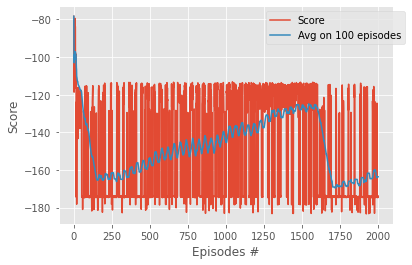

In [11]:
%matplotlib inline

print('length of scores: ', len(scores), ', len of average scores: ', len(Avg_Scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores, label="Score")
plt.plot(np.arange(1, len(Avg_Scores) + 1), Avg_Scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

In [12]:
env.close

<bound method Wrapper.close of <TimeLimit<BipedalWalker<BipedalWalker-v3>>>>